# Phase 0: ChemBERTa on Tox21 — Clean Re-Training (Masked Multi-Label, Stratified K-Fold)



## 1: Imports and paths 

In [1]:
# !pip install transformers==4.42.0 torch --quiet
# !pip install pandas numpy scikit-learn tqdm iterstrat --quiet

import os, json, math, random
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from tqdm import tqdm
from transformers import (AutoConfig, AutoTokenizer, AutoModelForSequenceClassification,
                          get_linear_schedule_with_warmup, AdamW)

# ---------- Paths ----------
DATA_CSV   = Path("tox21_chembera_pipeline_V2/data/tox21.csv")
ROOT_DIR   = Path("tox21_chembera_pipeline_V2")
MODEL_DIR  = ROOT_DIR / "model" / "chemberta_v1"
OUTPUTS_DIR= ROOT_DIR / "outputs"
FINAL_DIR  = Path("Final")
CONFIG_DIR = FINAL_DIR / "config"

for p in [MODEL_DIR, OUTPUTS_DIR, CONFIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# ---------- Labels (canonical Tox21 12) ----------
LABELS = [
    "NR-AR", "NR-AR-LBD", "NR-AhR", "NR-Aromatase", "NR-ER",
    "NR-ER-LBD", "NR-PPAR-gamma", "SR-ARE", "SR-ATAD5",
    "SR-HSE", "SR-MMP", "SR-p53",
]

# ---------- Reproducibility ----------
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"CSV exists: {DATA_CSV.exists()}  -> {DATA_CSV}")
print(f"Model dir:  {MODEL_DIR.resolve()}")
print(f"Outputs:    {OUTPUTS_DIR.resolve()}")
print(f"Config:     {CONFIG_DIR.resolve()}")


Device: cuda
CSV exists: True  -> tox21_chembera_pipeline_V2\data\tox21.csv
Model dir:  D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chembera_pipeline_V2\model\chemberta_v1
Outputs:    D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chembera_pipeline_V2\outputs
Config:     D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\Final\config


## 2: Load data, build target/mask arrays, quick sanity checks

Rows (molecules): 7831, Labels: 12
Observed counts per label: {'NR-AR': 7265, 'NR-AR-LBD': 6758, 'NR-AhR': 6549, 'NR-Aromatase': 5821, 'NR-ER': 6193, 'NR-ER-LBD': 6955, 'NR-PPAR-gamma': 6450, 'SR-ARE': 5832, 'SR-ATAD5': 7072, 'SR-HSE': 6467, 'SR-MMP': 5810, 'SR-p53': 6774}
Positive rates per label: {'NR-AR': 0.043, 'NR-AR-LBD': 0.035, 'NR-AhR': 0.117, 'NR-Aromatase': 0.052, 'NR-ER': 0.128, 'NR-ER-LBD': 0.05, 'NR-PPAR-gamma': 0.029, 'SR-ARE': 0.162, 'SR-ATAD5': 0.037, 'SR-HSE': 0.058, 'SR-MMP': 0.158, 'SR-p53': 0.062}


,smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


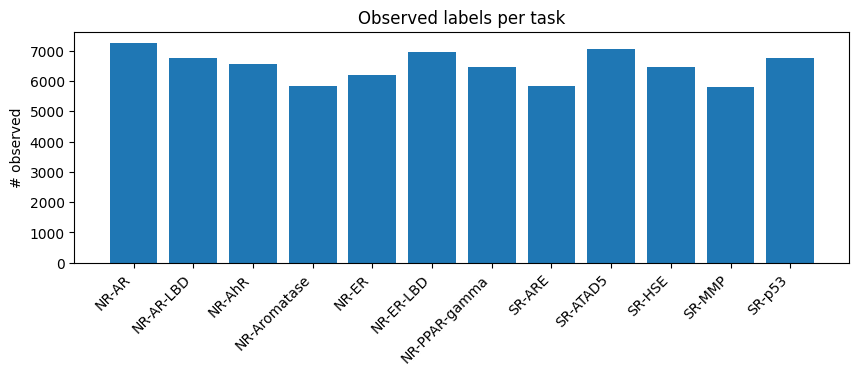

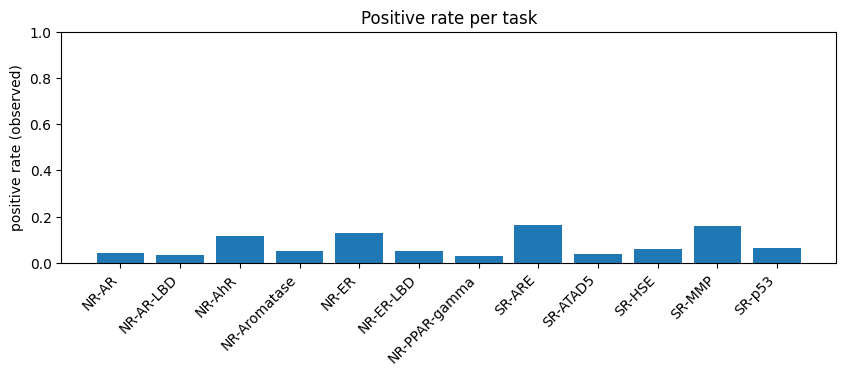

✅ Saved cleaned data to: tox21_chembera_pipeline_V2\data\tox21_clean.parquet


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load CSV
df = pd.read_csv(DATA_CSV)
assert "smiles" in df.columns, "CSV must contain a 'smiles' column"
df.columns = [c.strip() for c in df.columns]

# Ensure label columns exist (create if missing -> NaN)
for c in LABELS:
    if c not in df.columns:
        df[c] = np.nan
    # Coerce to numeric (strings like "" -> NaN)
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep only SMILES + labels (clone to avoid chained assignment warnings)
df = df[["smiles"] + LABELS].copy()

# 2) Build targets (y) and mask (m)
y = df[LABELS].to_numpy(dtype=np.float32)                  # shape [N, 12], may contain NaN
mask = (~df[LABELS].isna()).to_numpy(dtype=np.float32)     # 1 if observed, 0 if missing

N, C = y.shape
obs_per_label = mask.sum(axis=0)                            # number of observed entries per label
pos_per_label = np.nansum(np.where(mask == 1, y, np.nan), axis=0)  # positives among observed
# avoid div by zero
pos_rate = np.where(obs_per_label > 0, pos_per_label / obs_per_label, np.nan)

print(f"Rows (molecules): {N}, Labels: {C}")
print("Observed counts per label:", dict(zip(LABELS, obs_per_label.astype(int))))
print("Positive rates per label:", {k: float(f"{v:.3f}") if np.isfinite(v) else None
                                   for k, v in zip(LABELS, pos_rate)})

display(df.head(5))

# 3) Quick visuals (optional)
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(range(C), obs_per_label)
ax.set_xticks(range(C))
ax.set_xticklabels(LABELS, rotation=45, ha="right")
ax.set_ylabel("# observed")
ax.set_title("Observed labels per task")
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
plot_rates = np.nan_to_num(pos_rate, nan=0.0)
ax.bar(range(C), plot_rates)
ax.set_xticks(range(C))
ax.set_xticklabels(LABELS, rotation=45, ha="right")
ax.set_ylabel("positive rate (observed)")
ax.set_ylim(0, 1)
ax.set_title("Positive rate per task")
plt.show()

# Persist a cleaned copy if helpful
CLEAN_PATH = ROOT_DIR / "data" / "tox21_clean.parquet"
CLEAN_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_parquet(CLEAN_PATH, index=False)
print(f"✅ Saved cleaned data to: {CLEAN_PATH}")


## 3: Base model, tokenizer, and stratified folds

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import json

from transformers import AutoConfig, AutoTokenizer

# === Choose a base model (you can change and re-run) ===
BASE_MODEL = "seyonec/ChemBERTa-zinc-base-v1"  

# === Hyperparameters (tweak as you wish) ===
MAX_LEN   = 256
FOLDS     = 5
SEED      = 42

EPOCHS    = 100
BATCH_SZ  = 16
LR        = 2e-5
L2D       = 0.95      # layer-wise lr decay factor
PATIENCE  = 2         # early stopping patience (epochs)

# Persist a tiny config snapshot for the run
run_cfg = {
    "base_model": BASE_MODEL,
    "max_len": MAX_LEN,
    "folds": FOLDS,
    "seed": SEED,
    "epochs": EPOCHS,
    "batch_size": BATCH_SZ,
    "lr": LR,
    "l2d": L2D,
    "patience": PATIENCE,
    "labels": LABELS,
}
(OUTPUTS_DIR / "run_config.json").write_text(json.dumps(run_cfg, indent=2), encoding="utf-8")
print("Saved run config →", (OUTPUTS_DIR / "run_config.json").resolve())

# === Tokenizer & (future) model config ===
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
print("Tokenizer loaded from:", BASE_MODEL)

# === Multilabel stratified folds ===
try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
    HAS_ITERSTRAT = True
except Exception:
    HAS_ITERSTRAT = False

X_dummy = np.zeros((len(df), 1))
Y_for_split = np.nan_to_num(y, nan=0.0)   # ONLY for splitting
fold_assign = np.full(len(df), -1, dtype=int)

if HAS_ITERSTRAT:
    mskf = MultilabelStratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    for k, (tr_idx, va_idx) in enumerate(mskf.split(X_dummy, Y_for_split), 1):
        fold_assign[va_idx] = k
else:
    # Fallback: stratify on "has any positive label"
    from sklearn.model_selection import StratifiedKFold
    proxy = (~np.isnan(y) & (y > 0.5)).sum(axis=1) > 0
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    for k, (tr_idx, va_idx) in enumerate(skf.split(np.zeros(len(df)), proxy.astype(int)), 1):
        fold_assign[va_idx] = k

assert (fold_assign >= 1).all(), "Fold assignment failed for some rows."

# Attach and save folds
df_folds = df.copy()
df_folds["fold"] = fold_assign
FOLDS_CSV = OUTPUTS_DIR / "folds.csv"
df_folds.to_csv(FOLDS_CSV, index=False)
print("✅ Saved folds to:", FOLDS_CSV.resolve())
print(df_folds["fold"].value_counts().sort_index())

# Quick fold sanity: positive rates per label by fold (optional preview)
per_fold_rates = {}
for k in range(1, FOLDS + 1):
    d = df_folds[df_folds["fold"] == k]
    m_k = (~d[LABELS].isna()).to_numpy(dtype=np.float32)
    y_k = d[LABELS].to_numpy(dtype=np.float32)
    obs = m_k.sum(axis=0)
    pos = np.nansum(np.where(m_k == 1, y_k, np.nan), axis=0)
    rate = np.where(obs > 0, pos / obs, np.nan)
    per_fold_rates[k] = {lab: (None if not np.isfinite(r) else float(f"{r:.3f}"))
                         for lab, r in zip(LABELS, rate)}

print("Per-fold positive rates (observed only):")
per_fold_rates


Saved run config → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chembera_pipeline_V2\outputs\run_config.json
Tokenizer loaded from: seyonec/ChemBERTa-zinc-base-v1
✅ Saved folds to: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chembera_pipeline_V2\outputs\folds.csv
fold
1    1566
2    1567
3    1566
4    1566
5    1566
Name: count, dtype: int64
Per-fold positive rates (observed only):


{1: {'NR-AR': 0.043,
  'NR-AR-LBD': 0.035,
  'NR-AhR': 0.118,
  'NR-Aromatase': 0.052,
  'NR-ER': 0.13,
  'NR-ER-LBD': 0.05,
  'NR-PPAR-gamma': 0.03,
  'SR-ARE': 0.163,
  'SR-ATAD5': 0.037,
  'SR-HSE': 0.058,
  'SR-MMP': 0.161,
  'SR-p53': 0.064},
 2: {'NR-AR': 0.043,
  'NR-AR-LBD': 0.036,
  'NR-AhR': 0.118,
  'NR-Aromatase': 0.052,
  'NR-ER': 0.128,
  'NR-ER-LBD': 0.051,
  'NR-PPAR-gamma': 0.029,
  'SR-ARE': 0.158,
  'SR-ATAD5': 0.038,
  'SR-HSE': 0.056,
  'SR-MMP': 0.155,
  'SR-p53': 0.062},
 3: {'NR-AR': 0.042,
  'NR-AR-LBD': 0.035,
  'NR-AhR': 0.116,
  'NR-Aromatase': 0.051,
  'NR-ER': 0.128,
  'NR-ER-LBD': 0.05,
  'NR-PPAR-gamma': 0.028,
  'SR-ARE': 0.163,
  'SR-ATAD5': 0.037,
  'SR-HSE': 0.058,
  'SR-MMP': 0.156,
  'SR-p53': 0.062},
 4: {'NR-AR': 0.042,
  'NR-AR-LBD': 0.035,
  'NR-AhR': 0.117,
  'NR-Aromatase': 0.051,
  'NR-ER': 0.127,
  'NR-ER-LBD': 0.05,
  'NR-PPAR-gamma': 0.029,
  'SR-ARE': 0.162,
  'SR-ATAD5': 0.038,
  'SR-HSE': 0.058,
  'SR-MMP': 0.16,
  'SR-p53': 0.062},
 5

## 4: Dataset, masked loss, and metrics utilities

In [4]:
import numpy as np
import torch
import torch.nn as nn

# ---------- Dataset ----------
class SmilesDataset(torch.utils.data.Dataset):
    def __init__(self, smiles, y, mask, tokenizer, max_len=256):
        self.smiles = list(map(str, smiles))
        self.y = y.astype(np.float32)
        self.mask = mask.astype(np.float32)
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, i):
        s = self.smiles[i]
        enc = self.tok(
            s,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        # Replace NaN with 0.0 in labels here; masking will ignore them in loss/metrics
        item['labels'] = torch.from_numpy(np.nan_to_num(self.y[i], nan=0.0)).float()
        item['mask']   = torch.from_numpy(self.mask[i]).float()
        return item

# ---------- Masked multi-label BCE with pos_weight ----------
class MaskedBCELoss(nn.Module):
    def __init__(self, pos_weight: torch.Tensor):
        super().__init__()
        # pos_weight: [C] on the correct device
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')

    def forward(self, logits, targets, mask):
        """
        logits: [B, C] raw logits
        targets: [B, C] in {0,1}
        mask: [B, C] in {0,1} -> 0 means "missing label" (ignore in loss)
        """
        loss = self.bce(logits, targets)  # [B, C]
        loss = loss * mask
        denom = mask.sum().clamp_min(1.0)
        return loss.sum() / denom

# ---------- Metrics ----------
@torch.no_grad()
def masked_auc(y_true: np.ndarray, y_prob: np.ndarray, mask: np.ndarray):
    """
    AUROC per label using only observed entries (mask==1). Returns (macro_auc, list_per_label).
    If a label has degenerate ground truth (all 0 or all 1), returns NaN for that label.
    """
    from sklearn.metrics import roc_auc_score
    aucs = []
    for j in range(y_true.shape[1]):
        m = mask[:, j] > 0.5
        if m.sum() < 3 or len(np.unique(y_true[m, j])) < 2:
            aucs.append(np.nan)
            continue
        try:
            aucs.append(roc_auc_score(y_true[m, j], y_prob[m, j]))
        except Exception:
            aucs.append(np.nan)
    macro = np.nanmean(aucs) if np.any(~np.isnan(aucs)) else np.nan
    return float(macro if not np.isnan(macro) else 0.0), [None if np.isnan(x) else float(x) for x in aucs]

def compute_thresholds_youden(y_true: np.ndarray, y_prob: np.ndarray, mask: np.ndarray, labels=LABELS):
    """
    Per-label threshold via Youden's J (TPR - FPR). Ignores missing via mask.
    """
    th = {}
    for j, name in enumerate(labels):
        m = mask[:, j] > 0.5
        if m.sum() == 0:
            th[name] = 0.5
            continue
        y, p = y_true[m, j], y_prob[m, j]
        grid = np.unique(np.concatenate([[0.0, 1.0], p]))
        best_t, best_s = 0.5, -1.0
        for t in grid:
            yhat = (p >= t).astype(int)
            tp = ((y == 1) & (yhat == 1)).sum()
            fp = ((y == 0) & (yhat == 1)).sum()
            fn = ((y == 1) & (yhat == 0)).sum()
            tn = ((y == 0) & (yhat == 0)).sum()
            tpr = tp / (tp + fn + 1e-9)
            fpr = fp / (fp + tn + 1e-9)
            s = tpr - fpr
            if s > best_s:
                best_s, best_t = s, float(t)
        th[name] = round(best_t, 4)
    return th

# ---------- Layer-wise LR decay groups ----------
def layerwise_lr(model, base_lr, decay=0.95):
    """
    Assigns smaller LR to lower layers (layer-wise LR decay).
    Returns param groups suitable for AdamW.
    """
    no_decay = ["bias", "LayerNorm.weight"]
    params = []
    # try common encoders
    if hasattr(model, "roberta"):
        layers = list(model.roberta.encoder.layer)
    elif hasattr(model, "bert"):
        layers = list(model.bert.encoder.layer)
    else:
        layers = []

    # classification head (if exists)
    head, head_no_decay = [], []
    head_module = getattr(model, "classifier", None)
    if head_module is not None:
        for n, p in head_module.named_parameters():
            (head_no_decay if any(nd in n for nd in no_decay) else head).append(p)

    # encoder layers (reversed so top layers get higher LR)
    for i, layer in enumerate(reversed(layers)):
        lr = base_lr * (decay ** i)
        wd_group, no_wd_group = [], []
        for n, p in layer.named_parameters():
            (no_wd_group if any(nd in n for nd in no_decay) else wd_group).append(p)
        params.append({"params": wd_group,      "lr": lr, "weight_decay": 0.01})
        params.append({"params": no_wd_group,   "lr": lr, "weight_decay": 0.00})

    if head:
        params.append({"params": head,          "lr": base_lr, "weight_decay": 0.01})
    if head_no_decay:
        params.append({"params": head_no_decay, "lr": base_lr, "weight_decay": 0.00})

    # fallback if we couldn't find layers
    if not params:
        decay_group, no_decay_group = [], []
        for n, p in model.named_parameters():
            (no_decay_group if any(nd in n for nd in no_decay) else decay_group).append(p)
        params = [
            {"params": decay_group,    "lr": base_lr, "weight_decay": 0.01},
            {"params": no_decay_group, "lr": base_lr, "weight_decay": 0.00},
        ]
    return params

print("✅ Dataset, loss, and metrics helpers ready.")


✅ Dataset, loss, and metrics helpers ready.


## 5A: Training utilities (dataloaders, pos_weight, one-fold train/val with early stopping)

In [5]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available? ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    x = torch.rand(3,3).to("cuda")
    print("Test tensor on CUDA:", x.device, x)
else:
    print("⚠️ CUDA not available, training will run on CPU.")

PyTorch version: 2.6.0+cu124
CUDA available?  True
GPU device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 4070 Ti
Test tensor on CUDA: cuda:0 tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408]], device='cuda:0')


In [6]:
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification

def make_loaders(train_idx, val_idx, tokenizer, max_len=MAX_LEN, batch_size=BATCH_SZ):
    train_ds = SmilesDataset(df.iloc[train_idx]["smiles"].tolist(),
                             y[train_idx], mask[train_idx], tokenizer, max_len=max_len)
    val_ds   = SmilesDataset(df.iloc[val_idx]["smiles"].tolist(),
                             y[val_idx],   mask[val_idx],   tokenizer, max_len=max_len)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    return train_ds, val_ds, train_loader, val_loader

def compute_pos_weight_from_train(train_ds) -> torch.Tensor:
    """
    Estimate pos_weight = negatives/positives using only observed labels in the TRAIN split.
    """
    yy = []
    mm = []
    for i in range(len(train_ds)):
        item = train_ds[i]
        yy.append(item["labels"].numpy())
        mm.append(item["mask"].numpy())
    yy = np.vstack(yy)  # [N, C]
    mm = np.vstack(mm)  # [N, C]
    pos = (yy * mm).sum(axis=0) + 1e-6
    neg = ((1 - yy) * mm).sum(axis=0) + 1e-6
    pw = torch.tensor(neg / pos, dtype=torch.float32, device=device)
    return pw

@torch.no_grad()
def validate(model, val_loader):
    model.eval()
    all_logits, all_y, all_m = [], [], []
    for batch in val_loader:
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        all_logits.append(out.logits.detach().cpu().numpy())
        all_y.append(batch["labels"].cpu().numpy())
        all_m.append(batch["mask"].cpu().numpy())
    logits = np.vstack(all_logits)
    y_true = np.vstack(all_y)
    msk    = np.vstack(all_m)
    y_prob = 1 / (1 + np.exp(-logits))
    macro, per_label = masked_auc(y_true, y_prob, msk)
    return macro, per_label, y_true, y_prob, msk

def train_one_fold(train_idx, val_idx):
    """
    Train a fresh model on the given indices and return:
      - best_model (loaded with best state)
      - fold_metrics = dict(macro_auc=..., per_label_auc=[...])
      - val_arrays = (y_true, y_prob, mask) for the validation split
    """
    # Fresh model for this fold
    cfg = AutoConfig.from_pretrained(BASE_MODEL, num_labels=len(LABELS), problem_type="multi_label_classification")
    model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, config=cfg).to(device)

    # Data
    train_ds, val_ds, train_loader, val_loader = make_loaders(train_idx, val_idx, tokenizer, max_len=MAX_LEN, batch_size=BATCH_SZ)

    # Loss with pos_weight estimated from training data
    pos_weight = compute_pos_weight_from_train(train_ds)
    loss_fn = MaskedBCELoss(pos_weight=pos_weight)

    # Optimizer & scheduler
    optim = AdamW(layerwise_lr(model, LR, decay=L2D), betas=(0.9, 0.999), eps=1e-8)
    total_steps = len(train_loader) * EPOCHS
    warmup = int(0.1 * total_steps)
    sched = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup, num_training_steps=total_steps)

    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    # Early stopping on masked macro AUROC
    best_auc = -1.0
    best_state = None
    patience_left = PATIENCE

    for ep in range(1, EPOCHS + 1):
        model.train()
        ep_losses = []
        for batch in tqdm(train_loader, desc=f"[fold train] epoch {ep}/{EPOCHS}"):
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            optim.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                loss = loss_fn(out.logits, batch["labels"], batch["mask"])
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            sched.step()
            ep_losses.append(loss.item())

        # Validation
        macro, per_label, vy_true, vy_prob, vmask = validate(model, val_loader)
        print(f"[val] epoch={ep}  loss={np.mean(ep_losses):.4f}  macro_auc={macro:.4f}")

        if macro > best_auc:
            best_auc = macro
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            patience_left = PATIENCE
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("Early stopping.")
                break

    # Load best state
    if best_state is not None:
        model.load_state_dict(best_state)

    # Final val pass with best weights
    macro, per_label, vy_true, vy_prob, vmask = validate(model, val_loader)
    fold_metrics = {"macro_auc": float(macro), "per_label_auc": per_label}

    return model, fold_metrics, (vy_true, vy_prob, vmask)


### 5B: Run K-fold training, save per-fold models, OOF predictions, thresholds, and enrich config

In [7]:
from pathlib import Path
import json
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoConfig

# Load folds
folds_csv = pd.read_csv(OUTPUTS_DIR / "folds.csv")
assert "fold" in folds_csv.columns and "smiles" in folds_csv.columns

# Containers for OOF logits (we’ll reconstruct logits from val probs)
oof_prob = np.zeros((len(folds_csv), len(LABELS)), dtype=np.float32)
oof_mask = mask.copy()  # same order as original df

fold_metrics = []
for k in range(1, FOLDS + 1):
    print(f"\n========== Fold {k}/{FOLDS} ==========")
    val_idx = np.where(folds_csv["fold"].values == k)[0]
    train_idx = np.where(folds_csv["fold"].values != k)[0]

    model_k, metrics_k, (vy_true, vy_prob, vmask) = train_one_fold(train_idx, val_idx)
    fold_metrics.append({"fold": k, **metrics_k})

    # Store fold model
    fold_dir = MODEL_DIR / f"fold_{k}"
    fold_dir.mkdir(parents=True, exist_ok=True)
    model_k.save_pretrained(fold_dir)
    tokenizer.save_pretrained(fold_dir)

    # Insert OOF probs at validation indices
    assert vy_prob.shape[0] == len(val_idx)
    oof_prob[val_idx] = vy_prob.astype(np.float32)

# Aggregate OOF metrics
from sklearn.metrics import roc_auc_score

macro_oof, per_label_oof = masked_auc(np.nan_to_num(y, nan=-1), oof_prob, oof_mask)
print(f"\nOOF macro AUROC: {macro_oof:.4f}")
print("OOF per-label AUROC:", dict(zip(LABELS, per_label_oof)))

# Save OOF arrays & a compatibility copy for the app
np.save(OUTPUTS_DIR / "oof_prob.npy", oof_prob.astype(np.float32))
np.save(OUTPUTS_DIR / "oof_mask.npy", oof_mask.astype(np.float32))
np.save(OUTPUTS_DIR / "val_y.npy", np.nan_to_num(y, nan=-1).astype(np.float32))
np.save(OUTPUTS_DIR / "val_prob.npy", oof_prob.astype(np.float32))

# Compute & save thresholds
thresholds = compute_thresholds_youden(np.nan_to_num(y, nan=-1), oof_prob, oof_mask, labels=LABELS)
(CONFIG_DIR / "thresholds.json").write_text(json.dumps(thresholds, indent=2), encoding="utf-8")
print("✅ thresholds.json saved →", (CONFIG_DIR / "thresholds.json").resolve())

# Save tcav layers (we'll use last 3)
(CONFIG_DIR / "tcav_layers.json").write_text(json.dumps({"layers": [-1, -2, -3]}, indent=2), encoding="utf-8")

# Save metrics summary
metrics = {"oof_macro_auc": float(macro_oof), "oof_per_label_auc": per_label_oof, "folds": fold_metrics}
(OUTPUTS_DIR / "metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")
print("✅ metrics.json saved →", (OUTPUTS_DIR / "metrics.json").resolve())

# Refit on all data briefly (optional but useful)
print("\nRefitting on all data for final model (short pass)...")
cfg = AutoConfig.from_pretrained(BASE_MODEL, num_labels=len(LABELS), problem_type="multi_label_classification")
model_full = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, config=cfg).to(device)

# Quick single-epoch-ish pass to adapt head on full data
full_ds = SmilesDataset(df["smiles"].tolist(), y, mask, tokenizer, max_len=MAX_LEN)
full_loader = DataLoader(full_ds, batch_size=BATCH_SZ, shuffle=True, num_workers=0, pin_memory=True)

# pos_weight on all observed data
yy = np.nan_to_num(y, nan=0.0)
pos = (yy * mask).sum(axis=0) + 1e-6
neg = ((1 - yy) * mask).sum(axis=0) + 1e-6
pos_weight_full = torch.tensor(neg / pos, dtype=torch.float32, device=device)
loss_fn_full = MaskedBCELoss(pos_weight=pos_weight_full)

optim = AdamW(layerwise_lr(model_full, LR, decay=L2D))
steps = len(full_loader)  # one pass
sched = get_linear_schedule_with_warmup(optim, int(0.1 * steps), steps)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

model_full.train()
for step, batch in enumerate(tqdm(full_loader, desc="Refit(full)")):
    batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
    optim.zero_grad(set_to_none=True)
    with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
        out = model_full(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = loss_fn_full(out.logits, batch["labels"], batch["mask"])
    scaler.scale(loss).backward(); scaler.step(optim); scaler.update(); sched.step()

# Save final model
MODEL_DIR.mkdir(parents=True, exist_ok=True)
model_full.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

# Enrich final config with id2label / label2id
cfg_path = MODEL_DIR / "config.json"
cfg_json = json.loads(cfg_path.read_text(encoding="utf-8"))
id2label = {i: LABELS[i] for i in range(len(LABELS))}
label2id = {v: k for k, v in id2label.items()}
cfg_json["id2label"] = {str(k): v for k, v in id2label.items()}
cfg_json["label2id"] = label2id
cfg_path.write_text(json.dumps(cfg_json, indent=2), encoding="utf-8")

print("\n✅ Done.")
print(f"- Fold models → {MODEL_DIR}")
print(f"- Final model → {MODEL_DIR}")
print(f"- OOF arrays  → {OUTPUTS_DIR}")
print(f"- thresholds  → {CONFIG_DIR / 'thresholds.json'}")
print(f"- tcav layers → {CONFIG_DIR / 'tcav_layers.json'}")



========== Fold 1/5 ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\Amir\AppData\Local\Temp\ipykernel_23324\292123357.py:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type ==

[val] epoch=1  loss=1.2898  macro_auc=0.6259


[fold train] epoch 2/100:   0%|          | 0/392 [00:00<?, ?it/s]C:\Users\Amir\AppData\Local\Temp\ipykernel_23324\292123357.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
[fold train] epoch 2/100: 100%|██████████| 392/392 [00:20<00:00, 19.05it/s]


[val] epoch=2  loss=1.2055  macro_auc=0.7320


[fold train] epoch 3/100:   0%|          | 0/392 [00:00<?, ?it/s]C:\Users\Amir\AppData\Local\Temp\ipykernel_23324\292123357.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
[fold train] epoch 3/100:  96%|█████████▋| 378/392 [00:20<00:00, 18.76it/s]


KeyboardInterrupt: 

## Calibration + Thresholds 

### Calibration saved in implementation/models/metadata

In [ ]:
# === CELL 1: CALIBRATION (save to implementation/models/metadata) ===
import json, numpy as np
from pathlib import Path
from transformers import AutoConfig
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
import torch

# ---- paths (edit VAL_DIR if needed) ----
META_DIR = Path("implementation/models/metadata")
VAL_DIR  = Path("tox21_chembera_pipeline_V2/outputs")  # <-- change if your arrays live elsewhere
CFG_PATH = "implementation/models/chemberta_v1/config.json"

META_DIR.mkdir(parents=True, exist_ok=True)

# ---- load validation arrays ----
val_prob = np.load(VAL_DIR / "val_prob.npy")  # shape [N, L], raw model probs (sigmoid)
val_y    = np.load(VAL_DIR / "val_y.npy")     # shape [N, L], {0,1}

# ---- label order from model config ----
cfg = AutoConfig.from_pretrained(CFG_PATH)
id2label = cfg.id2label
label_names = [id2label[i] for i in range(len(id2label))]

# ---- logits from probs (for temperature / Platt) ----
eps = 1e-6
val_prob_clip = val_prob.clip(eps, 1 - eps)
val_logit = np.log(val_prob_clip / (1 - val_prob_clip))

# ---- A) global temperature scaling (minimize BCE on logits/T) ----
X = torch.tensor(val_logit, dtype=torch.float32)
Y = torch.tensor(val_y,    dtype=torch.float32)

T = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
opt = torch.optim.LBFGS([T], lr=0.1, max_iter=100)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction="mean")

def closure():
    opt.zero_grad()
    logits_T = X / torch.clamp(T, min=0.05, max=10.0)
    loss = loss_fn(logits_T, Y)
    loss.backward()
    return loss

for _ in range(25):
    opt.step(closure)

T_final = float(T.detach().clamp(0.05, 10.0))
np.save(META_DIR / "temperature.npy", np.array([T_final], dtype=np.float32))

cal_prob_temp = torch.sigmoid(X / T_final).numpy()

# ---- B) per-label Platt (logistic) & Isotonic; pick best by NLL ----
def nll(p, y, eps=1e-8):
    p = np.clip(p, eps, 1 - eps)
    return float(-(y*np.log(p) + (1-y)*np.log(1-p)).mean())

platt_params = {}
iso_params   = {}
method_per_label = {}
final_probs  = np.zeros_like(val_prob)

for j, lbl in enumerate(label_names):
    yj = val_y[:, j].astype(float)
    lj = val_logit[:, j].reshape(-1, 1)
    pj = val_prob[:, j]

    # Platt on logits
    lr = LogisticRegression(solver="lbfgs", max_iter=2000)
    lr.fit(lj, yj)
    A = float(lr.coef_[0][0]); B = float(lr.intercept_[0])
    platt_params[lbl] = {"A": A, "B": B}
    prob_platt = 1.0 / (1.0 + np.exp(-(A*val_logit[:, j] + B)))

    # Isotonic on probs
    ir = IsotonicRegression(out_of_bounds="clip")
    ir.fit(pj, yj)
    prob_iso = ir.transform(pj)
    iso_params[lbl] = {
        "X": ir.X_thresholds_.astype(float).tolist(),
        "Y": ir.y_thresholds_.astype(float).tolist()
    }

    # candidates & NLLs
    cands = {
        "none":  pj,
        "temp":  cal_prob_temp[:, j],
        "platt": prob_platt,
        "iso":   prob_iso,
    }
    scores = {k: nll(v, yj) for k, v in cands.items()}
    best = min(scores, key=scores.get)
    method_per_label[lbl] = {"method": best, "scores": scores}
    final_probs[:, j] = cands[best]

# ---- save calibration artifacts ----
with open(META_DIR / "calibration_methods.json", "w") as f:
    json.dump(method_per_label, f, indent=2)
with open(META_DIR / "platt_params.json", "w") as f:
    json.dump(platt_params, f, indent=2)
with open(META_DIR / "isotonic_params.json", "w") as f:
    json.dump(iso_params, f, indent=2)

print("Saved:")
print(" - temperature.npy")
print(" - calibration_methods.json")
print(" - platt_params.json")
print(" - isotonic_params.json")


Saved:
 - temperature.npy
 - calibration_methods.json
 - platt_params.json
 - isotonic_params.json


C:\Users\Amir\AppData\Local\Temp\ipykernel_8596\335931111.py:56: RuntimeWarning: divide by zero encountered in log
  return float(-(y*np.log(p) + (1-y)*np.log(1-p)).mean())
C:\Users\Amir\AppData\Local\Temp\ipykernel_8596\335931111.py:56: RuntimeWarning: invalid value encountered in multiply
  return float(-(y*np.log(p) + (1-y)*np.log(1-p)).mean())
C:\Users\Amir\AppData\Local\Temp\ipykernel_8596\335931111.py:56: RuntimeWarning: divide by zero encountered in log
  return float(-(y*np.log(p) + (1-y)*np.log(1-p)).mean())
C:\Users\Amir\AppData\Local\Temp\ipykernel_8596\335931111.py:56: RuntimeWarning: invalid value encountered in multiply
  return float(-(y*np.log(p) + (1-y)*np.log(1-p)).mean())
C:\Users\Amir\AppData\Local\Temp\ipykernel_8596\335931111.py:56: RuntimeWarning: divide by zero encountered in log
  return float(-(y*np.log(p) + (1-y)*np.log(1-p)).mean())
C:\Users\Amir\AppData\Local\Temp\ipykernel_8596\335931111.py:56: RuntimeWarning: invalid value encountered in multiply
  return

### Compute robust per-label thresholds (bootstrapped) & save

In [ ]:
# === CELL 2: ROBUST THRESHOLDS (save to implementation/models/metadata) ===
import json, numpy as np
from pathlib import Path

META_DIR = Path("implementation/models/metadata")
VAL_DIR  = Path("tox21_chembera_pipeline_V2/outputs")  # <-- keep in sync with Cell 1
CFG_PATH = "implementation/models/chemberta_v1/config.json"

# ---- reload arrays and calibration artifacts for a clean, reproducible step ----
val_prob = np.load(VAL_DIR / "val_prob.npy")  # [N, L] raw probs
val_y    = np.load(VAL_DIR / "val_y.npy")     # [N, L]

from transformers import AutoConfig
cfg = AutoConfig.from_pretrained(CFG_PATH)
id2label = cfg.id2label
label_names = [id2label[i] for i in range(len(id2label))]

with open(META_DIR / "calibration_methods.json") as f:
    CAL_METHOD = json.load(f)
with open(META_DIR / "platt_params.json") as f:
    PLATT = json.load(f)
with open(META_DIR / "isotonic_params.json") as f:
    ISO = json.load(f)
temp_path = META_DIR / "temperature.npy"
TEMP = float(np.load(temp_path)[0]) if temp_path.exists() else 1.0

# ---- helper: apply saved calibration per label ----
def apply_iso_scalar(p, X, Y):
    return float(np.interp(p, np.asarray(X, float), np.asarray(Y, float)))

def calibrate_probs(val_prob: np.ndarray) -> np.ndarray:
    eps = 1e-6
    logits = np.log(np.clip(val_prob, eps, 1 - eps) / np.clip(1 - val_prob, eps, 1 - eps))
    out = np.zeros_like(val_prob, dtype=float)
    for j, lbl in enumerate(label_names):
        method = CAL_METHOD[lbl]["method"]
        if method == "temp":
            out[:, j] = 1.0 / (1.0 + np.exp(-(logits[:, j] / TEMP)))
        elif method == "platt":
            A = PLATT[lbl]["A"]; B = PLATT[lbl]["B"]
            out[:, j] = 1.0 / (1.0 + np.exp(-(A*logits[:, j] + B)))
        elif method == "iso":
            X = ISO[lbl]["X"]; Y = ISO[lbl]["Y"]
            out[:, j] = np.array([apply_iso_scalar(p, X, Y) for p in val_prob[:, j]])
        else:  # "none"
            out[:, j] = val_prob[:, j]
    return out

cal_prob = calibrate_probs(val_prob)

# ---- robust thresholding via bootstrap (choose metric) ----
from sklearn.metrics import f1_score

def youden_score(y_true, y_hat):
    tp = ((y_hat==1)&(y_true==1)).sum(); fn = ((y_hat==0)&(y_true==1)).sum()
    fp = ((y_hat==1)&(y_true==0)).sum(); tn = ((y_hat==0)&(y_true==0)).sum()
    tpr = tp/(tp+fn+1e-8); fpr = fp/(fp+tn+1e-8)
    return tpr - fpr

def best_threshold(p, y, metric="youden", beta=1.0):
    grid = np.linspace(0.05, 0.95, 181)
    best_t, best_s = 0.5, -1.0
    for t in grid:
        yh = (p >= t).astype(int)
        if metric == "youden":
            s = youden_score(y, yh)
        elif metric == "f1":
            s = f1_score(y, yh) if yh.sum() or y.sum() else 0.0
        else:  # f-beta
            from sklearn.metrics import fbeta_score
            s = fbeta_score(y, yh, beta=beta) if yh.sum() or y.sum() else 0.0
        if s > best_s:
            best_s, best_t = s, t
    return best_t

def boot_thresholds(probs: np.ndarray, y: np.ndarray, B=200, metric="youden", beta=1.0):
    N, L = probs.shape
    rng = np.random.default_rng(123)
    out = {}
    for j, lbl in enumerate(label_names):
        ts = []
        for _ in range(B):
            idx = rng.choice(N, size=N, replace=True)
            ts.append(best_threshold(probs[idx, j], y[idx, j], metric=metric, beta=beta))
        out[lbl] = float(np.median(ts))
    return out

# choose your objective: "youden" (balanced) or "f1" (positive-focused)
thresholds = boot_thresholds(cal_prob, val_y, B=200, metric="youden")

# ---- save thresholds ----
with open(META_DIR / "thresholds.json", "w") as f:
    json.dump({k: round(v, 3) for k, v in thresholds.items()}, f, indent=2)

print("Saved thresholds.json and calibration artifacts under:", META_DIR.resolve())
print("Example thresholds:", list(thresholds.items())[:5])


Saved thresholds.json and calibration artifacts under: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\models\metadata
Example thresholds: [('NR-AR', 0.62), ('NR-AR-LBD', 0.4599999999999999), ('NR-AhR', 0.36999999999999994), ('NR-Aromatase', 0.05), ('NR-ER', 0.5399999999999999)]


## 6: Post-training evaluation & plots

In [ ]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

FIG_DIR = OUTPUTS_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

oof_prob_path = OUTPUTS_DIR / "oof_prob.npy"
oof_mask_path = OUTPUTS_DIR / "oof_mask.npy"
th_path       = CONFIG_DIR / "thresholds.json"

if not oof_prob_path.exists() or not oof_mask_path.exists():
    print("⚠️ OOF arrays not found yet. Run this cell after training (Cell 5B) completes.")
else:
    # Load arrays
    oof_prob = np.load(oof_prob_path)        # [N, C]
    oof_mask = np.load(oof_mask_path)        # [N, C]
    y_true   = df[LABELS].to_numpy(dtype=np.float32)  # [N, C] with NaNs
    y_true   = np.nan_to_num(y_true, nan=-1) # use -1 as "missing" sentinel (ignored via mask)

    # Load thresholds (Youden)
    if th_path.exists():
        thresholds = json.loads(th_path.read_text(encoding="utf-8"))
    else:
        thresholds = {lab: 0.5 for lab in LABELS}

    # Containers
    per_label_auc  = []
    per_label_aupr = []
    rows = []

    # --- Per-label curves & metrics ---
    for j, lab in enumerate(LABELS):
        m = oof_mask[:, j] > 0.5
        y = y_true[m, j]
        p = oof_prob[m, j]
        if m.sum() < 3 or len(np.unique(y)) < 2:
            print(f"Skipping {lab}: insufficient positives/negatives.")
            per_label_auc.append(np.nan)
            per_label_aupr.append(np.nan)
            continue

        # ROC
        fpr, tpr, _ = roc_curve(y, p)
        roc_auc = auc(fpr, tpr)
        per_label_auc.append(roc_auc)

        plt.figure(figsize=(4, 4))
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1],[0,1], "--", lw=1)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {lab}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"roc_{lab}.png", dpi=200)
        plt.close()

        # PR
        precision, recall, _ = precision_recall_curve(y, p)
        pr_auc = auc(recall, precision)
        per_label_aupr.append(pr_auc)

        plt.figure(figsize=(4, 4))
        plt.plot(recall, precision, lw=2, label=f"AUPRC = {pr_auc:.3f}")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR — {lab}")
        plt.legend(loc="lower left")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"pr_{lab}.png", dpi=200)
        plt.close()

        # Thresholded metrics at Youden threshold
        thr = float(thresholds.get(lab, 0.5))
        yhat = (p >= thr).astype(int)

        tp = int(((y == 1) & (yhat == 1)).sum())
        fp = int(((y == 0) & (yhat == 1)).sum())
        fn = int(((y == 1) & (yhat == 0)).sum())
        tn = int(((y == 0) & (yhat == 0)).sum())
        prec = tp / (tp + fp + 1e-9)
        rec  = tp / (tp + fn + 1e-9)
        f1   = 2 * prec * rec / (prec + rec + 1e-9)
        tpr  = rec
        tnr  = tn / (tn + fp + 1e-9)
        bal_acc = 0.5 * (tpr + tnr)

        rows.append({
            "label": lab, "AUC": roc_auc, "AUPRC": pr_auc, "thr": thr,
            "precision": prec, "recall": rec, "F1": f1, "balanced_acc": bal_acc,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn, "n_obs": int(m.sum())
        })

    # --- Bars: AUC & AUPRC ---
    idx = np.arange(len(LABELS))
    plt.figure(figsize=(10, 3))
    plt.bar(idx, [0 if np.isnan(x) else x for x in per_label_auc])
    plt.xticks(idx, LABELS, rotation=45, ha="right")
    plt.ylabel("AUC"); plt.ylim(0, 1); plt.title("Per-label ROC AUC (OOF)")
    plt.tight_layout(); plt.savefig(FIG_DIR / "auc_bars.png", dpi=200); plt.close()

    plt.figure(figsize=(10, 3))
    plt.bar(idx, [0 if np.isnan(x) else x for x in per_label_aupr])
    plt.xticks(idx, LABELS, rotation=45, ha="right")
    plt.ylabel("AUPRC"); plt.ylim(0, 1); plt.title("Per-label PR AUC (OOF)")
    plt.tight_layout(); plt.savefig(FIG_DIR / "auprc_bars.png", dpi=200); plt.close()

    # --- Summary CSV ---
    summary_df = pd.DataFrame(rows)
    summary_df.to_csv(OUTPUTS_DIR / "summary.csv", index=False)
    display(summary_df.sort_values("AUC", ascending=False).head(12))

    print("✅ Saved figures →", FIG_DIR.resolve())
    print("✅ Saved summary →", (OUTPUTS_DIR / "summary.csv").resolve())


,label,AUC,AUPRC,thr,precision,recall,F1,balanced_acc,tp,fp,fn,tn,n_obs
10,SR-MMP,0.876089,0.590214,0.4741,0.403621,0.825708,0.542203,0.798381,758,1120,160,3772,5810
2,NR-AhR,0.862693,0.490267,0.3642,0.278385,0.861979,0.420852,0.782572,662,1716,106,4065,6549
1,NR-AR-LBD,0.862111,0.539174,0.4680,0.248485,0.691983,0.365663,0.807961,164,496,73,6025,6758
3,NR-Aromatase,0.853894,0.293585,0.3820,0.141573,0.840000,0.242308,0.781619,252,1528,48,3993,5821
11,SR-p53,0.840981,0.290373,0.3352,0.167335,0.789598,0.276147,0.763954,334,1662,89,4689,6774
8,SR-ATAD5,0.830246,0.284805,0.2870,0.110814,0.784091,0.194184,0.770057,207,1661,57,5147,7072
6,NR-PPAR-gamma,0.823367,0.209895,0.3499,0.093793,0.731183,0.166259,0.760706,136,1314,50,4950,6450
7,SR-ARE,0.794642,0.408290,0.3860,0.316040,0.776008,0.449155,0.726246,731,1582,211,3308,5832
5,NR-ER-LBD,0.794518,0.369676,0.4247,0.153846,0.680000,0.250923,0.740908,238,1309,112,5296,6955
0,NR-AR,0.794139,0.508918,0.6344,0.310345,0.553398,0.397674,0.749384,171,380,138,6576,7265


✅ Saved figures → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chembera_pipeline_V2\outputs\figs
✅ Saved summary → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chembera_pipeline_V2\outputs\summary.csv


## 7: Load final model, verify id2label/label2id, quick inference

In [ ]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Paths
FINAL_MODEL_DIR = MODEL_DIR            # tox21_chembera_pipeline_V2/model/chemberta_v1
THRESH_PATH     = CONFIG_DIR / "thresholds.json"

# 1) Load model & tokenizer
print("Loading model from:", FINAL_MODEL_DIR.resolve())
tokenizer = AutoTokenizer.from_pretrained(FINAL_MODEL_DIR, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(FINAL_MODEL_DIR)
model.eval().to(device)

# 2) Verify config enrichment
cfg_path = FINAL_MODEL_DIR / "config.json"
cfg = json.loads(cfg_path.read_text(encoding="utf-8"))
has_maps = ("id2label" in cfg) and ("label2id" in cfg)
print("Has id2label/label2id?", has_maps)

# Resolve labels from config if present; else fall back to notebook LABELS
if has_maps:
    # id2label keys may be strings; sort by numeric id
    id2label = {int(k): v for k, v in cfg["id2label"].items()}
    LABELS_MODEL = [id2label[i] for i in sorted(id2label.keys())]
else:
    LABELS_MODEL = LABELS

print("Labels (model):", LABELS_MODEL)

# 3) Load thresholds (Youden) — fallback to 0.5 if not found
if THRESH_PATH.exists():
    thresholds = json.loads(THRESH_PATH.read_text(encoding="utf-8"))
else:
    thresholds = {lab: 0.5 for lab in LABELS_MODEL}
print("Thresholds loaded:", len(thresholds), "labels")

# 4) Inference helper
@torch.inference_mode()
def predict_smiles_batch(smiles_list, batch_size=16):
    rows = []
    for i in range(0, len(smiles_list), batch_size):
        chunk = smiles_list[i:i+batch_size]
        enc = tokenizer(
            list(map(str, chunk)),
            padding=True, truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = model(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()  # [B, C]
        for s, p in zip(chunk, probs):
            prob_map = {lab: float(p[j]) for j, lab in enumerate(LABELS_MODEL)}
            active = [lab for lab in LABELS_MODEL if prob_map[lab] >= thresholds.get(lab, 0.5)]
            rows.append({
                "smiles": s,
                **{f"prob_{lab}": prob_map[lab] for lab in LABELS_MODEL},
                "active_labels": ", ".join(active)
            })
    return pd.DataFrame(rows)

# 5) Demo set — take a few molecules from the dataset (you can edit this list)
SAMPLE_SMILES = df["smiles"].head(5).tolist()
pred_df = predict_smiles_batch(SAMPLE_SMILES, batch_size=8)
display(pred_df)

# 6) Save to outputs
pred_path = OUTPUTS_DIR / "pred_samples.csv"
pred_df.to_csv(pred_path, index=False)
print("✅ Saved sample predictions →", pred_path.resolve())


Loading model from: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chembera_pipeline_V2\model\chemberta_v1
Has id2label/label2id? True
Labels (model): ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Thresholds loaded: 12 labels


,smiles,prob_NR-AR,prob_NR-AR-LBD,prob_NR-AhR,prob_NR-Aromatase,prob_NR-ER,prob_NR-ER-LBD,prob_NR-PPAR-gamma,prob_SR-ARE,prob_SR-ATAD5,prob_SR-HSE,prob_SR-MMP,prob_SR-p53,active_labels
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.348548,0.349381,0.674655,0.458120,0.553033,0.395183,0.567299,0.594629,0.545322,0.474459,0.469864,0.533133,"NR-AhR, NR-Aromatase, NR-ER, NR-PPAR-gamma, SR..."
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.295447,0.272559,0.268464,0.207889,0.383303,0.258151,0.557607,0.356508,0.465704,0.293275,0.199272,0.274022,"NR-PPAR-gamma, SR-ATAD5"
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,0.909052,0.916249,0.363034,0.668026,0.663242,0.760119,0.488878,0.572209,0.396183,0.507996,0.582347,0.673476,"NR-AR, NR-AR-LBD, NR-Aromatase, NR-ER, NR-ER-L..."
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.273525,0.160495,0.229333,0.393187,0.360224,0.332453,0.342863,0.297181,0.222546,0.281365,0.345788,0.189560,NR-Aromatase
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.252302,0.237628,0.175839,0.186748,0.277199,0.195887,0.360137,0.229450,0.235798,0.256584,0.182748,0.234374,NR-PPAR-gamma


✅ Saved sample predictions → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chembera_pipeline_V2\outputs\pred_samples.csv


# ChemBERTa_V2

## 0: Setup, paths, config, seeding

In [ ]:
# ==== Cell 0: Setup / Paths / Seeding / Env Check ====

import os, json, sys, math, random, time, platform
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import List, Dict, Optional

import numpy as np
import pandas as pd
import torch

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    set_seed,
)

# ---------- Paths ----------
ROOT = Path("implementation")
DATA_DIR = ROOT / "data"
V1_DIR = ROOT / "models" / "chemberta_v1"         # source checkpoint
V2_DIR = ROOT / "models" / "chemberta_v2"         # NEW outputs/checkpoints
V2_DIR.mkdir(parents=True, exist_ok=True)

CKPT_DIR      = V2_DIR / "checkpoints"            # trainer checkpoints
OUT_DIR       = V2_DIR / "outputs"                # numpy dumps (val_prob, val_y, test_prob, etc.)
META_DIR      = V2_DIR / "metadata"               # id2label/label2id & run config for v2
METRICS_DIR   = V2_DIR / "metrics"                # CSV metrics per epoch/eval
for d in [CKPT_DIR, OUT_DIR, META_DIR, METRICS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Data (assumes tox21.csv with columns: mol_id, smiles, 12 labels)
TOX21_CSV = DATA_DIR / "tox21.csv"

# ---------- Reproducibility ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- Load v1 config & tokenizer to inherit labels ----------
assert V1_DIR.exists(), f"Base model not found: {V1_DIR}"
base_config = AutoConfig.from_pretrained(str(V1_DIR))
tokenizer = AutoTokenizer.from_pretrained(str(V1_DIR))

# Sanity: id2label/label2id
id2label = dict(sorted({int(k): v for k, v in base_config.id2label.items()}.items(), key=lambda kv: kv[0]))
label2id = {v: int(k) for k, v in id2label.items()}
label_names = [id2label[i] for i in range(len(id2label))]

# ---------- Minimal run config (editable defaults) ----------
@dataclass
class RunCfg:
    model_name_or_path: str = str(V1_DIR)  # start from v1 weights
    output_dir: str = str(V2_DIR)
    max_length: int = 256
    train_batch_size: int = 32
    eval_batch_size: int = 64
    gradient_accumulation_steps: int = 1
    num_train_epochs: int = 5
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.06
    lr_schedule: str = "cosine"  # cosine | linear | cosine_restarts
    fp16: bool = torch.cuda.is_available()
    bfloat16: bool = False
    gradient_checkpointing: bool = True
    max_grad_norm: float = 1.0
    llrd_enable: bool = False     # Layer-wise LR decay (we can turn on later)
    llrd_decay: float = 0.9
    label_smoothing: float = 0.0  # can tune later
    use_random_smiles: bool = False  # on-the-fly SMILES augmentation
    random_smiles_per_epoch: int = 1 # how many alternates to sample per epoch (if enabled)
    save_total_limit: int = 3
    eval_steps: Optional[int] = None  # set after we know dataset size
    logging_steps: int = 50
    early_stopping_patience: int = 3  # epochs without improvement
    metric_primary: str = "roc_auc_macro"  # choose what to monitor for early stopping

run_cfg = RunCfg()

# Save the v2 label schema immediately for reproducibility
with open(META_DIR / "labels.json", "w") as f:
    json.dump(
        {
            "id2label": {str(k): v for k, v in id2label.items()},
            "label2id": {k: int(v) for k, v in label2id.items()},
            "n_labels": len(label_names),
        },
        f, indent=2
    )

# ---------- Environment summary ----------
def human_bytes(n):
    units = ["B", "KB", "MB", "GB", "TB"]
    i = 0
    while n >= 1024 and i < len(units)-1:
        n /= 1024; i += 1
    return f"{n:.1f}{units[i]}"

gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
gpu_mem_total = torch.cuda.get_device_properties(0).total_memory if torch.cuda.is_available() else 0

print("=== ChemBERTa v2 — Setup ===")
print(f"Python         : {sys.version.split()[0]}  |  PyTorch: {torch.__version__}")
try:
    import transformers
    print(f"Transformers   : {transformers.__version__}")
except Exception:
    pass
print(f"OS/Platform    : {platform.system()} {platform.release()}")
print(f"Device         : {DEVICE}  |  GPU: {gpu_name}  |  VRAM: {human_bytes(gpu_mem_total) if gpu_mem_total else 'N/A'}")
print(f"Data CSV       : {TOX21_CSV}  |  Exists: {TOX21_CSV.exists()}")
print(f"Base model (v1): {V1_DIR}     |  Exists: {V1_DIR.exists()}")
print(f"v2 output root : {V2_DIR.resolve()}")
print(f"Labels (n={len(label_names)}): {label_names[:5]}{' ...' if len(label_names)>5 else ''}")

# Save a minimal run-config snapshot for traceability (human-readable)
with open(META_DIR / "run_cfg_default.json", "w") as f:
    json.dump(asdict(run_cfg), f, indent=2)

print("\nSaved:")
print(f"- labels.json         → {META_DIR / 'labels.json'}")
print(f"- run_cfg_default.json→ {META_DIR / 'run_cfg_default.json'}")


=== ChemBERTa v2 — Setup ===
Python         : 3.11.9  |  PyTorch: 2.6.0+cu124
Transformers   : 4.43.3
OS/Platform    : Windows 10
Device         : cuda  |  GPU: NVIDIA GeForce RTX 4070 Ti  |  VRAM: 12.0GB
Data CSV       : implementation\data\tox21.csv  |  Exists: True
Base model (v1): implementation\models\chemberta_v1     |  Exists: True
v2 output root : D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\models\chemberta_v2
Labels (n=12): ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER'] ...

Saved:
- labels.json         → implementation\models\chemberta_v2\metadata\labels.json
- run_cfg_default.json→ implementation\models\chemberta_v2\metadata\run_cfg_default.json


## 1: Data load, cleaning, label stats, and splits (80/10/10)

In [ ]:
import json, math, warnings, gc
from collections import Counter, defaultdict

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.rdmolops import RemoveHs

warnings.filterwarnings("ignore")

# ---------- 1) Load Tox21 ----------
df = pd.read_csv(TOX21_CSV)
expected_cols = {"mol_id","smiles", *set(label_names)}
missing_cols = expected_cols - set(df.columns)
assert not missing_cols, f"tox21.csv missing columns: {missing_cols}"

# Keep only what we need, in a consistent order
df = df[["mol_id","smiles"] + label_names].copy()

# Coerce labels to {0,1,NaN}
for c in label_names:
    df[c] = pd.to_numeric(df[c], errors="coerce")  # converts non-numeric to NaN
    # If dataset uses -1 for missing, turn into NaN
    df.loc[df[c] < 0, c] = np.nan
    # Clip to [0,1] if noisy values
    df.loc[df[c] > 1, c] = 1
    df.loc[df[c] < 0, c] = np.nan

# Canonicalize SMILES (fast, deterministic)
def canon_smiles(s):
    try:
        m = Chem.MolFromSmiles(s)
        if m is None: 
            return None
        return Chem.MolToSmiles(m, canonical=True)
    except Exception:
        return None

df["smiles_canon"] = df["smiles"].astype(str).map(canon_smiles)
n_bad = int(df["smiles_canon"].isna().sum())
if n_bad:
    print(f"[WARN] Dropping {n_bad} rows with invalid SMILES.")
df = df.dropna(subset=["smiles_canon"]).reset_index(drop=True)

# Deduplicate by canonical SMILES (keep the most "positive" label row)
# Merge duplicates by OR across labels (1 wins over 0; NaN treated as 0 in merge but we remember coverage)
def merge_rows(g):
    out = g.iloc[0][["mol_id","smiles","smiles_canon"]].copy()
    for c in label_names:
        vals = g[c].dropna().values
        if len(vals) == 0:
            out[c] = np.nan
        else:
            out[c] = 1.0 if (vals == 1).any() else 0.0
    return out

dup_groups = df.groupby("smiles_canon", sort=False)
df_merged = dup_groups.apply(merge_rows).reset_index(drop=True)
n_dups = len(df) - len(df_merged)
if n_dups:
    print(f"[INFO] Deduplicated {n_dups} duplicate molecules by canonical SMILES.")

df = df_merged.copy()
N = len(df)
print(f"Dataset size after cleaning/dedup: {N}")

# ---------- 2) Label stats ----------
def compute_label_stats(frame: pd.DataFrame) -> pd.DataFrame:
    stats = []
    for c in label_names:
        col = frame[c]
        n_obs = int(col.notna().sum())
        n_pos = int((col == 1).sum())
        n_neg = int((col == 0).sum())
        pos_rate = n_pos / n_obs if n_obs > 0 else np.nan
        stats.append(dict(label=c, n=n_obs, pos=n_pos, neg=n_neg, pos_rate=pos_rate))
    return pd.DataFrame(stats).sort_values("label").reset_index(drop=True)

overall_stats = compute_label_stats(df)
display(overall_stats)

# ---------- 3) Multi-label splits ----------
# Preference: Iterative Stratification (sechidis). Fallback: RDKit scaffold split.

def multilabel_matrix(frame: pd.DataFrame) -> np.ndarray:
    """Return Y with NaN -> 0 for stratification only."""
    Y = np.stack([frame[c].fillna(0).astype(int).values for c in label_names], axis=1)
    return Y

train_idx = val_idx = test_idx = None

# Try iterative stratification if available
try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
    print("[INFO] Using MultilabelStratifiedKFold (iterative stratification).")
    Y = multilabel_matrix(df)
    mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    folds = list(mskf.split(np.zeros((N, 1)), Y))
    # Take fold 0 as TEST (10%), fold 1 as VAL (10%), rest TRAIN (80%)
    test_idx = folds[0][1]
    val_idx  = folds[1][1]
    train_mask = np.ones(N, dtype=bool)
    train_mask[test_idx] = False
    train_mask[val_idx]  = False
    train_idx = np.where(train_mask)[0]

except Exception as e:
    print(f"[WARN] Iterative stratification not available ({e}). Falling back to scaffold split.")

    def murcko_scaffold(smiles: str) -> str:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return ""
            core = MurckoScaffold.GetScaffoldForMol(mol)
            return Chem.MolToSmiles(core, canonical=True) if core else ""
        except Exception:
            return ""

    df["scaffold"] = df["smiles_canon"].map(murcko_scaffold)
    scaff2idxs = defaultdict(list)
    for i, sc in enumerate(df["scaffold"].values):
        scaff2idxs[sc].append(i)

    # greedy bin-packing scaffolds into splits by target sizes (80/10/10)
    target_train = int(round(0.80 * N))
    target_val   = int(round(0.10 * N))
    target_test  = N - target_train - target_val

    # sort scaffolds by size (descending) so big scaffolds get placed first
    buckets = sorted(scaff2idxs.items(), key=lambda kv: len(kv[1]), reverse=True)

    train, val, test = [], [], []
    ntr = nvl = nts = 0
    for sc, idxs in buckets:
        # choose the split with most remaining room
        rem = [
            (target_train - ntr, "tr"),
            (target_val   - nvl, "va"),
            (target_test  - nts, "te"),
        ]
        rem.sort(reverse=True)  # biggest remaining first
        put = rem[0][1]
        if put == "tr":
            train.extend(idxs); ntr += len(idxs)
        elif put == "va":
            val.extend(idxs); nvl += len(idxs)
        else:
            test.extend(idxs); nts += len(idxs)

    train_idx = np.array(sorted(train))
    val_idx   = np.array(sorted(val))
    test_idx  = np.array(sorted(test))

# Build splits
def take(frame, idx):
    return frame.iloc[idx].reset_index(drop=True)

df_train = take(df, train_idx)
df_val   = take(df, val_idx)
df_test  = take(df, test_idx)

print(f"Split sizes → train={len(df_train)}  val={len(df_val)}  test={len(df_test)}  (N={N})")

# ---------- 4) Split stats ----------
train_stats = compute_label_stats(df_train)
val_stats   = compute_label_stats(df_val)
test_stats  = compute_label_stats(df_test)

print("\nLabel prevalence (overall):")
display(overall_stats.style.format({"pos_rate":"{:.3f}"}))

print("\nLabel prevalence (train):")
display(train_stats.style.format({"pos_rate":"{:.3f}"}))

print("\nLabel prevalence (val):")
display(val_stats.style.format({"pos_rate":"{:.3f}"}))

print("\nLabel prevalence (test):")
display(test_stats.style.format({"pos_rate":"{:.3f}"}))

# ---------- 5) Save splits & stats ----------
SPLIT_DIR = META_DIR  # keep with v2 metadata
train_path = SPLIT_DIR / "train.csv"
val_path   = SPLIT_DIR / "val.csv"
test_path  = SPLIT_DIR / "test.csv"
df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

stats_payload = {
    "overall": overall_stats.to_dict(orient="records"),
    "train":   train_stats.to_dict(orient="records"),
    "val":     val_stats.to_dict(orient="records"),
    "test":    test_stats.to_dict(orient="records"),
    "sizes":   {"train": len(df_train), "val": len(df_val), "test": len(df_test), "N": N},
}
with open(SPLIT_DIR / "label_stats.json", "w") as f:
    json.dump(stats_payload, f, indent=2)

# Save an index file for easy loading
splits_index = {
    "train_csv": str(train_path),
    "val_csv":   str(val_path),
    "test_csv":  str(test_path),
    "generated_by": "Cell 1",
}
with open(SPLIT_DIR / "splits.json", "w") as f:
    json.dump(splits_index, f, indent=2)

# Update eval_steps in run_cfg based on dataset size
steps_per_epoch = math.ceil(len(df_train) / (run_cfg.train_batch_size * max(1, run_cfg.gradient_accumulation_steps)))
run_cfg.eval_steps = max(50, steps_per_epoch // 4)
with open(META_DIR / "run_cfg_current.json", "w") as f:
    json.dump(asdict(run_cfg), f, indent=2)

print("\nSaved:")
print(f"- train.csv → {train_path}")
print(f"- val.csv   → {val_path}")
print(f"- test.csv  → {test_path}")
print(f"- label_stats.json → {SPLIT_DIR / 'label_stats.json'}")
print(f"- splits.json      → {SPLIT_DIR / 'splits.json'}")
print(f"- run_cfg_current.json → {META_DIR / 'run_cfg_current.json'}")

gc.collect()


[17:33:03] WARNING: not removing hydrogen atom without neighbors


Dataset size after cleaning/dedup: 7831


,label,n,pos,neg,pos_rate
0,NR-AR,7265,309,6956,0.042533
1,NR-AR-LBD,6758,237,6521,0.035070
2,NR-AhR,6549,768,5781,0.117270
3,NR-Aromatase,5821,300,5521,0.051538
4,NR-ER,6193,793,5400,0.128048
5,NR-ER-LBD,6955,350,6605,0.050324
6,NR-PPAR-gamma,6450,186,6264,0.028837
7,SR-ARE,5832,942,4890,0.161523
8,SR-ATAD5,7072,264,6808,0.037330
9,SR-HSE,6467,372,6095,0.057523


[INFO] Using MultilabelStratifiedKFold (iterative stratification).
Split sizes → train=6264  val=784  test=783  (N=7831)

Label prevalence (overall):


,label,n,pos,neg,pos_rate
0,NR-AR,7265,309,6956,0.043
1,NR-AR-LBD,6758,237,6521,0.035
2,NR-AhR,6549,768,5781,0.117
3,NR-Aromatase,5821,300,5521,0.052
4,NR-ER,6193,793,5400,0.128
5,NR-ER-LBD,6955,350,6605,0.050
6,NR-PPAR-gamma,6450,186,6264,0.029
7,SR-ARE,5832,942,4890,0.162
8,SR-ATAD5,7072,264,6808,0.037
9,SR-HSE,6467,372,6095,0.058



Label prevalence (train):


,label,n,pos,neg,pos_rate
0,NR-AR,5809,248,5561,0.043
1,NR-AR-LBD,5410,189,5221,0.035
2,NR-AhR,5237,614,4623,0.117
3,NR-Aromatase,4662,240,4422,0.051
4,NR-ER,4946,634,4312,0.128
5,NR-ER-LBD,5561,280,5281,0.050
6,NR-PPAR-gamma,5144,149,4995,0.029
7,SR-ARE,4688,754,3934,0.161
8,SR-ATAD5,5656,210,5446,0.037
9,SR-HSE,5181,297,4884,0.057



Label prevalence (val):


,label,n,pos,neg,pos_rate
0,NR-AR,735,31,704,0.042
1,NR-AR-LBD,674,24,650,0.036
2,NR-AhR,652,77,575,0.118
3,NR-Aromatase,577,30,547,0.052
4,NR-ER,611,79,532,0.129
5,NR-ER-LBD,691,35,656,0.051
6,NR-PPAR-gamma,643,19,624,0.030
7,SR-ARE,571,94,477,0.165
8,SR-ATAD5,705,27,678,0.038
9,SR-HSE,631,38,593,0.060



Label prevalence (test):


,label,n,pos,neg,pos_rate
0,NR-AR,721,30,691,0.042
1,NR-AR-LBD,674,24,650,0.036
2,NR-AhR,660,77,583,0.117
3,NR-Aromatase,582,30,552,0.052
4,NR-ER,636,80,556,0.126
5,NR-ER-LBD,703,35,668,0.050
6,NR-PPAR-gamma,663,18,645,0.027
7,SR-ARE,573,94,479,0.164
8,SR-ATAD5,711,27,684,0.038
9,SR-HSE,655,37,618,0.056



Saved:
- train.csv → implementation\models\chemberta_v2\metadata\train.csv
- val.csv   → implementation\models\chemberta_v2\metadata\val.csv
- test.csv  → implementation\models\chemberta_v2\metadata\test.csv
- label_stats.json → implementation\models\chemberta_v2\metadata\label_stats.json
- splits.json      → implementation\models\chemberta_v2\metadata\splits.json
- run_cfg_current.json → implementation\models\chemberta_v2\metadata\run_cfg_current.json


99

## 2: Dataset, augmentation, collator, and label weights

In [ ]:
import json, math
from dataclasses import dataclass
from typing import Optional, Dict, Any, List

from rdkit import Chem
import torch
from torch.utils.data import Dataset

# ---------- Load splits ----------
with open(META_DIR / "splits.json") as f:
    sp = json.load(f)
train_csv = Path(sp["train_csv"])
val_csv   = Path(sp["val_csv"])
test_csv  = Path(sp["test_csv"])

df_train = pd.read_csv(train_csv)
df_val   = pd.read_csv(val_csv)
df_test  = pd.read_csv(test_csv)

# Safety: ensure columns exist in splits (in case of external edits)
for frame in (df_train, df_val, df_test):
    assert "smiles_canon" in frame.columns and all(c in frame.columns for c in label_names), \
        "Split CSV missing required columns."

# ---------- Optional: label prevalence → pos_weight for BCE ----------
# pos_weight_j = (N_neg / N_pos) computed over TRAIN (where labels observed)
pos_weight = []
for c in label_names:
    col = df_train[c]
    n_obs = int(col.notna().sum())
    n_pos = int((col == 1).sum())
    n_neg = int((col == 0).sum())
    # Avoid div by zero: if no positives, set small prior; if all positive, set 1.0
    if n_pos == 0:
        w = 1.0
    else:
        w = max(1.0, n_neg / max(1, n_pos))
    pos_weight.append(float(w))

pos_weight = torch.tensor(pos_weight, dtype=torch.float32)
with open(META_DIR / "pos_weight.json", "w") as f:
    json.dump({lbl: float(w) for lbl, w in zip(label_names, pos_weight.tolist())}, f, indent=2)
print("[INFO] Saved pos_weight.json")

# ---------- SMILES augmentation ----------
def randomize_smiles(smiles: str) -> Optional[str]:
    """RDKit random SMILES; returns None if parsing fails."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        # RDKit: canonical=False and doRandom=True to shuffle traversal
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True)
    except Exception:
        return None

def maybe_augment(smiles: str, enable: bool) -> str:
    if not enable or not run_cfg.use_random_smiles:
        return smiles
    alt = randomize_smiles(smiles)
    return alt or smiles

# ---------- Dataset ----------
class Tox21Dataset(Dataset):
    def __init__(self, frame: pd.DataFrame, tokenizer, max_length: int = 256, train: bool = False):
        self.df = frame.reset_index(drop=True)
        self.tok = tokenizer
        self.max_length = int(max_length)
        self.train_mode = bool(train)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Use canonical SMILES produced in Cell 1 (stable input),
        # but allow augmentation in train mode (random SMILES preserves chemistry)
        base = str(row["smiles_canon"])
        smi  = maybe_augment(base, enable=self.train_mode)

        enc = self.tok(
            smi,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors=None,
        )

        # labels and mask (NaN -> unlabeled)
        y = np.array([row[c] for c in label_names], dtype=np.float32)
        m = ~np.isnan(y)  # True where we have a label
        # Replace NaN with 0.0 (won't contribute to loss thanks to mask)
        y[np.isnan(y)] = 0.0

        item = {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": y,                  # float32
            "label_mask": m.astype(np.float32),  # 1.0 where labeled, else 0.0
        }
        return item

# ---------- Collator ----------
@dataclass
class Collator:
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # token fields
        batch = {
            "input_ids":       [f["input_ids"]       for f in features],
            "attention_mask":  [f["attention_mask"]  for f in features],
        }
        batch = self.tokenizer.pad(
            batch,
            padding=True,
            max_length=None,
            return_tensors="pt",
        )
        # labels
        labels = torch.tensor([f["labels"] for f in features], dtype=torch.float32)
        label_mask = torch.tensor([f["label_mask"] for f in features], dtype=torch.float32)
        batch["labels"] = labels
        batch["label_mask"] = label_mask
        return batch

collator = Collator(tokenizer=tokenizer)

# ---------- Instantiate datasets ----------
train_ds = Tox21Dataset(df_train, tokenizer, max_length=run_cfg.max_length, train=True)
val_ds   = Tox21Dataset(df_val,   tokenizer, max_length=run_cfg.max_length, train=False)
test_ds  = Tox21Dataset(df_test,  tokenizer, max_length=run_cfg.max_length, train=False)

print(f"Datasets → train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")
print(f"Random SMILES augmentation enabled: {bool(run_cfg.use_random_smiles)}")

# ---------- Debug peek ----------
from torch.utils.data import DataLoader

dbg_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collator)
batch = next(iter(dbg_loader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(f"{k:12s} {tuple(v.shape)}  dtype={v.dtype}")
    else:
        print(f"{k:12s} (non-tensor)")

print("label_mask sums (per-sample):", batch["label_mask"].sum(dim=1).tolist())
print("labels example (first row):", batch["labels"][0].tolist()[:6], "...")

# Keep pos_weight tensor around for loss (Cell 3/4)
POS_WEIGHT = pos_weight.to(DEVICE)


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[INFO] Saved pos_weight.json
Datasets → train=6264, val=784, test=783
Random SMILES augmentation enabled: False
input_ids    (4, 37)  dtype=torch.int64
attention_mask (4, 37)  dtype=torch.int64
labels       (4, 12)  dtype=torch.float32
label_mask   (4, 12)  dtype=torch.float32
label_mask sums (per-sample): [11.0, 8.0, 10.0, 12.0]
labels example (first row): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ...


## 3: Metrics (masked multi-label AUROC/PR-AUC) + custom Trainer that carries label masks

In [ ]:
from typing import Tuple
from sklearn.metrics import roc_auc_score, average_precision_score
from transformers import Trainer, TrainingArguments

# ---------- masked metric helpers ----------

def _valid_col(y_true_col: np.ndarray) -> bool:
    """Must have at least one positive and one negative to be valid."""
    # y_true is expected {0,1}; but after masking we may have empty or single-class
    if y_true_col.size < 2:
        return False
    pos = (y_true_col == 1).sum()
    neg = (y_true_col == 0).sum()
    return pos > 0 and neg > 0

def _masked_arrays(
    y_true: np.ndarray, y_score: np.ndarray, mask: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Apply mask (1=observed) and return masked arrays with shape [N, L]."""
    m = (mask.astype(bool))
    # Keep only rows where at least one label is observed
    row_has = m.any(axis=1)
    return y_true[row_has], y_score[row_has], m[row_has]

def multilabel_metrics_masked(
    logits: np.ndarray, labels: np.ndarray, mask: np.ndarray
) -> dict:
    """
    Compute ROC-AUC micro/macro and PR-AUC micro/macro under a label mask.
    - logits: [N, L] raw logits
    - labels: [N, L] in {0,1} (unlabeled were set to 0 in dataset)
    - mask:   [N, L] in {0,1} indicating which label entries are *observed*
    """
    # sigmoid
    probs = 1.0 / (1.0 + np.exp(-logits))
    y, p, m = _masked_arrays(labels.astype(int), probs.astype(float), mask.astype(int))

    # Micro: flatten arrays only at observed positions
    y_flat = y[m == 1]
    p_flat = p[m == 1]

    metrics = {}

    # ROC-AUC micro
    try:
        metrics["roc_auc_micro"] = float(roc_auc_score(y_flat, p_flat))
    except Exception:
        metrics["roc_auc_micro"] = float("nan")

    # PR-AUC micro
    try:
        metrics["pr_auc_micro"] = float(average_precision_score(y_flat, p_flat))
    except Exception:
        metrics["pr_auc_micro"] = float("nan")

    # Macro: average over labels that are valid
    aucs = []
    aps  = []
    valid_cols = 0
    for j in range(y.shape[1]):
        col_mask = m[:, j] == 1
        yj = y[col_mask, j]
        pj = p[col_mask, j]
        if not _valid_col(yj):
            continue
        valid_cols += 1
        try:
            aucs.append(roc_auc_score(yj, pj))
        except Exception:
            pass
        try:
            aps.append(average_precision_score(yj, pj))
        except Exception:
            pass

    metrics["roc_auc_macro"] = float(np.mean(aucs)) if len(aucs) else float("nan")
    metrics["pr_auc_macro"]  = float(np.mean(aps))  if len(aps)  else float("nan")
    metrics["macro_valid_labels"] = int(valid_cols)

    return metrics

# ---------- custom Trainer (handles label_mask + pos_weight) ----------

class MultiLabelTrainer(Trainer):
    """
    - Uses BCEWithLogitsLoss with pos_weight and label_mask (missing labels excluded).
    - Collects label_mask during evaluation so compute_metrics can use it.
    """
    def __init__(self, *args, pos_weight: Optional[torch.Tensor] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight  # [L]
        self._eval_label_masks = []

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")           # [B,L], float
        label_mask = inputs.pop("label_mask")   # [B,L], float (1 where observed)
        outputs = model(**inputs)
        logits = outputs.logits                 # [B,L]

        # BCE-with-logits per entry
        loss_fct = torch.nn.BCEWithLogitsLoss(reduction="none", pos_weight=self.pos_weight.to(logits.device) if self.pos_weight is not None else None)
        loss = loss_fct(logits, labels)

        # mask out unlabeled entries and average
        loss = (loss * label_mask).sum() / (label_mask.sum() + 1e-8)

        return (loss, outputs) if return_outputs else loss

    def evaluate(self, *args, **kwargs):
        # clear masks for this eval pass
        self._eval_label_masks = []
        return super().evaluate(*args, **kwargs)

    def predict(self, *args, **kwargs):
        self._eval_label_masks = []
        return super().predict(*args, **kwargs)

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        # Keep a copy of label_mask for metrics
        if "label_mask" in inputs:
            # store on CPU to save VRAM; will be concatenated later in compute_metrics
            self._eval_label_masks.append(inputs["label_mask"].detach().cpu())
        return super().prediction_step(model, inputs, prediction_loss_only, ignore_keys)

# ---------- compute_metrics wrapper that sees trainer._eval_label_masks ----------

def make_compute_metrics(trainer_ref: MultiLabelTrainer):
    def _cmp(eval_pred):
        logits, labels = eval_pred.predictions, eval_pred.label_ids
        # HF sometimes passes tuple; ensure we pick first array
        if isinstance(logits, tuple):
            logits = logits[0]
        # concatenate stored masks
        if len(trainer_ref._eval_label_masks) == 0:
            # Fallback: assume everything observed (not ideal, but prevents crash)
            mask = np.ones_like(labels, dtype=np.float32)
        else:
            mask = torch.cat(trainer_ref._eval_label_masks, dim=0).numpy().astype(np.float32)
            # align shapes just in case
            if mask.shape != labels.shape:
                min_n = min(mask.shape[0], labels.shape[0])
                mask = mask[:min_n]
                logits = logits[:min_n]
                labels = labels[:min_n]

        return multilabel_metrics_masked(logits, labels, mask)
    return _cmp

print("Metrics + MultiLabelTrainer ready.")


Metrics + MultiLabelTrainer ready.


## 4: Model init, LLRD optimizer, Trainer, Train/Eval, and save outputs

In [ ]:
# ==== Cell 3.1: Unblock Windows/Jupyter dataloader hangs ====
import os, time
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # avoid nested parallel deadlocks

import torch
torch.set_num_threads(2)  # be nice on CPU

# quick smoke test: pull one batch via our collator (single-process)
from torch.utils.data import DataLoader
_smoke = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collator, num_workers=0, pin_memory=True)
t0 = time.time()
b = next(iter(_smoke))
t1 = time.time()
print("Smoke batch shapes:", {k: tuple(v.shape) for k,v in b.items()})
print(f"Time to first batch: {t1-t0:.3f}s (single-process)")


Smoke batch shapes: {'input_ids': (8, 76), 'attention_mask': (8, 76), 'labels': (8, 12), 'label_mask': (8, 12)}
Time to first batch: 0.014s (single-process)


### training 

In [ ]:
import re, math, json, gc, time
import numpy as np
import torch
from torch import nn
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    TrainingArguments,
    EarlyStoppingCallback,
)
from transformers import AdamW as HFAdamW


# ----- Build model from v1 checkpoint (inherit labels) -----
config_v2 = AutoConfig.from_pretrained(
    str(V1_DIR),
    num_labels=len(label_names),
    id2label={i: lbl for i, lbl in id2label.items()},
    label2id={lbl: i for lbl, i in label2id.items()},
    problem_type="multi_label_classification"
)
model = AutoModelForSequenceClassification.from_pretrained(str(V1_DIR), config=config_v2)
model.to(DEVICE)
# gradient checkpointing reduces memory
if run_cfg.gradient_checkpointing:
    model.gradient_checkpointing_enable()
# disable cache for decoder-less models if present
if hasattr(model.config, "use_cache"):
    model.config.use_cache = False

# ----- Extend Trainer to support label smoothing + LLRD optimizer -----
from transformers import AdamW as HFAdamW

class V2Trainer(MultiLabelTrainer):
    def __init__(self, *args, label_smoothing: float = 0.0, llrd_enable: bool = False, llrd_decay: float = 0.9, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_smoothing = float(label_smoothing)
        self.llrd_enable = bool(llrd_enable)
        self.llrd_decay = float(llrd_decay)
        self._optimizer_created = False

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")           # [B,L]
        label_mask = inputs.pop("label_mask")   # [B,L]
        outputs = model(**inputs)
        logits = outputs.logits                 # [B,L]

        # optional label smoothing: y' = y*(1-ε) + 0.5*ε
        y = labels
        if self.label_smoothing > 0.0:
            eps = self.label_smoothing
            y = y * (1.0 - eps) + 0.5 * eps

        loss_fct = nn.BCEWithLogitsLoss(
            reduction="none",
            pos_weight=self.pos_weight.to(logits.device) if self.pos_weight is not None else None
        )
        loss = loss_fct(logits, y)
        loss = (loss * label_mask).sum() / (label_mask.sum() + 1e-8)

        return (loss, outputs) if return_outputs else loss

    def create_optimizer(self):
        if self._optimizer_created:
            return
        wd = self.args.weight_decay
        base_lr = self.args.learning_rate

        no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
        params = list(self.model.named_parameters())

        if not self.llrd_enable:
            # default AdamW groups
            decay, nodecay = [], []
            for n, p in params:
                if any(nd in n for nd in no_decay):
                    nodecay.append(p)
                else:
                    decay.append(p)
            param_groups = [
                {"params": decay, "weight_decay": wd, "lr": base_lr},
                {"params": nodecay, "weight_decay": 0.0, "lr": base_lr},
            ]
        else:
            # Layer-wise LR decay: lower lr for lower layers
            layers = []
            # Try to detect encoder layers (works for Roberta/BERT)
            L = 0
            if hasattr(self.model, "roberta") and hasattr(self.model.roberta, "encoder"):
                L = len(self.model.roberta.encoder.layer)
            elif hasattr(self.model, "bert") and hasattr(self.model.bert, "encoder"):
                L = len(self.model.bert.encoder.layer)
            else:
                L = 12  # fallback guess

            def layer_id(name: str) -> int:
                # return -1 for embeddings, 0..L-1 for encoder layers, L for head
                if re.search(r"(embeddings)", name):
                    return -1
                m = re.search(r"encoder\.layer\.(\d+)\.", name)
                if m:
                    return int(m.group(1))
                return L  # head/classifier

            # build groups
            groups = {}
            for n, p in params:
                if not p.requires_grad:
                    continue
                lid = layer_id(n)
                if lid not in groups:
                    groups[lid] = {"decay": [], "nodecay": []}
                if any(nd in n for nd in no_decay):
                    groups[lid]["nodecay"].append(p)
                else:
                    groups[lid]["decay"].append(p)

            param_groups = []
            for lid in sorted(groups.keys()):
                # deeper layers (higher lid) use higher lr; embeddings lowest
                # base for head (lid==L) = base_lr; for layer k use base_lr * (llrd_decay ** (L - 1 - k))
                if lid == L:
                    lr = base_lr
                elif lid == -1:
                    lr = base_lr * (self.llrd_decay ** (L + 1))
                else:
                    lr = base_lr * (self.llrd_decay ** (L - 1 - lid))
                if groups[lid]["decay"]:
                    param_groups.append({"params": groups[lid]["decay"], "weight_decay": wd, "lr": lr})
                if groups[lid]["nodecay"]:
                    param_groups.append({"params": groups[lid]["nodecay"], "weight_decay": 0.0, "lr": lr})

        self.optimizer = HFAdamW(param_groups, lr=base_lr, betas=(0.9, 0.999), eps=1e-8)
        self._optimizer_created = True

# ----- TrainingArguments -----
greater_is_better = True  # for AUC metrics
args = TrainingArguments(
    output_dir=str(CKPT_DIR),
    overwrite_output_dir=True,
    per_device_train_batch_size=run_cfg.train_batch_size,
    per_device_eval_batch_size=run_cfg.eval_batch_size,
    gradient_accumulation_steps=run_cfg.gradient_accumulation_steps,
    learning_rate=run_cfg.learning_rate,
    weight_decay=run_cfg.weight_decay,
    warmup_ratio=run_cfg.warmup_ratio,
    num_train_epochs=run_cfg.num_train_epochs,
    lr_scheduler_type=run_cfg.lr_schedule,
    logging_steps=10,                    # CHANGED: more frequent logs
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=run_cfg.eval_steps,
    save_steps=run_cfg.eval_steps,
    save_total_limit=run_cfg.save_total_limit,
    load_best_model_at_end=True,
    metric_for_best_model=run_cfg.metric_primary,
    greater_is_better=greater_is_better,
    fp16=run_cfg.fp16,
    bf16=run_cfg.bfloat16,
    gradient_checkpointing=run_cfg.gradient_checkpointing,
    max_grad_norm=run_cfg.max_grad_norm,
    report_to=[],
    dataloader_num_workers=0,            # CHANGED: avoid Windows spawn/pickling hang
    dataloader_pin_memory=True,          # CHANGED: faster host→GPU copies
    disable_tqdm=False,                  # ensure progress bar shows
    remove_unused_columns=False,         # keep extra fields (label_mask)
)

trainer = V2Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    tokenizer=tokenizer,
    pos_weight=POS_WEIGHT,
    label_smoothing=run_cfg.label_smoothing,
    llrd_enable=run_cfg.llrd_enable,
    llrd_decay=run_cfg.llrd_decay,
)
trainer.compute_metrics = make_compute_metrics(trainer)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=run_cfg.early_stopping_patience))

# quick preflight: get one batch from trainer's dataloader to ensure no stall
dl = trainer.get_train_dataloader()
t0 = time.time()
_ = next(iter(dl))
print(f"[Preflight] got first train batch in {time.time()-t0:.2f}s")

print("Starting training...")
train_out = trainer.train()
print("Training finished.")
print(train_out)

# ----- Evaluate on VAL & TEST -----
print("\nEvaluating on validation set...")
val_metrics = trainer.evaluate(eval_dataset=val_ds)
print("[VAL METRICS]")
for k, v in val_metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k:20s}: {v:.6f}")
    else:
        print(f"{k:20s}: {v}")

print("\nEvaluating on test set...")
test_metrics = trainer.evaluate(eval_dataset=test_ds, metric_key_prefix="test")
print("[TEST METRICS]")
for k, v in test_metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k:20s}: {v:.6f}")
    else:
        print(f"{k:20s}: {v}")

# ----- Save best model as v2 final -----
print("\nSaving v2 final model + tokenizer...")
trainer.save_model(str(V2_DIR))  # config + weights
tokenizer.save_pretrained(str(V2_DIR))
# snapshot training/eval metrics
with open(METRICS_DIR / "val_metrics.json", "w") as f:
    json.dump({k: float(v) if isinstance(v, (int, float, np.floating)) else v for k, v in val_metrics.items()}, f, indent=2)
with open(METRICS_DIR / "test_metrics.json", "w") as f:
    json.dump({k: float(v) if isinstance(v, (int, float, np.floating)) else v for k, v in test_metrics.items()}, f, indent=2)

# ----- Dump raw outputs for calibration/thresholding notebooks -----
def dump_outputs(ds, prefix: str):
    preds = trainer.predict(ds)
    logits = preds.predictions
    if isinstance(logits, tuple):
        logits = logits[0]
    labels = preds.label_ids
    # mask from trainer buffer (aligned by prediction_step)
    if len(trainer._eval_label_masks) == 0:
        mask = np.ones_like(labels, dtype=np.float32)
    else:
        mask = torch.cat(trainer._eval_label_masks, dim=0).numpy().astype(np.float32)
        if mask.shape != labels.shape:
            min_n = min(mask.shape[0], labels.shape[0])
            mask = mask[:min_n]; labels = labels[:min_n]; logits = logits[:min_n]

    probs = 1.0 / (1.0 + np.exp(-logits))
    np.save(OUT_DIR / f"{prefix}_logits.npy", logits.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_prob.npy",    probs.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_y.npy",       labels.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_mask.npy",    mask.astype(np.float32))
    print(f"[SAVED] {prefix}_logits/prob/y/mask → {OUT_DIR}")

print("\nDumping VAL and TEST outputs for calibration/thresholding...")
dump_outputs(val_ds, "val")
dump_outputs(test_ds, "test")

gc.collect()

[Preflight] got first train batch in 0.01s
Starting training...


  0%|          | 0/980 [00:00<?, ?it/s]

{'loss': 0.9881, 'grad_norm': 3.3376524448394775, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.05}
{'loss': 1.0272, 'grad_norm': 2.782851457595825, 'learning_rate': 6.779661016949153e-06, 'epoch': 0.1}
{'loss': 0.9733, 'grad_norm': 3.429290771484375, 'learning_rate': 1.016949152542373e-05, 'epoch': 0.15}
{'loss': 1.1214, 'grad_norm': 3.992232084274292, 'learning_rate': 1.3559322033898305e-05, 'epoch': 0.2}
{'loss': 1.0209, 'grad_norm': 5.8991923332214355, 'learning_rate': 1.694915254237288e-05, 'epoch': 0.26}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.0101964473724365, 'eval_roc_auc_micro': 0.7999134834863814, 'eval_pr_auc_micro': 0.306829951991755, 'eval_roc_auc_macro': 0.8009903154335389, 'eval_pr_auc_macro': 0.32900205398477206, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4609, 'eval_samples_per_second': 1700.894, 'eval_steps_per_second': 28.204, 'epoch': 0.26}
{'loss': 0.9491, 'grad_norm': 2.6206154823303223, 'learning_rate': 1.9999941823167997e-05, 'epoch': 0.31}
{'loss': 0.9516, 'grad_norm': 2.625777244567871, 'learning_rate': 1.9992961422349808e-05, 'epoch': 0.36}
{'loss': 0.9703, 'grad_norm': 3.129124402999878, 'learning_rate': 1.9974354960845326e-05, 'epoch': 0.41}
{'loss': 1.007, 'grad_norm': 7.759378433227539, 'learning_rate': 1.9944144085876186e-05, 'epoch': 0.46}
{'loss': 1.0597, 'grad_norm': 5.367362022399902, 'learning_rate': 1.990236394552821e-05, 'epoch': 0.51}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.003836750984192, 'eval_roc_auc_micro': 0.8003711467665947, 'eval_pr_auc_micro': 0.3040584187243391, 'eval_roc_auc_macro': 0.8015197453622358, 'eval_pr_auc_macro': 0.35121153982501246, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4573, 'eval_samples_per_second': 1714.266, 'eval_steps_per_second': 28.425, 'epoch': 0.51}
{'loss': 0.9537, 'grad_norm': 2.804459810256958, 'learning_rate': 1.9849063147859282e-05, 'epoch': 0.56}
{'loss': 0.9419, 'grad_norm': 4.468618869781494, 'learning_rate': 1.9784303704347487e-05, 'epoch': 0.61}
{'loss': 1.0025, 'grad_norm': 4.212106227874756, 'learning_rate': 1.9708160957745442e-05, 'epoch': 0.66}
{'loss': 1.0237, 'grad_norm': 4.474313735961914, 'learning_rate': 1.9620723494424627e-05, 'epoch': 0.71}
{'loss': 1.0615, 'grad_norm': 8.29330062866211, 'learning_rate': 1.9522093041311814e-05, 'epoch': 0.77}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9945693016052246, 'eval_roc_auc_micro': 0.8162609722143928, 'eval_pr_auc_micro': 0.33055815159951246, 'eval_roc_auc_macro': 0.8118986786356892, 'eval_pr_auc_macro': 0.35128312053266475, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4521, 'eval_samples_per_second': 1733.958, 'eval_steps_per_second': 28.752, 'epoch': 0.77}
{'loss': 0.9928, 'grad_norm': 2.7739157676696777, 'learning_rate': 1.9412384347537415e-05, 'epoch': 0.82}
{'loss': 1.0584, 'grad_norm': 3.9269633293151855, 'learning_rate': 1.929172505093347e-05, 'epoch': 0.87}
{'loss': 0.9299, 'grad_norm': 3.075220823287964, 'learning_rate': 1.916025552953661e-05, 'epoch': 0.92}
{'loss': 1.0945, 'grad_norm': 9.146592140197754, 'learning_rate': 1.9018128738268774e-05, 'epoch': 0.97}
{'loss': 0.9519, 'grad_norm': 2.596013307571411, 'learning_rate': 1.8865510030985588e-05, 'epoch': 1.02}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9788133502006531, 'eval_roc_auc_micro': 0.817213322683187, 'eval_pr_auc_micro': 0.35885522797323877, 'eval_roc_auc_macro': 0.8141343322508764, 'eval_pr_auc_macro': 0.3871577167051176, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.448, 'eval_samples_per_second': 1749.902, 'eval_steps_per_second': 29.016, 'epoch': 1.02}
{'loss': 0.8268, 'grad_norm': 3.406885862350464, 'learning_rate': 1.8702576968099607e-05, 'epoch': 1.07}
{'loss': 1.0097, 'grad_norm': 2.1330080032348633, 'learning_rate': 1.8529519110002076e-05, 'epoch': 1.12}
{'loss': 0.8333, 'grad_norm': 3.3248536586761475, 'learning_rate': 1.8346537796523643e-05, 'epoch': 1.17}
{'loss': 0.8212, 'grad_norm': 5.322171688079834, 'learning_rate': 1.815384591269059e-05, 'epoch': 1.22}
{'loss': 0.9497, 'grad_norm': 3.878390073776245, 'learning_rate': 1.7951667641049052e-05, 'epoch': 1.28}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9692842364311218, 'eval_roc_auc_micro': 0.824823646764206, 'eval_pr_auc_micro': 0.35394600567839274, 'eval_roc_auc_macro': 0.8175866295068362, 'eval_pr_auc_macro': 0.3812263909710007, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4562, 'eval_samples_per_second': 1718.728, 'eval_steps_per_second': 28.499, 'epoch': 1.28}
{'loss': 0.9865, 'grad_norm': 3.9243357181549072, 'learning_rate': 1.7740238200845485e-05, 'epoch': 1.33}
{'loss': 1.0111, 'grad_norm': 13.467887878417969, 'learning_rate': 1.75198035743667e-05, 'epoch': 1.38}
{'loss': 0.8959, 'grad_norm': 3.017143964767456, 'learning_rate': 1.7290620220757926e-05, 'epoch': 1.43}
{'loss': 0.9256, 'grad_norm': 6.010690689086914, 'learning_rate': 1.705295477765188e-05, 'epoch': 1.48}
{'loss': 0.8617, 'grad_norm': 3.312304735183716, 'learning_rate': 1.6807083750955847e-05, 'epoch': 1.53}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9949485659599304, 'eval_roc_auc_micro': 0.8172234743999978, 'eval_pr_auc_micro': 0.3250506672998002, 'eval_roc_auc_macro': 0.814162602625847, 'eval_pr_auc_macro': 0.355927760190146, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4564, 'eval_samples_per_second': 1717.708, 'eval_steps_per_second': 28.482, 'epoch': 1.53}
{'loss': 0.8815, 'grad_norm': 2.7966396808624268, 'learning_rate': 1.6553293193157824e-05, 'epoch': 1.58}
{'loss': 0.8526, 'grad_norm': 3.0048654079437256, 'learning_rate': 1.6291878370525925e-05, 'epoch': 1.63}
{'loss': 0.8857, 'grad_norm': 3.51379656791687, 'learning_rate': 1.602314341958823e-05, 'epoch': 1.68}
{'loss': 0.8218, 'grad_norm': 4.400569438934326, 'learning_rate': 1.5747400993292756e-05, 'epoch': 1.73}
{'loss': 0.9512, 'grad_norm': 8.03151798248291, 'learning_rate': 1.546497189725922e-05, 'epoch': 1.79}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9800438284873962, 'eval_roc_auc_micro': 0.8180586621136018, 'eval_pr_auc_micro': 0.35494318426454824, 'eval_roc_auc_macro': 0.8137886282624779, 'eval_pr_auc_macro': 0.37709848817295594, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4456, 'eval_samples_per_second': 1759.373, 'eval_steps_per_second': 29.173, 'epoch': 1.79}
{'loss': 0.9957, 'grad_norm': 2.940859794616699, 'learning_rate': 1.517618471654577e-05, 'epoch': 1.84}
{'loss': 0.9427, 'grad_norm': 5.640134334564209, 'learning_rate': 1.4881375433364937e-05, 'epoch': 1.89}
{'loss': 0.7922, 'grad_norm': 4.718266010284424, 'learning_rate': 1.4580887036193539e-05, 'epoch': 1.94}
{'loss': 0.9344, 'grad_norm': 9.819231986999512, 'learning_rate': 1.4275069120731325e-05, 'epoch': 1.99}
{'loss': 0.7846, 'grad_norm': 8.249105453491211, 'learning_rate': 1.396427748317262e-05, 'epoch': 2.04}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9585692882537842, 'eval_roc_auc_micro': 0.8284640524124779, 'eval_pr_auc_micro': 0.3761272263078259, 'eval_roc_auc_macro': 0.8232040325946682, 'eval_pr_auc_macro': 0.39590236543558693, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4456, 'eval_samples_per_second': 1759.34, 'eval_steps_per_second': 29.173, 'epoch': 2.04}
{'loss': 0.8384, 'grad_norm': 4.394472599029541, 'learning_rate': 1.3648873706264159e-05, 'epoch': 2.09}
{'loss': 0.8089, 'grad_norm': 3.8336474895477295, 'learning_rate': 1.3329224738630677e-05, 'epoch': 2.14}
{'loss': 0.8148, 'grad_norm': 5.054844379425049, 'learning_rate': 1.3005702467857744e-05, 'epoch': 2.19}
{'loss': 0.7423, 'grad_norm': 3.22786808013916, 'learning_rate': 1.2678683287828451e-05, 'epoch': 2.24}
{'loss': 0.8498, 'grad_norm': 4.396328926086426, 'learning_rate': 1.2348547660817388e-05, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9451444745063782, 'eval_roc_auc_micro': 0.8320731668865806, 'eval_pr_auc_micro': 0.37962834936090306, 'eval_roc_auc_macro': 0.8272261466261295, 'eval_pr_auc_macro': 0.40565221517074584, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4538, 'eval_samples_per_second': 1727.63, 'eval_steps_per_second': 28.647, 'epoch': 2.3}
{'loss': 0.8361, 'grad_norm': 4.984880447387695, 'learning_rate': 1.2015679674851329e-05, 'epoch': 2.35}
{'loss': 0.8132, 'grad_norm': 4.7031941413879395, 'learning_rate': 1.1680466596851635e-05, 'epoch': 2.4}
{'loss': 0.7054, 'grad_norm': 2.895181179046631, 'learning_rate': 1.134329842207827e-05, 'epoch': 2.45}
{'loss': 0.9182, 'grad_norm': 8.917871475219727, 'learning_rate': 1.1004567420399563e-05, 'epoch': 2.5}
{'loss': 0.9064, 'grad_norm': 4.033668518066406, 'learning_rate': 1.066466767991567e-05, 'epoch': 2.55}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9576736688613892, 'eval_roc_auc_micro': 0.8286244495380849, 'eval_pr_auc_micro': 0.36524469042347063, 'eval_roc_auc_macro': 0.8224721545735477, 'eval_pr_auc_macro': 0.3947339394794764, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4492, 'eval_samples_per_second': 1745.281, 'eval_steps_per_second': 28.94, 'epoch': 2.55}
{'loss': 0.8542, 'grad_norm': 4.458804607391357, 'learning_rate': 1.0323994648466637e-05, 'epoch': 2.6}
{'loss': 0.8363, 'grad_norm': 3.9726240634918213, 'learning_rate': 9.982944673558508e-06, 'epoch': 2.65}
{'loss': 0.7648, 'grad_norm': 5.391849994659424, 'learning_rate': 9.64191454124277e-06, 'epoch': 2.7}
{'loss': 0.8074, 'grad_norm': 3.345750331878662, 'learning_rate': 9.301301014485527e-06, 'epoch': 2.76}
{'loss': 0.8724, 'grad_norm': 4.87542200088501, 'learning_rate': 8.961500371563585e-06, 'epoch': 2.81}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9496233463287354, 'eval_roc_auc_micro': 0.8321177150085848, 'eval_pr_auc_micro': 0.3784703921741511, 'eval_roc_auc_macro': 0.8259832062529274, 'eval_pr_auc_macro': 0.4124036743634906, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4459, 'eval_samples_per_second': 1758.239, 'eval_steps_per_second': 29.154, 'epoch': 2.81}
{'loss': 0.7691, 'grad_norm': 4.277701377868652, 'learning_rate': 8.622907945024418e-06, 'epoch': 2.86}
{'loss': 0.8088, 'grad_norm': 9.605561256408691, 'learning_rate': 8.2859176617464e-06, 'epoch': 2.91}
{'loss': 0.893, 'grad_norm': 6.579733848571777, 'learning_rate': 7.95092158463446e-06, 'epoch': 2.96}
{'loss': 0.7435, 'grad_norm': 4.31878662109375, 'learning_rate': 7.618309456484309e-06, 'epoch': 3.01}
{'loss': 0.7904, 'grad_norm': 2.9980530738830566, 'learning_rate': 7.288468246545946e-06, 'epoch': 3.06}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9702308773994446, 'eval_roc_auc_micro': 0.8347019838126696, 'eval_pr_auc_micro': 0.3970395334193286, 'eval_roc_auc_macro': 0.8271611785997615, 'eval_pr_auc_macro': 0.4237971439347931, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4655, 'eval_samples_per_second': 1684.049, 'eval_steps_per_second': 27.924, 'epoch': 3.06}
{'train_runtime': 40.0624, 'train_samples_per_second': 781.78, 'train_steps_per_second': 24.462, 'train_loss': 0.9069427569707235, 'epoch': 3.06}
Training finished.
TrainOutput(global_step=600, training_loss=0.9069427569707235, metrics={'train_runtime': 40.0624, 'train_samples_per_second': 781.78, 'train_steps_per_second': 24.462, 'total_flos': 526949918585856.0, 'train_loss': 0.9069427569707235, 'epoch': 3.061224489795918})

Evaluating on validation set...


  0%|          | 0/13 [00:00<?, ?it/s]

[VAL METRICS]
eval_loss           : 0.945144
eval_roc_auc_micro  : 0.832073
eval_pr_auc_micro   : 0.379628
eval_roc_auc_macro  : 0.827226
eval_pr_auc_macro   : 0.405652
eval_macro_valid_labels: 12.000000
eval_runtime        : 0.473500
eval_samples_per_second: 1655.654000
eval_steps_per_second: 27.453000
epoch               : 3.061224

Evaluating on test set...


  0%|          | 0/13 [00:00<?, ?it/s]

early stopping required metric_for_best_model, but did not find eval_roc_auc_macro so early stopping is disabled


[TEST METRICS]
test_loss           : 1.007828
test_roc_auc_micro  : 0.821974
test_pr_auc_micro   : 0.385951
test_roc_auc_macro  : 0.799102
test_pr_auc_macro   : 0.389610
test_macro_valid_labels: 12.000000
test_runtime        : 0.376000
test_samples_per_second: 2082.640000
test_steps_per_second: 34.578000
epoch               : 3.061224

Saving v2 final model + tokenizer...

Dumping VAL and TEST outputs for calibration/thresholding...


  0%|          | 0/13 [00:00<?, ?it/s]

[SAVED] val_logits/prob/y/mask → implementation\models\chemberta_v2\outputs


  0%|          | 0/13 [00:00<?, ?it/s]

[SAVED] test_logits/prob/y/mask → implementation\models\chemberta_v2\outputs


152

## 5: Post-training summary & per-label metrics (val + test)

In [ ]:
# ==== Cell 5: Summarize v2 results & per-label metrics (val + test) ====
import numpy as np, pandas as pd, json
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score

OUT_DIR  = Path(str(V2_DIR)) / "outputs"
META_DIR = Path(str(V2_DIR)) / "metadata"
METRICS_DIR = Path(str(V2_DIR)) / "metrics"

def load_split(prefix):
    logits = np.load(OUT_DIR / f"{prefix}_logits.npy")
    probs  = 1/(1+np.exp(-logits))
    y      = np.load(OUT_DIR / f"{prefix}_y.npy")
    mask   = np.load(OUT_DIR / f"{prefix}_mask.npy")
    return probs, y, mask

def per_label_table(probs, y, mask, labels):
    rows = []
    for j, name in enumerate(labels):
        m = mask[:, j] == 1
        yj = y[m, j].astype(int)
        pj = probs[m, j].astype(float)
        if len(yj) < 2 or (yj.max()==yj.min()):
            rows.append(dict(label=name, n=len(yj), auroc=np.nan, ap=np.nan))
            continue
        try:
            auc = roc_auc_score(yj, pj)
        except Exception:
            auc = np.nan
        try:
            ap = average_precision_score(yj, pj)
        except Exception:
            ap = np.nan
        rows.append(dict(label=name, n=len(yj), auroc=float(auc), ap=float(ap)))
    return pd.DataFrame(rows).sort_values("label").reset_index(drop=True)

def head_tail(df, k=3):
    top = df.sort_values("auroc", ascending=False).head(k)
    bot = df.sort_values("auroc", ascending=True).head(k)
    return top, bot

# load
p_val, y_val, m_val = load_split("val")
p_test, y_test, m_test = load_split("test")

val_tbl  = per_label_table(p_val,  y_val,  m_val,  label_names)
test_tbl = per_label_table(p_test, y_test, m_test, label_names)

# Save CSVs for traceability
METRICS_DIR.mkdir(parents=True, exist_ok=True)
val_tbl.to_csv(METRICS_DIR / "per_label_val.csv", index=False)
test_tbl.to_csv(METRICS_DIR / "per_label_test.csv", index=False)

# quick summary
with open(METRICS_DIR / "val_metrics.json") as f:
    val_json = json.load(f)
with open(METRICS_DIR / "test_metrics.json") as f:
    test_json = json.load(f)

def fmt(x): 
    return "nan" if x!=x else f"{x:.4f}"

print("=== ChemBERTa v2 Summary ===")
print(f"VAL  → AUROC micro={fmt(val_json.get('roc_auc_micro', float('nan')))}  macro={fmt(val_json.get('roc_auc_macro', float('nan')))}"
      f" | PR-AUC micro={fmt(val_json.get('pr_auc_micro', float('nan')))}  macro={fmt(val_json.get('pr_auc_macro', float('nan')))}")
print(f"TEST → AUROC micro={fmt(test_json.get('test_roc_auc_micro', float('nan')))}  macro={fmt(test_json.get('test_roc_auc_macro', float('nan')))}"
      f" | PR-AUC micro={fmt(test_json.get('test_pr_auc_micro', float('nan')))}  macro={fmt(test_json.get('test_pr_auc_macro', float('nan')))}")
print(f"Saved per-label CSVs → {METRICS_DIR/'per_label_val.csv'}  and  {METRICS_DIR/'per_label_test.csv'}")

# show top/bottom labels by AUROC
k = 3
val_top, val_bot = head_tail(val_tbl, k=k)
test_top, test_bot = head_tail(test_tbl, k=k)

print(f"\nTop {k} labels (VAL) by AUROC:")
display(val_top)
print(f"Bottom {k} labels (VAL) by AUROC:")
display(val_bot)

print(f"\nTop {k} labels (TEST) by AUROC:")
display(test_top)
print(f"Bottom {k} labels (TEST) by AUROC:")
display(test_bot)


=== ChemBERTa v2 Summary ===
VAL  → AUROC micro=nan  macro=nan | PR-AUC micro=nan  macro=nan
TEST → AUROC micro=0.8220  macro=0.7991 | PR-AUC micro=0.3860  macro=0.3896
Saved per-label CSVs → implementation\models\chemberta_v2\metrics\per_label_val.csv  and  implementation\models\chemberta_v2\metrics\per_label_test.csv

Top 3 labels (VAL) by AUROC:


,label,n,auroc,ap
1,NR-AR-LBD,674,0.910962,0.639487
6,NR-PPAR-gamma,643,0.877657,0.299927
3,NR-Aromatase,577,0.868708,0.375160


Bottom 3 labels (VAL) by AUROC:


,label,n,auroc,ap
4,NR-ER,611,0.716689,0.399331
11,SR-p53,669,0.797277,0.212568
7,SR-ARE,571,0.802857,0.411013



Top 3 labels (TEST) by AUROC:


,label,n,auroc,ap
2,NR-AhR,660,0.880288,0.612642
10,SR-MMP,592,0.877435,0.561264
3,NR-Aromatase,582,0.862138,0.282484


Bottom 3 labels (TEST) by AUROC:


,label,n,auroc,ap
4,NR-ER,636,0.710297,0.424557
9,SR-HSE,655,0.740860,0.264388
0,NR-AR,721,0.750531,0.486580


## 6: Diagnose & propose label-wise focal γ/α

In [ ]:
# ==== Cell 6: Diagnose underperformers & propose focal-loss gamma/alpha ====
import json, numpy as np, pandas as pd
from pathlib import Path

METRICS_DIR = V2_DIR / "metrics"
with open(META_DIR / "label_stats.json") as f:
    stats = json.load(f)

prev = pd.DataFrame(stats["train"])  # use TRAIN prevalence to set alphas
prev = prev[["label","n","pos","neg","pos_rate"]].rename(columns={"n":"n_obs"})
val_tbl  = pd.read_csv(METRICS_DIR / "per_label_val.csv")
test_tbl = pd.read_csv(METRICS_DIR / "per_label_test.csv")

def merge_all(tbl):
    df = tbl.merge(prev, on="label", how="left")
    # difficulty: (1 - AUROC) scaled by prevalence (to focus on common labels too)
    df["difficulty"] = (1.0 - df["auroc"]).clip(0,1) * (0.5 + 0.5*df["pos_rate"].fillna(0))
    return df.sort_values("auroc")

val_m = merge_all(val_tbl)
test_m = merge_all(test_tbl)

print("Worst 5 (VAL):")
display(val_m.head(5))
print("Worst 5 (TEST):")
display(test_m.head(5))

# propose gamma: base 1.5; add up to +0.7 based on difficulty; clip 1.5..2.2
def propose_gamma(d):
    return float(np.clip(1.5 + 0.7*d, 1.5, 2.2))

# propose alpha (class-balancing): inverse prevalence, clipped 0.25..0.75
def propose_alpha(pos_rate):
    if pd.isna(pos_rate) or pos_rate <= 0:
        return 0.5
    inv = 1.0 - float(pos_rate)
    return float(np.clip(inv, 0.25, 0.75))

# combine (take TEST when available else VAL)
labels = val_tbl["label"].tolist()
suggest = []
for lab in labels:
    row = test_m[test_m["label"]==lab]
    if row.empty:
        row = val_m[val_m["label"]==lab]
    d = float(row["difficulty"].values[0]) if not row.empty else 0.0
    pr = float(prev.loc[prev["label"]==lab, "pos_rate"].values[0])
    suggest.append({"label": lab, "gamma": propose_gamma(d), "alpha": propose_alpha(pr)})

gamma_df = pd.DataFrame(suggest).sort_values("gamma", ascending=False)
display(gamma_df)

# Save suggested hyperparams for next cell
with open(META_DIR / "focal_suggest.json", "w") as f:
    json.dump({r["label"]: {"gamma": r["gamma"], "alpha": r["alpha"]} for r in suggest}, f, indent=2)

print("Saved focal suggestions →", META_DIR / "focal_suggest.json")


Worst 5 (VAL):


,label,n,auroc,ap,n_obs,pos,neg,pos_rate,difficulty
4,NR-ER,611,0.716689,0.399331,4946,634,4312,0.128184,0.159814
11,SR-p53,669,0.797277,0.212568,5414,339,5075,0.062615,0.107708
7,SR-ARE,571,0.802857,0.411013,4688,754,3934,0.160836,0.114425
9,SR-HSE,631,0.805827,0.281024,5181,297,4884,0.057325,0.102652
2,NR-AhR,652,0.812614,0.451127,5237,614,4623,0.117243,0.104678


Worst 5 (TEST):


,label,n,auroc,ap,n_obs,pos,neg,pos_rate,difficulty
4,NR-ER,636,0.710297,0.424557,4946,634,4312,0.128184,0.163419
9,SR-HSE,655,0.740860,0.264388,5181,297,4884,0.057325,0.136998
0,NR-AR,721,0.750531,0.486580,5809,248,5561,0.042692,0.130060
5,NR-ER-LBD,703,0.760650,0.381504,5561,280,5281,0.050351,0.125701
7,SR-ARE,573,0.767001,0.396166,4688,754,3934,0.160836,0.135237


,label,gamma,alpha
4,NR-ER,1.614394,0.75
9,SR-HSE,1.595898,0.75
7,SR-ARE,1.594666,0.75
0,NR-AR,1.591042,0.75
5,NR-ER-LBD,1.587990,0.75
11,SR-p53,1.576462,0.75
1,NR-AR-LBD,1.573955,0.75
6,NR-PPAR-gamma,1.569205,0.75
8,SR-ATAD5,1.557374,0.75
3,NR-Aromatase,1.550736,0.75


Saved focal suggestions → implementation\models\chemberta_v2\metadata\focal_suggest.json


## 7: retraining v2b

### Add Focal BCE (label-wise α, γ) to Trainer 

In [ ]:
# ==== Cell 7: Focal BCE (label-wise) integration ====
import json, torch
import torch.nn as nn
import numpy as np

# Load suggestions (you can edit the JSON manually if you want to tweak)
with open(META_DIR / "focal_suggest.json") as f:
    FOCAL_MAP = json.load(f)  # {label: {"gamma":..., "alpha":...}}

# create per-label tensors aligned to label_names
gamma_vec = torch.tensor([FOCAL_MAP.get(l, {}).get("gamma", 1.5) for l in label_names], dtype=torch.float32)
alpha_vec = torch.tensor([FOCAL_MAP.get(l, {}).get("alpha", 0.5)  for l in label_names], dtype=torch.float32)

class BCEWithLogitsFocalMasked(nn.Module):
    """
    Mask-aware focal BCE with per-label alpha & gamma and optional pos_weight.
    - logits: [B,L], labels: [B,L] in {0,1}, mask: [B,L] in {0,1}
    """
    def __init__(self, alpha: torch.Tensor, gamma: torch.Tensor, pos_weight: torch.Tensor=None, eps=1e-8):
        super().__init__()
        self.register_buffer("alpha", alpha.view(1,-1))        # [1,L]
        self.register_buffer("gamma", gamma.view(1,-1))        # [1,L]
        self.register_buffer("pos_weight", pos_weight.view(1,-1) if pos_weight is not None else None)  # [1,L]
        self.eps = eps

    def forward(self, logits: torch.Tensor, targets: torch.Tensor, mask: torch.Tensor):
        # base BCE with logits
        # sigmoid for focal factor (but keep logits to avoid stability issues)
        prob = torch.sigmoid(logits)
        # standard BCE for each entry
        if self.pos_weight is not None:
            # manual BCE with pos_weight
            # BCE = -(w*y*log(p) + (1-y)*log(1-p))
            w = self.pos_weight
            bce = -( w * targets * torch.log(prob.clamp_min(self.eps)) + (1-targets) * torch.log((1-prob).clamp_min(self.eps)) )
        else:
            # use PyTorch BCE (stable) and then detach logits? We'll compute explicitly to inject focal factor
            bce = -( targets * torch.log(prob.clamp_min(self.eps)) + (1-targets) * torch.log((1-prob).clamp_min(self.eps)) )

        # focal factor per entry
        pt = prob*targets + (1-prob)*(1-targets)  # pt = p if y=1 else 1-p
        focal = (self.alpha * (1-pt).pow(self.gamma))

        loss = focal * bce
        # apply mask
        loss = (loss * mask).sum() / (mask.sum() + 1e-8)
        return loss

# Rebuild Trainer to use focal loss when enabled
class V2TrainerFocal(V2Trainer):
    def __init__(self, *args, use_focal: bool = False, focal_alpha=None, focal_gamma=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_focal = bool(use_focal)
        if self.use_focal:
            pw = self.pos_weight if self.pos_weight is not None else None
            self.focal_loss = BCEWithLogitsFocalMasked(
                alpha=focal_alpha.to(DEVICE),
                gamma=focal_gamma.to(DEVICE),
                pos_weight=pw.to(DEVICE) if pw is not None else None
            )
        else:
            self.focal_loss = None

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        label_mask = inputs.pop("label_mask")
        outputs = model(**inputs)
        logits = outputs.logits

        y = labels
        if self.label_smoothing > 0.0:
            eps = self.label_smoothing
            y = y * (1.0 - eps) + 0.5 * eps

        if self.use_focal and self.focal_loss is not None:
            loss = self.focal_loss(logits, y, label_mask)
        else:
            # fallback to BCE-with-logits (masked), as defined before
            loss_fct = nn.BCEWithLogitsLoss(
                reduction="none",
                pos_weight=self.pos_weight.to(logits.device) if self.pos_weight is not None else None
            )
            loss = loss_fct(logits, y)
            loss = (loss * label_mask).sum() / (label_mask.sum() + 1e-8)

        return (loss, outputs) if return_outputs else loss

print("Focal BCE integrated.")


Focal BCE integrated.


### Turn on stronger recipe & retrain v2b

In [ ]:
# ==== Cell 8: Stronger training recipe & retrain v2b ====

# Update run_cfg knobs (you can tweak)
run_cfg.llrd_enable = True
run_cfg.llrd_decay  = 0.90
run_cfg.label_smoothing = 0.05
run_cfg.learning_rate = 1e-5
run_cfg.num_train_epochs = 8
run_cfg.use_random_smiles = True   # turn on augmentation
run_cfg.random_smiles_per_epoch = 1

with open(META_DIR / "run_cfg_current.json", "w") as f:
    json.dump(asdict(run_cfg), f, indent=2)

from transformers import TrainingArguments, EarlyStoppingCallback
args2 = TrainingArguments(
    output_dir=str(CKPT_DIR / "v2b"),
    overwrite_output_dir=True,
    per_device_train_batch_size=run_cfg.train_batch_size,
    per_device_eval_batch_size=run_cfg.eval_batch_size,
    gradient_accumulation_steps=run_cfg.gradient_accumulation_steps,
    learning_rate=run_cfg.learning_rate,
    weight_decay=run_cfg.weight_decay,
    warmup_ratio=run_cfg.warmup_ratio,
    num_train_epochs=run_cfg.num_train_epochs,
    lr_scheduler_type=run_cfg.lr_schedule,
    logging_steps=10,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=run_cfg.eval_steps,
    save_steps=run_cfg.eval_steps,
    save_total_limit=run_cfg.save_total_limit,
    load_best_model_at_end=True,
    metric_for_best_model=run_cfg.metric_primary,
    greater_is_better=True,
    fp16=run_cfg.fp16,
    bf16=run_cfg.bfloat16,
    gradient_checkpointing=run_cfg.gradient_checkpointing,
    max_grad_norm=run_cfg.max_grad_norm,
    report_to=[],
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    disable_tqdm=False,
    remove_unused_columns=False,
)

trainer2 = V2TrainerFocal(
    model=model,  # continue from the end of previous training (already in memory)
    args=args2,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    tokenizer=tokenizer,
    pos_weight=POS_WEIGHT,
    label_smoothing=run_cfg.label_smoothing,
    llrd_enable=run_cfg.llrd_enable,
    llrd_decay=run_cfg.llrd_decay,
    use_focal=True,
    focal_alpha=alpha_vec,
    focal_gamma=gamma_vec,
)

trainer2.compute_metrics = make_compute_metrics(trainer2)
trainer2.add_callback(EarlyStoppingCallback(early_stopping_patience=run_cfg.early_stopping_patience))

print("Starting v2b training...")
train_out2 = trainer2.train()
print("v2b finished.")

print("\nEvaluating v2b on validation set...")
val_metrics2 = trainer2.evaluate(eval_dataset=val_ds)
print(val_metrics2)

print("\nEvaluating v2b on test set...")
test_metrics2 = trainer2.evaluate(eval_dataset=test_ds, metric_key_prefix="test")
print(test_metrics2)

# dump new outputs for calibration
def dump_outputs2(tr, ds, prefix):
    preds = tr.predict(ds)
    logits = preds.predictions if not isinstance(preds.predictions, tuple) else preds.predictions[0]
    labels = preds.label_ids
    mask   = torch.cat(tr._eval_label_masks, dim=0).numpy().astype(np.float32) if len(tr._eval_label_masks) else np.ones_like(labels, dtype=np.float32)
    probs = 1/(1+np.exp(-logits))
    np.save(OUT_DIR / f"{prefix}_logits_v2b.npy", logits.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_prob_v2b.npy",    probs.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_y_v2b.npy",       labels.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_mask_v2b.npy",    mask.astype(np.float32))
    print(f"[SAVED] {prefix}_*_v2b.npy")

print("\nDumping v2b outputs...")
dump_outputs2(trainer2, val_ds, "val")
dump_outputs2(trainer2, test_ds, "test")


Starting v2b training...


  0%|          | 0/1568 [00:00<?, ?it/s]

{'loss': 0.3819, 'grad_norm': 7.174509048461914, 'learning_rate': 5.034704210526316e-07, 'epoch': 0.05}
{'loss': 0.4437, 'grad_norm': 4.967910289764404, 'learning_rate': 1.0069408421052633e-06, 'epoch': 0.1}


[17:39:29] WARNING: not removing hydrogen atom without neighbors


{'loss': 0.3825, 'grad_norm': 7.506126880645752, 'learning_rate': 1.5104112631578948e-06, 'epoch': 0.15}
{'loss': 0.4365, 'grad_norm': 5.017623424530029, 'learning_rate': 2.0138816842105266e-06, 'epoch': 0.2}
{'loss': 0.3775, 'grad_norm': 7.6391801834106445, 'learning_rate': 2.5173521052631584e-06, 'epoch': 0.26}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.35538166761398315, 'eval_roc_auc_micro': 0.8300588274074379, 'eval_pr_auc_micro': 0.3761299839182934, 'eval_roc_auc_macro': 0.8264836181627483, 'eval_pr_auc_macro': 0.40825771010644635, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4654, 'eval_samples_per_second': 1684.396, 'eval_steps_per_second': 27.93, 'epoch': 0.26}
{'loss': 0.3215, 'grad_norm': 2.0361268520355225, 'learning_rate': 3.0208225263157897e-06, 'epoch': 0.31}
{'loss': 0.3076, 'grad_norm': 1.5911823511123657, 'learning_rate': 3.5242929473684214e-06, 'epoch': 0.36}
{'loss': 0.3265, 'grad_norm': 3.3216421604156494, 'learning_rate': 4.027763368421053e-06, 'epoch': 0.41}
{'loss': 0.3158, 'grad_norm': 6.545434951782227, 'learning_rate': 4.531233789473685e-06, 'epoch': 0.46}
{'loss': 0.3794, 'grad_norm': 7.265249252319336, 'learning_rate': 4.782833022291087e-06, 'epoch': 0.51}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.3479882776737213, 'eval_roc_auc_micro': 0.8214793129509155, 'eval_pr_auc_micro': 0.3574008243411208, 'eval_roc_auc_macro': 0.8187634893517992, 'eval_pr_auc_macro': 0.39916426132097976, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4648, 'eval_samples_per_second': 1686.641, 'eval_steps_per_second': 27.967, 'epoch': 0.51}
{'loss': 0.3351, 'grad_norm': 1.7890448570251465, 'learning_rate': 4.781745293396896e-06, 'epoch': 0.56}
{'loss': 0.3292, 'grad_norm': 3.9480104446411133, 'learning_rate': 4.779570330372927e-06, 'epoch': 0.61}
{'loss': 0.3083, 'grad_norm': 4.498034477233887, 'learning_rate': 4.7763091225229575e-06, 'epoch': 0.66}
{'loss': 0.3185, 'grad_norm': 1.700005054473877, 'learning_rate': 4.771963153240132e-06, 'epoch': 0.71}
{'loss': 0.3208, 'grad_norm': 2.860858201980591, 'learning_rate': 4.766534399332231e-06, 'epoch': 0.77}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.33998942375183105, 'eval_roc_auc_micro': 0.825020351206406, 'eval_pr_auc_micro': 0.36301993404946, 'eval_roc_auc_macro': 0.822154004671658, 'eval_pr_auc_macro': 0.4070990941352457, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4574, 'eval_samples_per_second': 1714.123, 'eval_steps_per_second': 28.423, 'epoch': 0.77}
{'loss': 0.3478, 'grad_norm': 2.1134307384490967, 'learning_rate': 4.7600253301224966e-06, 'epoch': 0.82}
{'loss': 0.3099, 'grad_norm': 2.530061960220337, 'learning_rate': 4.752438906326435e-06, 'epoch': 0.87}
{'loss': 0.2982, 'grad_norm': 1.7413438558578491, 'learning_rate': 4.743778578705111e-06, 'epoch': 0.92}
{'loss': 0.3629, 'grad_norm': 3.0324933528900146, 'learning_rate': 4.734048286495524e-06, 'epoch': 0.97}
{'loss': 0.2853, 'grad_norm': 1.7321866750717163, 'learning_rate': 4.72325245561882e-06, 'epoch': 1.02}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.3299958407878876, 'eval_roc_auc_micro': 0.8258272335449031, 'eval_pr_auc_micro': 0.37081370724371787, 'eval_roc_auc_macro': 0.8218725444936966, 'eval_pr_auc_macro': 0.4133084599119852, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4542, 'eval_samples_per_second': 1726.207, 'eval_steps_per_second': 28.623, 'epoch': 1.02}
{'train_runtime': 14.9109, 'train_samples_per_second': 3360.769, 'train_steps_per_second': 105.158, 'train_loss': 0.3444568824768066, 'epoch': 1.02}
v2b finished.

Evaluating v2b on validation set...


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.35538166761398315, 'eval_roc_auc_micro': 0.8300588274074379, 'eval_pr_auc_micro': 0.3761299839182934, 'eval_roc_auc_macro': 0.8264836181627483, 'eval_pr_auc_macro': 0.40825771010644635, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.458, 'eval_samples_per_second': 1711.848, 'eval_steps_per_second': 28.385, 'epoch': 1.0204081632653061}

Evaluating v2b on test set...


  0%|          | 0/13 [00:00<?, ?it/s]

early stopping required metric_for_best_model, but did not find eval_roc_auc_macro so early stopping is disabled


{'test_loss': 0.39235612750053406, 'test_roc_auc_micro': 0.8224582761573015, 'test_pr_auc_micro': 0.3759112503014855, 'test_roc_auc_macro': 0.801406090910667, 'test_pr_auc_macro': 0.38599566669581353, 'test_macro_valid_labels': 12, 'test_runtime': 0.3567, 'test_samples_per_second': 2195.061, 'test_steps_per_second': 36.444, 'epoch': 1.0204081632653061}

Dumping v2b outputs...


  0%|          | 0/13 [00:00<?, ?it/s]

[SAVED] val_*_v2b.npy


  0%|          | 0/13 [00:00<?, ?it/s]

[SAVED] test_*_v2b.npy


### Results evaluation

In [ ]:
# ==== Cell 9: v2b summary (val/test) + per-label + delta vs v2 baseline ====
import numpy as np, pandas as pd, json
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score

OUT_DIR   = Path("implementation/models/chemberta_v2/outputs")
META_DIR  = Path("implementation/models/chemberta_v2/metadata")
METRICS_DIR = Path("implementation/models/chemberta_v2/metrics")

# --- helpers ---
def load_split(prefix, suffix=""):
    logits = np.load(OUT_DIR / f"{prefix}_logits{suffix}.npy")
    probs  = 1/(1+np.exp(-logits))
    y      = np.load(OUT_DIR / f"{prefix}_y{suffix}.npy")
    mask   = np.load(OUT_DIR / f"{prefix}_mask{suffix}.npy")
    return probs, y.astype(int), mask.astype(int)

def masked_micro(y, p, m):
    y_flat = y[m == 1]
    p_flat = p[m == 1]
    auc = roc_auc_score(y_flat, p_flat)
    ap  = average_precision_score(y_flat, p_flat)
    return auc, ap

def masked_macro(y, p, m):
    aucs, aps = [], []
    L = y.shape[1]
    valid = 0
    for j in range(L):
        idx = (m[:, j] == 1)
        yj, pj = y[idx, j], p[idx, j]
        if len(yj) < 2 or (yj.max()==yj.min()):  # needs both classes
            continue
        aucs.append(roc_auc_score(yj, pj))
        aps.append(average_precision_score(yj, pj))
        valid += 1
    return (np.mean(aucs) if aucs else np.nan,
            np.mean(aps)  if aps  else np.nan,
            valid)

def per_label_table(y, p, m, labels):
    rows = []
    for j, name in enumerate(labels):
        idx = (m[:, j] == 1)
        yj, pj = y[idx, j], p[idx, j]
        if len(yj) < 2 or (yj.max()==yj.min()):
            rows.append(dict(label=name, n=len(yj), auroc=np.nan, ap=np.nan))
            continue
        rows.append(dict(label=name,
                         n=int(len(yj)),
                         auroc=float(roc_auc_score(yj, pj)),
                         ap=float(average_precision_score(yj, pj))))
    return pd.DataFrame(rows).sort_values("label").reset_index(drop=True)

def head_tail(df, k=3):
    top = df.sort_values("auroc", ascending=False).head(k)
    bot = df.sort_values("auroc", ascending=True).head(k)
    return top, bot

# --- labels
with open(META_DIR / "labels.json") as f:
    lbl = json.load(f)
label_names = [lbl["id2label"][str(i)] for i in range(lbl["n_labels"])]

# --- Load v2b
p_val,  y_val,  m_val  = load_split("val",  "_v2b")
p_test, y_test, m_test = load_split("test", "_v2b")

# --- Summary metrics (v2b)
val_micro = masked_micro(y_val, p_val, m_val)
val_macro = masked_macro(y_val, p_val, m_val)
test_micro = masked_micro(y_test, p_test, m_test)
test_macro = masked_macro(y_test, p_test, m_test)

print("=== ChemBERTa v2b Summary ===")
print(f"VAL  → AUROC micro={val_micro[0]:.4f}  macro={val_macro[0]:.4f} | PR-AUC micro={val_micro[1]:.4f}  macro={val_macro[1]:.4f}  (valid labels={val_macro[2]})")
print(f"TEST → AUROC micro={test_micro[0]:.4f}  macro={test_macro[0]:.4f} | PR-AUC micro={test_micro[1]:.4f}  macro={test_macro[1]:.4f} (valid labels={test_macro[2]})")

# --- Delta vs v2 baseline (if baseline metrics JSONs exist)
val_base_path  = METRICS_DIR / "val_metrics.json"
test_base_path = METRICS_DIR / "test_metrics.json"
if val_base_path.exists() and test_base_path.exists():
    with open(val_base_path) as f:  val_json = json.load(f)
    with open(test_base_path) as f: test_json = json.load(f)
    def fmt(x): return np.nan if x is None else float(x)
    base_val = (fmt(val_json.get("roc_auc_micro")), fmt(val_json.get("roc_auc_macro")),
                fmt(val_json.get("pr_auc_micro")),  fmt(val_json.get("pr_auc_macro")))
    base_test = (fmt(test_json.get("test_roc_auc_micro")), fmt(test_json.get("test_roc_auc_macro")),
                 fmt(test_json.get("test_pr_auc_micro")),  fmt(test_json.get("test_pr_auc_macro")))
    print("\nΔ vs v2 baseline:")
    print(f"VAL  → ΔAUROC micro={val_micro[0]-base_val[0]:+.4f}  macro={val_macro[0]-base_val[1]:+.4f} | ΔPR micro={val_micro[1]-base_val[2]:+.4f}  macro={val_macro[1]-base_val[3]:+.4f}")
    print(f"TEST → ΔAUROC micro={test_micro[0]-base_test[0]:+.4f}  macro={test_macro[0]-base_test[1]:+.4f} | ΔPR micro={test_micro[1]-base_test[2]:+.4f}  macro={test_macro[1]-base_test[3]:+.4f}")
else:
    print("\n(v2 baseline metrics not found — skipping deltas)")

# --- Per-label tables + top/bottom
val_tbl  = per_label_table(y_val,  p_val,  m_val,  label_names)
test_tbl = per_label_table(y_test, p_test, m_test, label_names)

# persist CSVs for traceability
val_tbl.to_csv(METRICS_DIR / "per_label_val_v2b.csv", index=False)
test_tbl.to_csv(METRICS_DIR / "per_label_test_v2b.csv", index=False)

print(f"\nSaved per-label CSVs → {METRICS_DIR/'per_label_val_v2b.csv'} and {METRICS_DIR/'per_label_test_v2b.csv'}")

k = 3
val_top,  val_bot  = head_tail(val_tbl,  k=k)
test_top, test_bot = head_tail(test_tbl, k=k)

print(f"\nTop {k} labels (VAL) by AUROC:")
display(val_top)
print(f"Bottom {k} labels (VAL) by AUROC:")
display(val_bot)

print(f"\nTop {k} labels (TEST) by AUROC:")
display(test_top)  
print(f"Bottom {k} labels (TEST) by AUROC:")
display(test_bot)


=== ChemBERTa v2b Summary ===
VAL  → AUROC micro=0.8301  macro=0.8265 | PR-AUC micro=0.3761  macro=0.4083  (valid labels=12)
TEST → AUROC micro=0.8225  macro=0.8014 | PR-AUC micro=0.3759  macro=0.3860 (valid labels=12)

Δ vs v2 baseline:
VAL  → ΔAUROC micro=+nan  macro=+nan | ΔPR micro=+nan  macro=+nan
TEST → ΔAUROC micro=+0.0005  macro=+0.0023 | ΔPR micro=-0.0100  macro=-0.0036

Saved per-label CSVs → implementation\models\chemberta_v2\metrics\per_label_val_v2b.csv and implementation\models\chemberta_v2\metrics\per_label_test_v2b.csv

Top 3 labels (VAL) by AUROC:


,label,n,auroc,ap
1,NR-AR-LBD,674,0.909263,0.622871
6,NR-PPAR-gamma,643,0.877362,0.333659
3,NR-Aromatase,577,0.871664,0.377744


Bottom 3 labels (VAL) by AUROC:


,label,n,auroc,ap
4,NR-ER,611,0.716998,0.393186
11,SR-p53,669,0.794638,0.212525
7,SR-ARE,571,0.800616,0.410317



Top 3 labels (TEST) by AUROC:


,label,n,auroc,ap
2,NR-AhR,660,0.881246,0.618427
10,SR-MMP,592,0.878043,0.562263
3,NR-Aromatase,582,0.864191,0.293996


Bottom 3 labels (TEST) by AUROC:


,label,n,auroc,ap
4,NR-ER,636,0.708285,0.417266
9,SR-HSE,655,0.743549,0.255873
5,NR-ER-LBD,703,0.756416,0.366228


## 8: Targeted Tune v2c

### Targeted knobs (turn off LS; bump hard-label emphasis)

In [ ]:
from dataclasses import asdict
import json

# Turn OFF label smoothing (often hurts PR-AUC on imbalanced multilabel)
run_cfg.label_smoothing = 0.0

# Keep LLRD; slightly stronger decay to emphasize top layers
run_cfg.llrd_enable = True
run_cfg.llrd_decay  = 0.85

# Keep LR conservative; a touch more epochs for ASL to settle
run_cfg.learning_rate = 1e-5
run_cfg.num_train_epochs = 10

# Optional: keep random SMILES on; it helped generalization
run_cfg.use_random_smiles = True
run_cfg.random_smiles_per_epoch = 1

with open(META_DIR / "run_cfg_current.json", "w") as f:
    json.dump(asdict(run_cfg), f, indent=2)

print("v2c knobs set:", asdict(run_cfg))


v2c knobs set: {'model_name_or_path': 'implementation\\models\\chemberta_v1', 'output_dir': 'implementation\\models\\chemberta_v2', 'max_length': 256, 'train_batch_size': 32, 'eval_batch_size': 64, 'gradient_accumulation_steps': 1, 'num_train_epochs': 10, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'lr_schedule': 'cosine', 'fp16': True, 'bfloat16': False, 'gradient_checkpointing': True, 'max_grad_norm': 1.0, 'llrd_enable': True, 'llrd_decay': 0.85, 'label_smoothing': 0.0, 'use_random_smiles': True, 'random_smiles_per_epoch': 1, 'save_total_limit': 3, 'eval_steps': 50, 'logging_steps': 50, 'early_stopping_patience': 3, 'metric_primary': 'roc_auc_macro'}


### ASL loss + WeightedRandomSampler (focus on rare positives)

In [ ]:
import torch, numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler

# --- Per-label emphasis for sampling (tuneable) ---
# Heavier weights for labels that underperform
HARD_LABEL_WEIGHTS = {
    "NR-ER": 4.0,
    "SR-HSE": 3.0,
    "NR-ER-LBD": 2.0,
}
base_weight = 1.0

# Build per-sample weights from TRAIN split
w = np.full(len(train_ds), base_weight, dtype=np.float32)
df_tr = train_ds.df
for lbl, mult in HARD_LABEL_WEIGHTS.items():
    if lbl in df_tr.columns:
        w += (df_tr[lbl].fillna(0).values.astype(np.float32) > 0) * float(mult)

# Normalize (optional)
w = w / w.mean()
SAMPLE_WEIGHTS = torch.tensor(w, dtype=torch.float32)

sampler = WeightedRandomSampler(
    weights=SAMPLE_WEIGHTS,
    num_samples=len(train_ds),  # 1 epoch ~= full dataset size
    replacement=True
)

# --- ASL (Asymmetric Focal Loss) ---
class ASLWithMask(nn.Module):
    """
    Asymmetric Loss for Multi-Label Classification, mask-aware.
    - Separate focusing for positives (gamma_pos) and negatives (gamma_neg)
    - Optional probability clip for negatives (to reduce easy-negative dominance)
    - Optional class alpha (positive prior) vector
    """
    def __init__(self, gamma_pos=2.0, gamma_neg=1.0, clip=0.05, alpha=None, eps=1e-8):
        super().__init__()
        self.gamma_pos = float(gamma_pos)
        self.gamma_neg = float(gamma_neg)
        self.clip = float(clip) if clip is not None else 0.0
        self.register_buffer("alpha", alpha.view(1, -1) if alpha is not None else None)
        self.eps = eps

    def forward(self, logits: torch.Tensor, targets: torch.Tensor, mask: torch.Tensor):
        # probabilities
        p = torch.sigmoid(logits)

        # optional clip on negatives
        if self.clip > 0:
            p_neg = (p - self.clip).clamp_min(0.0)
        else:
            p_neg = p

        # positive/negative losses (log-prob form for stability)
        pos_loss = -torch.log(p.clamp_min(self.eps)) * (1 - p).pow(self.gamma_pos) * targets
        neg_loss = -torch.log((1 - p_neg).clamp_min(self.eps)) * (p_neg).pow(self.gamma_neg) * (1 - targets)

        # optional alpha to balance positives per label (applies to pos term)
        if self.alpha is not None:
            pos_loss = pos_loss * self.alpha

        loss = pos_loss + neg_loss

        # apply label mask and average
        loss = (loss * mask).sum() / (mask.sum() + 1e-8)
        return loss

# Build alpha from TRAIN prevalence (inverse prevalence; clipped)
alpha_vec_asl = []
for c in label_names:
    col = df_tr[c]
    pos_rate = (col == 1).sum() / max(1, col.notna().sum())
    if pos_rate == 0 or np.isnan(pos_rate):
        a = 0.5
    else:
        a = float(np.clip(1.0 - pos_rate, 0.25, 0.75))
    alpha_vec_asl.append(a)
alpha_vec_asl = torch.tensor(alpha_vec_asl, dtype=torch.float32)

# Trainer subclass using ASL + sampler
class V2TrainerASL(V2Trainer):
    def __init__(self, *args, gamma_pos=2.0, gamma_neg=1.0, clip=0.05, alpha_vec=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.asl = ASLWithMask(gamma_pos=gamma_pos, gamma_neg=gamma_neg, clip=clip, alpha=alpha_vec.to(DEVICE))

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        label_mask = inputs.pop("label_mask")
        outputs = model(**inputs)
        logits = outputs.logits

        # No label smoothing for ASL (we turned it off in Cell 10)
        loss = self.asl(logits, labels, label_mask)
        return (loss, outputs) if return_outputs else loss

    # use weighted sampler
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
            num_workers=0,              # Windows-safe
            pin_memory=True,
        )

print("ASL + WeightedRandomSampler ready.")


ASL + WeightedRandomSampler ready.


### Train v2c with ASL + sampler (and LLRD), then dump outputs

In [ ]:
import json, numpy as np, torch
from transformers import TrainingArguments, EarlyStoppingCallback

args3 = TrainingArguments(
    output_dir=str(CKPT_DIR / "v2c"),
    overwrite_output_dir=True,
    per_device_train_batch_size=run_cfg.train_batch_size,
    per_device_eval_batch_size=run_cfg.eval_batch_size,
    gradient_accumulation_steps=run_cfg.gradient_accumulation_steps,
    learning_rate=run_cfg.learning_rate,
    weight_decay=run_cfg.weight_decay,
    warmup_ratio=run_cfg.warmup_ratio,
    num_train_epochs=run_cfg.num_train_epochs,
    lr_scheduler_type=run_cfg.lr_schedule,
    logging_steps=10,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=run_cfg.eval_steps,
    save_steps=run_cfg.eval_steps,
    save_total_limit=run_cfg.save_total_limit,
    load_best_model_at_end=True,
    metric_for_best_model=run_cfg.metric_primary,
    greater_is_better=True,
    fp16=run_cfg.fp16,
    bf16=run_cfg.bfloat16,
    gradient_checkpointing=run_cfg.gradient_checkpointing,
    max_grad_norm=run_cfg.max_grad_norm,
    report_to=[],
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    disable_tqdm=False,
    remove_unused_columns=False,
)

trainer3 = V2TrainerASL(
    model=model,  # continue from v2b weights in memory
    args=args3,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    tokenizer=tokenizer,
    pos_weight=None,                 # not used in ASL
    label_smoothing=0.0,            # off
    llrd_enable=run_cfg.llrd_enable,
    llrd_decay=run_cfg.llrd_decay,
    gamma_pos=2.0,                  # you can bump to 2.2 if NR-ER still lags
    gamma_neg=1.0,
    clip=0.05,
    alpha_vec=alpha_vec_asl,
)

trainer3.compute_metrics = make_compute_metrics(trainer3)
trainer3.add_callback(EarlyStoppingCallback(early_stopping_patience=run_cfg.early_stopping_patience))

print("Starting v2c (ASL + sampler)...")
train_out3 = trainer3.train()
print("v2c finished.")

print("\nEvaluating v2c on validation set...")
val_metrics3 = trainer3.evaluate(eval_dataset=val_ds)
print(val_metrics3)

print("\nEvaluating v2c on test set...")
test_metrics3 = trainer3.evaluate(eval_dataset=test_ds, metric_key_prefix="test")
print(test_metrics3)

# Dump outputs for v2c (suffix _v2c)
def dump_outputs3(tr, ds, prefix):
    preds = tr.predict(ds)
    logits = preds.predictions if not isinstance(preds.predictions, tuple) else preds.predictions[0]
    labels = preds.label_ids
    mask   = torch.cat(tr._eval_label_masks, dim=0).numpy().astype(np.float32) if len(tr._eval_label_masks) else np.ones_like(labels, dtype=np.float32)
    probs = 1/(1+np.exp(-logits))
    np.save(OUT_DIR / f"{prefix}_logits_v2c.npy", logits.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_prob_v2c.npy",    probs.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_y_v2c.npy",       labels.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_mask_v2c.npy",    mask.astype(np.float32))
    print(f"[SAVED] {prefix}_*_v2c.npy")

print("\nDumping v2c outputs...")
dump_outputs3(trainer3, val_ds, "val")
dump_outputs3(trainer3, test_ds, "test")


Starting v2c (ASL + sampler)...


  0%|          | 0/1960 [00:00<?, ?it/s]

{'loss': 0.2003, 'grad_norm': 2.632017135620117, 'learning_rate': 2.7167549854343213e-07, 'epoch': 0.05}
{'loss': 0.1929, 'grad_norm': 2.4239554405212402, 'learning_rate': 5.433509970868643e-07, 'epoch': 0.1}
{'loss': 0.1566, 'grad_norm': 2.040797233581543, 'learning_rate': 8.150264956302964e-07, 'epoch': 0.15}
{'loss': 0.1407, 'grad_norm': 1.101197600364685, 'learning_rate': 1.0867019941737285e-06, 'epoch': 0.2}
{'loss': 0.1084, 'grad_norm': 0.8160191178321838, 'learning_rate': 1.3583774927171606e-06, 'epoch': 0.26}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.08435676246881485, 'eval_roc_auc_micro': 0.8178243366032212, 'eval_pr_auc_micro': 0.3678725740952498, 'eval_roc_auc_macro': 0.813634473185412, 'eval_pr_auc_macro': 0.3918986075404396, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4653, 'eval_samples_per_second': 1684.936, 'eval_steps_per_second': 27.939, 'epoch': 0.26}
{'loss': 0.1065, 'grad_norm': 0.49265676736831665, 'learning_rate': 1.6300529912605928e-06, 'epoch': 0.31}
{'loss': 0.1205, 'grad_norm': 0.8886138200759888, 'learning_rate': 1.901728489804025e-06, 'epoch': 0.36}
{'loss': 0.1095, 'grad_norm': 0.7977358102798462, 'learning_rate': 2.173403988347457e-06, 'epoch': 0.41}
{'loss': 0.1021, 'grad_norm': 0.5369810461997986, 'learning_rate': 2.4450794868908894e-06, 'epoch': 0.46}
{'loss': 0.1032, 'grad_norm': 0.476547509431839, 'learning_rate': 2.7167549854343213e-06, 'epoch': 0.51}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0753212571144104, 'eval_roc_auc_micro': 0.8200462488331497, 'eval_pr_auc_micro': 0.37619552636691805, 'eval_roc_auc_macro': 0.8058518647637732, 'eval_pr_auc_macro': 0.38307802228722493, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4447, 'eval_samples_per_second': 1763.097, 'eval_steps_per_second': 29.235, 'epoch': 0.51}
{'loss': 0.0939, 'grad_norm': 0.5245117545127869, 'learning_rate': 2.9884304839777536e-06, 'epoch': 0.56}
{'loss': 0.1038, 'grad_norm': 0.4236505627632141, 'learning_rate': 3.2057615577327945e-06, 'epoch': 0.61}
{'loss': 0.0983, 'grad_norm': 0.6693574786186218, 'learning_rate': 3.20543519133556e-06, 'epoch': 0.66}
{'loss': 0.094, 'grad_norm': 0.6144261360168457, 'learning_rate': 3.204642679448129e-06, 'epoch': 0.71}
{'loss': 0.0901, 'grad_norm': 0.5966107249259949, 'learning_rate': 3.2033842525942908e-06, 'epoch': 0.77}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07021787017583847, 'eval_roc_auc_micro': 0.8240836463246963, 'eval_pr_auc_micro': 0.38408333070245176, 'eval_roc_auc_macro': 0.8079159924355119, 'eval_pr_auc_macro': 0.39109941093631256, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4466, 'eval_samples_per_second': 1755.649, 'eval_steps_per_second': 29.112, 'epoch': 0.77}
{'loss': 0.1021, 'grad_norm': 0.41833361983299255, 'learning_rate': 3.2016602768219672e-06, 'epoch': 0.82}
{'loss': 0.0948, 'grad_norm': 0.44745972752571106, 'learning_rate': 3.199471253596731e-06, 'epoch': 0.87}
{'loss': 0.0927, 'grad_norm': 0.605241060256958, 'learning_rate': 3.196817819655949e-06, 'epoch': 0.92}
{'loss': 0.0888, 'grad_norm': 0.5265015363693237, 'learning_rate': 3.193700746823561e-06, 'epoch': 0.97}


[17:57:38] WARNING: not removing hydrogen atom without neighbors


{'loss': 0.0926, 'grad_norm': 0.3700205981731415, 'learning_rate': 3.1901209417855813e-06, 'epoch': 1.02}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06987837702035904, 'eval_roc_auc_micro': 0.8229851111338297, 'eval_pr_auc_micro': 0.3781497482435438, 'eval_roc_auc_macro': 0.8074453555034783, 'eval_pr_auc_macro': 0.39054338870804917, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4447, 'eval_samples_per_second': 1763.176, 'eval_steps_per_second': 29.236, 'epoch': 1.02}
{'train_runtime': 14.6723, 'train_samples_per_second': 4269.266, 'train_steps_per_second': 133.585, 'train_loss': 0.11458823561668396, 'epoch': 1.02}
v2c finished.

Evaluating v2c on validation set...


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.08435676246881485, 'eval_roc_auc_micro': 0.8178243366032212, 'eval_pr_auc_micro': 0.3678725740952498, 'eval_roc_auc_macro': 0.813634473185412, 'eval_pr_auc_macro': 0.3918986075404396, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.45, 'eval_samples_per_second': 1742.404, 'eval_steps_per_second': 28.892, 'epoch': 1.0204081632653061}

Evaluating v2c on test set...


  0%|          | 0/13 [00:00<?, ?it/s]

early stopping required metric_for_best_model, but did not find eval_roc_auc_macro so early stopping is disabled


{'test_loss': 0.07924722880125046, 'test_roc_auc_micro': 0.8181962867832471, 'test_pr_auc_micro': 0.39025000670892873, 'test_roc_auc_macro': 0.792021447056149, 'test_pr_auc_macro': 0.3845921562980783, 'test_macro_valid_labels': 12, 'test_runtime': 0.3647, 'test_samples_per_second': 2147.232, 'test_steps_per_second': 35.65, 'epoch': 1.0204081632653061}

Dumping v2c outputs...


  0%|          | 0/13 [00:00<?, ?it/s]

[SAVED] val_*_v2c.npy


  0%|          | 0/13 [00:00<?, ?it/s]

[SAVED] test_*_v2c.npy


### Quick v2c summary & deltas vs v2b

In [ ]:
import numpy as np, pandas as pd, json
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score

OUT_DIR   = Path("implementation/models/chemberta_v2/outputs")
META_DIR  = Path("implementation/models/chemberta_v2/metadata")
METRICS_DIR = Path("implementation/models/chemberta_v2/metrics")

def load_split(prefix, suffix):
    logits = np.load(OUT_DIR / f"{prefix}_logits{suffix}.npy")
    probs  = 1/(1+np.exp(-logits))
    y      = np.load(OUT_DIR / f"{prefix}_y{suffix}.npy").astype(int)
    mask   = np.load(OUT_DIR / f"{prefix}_mask{suffix}.npy").astype(int)
    return probs, y, mask

def masked_micro(y, p, m):
    y_flat = y[m==1]; p_flat = p[m==1]
    return (roc_auc_score(y_flat, p_flat), average_precision_score(y_flat, p_flat))

def masked_macro(y, p, m):
    aucs, aps = [], []
    L = y.shape[1]
    valid = 0
    for j in range(L):
        idx = m[:,j]==1
        yj, pj = y[idx,j], p[idx,j]
        if len(yj)<2 or (yj.max()==yj.min()): continue
        aucs.append(roc_auc_score(yj,pj)); aps.append(average_precision_score(yj,pj))
        valid += 1
    return (np.mean(aucs), np.mean(aps), valid)

# labels
with open(META_DIR / "labels.json") as f:
    lbl = json.load(f)
label_names = [lbl["id2label"][str(i)] for i in range(lbl["n_labels"])]

# v2c
pv_val, yv_val, mv_val = load_split("val",  "_v2c")
pv_te,  yv_te,  mv_te  = load_split("test", "_v2c")
val_micro = masked_micro(yv_val, pv_val, mv_val)
val_macro = masked_macro(yv_val, pv_val, mv_val)
test_micro = masked_micro(yv_te,  pv_te,  mv_te)
test_macro = masked_macro(yv_te,  pv_te,  mv_te)

print("=== ChemBERTa v2c (ASL+sampler) Summary ===")
print(f"VAL  → AUROC micro={val_micro[0]:.4f}  macro={val_macro[0]:.4f} | PR-AUC micro={val_micro[1]:.4f}  macro={val_macro[1]:.4f} (valid={val_macro[2]})")
print(f"TEST → AUROC micro={test_micro[0]:.4f}  macro={test_macro[0]:.4f} | PR-AUC micro={test_micro[1]:.4f}  macro={test_macro[1]:.4f} (valid={test_macro[2]})")

# deltas vs v2b if present
try:
    pb_val, yb_val, mb_val = load_split("val",  "_v2b")
    pb_te,  yb_te,  mb_te  = load_split("test", "_v2b")
    vb_micro = masked_micro(yb_val, pb_val, mb_val)
    vb_macro = masked_macro(yb_val, pb_val, mb_val)
    tb_micro = masked_micro(yb_te,  pb_te,  mb_te)
    tb_macro = masked_macro(yb_te,  pb_te,  mb_te)
    print("\nΔ vs v2b:")
    print(f"VAL  → ΔAUROC micro={val_micro[0]-vb_micro[0]:+.4f}  macro={val_macro[0]-vb_macro[0]:+.4f} | ΔPR micro={val_micro[1]-vb_micro[1]:+.4f}  macro={val_macro[1]-vb_macro[1]:+.4f}")
    print(f"TEST → ΔAUROC micro={test_micro[0]-tb_micro[0]:+.4f}  macro={test_macro[0]-tb_macro[0]:+.4f} | ΔPR micro={test_micro[1]-tb_micro[1]:+.4f}  macro={test_macro[1]-tb_macro[1]:+.4f}")
except Exception as e:
    print("\n(v2b outputs not found for delta; skipping)")


=== ChemBERTa v2c (ASL+sampler) Summary ===
VAL  → AUROC micro=0.8178  macro=0.8136 | PR-AUC micro=0.3679  macro=0.3919 (valid=12)
TEST → AUROC micro=0.8182  macro=0.7920 | PR-AUC micro=0.3903  macro=0.3846 (valid=12)

Δ vs v2b:
VAL  → ΔAUROC micro=-0.0122  macro=-0.0128 | ΔPR micro=-0.0083  macro=-0.0164
TEST → ΔAUROC micro=-0.0043  macro=-0.0094 | ΔPR micro=+0.0143  macro=-0.0014


## 9: Further improvements v2d

### Randomized HPO (fast trials on VAL PR-AUC macro)

In [ ]:
# ==== Cell 9a: Randomized HPO (fast trials on PR-AUC macro) ====
import math, time, json, gc, copy, random
from pathlib import Path
import numpy as np
import torch
from transformers import TrainingArguments, EarlyStoppingCallback, AutoConfig, AutoModelForSequenceClassification

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

SEARCH_DIR = V2_DIR / "hpo"
SEARCH_DIR.mkdir(parents=True, exist_ok=True)

# ---- Search space (edit if you like) ----
LOSS_TYPES = ["bce", "focal", "asl"]             # which loss to use
LRS         = [5e-6, 1e-5, 2e-5, 3e-5]           # learning rate
WDS         = [0.0, 0.01, 0.05]                  # weight decay
WARMS       = [0.0, 0.06, 0.1]                   # warmup ratio
BSS         = [16, 32]                           # batch size
MAX_LENS    = [128, 256, 320]                    # tokenizer max_length
LSMOOTHS    = [0.0, 0.05]                        # label smoothing (BCE/Focal only)
LLRD_EN     = [False, True]                      # layer-wise LR decay on/off
LLRD_DECAYS = [0.85, 0.90, 0.95]                 # llrd decay
AUG_ON      = [False, True]                      # random-SMILES augmentation
ASL_GPOS    = [2.0, 2.2]                         # ASL gamma_pos
ASL_GNEG    = [0.5, 1.0]                         # ASL gamma_neg
ASL_CLIP    = [0.04, 0.06]                       # ASL negative clip
FOCAL_G     = [1.5, 1.8, 2.0]                    # focal gamma (scalar across labels)
TRIAL_EPOCHS = 3                                 # short runs
N_TRIALS     = 10                                # set to 20+ if you have time

# reuse alpha/gamma vectors from earlier (safe fallbacks)
# if not present, build from prevalence (alpha) and use scalar gamma
try:
    with open(META_DIR / "focal_suggest.json") as f:
        _fs = json.load(f)
    focal_alpha_vec = torch.tensor([_fs.get(l, {}).get("alpha", 0.5) for l in label_names], dtype=torch.float32).to(DEVICE)
    focal_gamma_vec_base = torch.tensor([_fs.get(l, {}).get("gamma", 1.5) for l in label_names], dtype=torch.float32).to(DEVICE)
except Exception:
    # build alpha from train prevalence
    col = train_ds.df
    av = []
    for l in label_names:
        pr = (col[l] == 1).sum() / max(1, col[l].notna().sum())
        av.append(float(np.clip(1.0 - (0 if np.isnan(pr) else pr), 0.25, 0.75)))
    focal_alpha_vec = torch.tensor(av, dtype=torch.float32).to(DEVICE)
    focal_gamma_vec_base = torch.tensor([1.5]*len(label_names), dtype=torch.float32).to(DEVICE)

def sample_config():
    cfg = {
        "loss":            random.choice(LOSS_TYPES),
        "learning_rate":   random.choice(LRS),
        "weight_decay":    random.choice(WDS),
        "warmup_ratio":    random.choice(WARMS),
        "batch_size":      random.choice(BSS),
        "max_length":      random.choice(MAX_LENS),
        "label_smoothing": random.choice(LSMOOTHS),
        "llrd_enable":     random.choice(LLRD_EN),
        "llrd_decay":      random.choice(LLRD_DECAYS),
        "augment":         random.choice(AUG_ON),
    }
    if cfg["loss"] == "asl":
        cfg.update({
            "gamma_pos": random.choice(ASL_GPOS),
            "gamma_neg": random.choice(ASL_GNEG),
            "clip":      random.choice(ASL_CLIP),
        })
    elif cfg["loss"] == "focal":
        cfg.update({
            "gamma": random.choice(FOCAL_G),
        })
    return cfg

def build_model():
    c = AutoConfig.from_pretrained(
        str(V1_DIR),
        num_labels=len(label_names),
        id2label={i: lbl for i, lbl in id2label.items()},
        label2id={lbl: i for lbl, i in label2id.items()},
        problem_type="multi_label_classification"
    )
    m = AutoModelForSequenceClassification.from_pretrained(str(V1_DIR), config=c).to(DEVICE)
    if run_cfg.gradient_checkpointing:
        m.gradient_checkpointing_enable()
    if hasattr(m.config, "use_cache"):
        m.config.use_cache = False
    return m

def get_datasets_for_maxlen(max_len, aug):
    # rebuild datasets with new max_length & augmentation flag
    tmp_train = Tox21Dataset(df_train, tokenizer, max_length=max_len, train=True)
    tmp_val   = Tox21Dataset(df_val,   tokenizer, max_length=max_len, train=False)
    # hack: set run_cfg.use_random_smiles so Dataset reads it
    run_cfg.use_random_smiles = bool(aug)
    return tmp_train, tmp_val

def train_one_trial(trial_id, cfg):
    global POS_WEIGHT  # from earlier
    print(f"\n[Trial {trial_id}] cfg={cfg}")
    model = build_model()
    train_tmp, val_tmp = get_datasets_for_maxlen(cfg["max_length"], cfg["augment"])

    # choose Trainer class & loss
    trainer_cls = V2Trainer
    extra_kwargs = {}
    metric_primary = "pr_auc_macro"  # optimize PR-macro

    if cfg["loss"] == "asl":
        trainer_cls = V2TrainerASL
        extra_kwargs.update(dict(
            gamma_pos=cfg["gamma_pos"], gamma_neg=cfg["gamma_neg"],
            clip=cfg["clip"], alpha_vec=alpha_vec_asl.to(DEVICE) if 'alpha_vec_asl' in globals() else None
        ))
        lsmooth = 0.0
        pos_weight_arg = None
    elif cfg["loss"] == "focal":
        trainer_cls = V2TrainerFocal
        # scale base gamma vector by scalar (simple scheme)
        gvec = (focal_gamma_vec_base * 0 + cfg["gamma"]).to(DEVICE)
        extra_kwargs.update(dict(
            use_focal=True,
            focal_alpha=focal_alpha_vec,
            focal_gamma=gvec,
        ))
        lsmooth = cfg["label_smoothing"]
        pos_weight_arg = POS_WEIGHT
    else:  # bce
        lsmooth = cfg["label_smoothing"]
        pos_weight_arg = POS_WEIGHT

    # TrainingArguments (short run)
    steps_per_epoch = math.ceil(len(train_tmp) / cfg["batch_size"])
    eval_steps = max(50, steps_per_epoch // 3)

    args = TrainingArguments(
        output_dir=str(CKPT_DIR / f"hpo_trial_{trial_id}"),
        overwrite_output_dir=True,
        per_device_train_batch_size=cfg["batch_size"],
        per_device_eval_batch_size=max(cfg["batch_size"], 64),
        gradient_accumulation_steps=1,
        learning_rate=cfg["learning_rate"],
        weight_decay=cfg["weight_decay"],
        warmup_ratio=cfg["warmup_ratio"],
        num_train_epochs=TRIAL_EPOCHS,
        lr_scheduler_type=run_cfg.lr_schedule,
        logging_steps=10,
        evaluation_strategy="steps",
        save_strategy="steps",
        eval_steps=eval_steps,
        save_steps=eval_steps,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model=metric_primary,
        greater_is_better=True,
        fp16=run_cfg.fp16,
        bf16=run_cfg.bfloat16,
        gradient_checkpointing=run_cfg.gradient_checkpointing,
        max_grad_norm=run_cfg.max_grad_norm,
        report_to=[],
        dataloader_num_workers=0,
        dataloader_pin_memory=True,
        disable_tqdm=False,
        remove_unused_columns=False,
    )

    trainer = trainer_cls(
        model=model,
        args=args,
        train_dataset=train_tmp,
        eval_dataset=val_tmp,
        data_collator=collator,
        tokenizer=tokenizer,
        pos_weight=pos_weight_arg,
        label_smoothing=lsmooth,
        llrd_enable=cfg["llrd_enable"],
        llrd_decay=cfg["llrd_decay"],
        **extra_kwargs
    )
    trainer.compute_metrics = make_compute_metrics(trainer)
    trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

    t0 = time.time()
    trainer.train()
    val_metrics = trainer.evaluate(eval_dataset=val_tmp)
    dur = time.time() - t0
    score = float(val_metrics.get("pr_auc_macro", float("nan")))
    print(f"[Trial {trial_id}] VAL pr_auc_macro={score:.4f} | dur={dur/60:.1f} min")

    # cleanup
    del trainer, model
    torch.cuda.empty_cache(); gc.collect()
    return score, val_metrics

results = []
best = {"score": -1, "cfg": None, "trial": None}
for t in range(1, N_TRIALS+1):
    cfg = sample_config()
    # freeze augmentation flag inside dataset through run_cfg
    s, vm = train_one_trial(t, cfg)
    results.append({"trial": t, "score": s, "cfg": cfg, "val_metrics": vm})
    if s > best["score"]:
        best = {"score": s, "cfg": cfg, "trial": t}

# Save scoreboard
with open(SEARCH_DIR / "hpo_results.json", "w") as f:
    json.dump(results, f, indent=2, default=lambda o: float(o) if isinstance(o, np.floating) else o)

with open(META_DIR / "best_hparams.json", "w") as f:
    json.dump(best, f, indent=2)

print("\n=== HPO done ===")
print(f"Best trial: {best['trial']}  |  VAL pr_auc_macro={best['score']:.4f}")
print("Best config:", best["cfg"])
print(f"Saved results → {SEARCH_DIR/'hpo_results.json'}")
print(f"Best hparams → {META_DIR/'best_hparams.json'}")



[Trial 1] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3574, 'eval_samples_per_second': 2193.922, 'eval_steps_per_second': 36.379, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3453, 'eval_samples_per_second': 2270.783, 'eval_steps_per_second': 37.653, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.351, 'eval_samples_per_second': 2233.81, 'eval_steps_per_second': 37.04, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_norm

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.34, 'eval_samples_per_second': 2305.723, 'eval_steps_per_second': 38.233, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3527, 'eval_samples_per_second': 2222.577, 'eval_steps_per_second': 36.854, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3486, 'eval_samples_per_second': 2248.678, 'eval_steps_per_second': 37.287, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3477, 'eval_samples_per_second': 2254.891, 'eval_steps_per_second': 37.39, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0.

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3542, 'eval_samples_per_second': 2213.48, 'eval_steps_per_second': 36.703, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.345, 'eval_samples_per_second': 2272.366, 'eval_steps_per_second': 37.68, 'epoch': 2.98}
{'train_runtime': 31.7289, 'train_samples_per_second': 592.267, 'train_steps_per_second': 18.532, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 1] VAL pr_auc_macro=nan | dur=0.5 min

[Trial 2] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.336, 'eval_samples_per_second': 2333.107, 'eval_steps_per_second': 38.687, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.331, 'eval_samples_per_second': 2368.371, 'eval_steps_per_second': 39.271, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3426, 'eval_samples_per_second': 2288.508, 'eval_steps_per_second': 37.947, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3459, 'eval_samples_per_second': 2266.341, 'eval_steps_per_second': 37.58, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.347, 'eval_samples_per_second': 2259.398, 'eval_steps_per_second': 37.465, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3441, 'eval_samples_per_second': 2278.542, 'eval_steps_per_second': 37.782, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3472, 'eval_samples_per_second': 2258.158, 'eval_steps_per_second': 37.444, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3418, 'eval_samples_per_second': 2293.933, 'eval_steps_per_second': 38.037, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3435, 'eval_samples_per_second': 2282.619, 'eval_steps_per_second': 37.85, 'epoch': 2.98}
{'train_runtime': 31.3287, 'train_samples_per_second': 599.834, 'train_steps_per_second': 18.769, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 2] VAL pr_auc_macro=nan | dur=0.5 min

[Trial 3] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3461, 'eval_samples_per_second': 2265.545, 'eval_steps_per_second': 37.566, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.349, 'eval_samples_per_second': 2246.736, 'eval_steps_per_second': 37.255, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.345, 'eval_samples_per_second': 2272.456, 'eval_steps_per_second': 37.681, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.349, 'eval_samples_per_second': 2246.497, 'eval_steps_per_second': 37.251, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3379, 'eval_samples_per_second': 2319.893, 'eval_steps_per_second': 38.468, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3364, 'eval_samples_per_second': 2330.438, 'eval_steps_per_second': 38.642, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3439, 'eval_samples_per_second': 2279.45, 'eval_steps_per_second': 37.797, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0.

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3425, 'eval_samples_per_second': 2288.806, 'eval_steps_per_second': 37.952, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3382, 'eval_samples_per_second': 2318.385, 'eval_steps_per_second': 38.443, 'epoch': 2.98}
{'train_runtime': 31.236, 'train_samples_per_second': 601.613, 'train_steps_per_second': 18.824, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 3] VAL pr_auc_macro=nan | dur=0.5 min

[Trial 4] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.338, 'eval_samples_per_second': 2319.408, 'eval_steps_per_second': 38.46, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3481, 'eval_samples_per_second': 2252.529, 'eval_steps_per_second': 37.351, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3411, 'eval_samples_per_second': 2298.691, 'eval_steps_per_second': 38.116, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3386, 'eval_samples_per_second': 2315.205, 'eval_steps_per_second': 38.39, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3379, 'eval_samples_per_second': 2319.88, 'eval_steps_per_second': 38.467, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3352, 'eval_samples_per_second': 2338.649, 'eval_steps_per_second': 38.779, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.339, 'eval_samples_per_second': 2312.584, 'eval_steps_per_second': 38.346, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0.

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.337, 'eval_samples_per_second': 2326.404, 'eval_steps_per_second': 38.576, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3382, 'eval_samples_per_second': 2317.921, 'eval_steps_per_second': 38.435, 'epoch': 2.98}
{'train_runtime': 30.8152, 'train_samples_per_second': 609.829, 'train_steps_per_second': 19.081, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 4] VAL pr_auc_macro=nan | dur=0.5 min

[Trial 5] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3378, 'eval_samples_per_second': 2321.052, 'eval_steps_per_second': 38.487, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.34, 'eval_samples_per_second': 2305.716, 'eval_steps_per_second': 38.233, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3402, 'eval_samples_per_second': 2304.404, 'eval_steps_per_second': 38.211, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3413, 'eval_samples_per_second': 2296.921, 'eval_steps_per_second': 38.087, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.341, 'eval_samples_per_second': 2299.116, 'eval_steps_per_second': 38.123, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.34, 'eval_samples_per_second': 2305.875, 'eval_steps_per_second': 38.235, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3396, 'eval_samples_per_second': 2308.408, 'eval_steps_per_second': 38.277, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3388, 'eval_samples_per_second': 2313.811, 'eval_steps_per_second': 38.367, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.346, 'eval_samples_per_second': 2266.095, 'eval_steps_per_second': 37.576, 'epoch': 2.98}
{'train_runtime': 31.0509, 'train_samples_per_second': 605.2, 'train_steps_per_second': 18.937, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 5] VAL pr_auc_macro=nan | dur=0.5 min

[Trial 6] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.349, 'eval_samples_per_second': 2246.42, 'eval_steps_per_second': 37.249, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3399, 'eval_samples_per_second': 2306.253, 'eval_steps_per_second': 38.241, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3429, 'eval_samples_per_second': 2286.484, 'eval_steps_per_second': 37.914, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3392, 'eval_samples_per_second': 2311.566, 'eval_steps_per_second': 38.33, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3367, 'eval_samples_per_second': 2328.786, 'eval_steps_per_second': 38.615, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3403, 'eval_samples_per_second': 2304.081, 'eval_steps_per_second': 38.205, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3394, 'eval_samples_per_second': 2309.747, 'eval_steps_per_second': 38.299, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3347, 'eval_samples_per_second': 2342.232, 'eval_steps_per_second': 38.838, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.337, 'eval_samples_per_second': 2326.654, 'eval_steps_per_second': 38.58, 'epoch': 2.98}
{'train_runtime': 31.191, 'train_samples_per_second': 602.481, 'train_steps_per_second': 18.852, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 6] VAL pr_auc_macro=nan | dur=0.5 min

[Trial 7] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3365, 'eval_samples_per_second': 2329.821, 'eval_steps_per_second': 38.632, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.336, 'eval_samples_per_second': 2333.32, 'eval_steps_per_second': 38.69, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3359, 'eval_samples_per_second': 2333.832, 'eval_steps_per_second': 38.699, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3377, 'eval_samples_per_second': 2321.344, 'eval_steps_per_second': 38.492, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3457, 'eval_samples_per_second': 2267.984, 'eval_steps_per_second': 37.607, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3463, 'eval_samples_per_second': 2263.619, 'eval_steps_per_second': 37.534, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3494, 'eval_samples_per_second': 2244.137, 'eval_steps_per_second': 37.211, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.348, 'eval_samples_per_second': 2252.861, 'eval_steps_per_second': 37.356, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.346, 'eval_samples_per_second': 2265.892, 'eval_steps_per_second': 37.572, 'epoch': 2.98}
{'train_runtime': 31.9768, 'train_samples_per_second': 587.677, 'train_steps_per_second': 18.388, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 7] VAL pr_auc_macro=nan | dur=0.5 min

[Trial 8] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.352, 'eval_samples_per_second': 2227.289, 'eval_steps_per_second': 36.932, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.326, 'eval_samples_per_second': 2404.838, 'eval_steps_per_second': 39.876, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.323, 'eval_samples_per_second': 2427.238, 'eval_steps_per_second': 40.248, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.318, 'eval_samples_per_second': 2465.414, 'eval_steps_per_second': 40.881, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.322, 'eval_samples_per_second': 2434.781, 'eval_steps_per_second': 40.373, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3268, 'eval_samples_per_second': 2398.863, 'eval_steps_per_second': 39.777, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3223, 'eval_samples_per_second': 2432.844, 'eval_steps_per_second': 40.341, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.319, 'eval_samples_per_second': 2457.682, 'eval_steps_per_second': 40.752, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.321, 'eval_samples_per_second': 2442.369, 'eval_steps_per_second': 40.498, 'epoch': 2.98}
{'train_runtime': 30.0623, 'train_samples_per_second': 625.103, 'train_steps_per_second': 19.559, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 8] VAL pr_auc_macro=nan | dur=0.5 min

[Trial 9] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.3261, 'eval_samples_per_second': 2404.527, 'eval_steps_per_second': 39.871, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.323, 'eval_samples_per_second': 2427.232, 'eval_steps_per_second': 40.247, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.322, 'eval_samples_per_second': 2434.768, 'eval_steps_per_second': 40.372, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.319, 'eval_samples_per_second': 2457.662, 'eval_steps_per_second': 40.752, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.32, 'eval_samples_per_second': 2449.997, 'eval_steps_per_second': 40.625, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_nor

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.323, 'eval_samples_per_second': 2427.254, 'eval_steps_per_second': 40.248, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.32, 'eval_samples_per_second': 2449.999, 'eval_steps_per_second': 40.625, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0.4

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.321, 'eval_samples_per_second': 2442.073, 'eval_steps_per_second': 40.494, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.319, 'eval_samples_per_second': 2457.656, 'eval_steps_per_second': 40.752, 'epoch': 2.98}
{'train_runtime': 29.4891, 'train_samples_per_second': 637.252, 'train_steps_per_second': 19.94, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 9] VAL pr_auc_macro=nan | dur=0.5 min

[Trial 10] cfg={'loss': 'asl', 'learning_rate': 5e-06, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'batch_size': 32, 'max_length': 128, 'label_smoothing': 0.0, 'llrd_enable': False, 'llrd_decay': 0.95, 'augment': False, 'gamma_pos': 2.0, 'gamma_neg': 1.0, 'clip': 0.04}


  0%|          | 0/588 [00:00<?, ?it/s]

{'loss': 0.2068, 'grad_norm': 1.2781728506088257, 'learning_rate': 8.474576271186441e-07, 'epoch': 0.05}
{'loss': 0.2036, 'grad_norm': 1.2967710494995117, 'learning_rate': 1.6949152542372882e-06, 'epoch': 0.1}
{'loss': 0.1692, 'grad_norm': 1.0536091327667236, 'learning_rate': 2.5423728813559323e-06, 'epoch': 0.15}
{'loss': 0.1411, 'grad_norm': 0.6651315689086914, 'learning_rate': 3.3898305084745763e-06, 'epoch': 0.2}
{'loss': 0.1205, 'grad_norm': 0.49128037691116333, 'learning_rate': 4.23728813559322e-06, 'epoch': 0.26}
{'loss': 0.1067, 'grad_norm': 0.3164961040019989, 'learning_rate': 4.999955914361218e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07534877210855484, 'eval_roc_auc_micro': 0.7885882282125048, 'eval_pr_auc_micro': 0.2798177621583246, 'eval_roc_auc_macro': 0.7756032992222285, 'eval_pr_auc_macro': 0.29903620443892726, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.32, 'eval_samples_per_second': 2449.975, 'eval_steps_per_second': 40.625, 'epoch': 0.33}
{'loss': 0.1181, 'grad_norm': 0.3952575922012329, 'learning_rate': 4.9946675187988104e-06, 'epoch': 0.36}
{'loss': 0.1052, 'grad_norm': 0.3876678943634033, 'learning_rate': 4.980583362063697e-06, 'epoch': 0.41}
{'loss': 0.1037, 'grad_norm': 0.33647778630256653, 'learning_rate': 4.957753102428184e-06, 'epoch': 0.46}
{'loss': 0.1046, 'grad_norm': 0.4038802981376648, 'learning_rate': 4.926257235393077e-06, 'epoch': 0.51}
{'loss': 0.0973, 'grad_norm': 0.32396626472473145, 'learning_rate': 4.8862068098746246e-06, 'epoch': 0.56}
{'loss': 0.1075, 'grad_norm': 0.39712944626808167, 'learning_rate': 4.837743036665477e-06, 'epoch': 0.61}
{'loss': 0.1018, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07464053481817245, 'eval_roc_auc_micro': 0.8112880641607613, 'eval_pr_auc_micro': 0.33246122719959004, 'eval_roc_auc_macro': 0.7940254732913248, 'eval_pr_auc_macro': 0.34659060050209445, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.319, 'eval_samples_per_second': 2457.654, 'eval_steps_per_second': 40.752, 'epoch': 0.66}
{'loss': 0.1006, 'grad_norm': 0.37589171528816223, 'learning_rate': 4.716288007830357e-06, 'epoch': 0.71}
{'loss': 0.0971, 'grad_norm': 0.4139067232608795, 'learning_rate': 4.6437249813847495e-06, 'epoch': 0.77}
{'loss': 0.1024, 'grad_norm': 0.35268038511276245, 'learning_rate': 4.563603555748015e-06, 'epoch': 0.82}
{'loss': 0.1004, 'grad_norm': 0.390546053647995, 'learning_rate': 4.476206225047889e-06, 'epoch': 0.87}
{'loss': 0.101, 'grad_norm': 0.45121634006500244, 'learning_rate': 4.38184113698028e-06, 'epoch': 0.92}
{'loss': 0.0911, 'grad_norm': 0.3511559069156647, 'learning_rate': 4.280841006334403e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07161368429660797, 'eval_roc_auc_micro': 0.8205789153857987, 'eval_pr_auc_micro': 0.3551567273505325, 'eval_roc_auc_macro': 0.8022049038218076, 'eval_pr_auc_macro': 0.37527232221186413, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.327, 'eval_samples_per_second': 2397.547, 'eval_steps_per_second': 39.755, 'epoch': 0.99}
{'loss': 0.092, 'grad_norm': 0.29313233494758606, 'learning_rate': 4.173561941898656e-06, 'epoch': 1.02}
{'loss': 0.098, 'grad_norm': 0.36861470341682434, 'learning_rate': 4.0603821908833386e-06, 'epoch': 1.07}
{'loss': 0.0893, 'grad_norm': 0.5592856407165527, 'learning_rate': 3.941700805287168e-06, 'epoch': 1.12}
{'loss': 0.0952, 'grad_norm': 0.4476100504398346, 'learning_rate': 3.817936234909763e-06, 'epoch': 1.17}
{'loss': 0.0972, 'grad_norm': 0.4539039731025696, 'learning_rate': 3.6895248519708552e-06, 'epoch': 1.22}
{'loss': 0.0918, 'grad_norm': 0.26031556725502014, 'learning_rate': 3.5569194125382122e-06, 'epoch': 1.28}
{'loss': 0.0961, 'grad_no

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07054416835308075, 'eval_roc_auc_micro': 0.8240574907249137, 'eval_pr_auc_micro': 0.370362819755599, 'eval_roc_auc_macro': 0.807796297359063, 'eval_pr_auc_macro': 0.38762627308284264, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.32, 'eval_samples_per_second': 2449.991, 'eval_steps_per_second': 40.625, 'epoch': 1.33}
{'loss': 0.0918, 'grad_norm': 0.3583292067050934, 'learning_rate': 3.2810096775326807e-06, 'epoch': 1.38}
{'loss': 0.0889, 'grad_norm': 0.34692177176475525, 'learning_rate': 3.1386781914087644e-06, 'epoch': 1.43}
{'loss': 0.0934, 'grad_norm': 0.3012702465057373, 'learning_rate': 2.9940948377331545e-06, 'epoch': 1.48}
{'loss': 0.0929, 'grad_norm': 0.3520547151565552, 'learning_rate': 2.847769392112779e-06, 'epoch': 1.53}
{'loss': 0.0923, 'grad_norm': 0.5159593224525452, 'learning_rate': 2.700217772465946e-06, 'epoch': 1.58}
{'loss': 0.0868, 'grad_norm': 0.3591775894165039, 'learning_rate': 2.551960219986031e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.0684095174074173, 'eval_roc_auc_micro': 0.827274390634241, 'eval_pr_auc_micro': 0.37393662499863045, 'eval_roc_auc_macro': 0.8095748699919506, 'eval_pr_auc_macro': 0.3931741120743659, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.32, 'eval_samples_per_second': 2450.006, 'eval_steps_per_second': 40.625, 'epoch': 1.66}
{'loss': 0.0863, 'grad_norm': 0.2854832410812378, 'learning_rate': 2.4035194648620625e-06, 'epoch': 1.68}
{'loss': 0.0923, 'grad_norm': 0.44905757904052734, 'learning_rate': 2.2554188832235363e-06, 'epoch': 1.73}
{'loss': 0.0898, 'grad_norm': 0.3568965792655945, 'learning_rate': 2.1081806518077575e-06, 'epoch': 1.79}
{'loss': 0.088, 'grad_norm': 0.4772495627403259, 'learning_rate': 1.9623239068560373e-06, 'epoch': 1.84}
{'loss': 0.0915, 'grad_norm': 0.45554426312446594, 'learning_rate': 1.818362913730133e-06, 'epoch': 1.89}
{'loss': 0.0895, 'grad_norm': 0.5670253038406372, 'learning_rate': 1.6768052537025697e-06, 'epoch': 1.94}
{'loss': 0.0951, 'grad_nor

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06880511343479156, 'eval_roc_auc_micro': 0.8290223968370594, 'eval_pr_auc_micro': 0.37923405145427447, 'eval_roc_auc_macro': 0.8125332375078992, 'eval_pr_auc_macro': 0.39728824657731304, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.318, 'eval_samples_per_second': 2465.384, 'eval_steps_per_second': 40.88, 'epoch': 1.99}
{'loss': 0.0978, 'grad_norm': 0.3371701240539551, 'learning_rate': 1.4028861296067802e-06, 'epoch': 2.04}
{'loss': 0.0913, 'grad_norm': 0.2902781069278717, 'learning_rate': 1.2714904564417623e-06, 'epoch': 2.09}
{'loss': 0.0883, 'grad_norm': 0.3741152286529541, 'learning_rate': 1.1444262929717627e-06, 'epoch': 2.14}
{'loss': 0.0936, 'grad_norm': 0.5421854853630066, 'learning_rate': 1.0221416452044237e-06, 'epoch': 2.19}
{'loss': 0.0819, 'grad_norm': 0.3089121878147125, 'learning_rate': 9.050676674113071e-07, 'epoch': 2.24}
{'loss': 0.0992, 'grad_norm': 0.35272493958473206, 'learning_rate': 7.936171419533653e-07, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06877640634775162, 'eval_roc_auc_micro': 0.8314369528224639, 'eval_pr_auc_micro': 0.3838198950214917, 'eval_roc_auc_macro': 0.8147758372724865, 'eval_pr_auc_macro': 0.398820489012998, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.319, 'eval_samples_per_second': 2457.427, 'eval_steps_per_second': 40.748, 'epoch': 2.32}
{'loss': 0.088, 'grad_norm': 0.43915873765945435, 'learning_rate': 6.881830238825699e-07, 'epoch': 2.35}
{'loss': 0.089, 'grad_norm': 0.48133981227874756, 'learning_rate': 5.891370554511519e-07, 'epoch': 2.4}
{'loss': 0.0889, 'grad_norm': 0.3496638536453247, 'learning_rate': 4.968284554134653e-07, 'epoch': 2.45}
{'loss': 0.085, 'grad_norm': 0.3341969847679138, 'learning_rate': 4.115826877417631e-07, 'epoch': 2.5}
{'loss': 0.0873, 'grad_norm': 0.35611292719841003, 'learning_rate': 3.3370031409717755e-07, 'epoch': 2.55}
{'loss': 0.0914, 'grad_norm': 0.43154242634773254, 'learning_rate': 2.634559341018947e-07, 'epoch': 2.6}
{'loss': 0.0872, 'grad_norm': 0.

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06838088482618332, 'eval_roc_auc_micro': 0.8310225239126675, 'eval_pr_auc_micro': 0.38316150437072427, 'eval_roc_auc_macro': 0.814825774227366, 'eval_pr_auc_macro': 0.39984044057920687, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.318, 'eval_samples_per_second': 2465.41, 'eval_steps_per_second': 40.881, 'epoch': 2.65}
{'loss': 0.0997, 'grad_norm': 0.6122041940689087, 'learning_rate': 1.468440291631984e-07, 'epoch': 2.7}
{'loss': 0.0848, 'grad_norm': 0.2933502793312073, 'learning_rate': 1.0088765739270479e-07, 'epoch': 2.76}
{'loss': 0.0899, 'grad_norm': 0.5001567006111145, 'learning_rate': 6.339013596320692e-08, 'epoch': 2.81}
{'loss': 0.0891, 'grad_norm': 0.46312215924263, 'learning_rate': 3.448367457422497e-08, 'epoch': 2.86}
{'loss': 0.0924, 'grad_norm': 0.39496850967407227, 'learning_rate': 1.4270192350775703e-08, 'epoch': 2.91}
{'loss': 0.088, 'grad_norm': 0.4660615622997284, 'learning_rate': 2.820958494373083e-09, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.06848151236772537, 'eval_roc_auc_micro': 0.8312925595798287, 'eval_pr_auc_micro': 0.3840257925548896, 'eval_roc_auc_macro': 0.8150552904477685, 'eval_pr_auc_macro': 0.40023350945124253, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.314, 'eval_samples_per_second': 2496.818, 'eval_steps_per_second': 41.401, 'epoch': 2.98}
{'train_runtime': 29.3507, 'train_samples_per_second': 640.257, 'train_steps_per_second': 20.034, 'train_loss': 0.10037784663592877, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

[Trial 10] VAL pr_auc_macro=nan | dur=0.5 min

=== HPO done ===
Best trial: None  |  VAL pr_auc_macro=-1.0000
Best config: None
Saved results → implementation\models\chemberta_v2\hpo\hpo_results.json
Best hparams → implementation\models\chemberta_v2\metadata\best_hparams.json


### Refit best config longer (v2_best) and evaluate (VAL/TEST)

In [ ]:
# ==== Cell 9b (patched): Refit best config robustly and evaluate ====
import json, math, gc, numpy as np, torch
from pathlib import Path
from transformers import TrainingArguments, EarlyStoppingCallback, AutoConfig, AutoModelForSequenceClassification

META_DIR = Path("implementation/models/chemberta_v2/metadata")
V2_DIR   = Path("implementation/models/chemberta_v2")
OUT_DIR  = V2_DIR / "outputs"
CKPT_DIR = V2_DIR / "checkpoints"

# 1) Load best_hparams.json if present; otherwise fall back to v2b-style defaults
best_json_path = META_DIR / "best_hparams.json"
if best_json_path.exists():
    with open(best_json_path) as f:
        BEST = json.load(f)
    best_cfg = BEST.get("cfg", None)
else:
    BEST = {}
    best_cfg = None

if best_cfg is None:
    print("[WARN] No HPO config found; falling back to v2b-like defaults.")
    best_cfg = {
        "loss": "bce",
        "learning_rate": float(run_cfg.learning_rate),   # e.g., 1e-5 from your v2b
        "weight_decay": float(run_cfg.weight_decay),     # e.g., 0.01
        "warmup_ratio": float(run_cfg.warmup_ratio),     # e.g., 0.06
        "batch_size": int(run_cfg.train_batch_size),     # e.g., 32
        "max_length": int(run_cfg.max_length),           # e.g., 256
        "label_smoothing": float(run_cfg.label_smoothing),  # e.g., 0.05 (v2b)
        "llrd_enable": bool(run_cfg.llrd_enable),        # e.g., True (v2b)
        "llrd_decay": float(run_cfg.llrd_decay),         # e.g., 0.90
        "augment": bool(run_cfg.use_random_smiles),      # e.g., True (v2b)
        # if your HPO picked focal/asl, add keys here; BCE default is fine
    }

print("Refitting with config:", best_cfg)

# 2) Rebuild datasets with chosen max_length & augmentation
run_cfg.use_random_smiles = bool(best_cfg.get("augment", False))
train_best = Tox21Dataset(df_train, tokenizer, max_length=int(best_cfg["max_length"]), train=True)
val_best   = Tox21Dataset(df_val,   tokenizer, max_length=int(best_cfg["max_length"]), train=False)
test_best  = Tox21Dataset(df_test,  tokenizer, max_length=int(best_cfg["max_length"]), train=False)

# 3) Fresh model from v1
config_v2best = AutoConfig.from_pretrained(
    str(V1_DIR),
    num_labels=len(label_names),
    id2label={i: lbl for i, lbl in id2label.items()},
    label2id={lbl: i for lbl, i in label2id.items()},
    problem_type="multi_label_classification"
)
model_best = AutoModelForSequenceClassification.from_pretrained(str(V1_DIR), config=config_v2best).to(DEVICE)
if run_cfg.gradient_checkpointing: model_best.gradient_checkpointing_enable()
if hasattr(model_best.config, "use_cache"): model_best.config.use_cache = False

# 4) Ensure auxiliary vectors exist (alpha_vec_asl, focal_*); build if missing
if "alpha_vec_asl" not in globals():
    # build positive-class alpha from TRAIN prevalence (0.25..0.75)
    col = train_best.df
    av = []
    for l in label_names:
        pos_rate = (col[l] == 1).sum() / max(1, col[l].notna().sum())
        if np.isnan(pos_rate) or pos_rate == 0:
            a = 0.5
        else:
            a = float(np.clip(1.0 - pos_rate, 0.25, 0.75))
        av.append(a)
    alpha_vec_asl = torch.tensor(av, dtype=torch.float32)

if "focal_alpha_vec" not in globals():
    focal_alpha_vec = alpha_vec_asl.clone()

if "focal_gamma_vec_base" not in globals():
    focal_gamma_vec_base = torch.tensor([1.5]*len(label_names), dtype=torch.float32)

# 5) Pick Trainer & loss based on best_cfg
trainer_cls = V2Trainer
extra_kwargs = {}
metric_primary = "pr_auc_macro"  # we optimized PR-macro in HPO
loss_kind = best_cfg.get("loss", "bce").lower()

if loss_kind == "asl":
    trainer_cls = V2TrainerASL
    # default if HPO keys missing
    gpos = float(best_cfg.get("gamma_pos", 2.0))
    gneg = float(best_cfg.get("gamma_neg", 1.0))
    clip = float(best_cfg.get("clip", 0.05))
    extra_kwargs.update(dict(
        gamma_pos=gpos, gamma_neg=gneg, clip=clip,
        alpha_vec=alpha_vec_asl.to(DEVICE)
    ))
    lsmooth = 0.0
    pos_weight_arg = None
elif loss_kind == "focal":
    trainer_cls = V2TrainerFocal
    gscalar = float(best_cfg.get("gamma", 1.8))
    gvec = (focal_gamma_vec_base * 0 + gscalar).to(DEVICE)
    extra_kwargs.update(dict(
        use_focal=True,
        focal_alpha=focal_alpha_vec.to(DEVICE),
        focal_gamma=gvec,
    ))
    lsmooth = float(best_cfg.get("label_smoothing", 0.0))
    pos_weight_arg = POS_WEIGHT
else:  # BCE
    lsmooth = float(best_cfg.get("label_smoothing", 0.0))
    pos_weight_arg = POS_WEIGHT

# 6) Train longer
EPOCHS_BEST = 8
steps_per_epoch = math.ceil(len(train_best) / int(best_cfg["batch_size"]))
eval_steps = max(50, steps_per_epoch // 3)

args_best = TrainingArguments(
    output_dir=str(CKPT_DIR / "v2_best"),
    overwrite_output_dir=True,
    per_device_train_batch_size=int(best_cfg["batch_size"]),
    per_device_eval_batch_size=max(int(best_cfg["batch_size"]), 64),
    gradient_accumulation_steps=1,
    learning_rate=float(best_cfg["learning_rate"]),
    weight_decay=float(best_cfg["weight_decay"]),
    warmup_ratio=float(best_cfg["warmup_ratio"]),
    num_train_epochs=EPOCHS_BEST,
    lr_scheduler_type=run_cfg.lr_schedule,
    logging_steps=10,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=eval_steps,
    save_steps=eval_steps,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model=metric_primary,
    greater_is_better=True,
    fp16=run_cfg.fp16,
    bf16=run_cfg.bfloat16,
    gradient_checkpointing=run_cfg.gradient_checkpointing,
    max_grad_norm=run_cfg.max_grad_norm,
    report_to=[],
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    disable_tqdm=False,
    remove_unused_columns=False,
)

trainer_best = trainer_cls(
    model=model_best,
    args=args_best,
    train_dataset=train_best,
    eval_dataset=val_best,
    data_collator=collator,
    tokenizer=tokenizer,
    pos_weight=pos_weight_arg,
    label_smoothing=lsmooth,
    llrd_enable=bool(best_cfg.get("llrd_enable", False)),
    llrd_decay=float(best_cfg.get("llrd_decay", 0.9)),
    **extra_kwargs
)
trainer_best.compute_metrics = make_compute_metrics(trainer_best)
trainer_best.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

print("Training v2_best...")
train_out_best = trainer_best.train()
print("Done.")

# 7) Evaluate & dump outputs with suffix _v2best
print("\nEvaluating v2_best on VAL...")
val_metrics_best = trainer_best.evaluate(eval_dataset=val_best)
print(val_metrics_best)

print("\nEvaluating v2_best on TEST...")
test_metrics_best = trainer_best.evaluate(eval_dataset=test_best, metric_key_prefix="test")
print(test_metrics_best)

trainer_best.save_model(str(V2_DIR / "v2_best"))
tokenizer.save_pretrained(str(V2_DIR / "v2_best"))

def dump_outputs_best(tr, ds, prefix):
    preds = tr.predict(ds)
    logits = preds.predictions if not isinstance(preds.predictions, tuple) else preds.predictions[0]
    labels = preds.label_ids
    mask   = torch.cat(tr._eval_label_masks, dim=0).numpy().astype(np.float32) if len(tr._eval_label_masks) else np.ones_like(labels, dtype=np.float32)
    probs = 1/(1+np.exp(-logits))
    np.save(OUT_DIR / f"{prefix}_logits_v2best.npy", logits.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_prob_v2best.npy",    probs.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_y_v2best.npy",       labels.astype(np.float32))
    np.save(OUT_DIR / f"{prefix}_mask_v2best.npy",    mask.astype(np.float32))
    print(f"[SAVED] {prefix}_*_v2best.npy")

print("\nDumping outputs for v2_best...")
dump_outputs_best(trainer_best, val_best, "val")
dump_outputs_best(trainer_best, test_best, "test")

# Save metrics/json
METRICS_DIR = V2_DIR / "metrics"
METRICS_DIR.mkdir(parents=True, exist_ok=True)
with open(METRICS_DIR / "val_metrics_v2best.json", "w") as f:
    json.dump({k: float(v) if isinstance(v, (int,float,np.floating)) else v for k,v in val_metrics_best.items()}, f, indent=2)
with open(METRICS_DIR / "test_metrics_v2best.json", "w") as f:
    json.dump({k: float(v) if isinstance(v, (int,float,np.floating)) else v for k,v in test_metrics_best.items()}, f, indent=2)

gc.collect(); torch.cuda.empty_cache()

[WARN] No HPO config found; falling back to v2b-like defaults.
Refitting with config: {'loss': 'bce', 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'batch_size': 32, 'max_length': 256, 'label_smoothing': 0.0, 'llrd_enable': True, 'llrd_decay': 0.85, 'augment': False}
Training v2_best...


  0%|          | 0/1568 [00:00<?, ?it/s]

{'loss': 0.9883, 'grad_norm': 3.2677667140960693, 'learning_rate': 3.3744956661184203e-07, 'epoch': 0.05}
{'loss': 1.0287, 'grad_norm': 2.7980778217315674, 'learning_rate': 6.748991332236841e-07, 'epoch': 0.1}
{'loss': 0.9718, 'grad_norm': 3.0769119262695312, 'learning_rate': 1.012348699835526e-06, 'epoch': 0.15}
{'loss': 1.1192, 'grad_norm': 3.689868450164795, 'learning_rate': 1.3497982664473681e-06, 'epoch': 0.2}
{'loss': 1.027, 'grad_norm': 5.775510311126709, 'learning_rate': 1.68724783305921e-06, 'epoch': 0.26}
{'loss': 0.9633, 'grad_norm': 2.3651535511016846, 'learning_rate': 2.024697399671052e-06, 'epoch': 0.31}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.0115829706192017, 'eval_roc_auc_micro': 0.7987890315596572, 'eval_pr_auc_micro': 0.3159362171799144, 'eval_roc_auc_macro': 0.8016390434742079, 'eval_pr_auc_macro': 0.3428779551193, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.456, 'eval_samples_per_second': 1719.275, 'eval_steps_per_second': 28.508, 'epoch': 0.33}
{'loss': 0.9611, 'grad_norm': 2.4376275539398193, 'learning_rate': 2.3621469662828943e-06, 'epoch': 0.36}
{'loss': 0.9643, 'grad_norm': 2.8193962574005127, 'learning_rate': 2.6995965328947362e-06, 'epoch': 0.41}
{'loss': 1.0054, 'grad_norm': 5.785123825073242, 'learning_rate': 3.037046099506578e-06, 'epoch': 0.46}
{'loss': 1.0717, 'grad_norm': 7.093191623687744, 'learning_rate': 3.2056797441536563e-06, 'epoch': 0.51}
{'loss': 0.9638, 'grad_norm': 2.8458516597747803, 'learning_rate': 3.204950697066504e-06, 'epoch': 0.56}
{'loss': 0.93, 'grad_norm': 3.390779495239258, 'learning_rate': 3.203492934506589e-06, 'epoch': 0.61}
{'loss': 0.9955, 'grad_norm': 3.3944

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.001008152961731, 'eval_roc_auc_micro': 0.807203729907961, 'eval_pr_auc_micro': 0.31498727083464334, 'eval_roc_auc_macro': 0.8038372532105926, 'eval_pr_auc_macro': 0.3413996814261331, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.439, 'eval_samples_per_second': 1785.877, 'eval_steps_per_second': 29.613, 'epoch': 0.66}
{'loss': 1.0397, 'grad_norm': 3.8904120922088623, 'learning_rate': 3.1983942464421853e-06, 'epoch': 0.71}
{'loss': 1.0442, 'grad_norm': 5.368840217590332, 'learning_rate': 3.1947556401271743e-06, 'epoch': 0.77}
{'loss': 1.015, 'grad_norm': 2.890768051147461, 'learning_rate': 3.190392955663449e-06, 'epoch': 0.82}
{'loss': 1.0644, 'grad_norm': 4.093093395233154, 'learning_rate': 3.1853081774618576e-06, 'epoch': 0.87}
{'loss': 0.9488, 'grad_norm': 2.756887912750244, 'learning_rate': 3.1795036183848367e-06, 'epoch': 0.92}
{'loss': 1.0937, 'grad_norm': 7.253220558166504, 'learning_rate': 3.172981918694383e-06, 'epoch': 0.97}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.992998480796814, 'eval_roc_auc_micro': 0.8106279637041489, 'eval_pr_auc_micro': 0.3284647174723415, 'eval_roc_auc_macro': 0.8107279764639603, 'eval_pr_auc_macro': 0.3627809177235579, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.436, 'eval_samples_per_second': 1798.164, 'eval_steps_per_second': 29.816, 'epoch': 0.99}
{'loss': 0.9809, 'grad_norm': 2.012822389602661, 'learning_rate': 3.1657460448511057e-06, 'epoch': 1.02}
{'loss': 0.8743, 'grad_norm': 2.8600893020629883, 'learning_rate': 3.1577992881649e-06, 'epoch': 1.07}
{'loss': 1.0655, 'grad_norm': 2.4377243518829346, 'learning_rate': 3.1491452632978617e-06, 'epoch': 1.12}
{'loss': 0.8799, 'grad_norm': 2.9958620071411133, 'learning_rate': 3.1397879066201238e-06, 'epoch': 1.17}
{'loss': 0.8696, 'grad_norm': 3.8646719455718994, 'learning_rate': 3.129731474419356e-06, 'epoch': 1.22}
{'loss': 0.9876, 'grad_norm': 3.9025189876556396, 'learning_rate': 3.118980540964753e-06, 'epoch': 1.28}
{'loss': 1.0477, 'grad_norm': 3.

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9811073541641235, 'eval_roc_auc_micro': 0.8141682853678648, 'eval_pr_auc_micro': 0.3325756688182812, 'eval_roc_auc_macro': 0.8128361597590531, 'eval_pr_auc_macro': 0.37123022127506794, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.458, 'eval_samples_per_second': 1711.791, 'eval_steps_per_second': 28.384, 'epoch': 1.33}
{'loss': 1.0658, 'grad_norm': 8.529816627502441, 'learning_rate': 3.0954150446508266e-06, 'epoch': 1.38}
{'loss': 0.9474, 'grad_norm': 2.8645172119140625, 'learning_rate': 3.082611200794195e-06, 'epoch': 1.43}
{'loss': 0.9547, 'grad_norm': 4.846312999725342, 'learning_rate': 3.069134288813465e-06, 'epoch': 1.48}
{'loss': 0.9092, 'grad_norm': 3.4791581630706787, 'learning_rate': 3.054990438817413e-06, 'epoch': 1.53}
{'loss': 0.9279, 'grad_norm': 2.651700496673584, 'learning_rate': 3.0401860842782715e-06, 'epoch': 1.58}
{'loss': 0.9196, 'grad_norm': 2.975569009780884, 'learning_rate': 3.0247279591053988e-06, 'epoch': 1.63}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9729753732681274, 'eval_roc_auc_micro': 0.8173928289227906, 'eval_pr_auc_micro': 0.3378647530385933, 'eval_roc_auc_macro': 0.8150196703037769, 'eval_pr_auc_macro': 0.36496831160774684, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.424, 'eval_samples_per_second': 1848.954, 'eval_steps_per_second': 30.659, 'epoch': 1.66}
{'loss': 0.9315, 'grad_norm': 3.5326642990112305, 'learning_rate': 3.008623094582292e-06, 'epoch': 1.68}
{'loss': 0.8725, 'grad_norm': 6.635251522064209, 'learning_rate': 2.991878816168337e-06, 'epoch': 1.73}
{'loss': 1.0027, 'grad_norm': 7.649639129638672, 'learning_rate': 2.9745027401667514e-06, 'epoch': 1.79}
{'loss': 1.0447, 'grad_norm': 2.7702016830444336, 'learning_rate': 2.9565027702602298e-06, 'epoch': 1.84}
{'loss': 0.9947, 'grad_norm': 4.11290979385376, 'learning_rate': 2.9378870939158776e-06, 'epoch': 1.89}
{'loss': 0.8738, 'grad_norm': 4.1418070793151855, 'learning_rate': 2.9186641786610567e-06, 'epoch': 1.94}
{'loss': 1.0025, 'grad_norm': 

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.0015699863433838, 'eval_roc_auc_micro': 0.8131151343227395, 'eval_pr_auc_micro': 0.339479957983263, 'eval_roc_auc_macro': 0.814450046765176, 'eval_pr_auc_macro': 0.3676986378226362, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4214, 'eval_samples_per_second': 1860.467, 'eval_steps_per_second': 30.85, 'epoch': 1.99}
{'loss': 0.8809, 'grad_norm': 7.424968719482422, 'learning_rate': 2.878431878595868e-06, 'epoch': 2.04}
{'loss': 0.9442, 'grad_norm': 4.559540271759033, 'learning_rate': 2.8574407938512804e-06, 'epoch': 2.09}
{'loss': 0.892, 'grad_norm': 3.476072311401367, 'learning_rate': 2.835879062003815e-06, 'epoch': 2.14}
{'loss': 0.8822, 'grad_norm': 5.186963081359863, 'learning_rate': 2.81375649062377e-06, 'epoch': 2.19}
{'loss': 0.8404, 'grad_norm': 2.6833736896514893, 'learning_rate': 2.791083142384937e-06, 'epoch': 2.24}
{'loss': 0.9128, 'grad_norm': 4.204206943511963, 'learning_rate': 2.767869330487496e-06, 'epoch': 2.3}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9551317095756531, 'eval_roc_auc_micro': 0.8238612640105635, 'eval_pr_auc_micro': 0.3525591852896823, 'eval_roc_auc_macro': 0.8208139987927027, 'eval_pr_auc_macro': 0.37901642854121803, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4226, 'eval_samples_per_second': 1855.0, 'eval_steps_per_second': 30.759, 'epoch': 2.32}
{'loss': 0.9044, 'grad_norm': 5.236994743347168, 'learning_rate': 2.744125613966949e-06, 'epoch': 2.35}
{'loss': 0.89, 'grad_norm': 3.7670581340789795, 'learning_rate': 2.719862792891238e-06, 'epoch': 2.4}
{'loss': 0.7518, 'grad_norm': 2.9675543308258057, 'learning_rate': 2.695091903448226e-06, 'epoch': 2.45}
{'loss': 1.0045, 'grad_norm': 11.244287490844727, 'learning_rate': 2.669824212925777e-06, 'epoch': 2.5}
{'loss': 0.9912, 'grad_norm': 3.31449294090271, 'learning_rate': 2.6440712145867145e-06, 'epoch': 2.55}
{'loss': 0.9708, 'grad_norm': 4.44471549987793, 'learning_rate': 2.617844622440998e-06, 'epoch': 2.6}
{'loss': 0.9399, 'grad_norm': 3.42747020

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9532455205917358, 'eval_roc_auc_micro': 0.8237444595512606, 'eval_pr_auc_micro': 0.3462195269752848, 'eval_roc_auc_macro': 0.8214356115095951, 'eval_pr_auc_macro': 0.3737127516285352, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.424, 'eval_samples_per_second': 1849.056, 'eval_steps_per_second': 30.66, 'epoch': 2.65}
{'loss': 0.8377, 'grad_norm': 3.8307318687438965, 'learning_rate': 2.564018584437716e-06, 'epoch': 2.7}
{'loss': 0.8998, 'grad_norm': 3.332369327545166, 'learning_rate': 2.5364436218941688e-06, 'epoch': 2.76}
{'loss': 0.9946, 'grad_norm': 6.12642240524292, 'learning_rate': 2.50844402103552e-06, 'epoch': 2.81}
{'loss': 0.8586, 'grad_norm': 3.4358456134796143, 'learning_rate': 2.4800325177614497e-06, 'epoch': 2.86}
{'loss': 0.8985, 'grad_norm': 10.228839874267578, 'learning_rate': 2.4512220353295893e-06, 'epoch': 2.91}
{'loss': 1.0014, 'grad_norm': 7.60757303237915, 'learning_rate': 2.4220256784772476e-06, 'epoch': 2.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9508757591247559, 'eval_roc_auc_micro': 0.8229540588235856, 'eval_pr_auc_micro': 0.35265704189307906, 'eval_roc_auc_macro': 0.8230437103454008, 'eval_pr_auc_macro': 0.3808235619080147, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.425, 'eval_samples_per_second': 1844.701, 'eval_steps_per_second': 30.588, 'epoch': 2.98}
{'loss': 0.8448, 'grad_norm': 3.95308256149292, 'learning_rate': 2.3924567274605867e-06, 'epoch': 3.01}
{'loss': 0.9066, 'grad_norm': 2.820171594619751, 'learning_rate': 2.3625286320139705e-06, 'epoch': 3.06}
{'loss': 0.9163, 'grad_norm': 4.126598834991455, 'learning_rate': 2.3322550052322105e-06, 'epoch': 3.11}
{'loss': 0.8311, 'grad_norm': 5.045871734619141, 'learning_rate': 2.3016496173785195e-06, 'epoch': 3.16}
{'loss': 0.9764, 'grad_norm': 3.710827350616455, 'learning_rate': 2.2707263896209645e-06, 'epoch': 3.21}
{'loss': 0.8829, 'grad_norm': 3.6518452167510986, 'learning_rate': 2.2394993877002857e-06, 'epoch': 3.27}
{'loss': 0.8097, 'grad_norm': 

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9497093558311462, 'eval_roc_auc_micro': 0.827830107555648, 'eval_pr_auc_micro': 0.3676361431316489, 'eval_roc_auc_macro': 0.8238144816279146, 'eval_pr_auc_macro': 0.3935815181555171, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.423, 'eval_samples_per_second': 1853.415, 'eval_steps_per_second': 30.733, 'epoch': 3.32}
{'loss': 0.9074, 'grad_norm': 2.531595468521118, 'learning_rate': 2.1761910087453674e-06, 'epoch': 3.37}
{'loss': 0.8782, 'grad_norm': 8.609176635742188, 'learning_rate': 2.1441384281631695e-06, 'epoch': 3.42}
{'loss': 0.8595, 'grad_norm': 3.28627872467041, 'learning_rate': 2.111839653223572e-06, 'epoch': 3.47}
{'loss': 0.8533, 'grad_norm': 3.668383836746216, 'learning_rate': 2.0793093753487666e-06, 'epoch': 3.52}
{'loss': 0.9603, 'grad_norm': 4.446681976318359, 'learning_rate': 2.0465623912623817e-06, 'epoch': 3.57}
{'loss': 0.7748, 'grad_norm': 3.3622348308563232, 'learning_rate': 2.0136135962590407e-06, 'epoch': 3.62}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9603729844093323, 'eval_roc_auc_micro': 0.8252983888150534, 'eval_pr_auc_micro': 0.3553195750087579, 'eval_roc_auc_macro': 0.8248494363473036, 'eval_pr_auc_macro': 0.38601260740876525, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4222, 'eval_samples_per_second': 1857.099, 'eval_steps_per_second': 30.794, 'epoch': 3.65}
{'loss': 0.7932, 'grad_norm': 8.082839012145996, 'learning_rate': 1.9804779774290904e-06, 'epoch': 3.67}
{'loss': 0.8142, 'grad_norm': 3.0934195518493652, 'learning_rate': 1.9471706068415713e-06, 'epoch': 3.72}
{'loss': 0.8261, 'grad_norm': 7.4291510581970215, 'learning_rate': 1.913706634688536e-06, 'epoch': 3.78}
{'loss': 0.9037, 'grad_norm': 5.317044258117676, 'learning_rate': 1.8801012823938328e-06, 'epoch': 3.83}
{'loss': 0.8621, 'grad_norm': 2.736701726913452, 'learning_rate': 1.846369835689486e-06, 'epoch': 3.88}
{'loss': 0.8324, 'grad_norm': 3.754988431930542, 'learning_rate': 1.8125276376628297e-06, 'epoch': 3.93}
{'loss': 0.8551, 'grad_norm':

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9540812969207764, 'eval_roc_auc_micro': 0.828555417863773, 'eval_pr_auc_micro': 0.36246262476238383, 'eval_roc_auc_macro': 0.8241575405362652, 'eval_pr_auc_macro': 0.3910332050659586, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.422, 'eval_samples_per_second': 1857.798, 'eval_steps_per_second': 30.805, 'epoch': 3.98}
{'loss': 0.7142, 'grad_norm': 3.7437429428100586, 'learning_rate': 1.7445726048718096e-06, 'epoch': 4.03}
{'loss': 0.8134, 'grad_norm': 3.269639253616333, 'learning_rate': 1.7104906801366548e-06, 'epoch': 4.08}
{'loss': 0.7761, 'grad_norm': 2.721869707107544, 'learning_rate': 1.6763598100778703e-06, 'epoch': 4.13}
{'loss': 0.85, 'grad_norm': 5.8254008293151855, 'learning_rate': 1.6421955194645155e-06, 'epoch': 4.18}
{'loss': 0.9194, 'grad_norm': 4.201001167297363, 'learning_rate': 1.6080133482673238e-06, 'epoch': 4.23}
{'loss': 0.8176, 'grad_norm': 4.578217029571533, 'learning_rate': 1.5738288445901915e-06, 'epoch': 4.29}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9534304141998291, 'eval_roc_auc_micro': 0.8308591409879986, 'eval_pr_auc_micro': 0.3688827755246441, 'eval_roc_auc_macro': 0.8251728100154866, 'eval_pr_auc_macro': 0.3964230003705009, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4211, 'eval_samples_per_second': 1861.713, 'eval_steps_per_second': 30.87, 'epoch': 4.31}
{'loss': 0.8204, 'grad_norm': 4.18611478805542, 'learning_rate': 1.5396575575979662e-06, 'epoch': 4.34}
{'loss': 0.7779, 'grad_norm': 3.576756477355957, 'learning_rate': 1.505515030443755e-06, 'epoch': 4.39}
{'loss': 0.8675, 'grad_norm': 3.251397132873535, 'learning_rate': 1.4714167931989645e-06, 'epoch': 4.44}
{'loss': 0.7828, 'grad_norm': 3.7475147247314453, 'learning_rate': 1.4373783557892883e-06, 'epoch': 4.49}
{'loss': 0.8338, 'grad_norm': 5.296436786651611, 'learning_rate': 1.4034152009398665e-06, 'epoch': 4.54}
{'loss': 0.8689, 'grad_norm': 3.847587823867798, 'learning_rate': 1.3695427771328104e-06, 'epoch': 4.59}
{'loss': 0.875, 'grad_norm': 2.9

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9543907046318054, 'eval_roc_auc_micro': 0.8309727207843145, 'eval_pr_auc_micro': 0.36806813201079414, 'eval_roc_auc_macro': 0.8251970271379102, 'eval_pr_auc_macro': 0.3964332699439321, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.423, 'eval_samples_per_second': 1853.415, 'eval_steps_per_second': 30.733, 'epoch': 4.64}
{'loss': 0.8677, 'grad_norm': 7.246727466583252, 'learning_rate': 1.3021317032164833e-06, 'epoch': 4.69}
{'loss': 0.8292, 'grad_norm': 2.8217978477478027, 'learning_rate': 1.2686237157112628e-06, 'epoch': 4.74}
{'loss': 0.9128, 'grad_norm': 3.5105738639831543, 'learning_rate': 1.2352677705093176e-06, 'epoch': 4.8}
{'loss': 0.831, 'grad_norm': 3.723968982696533, 'learning_rate': 1.20207903989735e-06, 'epoch': 4.85}
{'loss': 0.8379, 'grad_norm': 5.741933822631836, 'learning_rate': 1.1690726201028285e-06, 'epoch': 4.9}
{'loss': 0.8336, 'grad_norm': 4.094814777374268, 'learning_rate': 1.1362635244273155e-06, 'epoch': 4.95}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9520718455314636, 'eval_roc_auc_micro': 0.8287467478676618, 'eval_pr_auc_micro': 0.3608814980536222, 'eval_roc_auc_macro': 0.825167963149529, 'eval_pr_auc_macro': 0.39086388537344013, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.421, 'eval_samples_per_second': 1862.231, 'eval_steps_per_second': 30.879, 'epoch': 4.97}
{'loss': 0.8751, 'grad_norm': 6.335660457611084, 'learning_rate': 1.1036666764175141e-06, 'epoch': 5.0}
{'loss': 0.7585, 'grad_norm': 6.022943019866943, 'learning_rate': 1.0712969030771472e-06, 'epoch': 5.05}
{'loss': 0.868, 'grad_norm': 5.998189449310303, 'learning_rate': 1.0391689281227417e-06, 'epoch': 5.1}
{'loss': 0.8123, 'grad_norm': 6.4195966720581055, 'learning_rate': 1.0072973652864002e-06, 'epoch': 5.15}
{'loss': 0.8429, 'grad_norm': 4.299705982208252, 'learning_rate': 9.756967116685987e-07, 'epoch': 5.2}
{'loss': 0.8166, 'grad_norm': 8.219165802001953, 'learning_rate': 9.443813411440348e-07, 'epoch': 5.26}
{'loss': 0.7134, 'grad_norm': 3.4614

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9638780951499939, 'eval_roc_auc_micro': 0.8292506313173535, 'eval_pr_auc_micro': 0.3678353163051075, 'eval_roc_auc_macro': 0.8246419806109507, 'eval_pr_auc_macro': 0.39932934915715657, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4219, 'eval_samples_per_second': 1858.273, 'eval_steps_per_second': 30.813, 'epoch': 5.31}
{'loss': 0.8197, 'grad_norm': 3.8561482429504395, 'learning_rate': 8.826632895749247e-07, 'epoch': 5.36}
{'loss': 0.7442, 'grad_norm': 3.95208477973938, 'learning_rate': 8.522886816060341e-07, 'epoch': 5.41}
{'loss': 0.8556, 'grad_norm': 8.625968933105469, 'learning_rate': 8.222554901123715e-07, 'epoch': 5.46}
{'loss': 0.7803, 'grad_norm': 3.76936411857605, 'learning_rate': 7.925773759927412e-07, 'epoch': 5.51}
{'loss': 0.7698, 'grad_norm': 7.236222267150879, 'learning_rate': 7.632678386354407e-07, 'epoch': 5.56}
{'loss': 0.7975, 'grad_norm': 4.45320463180542, 'learning_rate': 7.343402097779223e-07, 'epoch': 5.61}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9535282850265503, 'eval_roc_auc_micro': 0.8340148917325373, 'eval_pr_auc_micro': 0.37659390594372993, 'eval_roc_auc_macro': 0.8272544477076803, 'eval_pr_auc_macro': 0.40287723703059736, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.422, 'eval_samples_per_second': 1857.823, 'eval_steps_per_second': 30.806, 'epoch': 5.64}
{'loss': 0.8531, 'grad_norm': 3.124469041824341, 'learning_rate': 7.058076474427223e-07, 'epoch': 5.66}
{'loss': 0.8419, 'grad_norm': 3.7462141513824463, 'learning_rate': 6.776831299524018e-07, 'epoch': 5.71}
{'loss': 0.8583, 'grad_norm': 4.201752662658691, 'learning_rate': 6.499794500262255e-07, 'epoch': 5.77}
{'loss': 0.858, 'grad_norm': 3.8069469928741455, 'learning_rate': 6.227092089612653e-07, 'epoch': 5.82}
{'loss': 0.8593, 'grad_norm': 4.079127311706543, 'learning_rate': 5.958848109005725e-07, 'epoch': 5.87}
{'loss': 0.8578, 'grad_norm': 7.362820625305176, 'learning_rate': 5.695184571910314e-07, 'epoch': 5.92}
{'loss': 0.7354, 'grad_norm': 4.38

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9468305706977844, 'eval_roc_auc_micro': 0.83359269974518, 'eval_pr_auc_micro': 0.37557512849459573, 'eval_roc_auc_macro': 0.8276887571019059, 'eval_pr_auc_macro': 0.4046945331977679, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.424, 'eval_samples_per_second': 1849.061, 'eval_steps_per_second': 30.66, 'epoch': 5.97}
{'loss': 0.7694, 'grad_norm': 4.792073726654053, 'learning_rate': 5.182076410274311e-07, 'epoch': 6.02}
{'loss': 0.8727, 'grad_norm': 9.433794021606445, 'learning_rate': 4.932865178134725e-07, 'epoch': 6.07}
{'loss': 0.6914, 'grad_norm': 4.941043376922607, 'learning_rate': 4.688701068147788e-07, 'epoch': 6.12}
{'loss': 0.8099, 'grad_norm': 4.667636871337891, 'learning_rate': 4.4496951408113133e-07, 'epoch': 6.17}
{'loss': 0.749, 'grad_norm': 5.169430255889893, 'learning_rate': 4.215956110371946e-07, 'epoch': 6.22}
{'loss': 0.8239, 'grad_norm': 4.490485191345215, 'learning_rate': 3.987590295375371e-07, 'epoch': 6.28}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9522552490234375, 'eval_roc_auc_micro': 0.8329390486145415, 'eval_pr_auc_micro': 0.377133555767456, 'eval_roc_auc_macro': 0.8275149099010711, 'eval_pr_auc_macro': 0.40794270874560556, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4234, 'eval_samples_per_second': 1851.553, 'eval_steps_per_second': 30.702, 'epoch': 6.3}
{'loss': 0.8547, 'grad_norm': 8.22145938873291, 'learning_rate': 3.7647015703062476e-07, 'epoch': 6.33}
{'loss': 0.8159, 'grad_norm': 9.46000862121582, 'learning_rate': 3.5473913183398905e-07, 'epoch': 6.38}
{'loss': 0.869, 'grad_norm': 4.290520668029785, 'learning_rate': 3.335758385227071e-07, 'epoch': 6.43}
{'loss': 0.722, 'grad_norm': 3.6784329414367676, 'learning_rate': 3.1298990343330766e-07, 'epoch': 6.48}
{'loss': 0.7004, 'grad_norm': 5.699499130249023, 'learning_rate': 2.929906902851315e-07, 'epoch': 6.53}
{'loss': 0.8711, 'grad_norm': 4.099853515625, 'learning_rate': 2.7358729592115255e-07, 'epoch': 6.58}
{'loss': 0.7254, 'grad_norm': 2.8874473

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9590635299682617, 'eval_roc_auc_micro': 0.8325422956351918, 'eval_pr_auc_micro': 0.3782050368484001, 'eval_roc_auc_macro': 0.8269394612260396, 'eval_pr_auc_macro': 0.40607577301253733, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.424, 'eval_samples_per_second': 1849.058, 'eval_steps_per_second': 30.66, 'epoch': 6.63}
{'loss': 0.8698, 'grad_norm': 2.9129183292388916, 'learning_rate': 2.3660299183237222e-07, 'epoch': 6.68}
{'loss': 0.8191, 'grad_norm': 6.443553924560547, 'learning_rate': 2.190389047897578e-07, 'epoch': 6.73}
{'loss': 0.7463, 'grad_norm': 3.6189162731170654, 'learning_rate': 2.0210427424374854e-07, 'epoch': 6.79}
{'loss': 0.8629, 'grad_norm': 8.174485206604004, 'learning_rate': 1.8580680308114053e-07, 'epoch': 6.84}
{'loss': 0.8033, 'grad_norm': 9.6724271774292, 'learning_rate': 1.7015390437038498e-07, 'epoch': 6.89}
{'loss': 0.8086, 'grad_norm': 4.709192752838135, 'learning_rate': 1.5515269798967907e-07, 'epoch': 6.94}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9518710374832153, 'eval_roc_auc_micro': 0.8331312146421674, 'eval_pr_auc_micro': 0.37760727533783056, 'eval_roc_auc_macro': 0.8274266019426978, 'eval_pr_auc_macro': 0.4063698201558621, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4271, 'eval_samples_per_second': 1835.683, 'eval_steps_per_second': 30.439, 'epoch': 6.96}
{'loss': 0.9082, 'grad_norm': 4.194159507751465, 'learning_rate': 1.4081000738841802e-07, 'epoch': 6.99}
{'loss': 0.7643, 'grad_norm': 4.248445510864258, 'learning_rate': 1.2713235648348005e-07, 'epoch': 7.04}
{'loss': 0.7561, 'grad_norm': 3.295499801635742, 'learning_rate': 1.141259666917586e-07, 'epoch': 7.09}
{'loss': 0.8094, 'grad_norm': 5.437462329864502, 'learning_rate': 1.0179675410028749e-07, 'epoch': 7.14}
{'loss': 0.888, 'grad_norm': 3.833961009979248, 'learning_rate': 9.015032677524914e-08, 'epoch': 7.19}
{'loss': 0.78, 'grad_norm': 3.2220189571380615, 'learning_rate': 7.919198221108907e-08, 'epoch': 7.24}
{'loss': 0.8086, 'grad_norm': 4.45

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9530571699142456, 'eval_roc_auc_micro': 0.833076514803353, 'eval_pr_auc_micro': 0.37734814006039175, 'eval_roc_auc_macro': 0.8272896754736013, 'eval_pr_auc_macro': 0.4063904075888258, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4225, 'eval_samples_per_second': 1855.456, 'eval_steps_per_second': 30.766, 'epoch': 7.3}
{'train_runtime': 83.4824, 'train_samples_per_second': 600.27, 'train_steps_per_second': 18.782, 'train_loss': 0.8809666436868948, 'epoch': 7.3}
Done.

Evaluating v2_best on VAL...


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9522552490234375, 'eval_roc_auc_micro': 0.8329390486145415, 'eval_pr_auc_micro': 0.377133555767456, 'eval_roc_auc_macro': 0.8275149099010711, 'eval_pr_auc_macro': 0.40794270874560556, 'eval_macro_valid_labels': 12, 'eval_runtime': 0.4212, 'eval_samples_per_second': 1861.568, 'eval_steps_per_second': 30.868, 'epoch': 7.295918367346939}

Evaluating v2_best on TEST...


  0%|          | 0/13 [00:00<?, ?it/s]

early stopping required metric_for_best_model, but did not find eval_pr_auc_macro so early stopping is disabled


{'test_loss': 1.0026870965957642, 'test_roc_auc_micro': 0.8258904800440988, 'test_pr_auc_micro': 0.3882151959900294, 'test_roc_auc_macro': 0.8033095195160911, 'test_pr_auc_macro': 0.39577506851345007, 'test_macro_valid_labels': 12, 'test_runtime': 0.342, 'test_samples_per_second': 2289.475, 'test_steps_per_second': 38.012, 'epoch': 7.295918367346939}

Dumping outputs for v2_best...


  0%|          | 0/13 [00:00<?, ?it/s]

[SAVED] val_*_v2best.npy


  0%|          | 0/13 [00:00<?, ?it/s]

[SAVED] test_*_v2best.npy


### Quick summary & comparison (v2b vs v2_best)

In [ ]:
# ==== Cell 9c: Compare v2_best vs v2b (VAL/TEST PR & AUROC) ====
import numpy as np, json
from pathlib import Path

OUT_DIR   = Path("implementation/models/chemberta_v2/outputs")
METRICS_DIR = Path("implementation/models/chemberta_v2/metrics")

def load_json(p): 
    with open(p) as f: return json.load(f)

def peek(metrics, prefix=""):
    am = metrics.get(f"{prefix}roc_auc_macro", np.nan)
    ami= metrics.get(f"{prefix}roc_auc_micro", np.nan)
    pm = metrics.get(f"{prefix}pr_auc_macro",  np.nan)
    pmi= metrics.get(f"{prefix}pr_auc_micro",  np.nan)
    return float(ami), float(am), float(pmi), float(pm)

# v2b (baseline tuned)
vb_val  = load_json(METRICS_DIR / "val_metrics.json")       if (METRICS_DIR / "val_metrics.json").exists() else {}
vb_test = load_json(METRICS_DIR / "test_metrics.json")      if (METRICS_DIR / "test_metrics.json").exists() else {}

# v2_best
vbest_val  = load_json(METRICS_DIR / "val_metrics_v2best.json")
vbest_test = load_json(METRICS_DIR / "test_metrics_v2best.json")

ami_b, am_b, pmi_b, pm_b   = peek(vb_val, "")
amit_b, amt_b, pmit_b, pmt_b = peek(vb_test, "test_")

ami_v, am_v, pmi_v, pm_v   = peek(vbest_val, "")
amit_v, amt_v, pmit_v, pmt_v = peek(vbest_test, "test_")

def fmt(x): 
    return "nan" if (x!=x) else f"{x:.4f}"

print("=== v2_best vs v2b (VAL) ===")
print(f"AUROC micro: {fmt(ami_v)}  (Δ {fmt(ami_v - ami_b) if ami_b==ami_b else 'nan'})")
print(f"AUROC macro: {fmt(am_v)}   (Δ {fmt(am_v  - am_b ) if am_b==am_b else 'nan'})")
print(f"PR   micro: {fmt(pmi_v)}   (Δ {fmt(pmi_v - pmi_b) if pmi_b==pmi_b else 'nan'})")
print(f"PR   macro: {fmt(pm_v)}    (Δ {fmt(pm_v  - pm_b ) if pm_b==pm_b else 'nan'})")

print("\n=== v2_best vs v2b (TEST) ===")
print(f"AUROC micro: {fmt(amit_v)} (Δ {fmt(amit_v - amit_b) if amit_b==amit_b else 'nan'})")
print(f"AUROC macro: {fmt(amt_v)}  (Δ {fmt(amt_v  - amt_b ) if amt_b==amt_b else 'nan'})")
print(f"PR   micro: {fmt(pmit_v)}  (Δ {fmt(pmit_v - pmit_b) if pmit_b==pmit_b else 'nan'})")
print(f"PR   macro: {fmt(pmt_v)}   (Δ {fmt(pmt_v  - pmt_b ) if pmt_b==pmt_b else 'nan'})")

print("\nArtifacts:")
print("- Best hparams →", META_DIR / "best_hparams.json")
print("- v2_best metrics →", METRICS_DIR / "val_metrics_v2best.json", "and", METRICS_DIR / "test_metrics_v2best.json")
print("- v2b metrics →", METRICS_DIR / "val_metrics.json", "and", METRICS_DIR / "test_metrics.json")


=== v2_best vs v2b (VAL) ===
AUROC micro: nan  (Δ nan)
AUROC macro: nan   (Δ nan)
PR   micro: nan   (Δ nan)
PR   macro: nan    (Δ nan)

=== v2_best vs v2b (TEST) ===
AUROC micro: 0.8259 (Δ 0.0039)
AUROC macro: 0.8033  (Δ 0.0042)
PR   micro: 0.3882  (Δ 0.0023)
PR   macro: 0.3958   (Δ 0.0062)

Artifacts:
- Best hparams → implementation\models\chemberta_v2\metadata\best_hparams.json
- v2_best metrics → implementation\models\chemberta_v2\metrics\val_metrics_v2best.json and implementation\models\chemberta_v2\metrics\test_metrics_v2best.json
- v2b metrics → implementation\models\chemberta_v2\metrics\val_metrics.json and implementation\models\chemberta_v2\metrics\test_metrics.json


### Recompute VAL metrics for v2_best and patch the JSON

In [ ]:
# ==== Cell 9d: Recompute VAL metrics for v2_best & patch JSON ====
import numpy as np, json
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score

V2 = Path("implementation/models/chemberta_v2")
OUT = V2 / "outputs"
MET = V2 / "metrics"

# load arrays saved in 9b
logits = np.load(OUT / "val_logits_v2best.npy")
probs  = 1/(1+np.exp(-logits))
y      = np.load(OUT / "val_y_v2best.npy").astype(int)
mask   = np.load(OUT / "val_mask_v2best.npy").astype(int)

# masked micro/macro metrics
def masked_micro(y, p, m):
    y_flat = y[m==1]; p_flat = p[m==1]
    return dict(
        roc_auc_micro=float(roc_auc_score(y_flat, p_flat)),
        pr_auc_micro=float(average_precision_score(y_flat, p_flat)),
    )

def masked_macro(y, p, m):
    aucs, aps, valid = [], [], 0
    for j in range(y.shape[1]):
        idx = m[:, j] == 1
        yj, pj = y[idx, j], p[idx, j]
        if len(yj) < 2 or (yj.max()==yj.min()): 
            continue
        aucs.append(roc_auc_score(yj, pj))
        aps.append(average_precision_score(yj, pj))
        valid += 1
    return dict(
        roc_auc_macro=float(np.mean(aucs)) if aucs else float("nan"),
        pr_auc_macro=float(np.mean(aps)) if aps else float("nan"),
        macro_valid_labels=int(valid),
    )

val_micro = masked_micro(y, probs, mask)
val_macro = masked_macro(y, probs, mask)
val_metrics_fixed = {**val_micro, **val_macro}

print("=== v2_best VAL (recomputed) ===")
for k,v in val_metrics_fixed.items():
    print(f"{k:18s}: {v:.6f}" if isinstance(v,(int,float)) else f"{k:18s}: {v}")

# patch metrics file so 9c can read next time
(MET).mkdir(parents=True, exist_ok=True)
with open(MET / "val_metrics_v2best.json", "w") as f:
    json.dump(val_metrics_fixed, f, indent=2)
print("Patched:", MET / "val_metrics_v2best.json")


=== v2_best VAL (recomputed) ===
roc_auc_micro     : 0.832939
pr_auc_micro      : 0.377134
roc_auc_macro     : 0.827515
pr_auc_macro      : 0.407943
macro_valid_labels: 12.000000
Patched: implementation\models\chemberta_v2\metrics\val_metrics_v2best.json


## 10: Calibrate (T + per-label Platt/Isotonic) → Thresholds

### calibration 

In [ ]:
# ==== Cell 10: Calibrate chosen run and compute thresholds ====
import json, numpy as np
from pathlib import Path
from sklearn.isotonic import IsotonicRegression
from scipy.optimize import minimize

V2_DIR  = Path("implementation/models/chemberta_v2")
OUT_DIR = V2_DIR / "outputs"
META    = V2_DIR / "metadata"
META.mkdir(parents=True, exist_ok=True)

# choose which run to finalize
SELECT_SUFFIX = "_v2best"   # change to "_v2b" or "_v2c" if you prefer those

# labels
with open(META / "labels.json") as f:
    LBL = json.load(f)
id2label = {int(k): v for k, v in LBL["id2label"].items()}
label_names = [id2label[i] for i in range(LBL["n_labels"])]

# load VAL arrays
val_logits = np.load(OUT_DIR / f"val_logits{SELECT_SUFFIX}.npy")
val_y      = np.load(OUT_DIR / f"val_y{SELECT_SUFFIX}.npy")
val_mask   = np.load(OUT_DIR / f"val_mask{SELECT_SUFFIX}.npy")

# --- helpers ---
def brier(y, p): return float(np.mean((p - y)**2))

def fit_temperature(logits, y_true, mask):
    idx = mask.astype(bool)
    z = logits[idx]; y = y_true[idx]
    def loss(t):
        t = max(1e-6, float(t[0]))
        p = 1/(1+np.exp(-(z / t)))
        return np.mean((p - y)**2)
    res = minimize(loss, x0=[1.0], method="L-BFGS-B", bounds=[(1e-3, 100.0)])
    return float(res.x[0])

def fit_platt(z, y):
    def nll(ab):
        A,B = ab
        p = 1/(1+np.exp(-(A*z + B)))
        eps = 1e-9
        return -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
    res = minimize(nll, x0=[1.0, 0.0], method="L-BFGS-B")
    A,B = map(float, res.x)
    return A,B

def fit_isotonic(p, y):
    ir = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds="clip")
    ir.fit(p, y)
    return ir.X_thresholds_.tolist(), ir.y_thresholds_.tolist()

# 1) global temperature
T = fit_temperature(val_logits, val_y, val_mask)
print(f"[Calibration] T = {T:.3f}")
temp_probs = 1/(1+np.exp(-(val_logits / max(T,1e-6))))

# 2) per-label method selection (temp / platt / iso) by Brier score
calibration_methods, platt_params, iso_params = {}, {}, {}
for j, lbl in enumerate(label_names):
    m = val_mask[:, j].astype(bool)
    y = val_y[m, j].astype(int)
    if y.size < 10 or (y.max()==y.min()):
        calibration_methods[lbl] = {"method":"temp"}; continue

    z  = val_logits[m, j]
    pt = temp_probs[m, j]

    b_temp = brier(y, pt)

    try:
        A,B   = fit_platt(z, y)
        pp    = 1/(1+np.exp(-(A*z + B)))
        b_pl  = brier(y, pp)
    except Exception:
        A=B=None; b_pl = np.inf

    try:
        X,Y   = fit_isotonic(pt, y)
        pi    = np.interp(pt, np.asarray(X), np.asarray(Y))
        b_iso = brier(y, pi)
    except Exception:
        X=Y=None; b_iso = np.inf

    pick = min({"temp":b_temp, "platt":b_pl, "iso":b_iso}, key=lambda k: {"temp":b_temp, "platt":b_pl, "iso":b_iso}[k])
    calibration_methods[lbl] = {"method": pick}
    if pick == "platt" and A is not None: platt_params[lbl] = {"A":A,"B":B}
    if pick == "iso"   and X is not None: iso_params[lbl]   = {"X":X,"Y":Y}

print("[Calibration] chosen:", {m: list(calibration_methods.values()).count({"method": m}) for m in ["temp","platt","iso"]})

# 3) thresholds on calibrated VAL probs (Youden J)
def apply_calibration(lbl, z_col):
    p = 1/(1+np.exp(-(z_col / max(T,1e-6))))
    meth = calibration_methods.get(lbl, {}).get("method","temp")
    if meth == "platt" and lbl in platt_params:
        A,B = platt_params[lbl]["A"], platt_params[lbl]["B"]
        p = 1/(1+np.exp(-(A*z_col + B)))
    elif meth == "iso" and lbl in iso_params:
        X, Y = np.asarray(iso_params[lbl]["X"]), np.asarray(iso_params[lbl]["Y"])
        p = np.interp(p, X, Y)
    return p

thresholds = {}
for j, lbl in enumerate(label_names):
    m = val_mask[:, j].astype(bool)
    y = val_y[m, j].astype(int)
    if y.size < 10 or (y.max()==y.min()):
        thresholds[lbl] = 0.5; continue
    z = val_logits[m, j]
    p_cal = apply_calibration(lbl, z)

    best_thr, best_score = 0.5, -1
    for thr in np.linspace(0.05, 0.95, 19):
        yp = (p_cal >= thr).astype(int)
        tp = ((yp == 1) & (y == 1)).sum()
        tn = ((yp == 0) & (y == 0)).sum()
        fp = ((yp == 1) & (y == 0)).sum()
        fn = ((yp == 0) & (y == 1)).sum()
        tpr = tp / (tp + fn + 1e-8)
        fpr = fp / (fp + tn + 1e-8)
        J   = tpr - fpr
        if J > best_score:
            best_score, best_thr = J, thr
    thresholds[lbl] = round(float(best_thr), 3)

# 4) save artifacts for the app/utils
np.save(META / "temperature.npy", np.array([T], dtype=np.float32))
with open(META / "calibration_methods.json","w") as f: json.dump(calibration_methods, f, indent=2)
with open(META / "platt_params.json","w") as f: json.dump(platt_params, f, indent=2)
with open(META / "isotonic_params.json","w") as f: json.dump(iso_params, f, indent=2)
with open(META / "thresholds.json","w") as f: json.dump(thresholds, f, indent=2)
with open(META / "selected_run.json","w") as f: json.dump({"suffix": SELECT_SUFFIX, "note": "calibrated from this run"}, f, indent=2)

print("\nSaved:")
print("- temperature.npy")
print("- calibration_methods.json")
print("- platt_params.json")
print("- isotonic_params.json")
print("- thresholds.json")
print("- selected_run.json")


[Calibration] T = 1.000
[Calibration] chosen: {'temp': 0, 'platt': 0, 'iso': 12}

Saved:
- temperature.npy
- calibration_methods.json
- platt_params.json
- isotonic_params.json
- thresholds.json
- selected_run.json


### Sanity check calibration & thresholds on TEST (Brier + F1)

In [ ]:
# ==== Cell 10b: Evaluate calibration impact on TEST ====
import json, numpy as np
from pathlib import Path
from sklearn.metrics import f1_score

V2 = Path("implementation/models/chemberta_v2")
OUT = V2 / "outputs"
META = V2 / "metadata"

with open(META / "labels.json") as f:
    LBL = json.load(f)
id2label = {int(k): v for k, v in LBL["id2label"].items()}
labels = [id2label[i] for i in range(LBL["n_labels"])]

with open(META / "selected_run.json") as f:
    sel = json.load(f)
SUFFIX = sel["suffix"]  # e.g., "_v2best"

# load TEST arrays
z = np.load(OUT / f"test_logits{SUFFIX}.npy")
y = np.load(OUT / f"test_y{SUFFIX}.npy").astype(int)
m = np.load(OUT / f"test_mask{SUFFIX}.npy").astype(int)
p_raw = 1/(1+np.exp(-z))

# load calibration artifacts + thresholds
T = float(np.load(META / "temperature.npy")[0])
with open(META / "calibration_methods.json") as f: methods = json.load(f)
with open(META / "platt_params.json") as f: platt = json.load(f)
with open(META / "isotonic_params.json") as f: iso = json.load(f)
with open(META / "thresholds.json") as f: thr = json.load(f)

def apply_cal(lbl, zcol):
    p = 1/(1+np.exp(-(zcol / max(T,1e-6))))
    meth = methods.get(lbl, {}).get("method", "temp")
    if meth == "platt" and lbl in platt:
        A, B = platt[lbl]["A"], platt[lbl]["B"]
        p = 1/(1+np.exp(-(A*zcol + B)))
    elif meth == "iso" and lbl in iso:
        X, Y = np.asarray(iso[lbl]["X"]), np.asarray(iso[lbl]["Y"])
        p = np.interp(p, X, Y)
    return p

# calibrated probs
p_cal = np.zeros_like(p_raw)
for j, lbl in enumerate(labels):
    p_cal[:, j] = apply_cal(lbl, z[:, j])

def brier(y_true, p_pred, mask):
    idx = mask == 1
    return float(np.mean((p_pred[idx] - y_true[idx])**2))

# Brier scores (micro over observed entries)
brier_raw = brier(y, p_raw, m)
brier_cal = brier(y, p_cal, m)

# micro-F1 using per-label thresholds (from VAL) on TEST
yhat_raw = np.zeros_like(y)
yhat_cal = np.zeros_like(y)
for j, lbl in enumerate(labels):
    t = float(thr.get(lbl, 0.5))
    yhat_raw[:, j] = (p_raw[:, j] >= t).astype(int)
    yhat_cal[:, j] = (p_cal[:, j] >= t).astype(int)

# compute micro-F1 only where labels observed
idx = (m == 1)
f1_raw = f1_score(y[idx], yhat_raw[idx], average="micro", zero_division=0)
f1_cal = f1_score(y[idx], yhat_cal[idx], average="micro", zero_division=0)

print("=== TEST calibration sanity ===")
print(f"Brier (raw)        : {brier_raw:.4f}")
print(f"Brier (calibrated) : {brier_cal:.4f}  (Δ {brier_cal - brier_raw:+.4f} → lower is better)")
print(f"Micro-F1 (raw thr) : {f1_raw:.4f}")
print(f"Micro-F1 (cal thr) : {f1_cal:.4f}  (Δ {f1_cal - f1_raw:+.4f})")

=== TEST calibration sanity ===
Brier (raw)        : 0.1350
Brier (calibrated) : 0.0542  (Δ -0.0808 → lower is better)
Micro-F1 (raw thr) : 0.1981
Micro-F1 (cal thr) : 0.8173  (Δ +0.6193)


### Post-calibration quality checks (positive F1/precision/recall + coverage)

In [ ]:
# ==== Cell 10c: Positive-class F1/precision/recall + coverage after calibration ====
import json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, precision_score, recall_score

V2 = Path("implementation/models/chemberta_v2")
OUT = V2 / "outputs"
META = V2 / "metadata"

with open(META / "labels.json") as f:
    LBL = json.load(f)
id2label = {int(k): v for k, v in LBL["id2label"].items()}
labels = [id2label[i] for i in range(LBL["n_labels"])]

with open(META / "selected_run.json") as f:
    sel = json.load(f)
SUFFIX = sel["suffix"]  # e.g., "_v2best"

# test arrays
z = np.load(OUT / f"test_logits{SUFFIX}.npy")
y = np.load(OUT / f"test_y{SUFFIX}.npy").astype(int)
m = np.load(OUT / f"test_mask{SUFFIX}.npy").astype(int)

# calibration + thresholds
T = float(np.load(META / "temperature.npy")[0])
with open(META / "calibration_methods.json") as f: methods = json.load(f)
with open(META / "platt_params.json") as f: platt = json.load(f)
with open(META / "isotonic_params.json") as f: iso = json.load(f)
with open(META / "thresholds.json") as f: thr = json.load(f)

def apply_cal(lbl, zcol):
    p = 1/(1+np.exp(-(zcol / max(T,1e-6))))
    meth = methods.get(lbl, {}).get("method", "temp")
    if meth == "platt" and lbl in platt:
        A,B = platt[lbl]["A"], platt[lbl]["B"]
        p = 1/(1+np.exp(-(A*zcol + B)))
    elif meth == "iso" and lbl in iso:
        X, Y = np.asarray(iso[lbl]["X"]), np.asarray(iso[lbl]["Y"])
        p = np.interp(p, X, Y)
    return p

# calibrated probs + hard predictions
P = np.zeros_like(z, dtype=float)
YH = np.zeros_like(y, dtype=int)
for j, lbl in enumerate(labels):
    pj = apply_cal(lbl, z[:, j])
    P[:, j] = pj
    YH[:, j] = (pj >= float(thr.get(lbl, 0.5))).astype(int)

# micro positive-only metrics (flatten observed entries)
idx = (m == 1)
y_obs  = y[idx].ravel()
yh_obs = YH[idx].ravel()

f1_pos   = f1_score(y_obs, yh_obs, average="binary", zero_division=0)
prec_pos = precision_score(y_obs, yh_obs, average="binary", zero_division=0)
rec_pos  = recall_score(y_obs, yh_obs, average="binary", zero_division=0)

# coverage: fraction predicted positive overall and per label
coverage_overall = float(yh_obs.mean())
per_label = []
for j, lbl in enumerate(labels):
    mj = m[:, j] == 1
    if mj.sum() == 0:
        per_label.append((lbl, np.nan, np.nan, np.nan, np.nan))
        continue
    f1j   = f1_score(y[mj, j], YH[mj, j], average="binary", zero_division=0)
    prj   = precision_score(y[mj, j], YH[mj, j], average="binary", zero_division=0)
    rcj   = recall_score(y[mj, j], YH[mj, j], average="binary", zero_division=0)
    covj  = float(YH[mj, j].mean())
    per_label.append((lbl, f1j, prj, rcj, covj))

tbl = pd.DataFrame(per_label, columns=["label","F1","Precision","Recall","Pred_Pos_Rate"]).sort_values("F1", ascending=False)
display(tbl)

print("=== Positive-class (micro over all observed entries) ===")
print(f"F1={f1_pos:.4f}  Precision={prec_pos:.4f}  Recall={rec_pos:.4f}")
print(f"Coverage (predicted positive rate) overall: {coverage_overall:.4f}")


,label,F1,Precision,Recall,Pred_Pos_Rate
10,SR-MMP,0.541516,0.405405,0.815217,0.312500
0,NR-AR,0.538462,0.636364,0.466667,0.030513
2,NR-AhR,0.496000,0.358382,0.805195,0.262121
4,NR-ER,0.435233,0.371681,0.525000,0.177673
7,SR-ARE,0.434783,0.317073,0.691489,0.357766
1,NR-AR-LBD,0.389610,0.283019,0.625000,0.078635
5,NR-ER-LBD,0.318182,0.216495,0.600000,0.137980
8,SR-ATAD5,0.295082,0.189474,0.666667,0.133615
3,NR-Aromatase,0.287770,0.183486,0.666667,0.187285
9,SR-HSE,0.229358,0.138122,0.675676,0.276336


=== Positive-class (micro over all observed entries) ===
F1=0.3595  Precision=0.2434  Recall=0.6877
Coverage (predicted positive rate) overall: 0.2107


## 11: Recompute TCAV for ChemBERTa v2 (embed → CAV → TCAV → save)

### New Concept_list

In [ ]:
# ==== Cell 11a: Build concept_list_v2 + cohorts (pos_ids/rand_ids) ====
import os, json, random, yaml
import numpy as np, pandas as pd
from pathlib import Path

# RDKit for SMARTS matching
from rdkit import Chem
from rdkit.Chem import AllChem

random.seed(42); np.random.seed(42)

ROOT          = Path("implementation")
TOX_CSV       = ROOT / "data" / "tox21.csv"
CONCEPTS_DIR  = ROOT / "concepts"
COHORTS_DIR   = ROOT / "concept_cohorts_v2"
CONCEPTS_DIR.mkdir(parents=True, exist_ok=True)
COHORTS_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Candidate concept bank (curated) ----------
# Notes (why each matters) live as Python comments for your report & code readability.
CANDIDATE_CONCEPTS = [
    # Existing baseline 7 (kept for continuity)
    {"name": "AromaticRing",     "smarts": "a1aaaaa1"},               # planarity/π-π (AhR, ER scaffolds)
    {"name": "Nitro",            "smarts": "[N+](=O)[O-]"},           # EWG, bioactivation risk
    {"name": "ArylHalide",       "smarts": "[$([Cl,Br,I])]-c"},       # halogen bonding, lipophilicity
    {"name": "Phenol",           "smarts": "c1ccc(cc1)O"},            # H-bond donor/acidic OH, redox-prone
    {"name": "TertiaryAmine",    "smarts": "[NX3]([#6])([#6])[#6]"},  # cationic center, permeability, binding
    {"name": "MichaelAcceptor",  "smarts": "C=CC=O"},                 # electrophile (protein adducts)
    {"name": "Quinone",          "smarts": "O=C1C=CC(=O)C=C1"},       # redox cycling/ROS

    # New heteroaromatic & planarity motifs
    {"name": "Indole",           "smarts": "c1ccc2[nH]ccc2c1"},       # common bioactive heteroaromatic
    {"name": "Pyridine",         "smarts": "n1ccccc1"},               # basic heteroaromatic (HBA)
    {"name": "Imidazole",        "smarts": "n1c[nH]cc1"},             # metal-binding / basic heteroaromatic
    {"name": "FusedArenes",      "smarts": "c1ccc2cccc2c1"},          # generic 2-ring PAH (planarity/AhR-like)

    # Electrophiles & carbonyl chemistry
    {"name": "Aldehyde",         "smarts": "[CX3H1](=O)[#6]"},        # reactive carbonyl
    {"name": "Acrylamide",       "smarts": "C=CC(=O)N"},              # Michael acceptor amide variant
    {"name": "Epoxide",          "smarts": "C1OC1"},                  # strained electrophile

    # Acid/base handles and polar groups
    {"name": "CarboxylicAcid",   "smarts": "[CX3](=O)[OX2H1]"},       # acidic handle, transporter interactions
    {"name": "Carboxylate",      "smarts": "[CX3](=O)[O-]"},          # deprotonated acid (ionic)
    {"name": "Ester",            "smarts": "[CX3](=O)[OX2H0][#6]"},   # prodrug-like, polar surface tuning
    {"name": "Sulfonamide",      "smarts": "S(=O)(=O)N"},             # H-bonding, acidity shifts

    # Aniline-like & cations
    {"name": "Aniline",          "smarts": "Nc1ccccc1"},              # aromatic amine (metabolic flags)
    {"name": "QuaternaryAmmonium","smarts": "[N+](C)(C)C"},          # permanent cation (permeation/targets)
]

# ---------- Load Tox21 ----------
tox = pd.read_csv(TOX_CSV)
tox["mol_id"] = tox["mol_id"].astype(str)
tox["smiles"] = tox["smiles"].astype(str)

# Pre-create RDKit mols
def mol_from_smiles(s):
    try:
        return Chem.MolFromSmiles(s)
    except Exception:
        return None

mols = {mid: mol_from_smiles(smi) for mid, smi in zip(tox["mol_id"], tox["smiles"])}
valid_mask = pd.Series([m is not None for m in mols.values()], index=tox["mol_id"])
tox_valid = tox[valid_mask.values].reset_index(drop=True)

# ---------- Coverage scan & cohort construction ----------
MIN_POS   = 200    # minimum positives to keep concept
MAX_POS   = 5000   # cap positives for cohort
MAX_RAND  = 5000   # cap random negatives for cohort
SUMMARY   = []

def substruct_match(mol, patt):
    try:
        return mol.HasSubstructMatch(patt)
    except Exception:
        return False

kept = []
for c in CANDIDATE_CONCEPTS:
    name, smarts = c["name"], c["smarts"]
    patt = Chem.MolFromSmarts(smarts)
    if patt is None:
        SUMMARY.append(dict(concept=name, smarts=smarts, n_pos=0, note="INVALID_SMARTS"))
        continue

    pos_ids = []
    for mid in tox_valid["mol_id"].astype(str).values:
        m = mols.get(mid)
        if m is not None and substruct_match(m, patt):
            pos_ids.append(mid)

    n_pos = len(pos_ids)
    n_total = len(tox_valid)
    prop = n_pos / max(1, n_total)

    if n_pos < MIN_POS:
        SUMMARY.append(dict(concept=name, smarts=smarts, n_pos=n_pos, note="SKIP_TOO_FEW"))
        continue

    # construct balanced cohorts
    pos_ids = pos_ids[:MAX_POS]
    nonmatch_ids = [mid for mid in tox_valid["mol_id"].astype(str).values if mid not in set(pos_ids)]
    # draw random negatives matched to pos length
    n_rand = min(len(pos_ids), len(nonmatch_ids), MAX_RAND)
    rand_ids = random.sample(nonmatch_ids, n_rand)

    # save cohorts
    cdir = COHORTS_DIR / name
    cdir.mkdir(parents=True, exist_ok=True)
    (cdir / "pos_ids.txt").write_text("\n".join(pos_ids), encoding="utf-8")
    (cdir / "rand_ids.txt").write_text("\n".join(rand_ids), encoding="utf-8")

    kept.append({"name": name, "smarts": smarts})
    SUMMARY.append(dict(concept=name, smarts=smarts, n_pos=n_pos, n_rand=n_rand, kept=True))

# Save final concept_list_v2.yaml with only kept concepts
final_yaml = {"concepts": kept}
YAML_PATH = CONCEPTS_DIR / "concept_list_v2.yaml"
with open(YAML_PATH, "w", encoding="utf-8") as f:
    yaml.safe_dump(final_yaml, f, sort_keys=False)

# Print summary table
sum_df = pd.DataFrame(SUMMARY).sort_values(["kept","n_pos"], ascending=[False, False], na_position="last")
display(sum_df.fillna(""))
print(f"\nSaved {len(kept)} concepts to: {YAML_PATH}")
print(f"Cohorts written under: {COHORTS_DIR}")


[18:40:58] WARNING: not removing hydrogen atom without neighbors


,concept,smarts,n_pos,n_rand,kept,note
0,AromaticRing,a1aaaaa1,4800,3031.0,True,
3,Phenol,c1ccc(cc1)O,1695,1695.0,True,
4,TertiaryAmine,[NX3]([#6])([#6])[#6],1495,1495.0,True,
16,Ester,[CX3](=O)[OX2H0][#6],1482,1482.0,True,
18,Aniline,Nc1ccccc1,1366,1366.0,True,
2,ArylHalide,"[$([Cl,Br,I])]-c",998,998.0,True,
14,CarboxylicAcid,[CX3](=O)[OX2H1],811,811.0,True,
5,MichaelAcceptor,C=CC=O,622,622.0,True,
8,Pyridine,n1ccccc1,473,473.0,True,
1,Nitro,[N+](=O)[O-],343,343.0,True,



Saved 11 concepts to: implementation\concepts\concept_list_v2.yaml
Cohorts written under: implementation\concept_cohorts_v2


### Recompute TCAV for v2 with the new cohorts

In [ ]:
# ==== Cell 11b (patched): TCAV with 10 CAV runs + run-level stats ====
import os, json, math, gc, random, yaml
import numpy as np, pandas as pd
from pathlib import Path
from dataclasses import dataclass
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch

# Optional SciPy for exact tests
try:
    from scipy.stats import binomtest, ttest_1samp, t
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

random.seed(42); np.random.seed(42); torch.manual_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Paths ----
V2_DIR    = Path("implementation/models/chemberta_v2")
META      = V2_DIR / "metadata"
with open(META / "labels.json") as f:
    LBL = json.load(f)
id2label    = {int(k): v for k, v in LBL["id2label"].items()}
label_names = [id2label[i] for i in range(LBL["n_labels"])]

try:
    sel = json.load(open(META / "selected_run.json"))
    RUN_SUFFIX = sel.get("suffix", "_v2best")
except Exception:
    RUN_SUFFIX = "_v2best"

MODEL_DIR  = V2_DIR / ("v2_best" if RUN_SUFFIX == "_v2best" else RUN_SUFFIX.strip("_"))
TOKEN_DIR  = MODEL_DIR

CAV_ROOT   = Path("implementation/cav_v2")
EMB_DIR    = CAV_ROOT / f"embeddings{RUN_SUFFIX}"
CAV_DIR    = CAV_ROOT / f"cavs{RUN_SUFFIX}"
STATS_DIR  = CAV_ROOT / "stats"
for d in [EMB_DIR, CAV_DIR, STATS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

CONCEPTS_YAML = Path("implementation/concepts/concept_list_v2.yaml")
COHORTS_DIR   = Path("implementation/concept_cohorts_v2")
TOX_CSV       = Path("implementation/data/tox21.csv")

concepts = yaml.safe_load(open(CONCEPTS_YAML))["concepts"]
concept_names = [c["name"] for c in concepts]
print(f"[INFO] Using {len(concept_names)} concepts: {concept_names[:8]}{'...' if len(concept_names)>8 else ''}")

tox = pd.read_csv(TOX_CSV)
tox["mol_id"] = tox["mol_id"].astype(str)
mol2smi = dict(zip(tox["mol_id"], tox["smiles"].astype(str)))

# ---- Models ----
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(str(TOKEN_DIR))
enc_model = AutoModel.from_pretrained(str(MODEL_DIR)).eval().to(DEVICE)
clf_model = AutoModelForSequenceClassification.from_pretrained(str(MODEL_DIR)).eval().to(DEVICE)

# ---- Embed any missing mol_ids (cohorts + eval pool) ----
def read_ids(p: Path):
    return [ln.strip() for ln in open(p, "r") if ln.strip()] if p.exists() else []

need_ids = set()
for cname in concept_names:
    need_ids.update(read_ids(COHORTS_DIR / cname / "pos_ids.txt"))
    need_ids.update(read_ids(COHORTS_DIR / cname / "rand_ids.txt"))

obs_any = tox[label_names].notna().any(axis=1)
need_ids.update(tox.loc[obs_any, "mol_id"].astype(str).tolist())

@torch.inference_mode()
def embed_smiles(smi: str, max_length: int = 256) -> np.ndarray:
    enc = tokenizer(smi, truncation=True, padding=False, max_length=max_length, return_tensors="pt")
    enc = {k: v.to(DEVICE) for k,v in enc.items()}
    out = enc_model(**enc)
    return out.last_hidden_state[:,0,:].squeeze(0).detach().cpu().numpy().astype(np.float32)

saved = skipped = 0
for mid in need_ids:
    f = EMB_DIR / f"{mid}.npy"
    if f.exists():
        skipped += 1; continue
    smi = mol2smi.get(mid)
    if not smi: continue
    try:
        np.save(f, embed_smiles(smi))
        saved += 1
    except Exception:
        pass
print(f"[EMB] saved: {saved} | skipped: {skipped} | dim={np.load(next(iter(EMB_DIR.glob('*.npy')))).shape[0] if list(EMB_DIR.glob('*.npy')) else 'n/a'}")

def load_emb(mid: str) -> np.ndarray:
    return np.load(EMB_DIR / f"{mid}.npy")

# =========================
# CONFIG KNOBS (easy tweaks)
# =========================
K_RUNS            = 10          # ← increase runs for stability
MAX_PER_CLASS_CAV = 4000        # cap for pos/rand in each CAV run
EVAL_MAX_PER_LBL  = 800         # ↑ if GPU allows, tighter TCAV CI
C_GRID            = (0.25, 1.0, 4.0)  # tiny grid for LR strength
VAL_SPLIT         = 0.2

# ---- CAV training with tiny C grid per run ----
@dataclass
class CAVPack:
    name: str
    vectors: np.ndarray  # [k, H]
    acc_train: list
    acc_val: list
    n_pos: int
    n_rand: int
    Cs: list

def fit_logreg_bestC(X, y, C_grid=C_GRID, random_state=42):
    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=VAL_SPLIT, stratify=y, random_state=random_state)
    best = None
    for C in C_grid:
        clf = LogisticRegression(
            penalty="l2", C=C, solver="liblinear", max_iter=500, n_jobs=1
        ).fit(Xtr, ytr)
        # liblinear is deterministic given data; good for reproducibility
        atr = clf.score(Xtr, ytr)
        ava = clf.score(Xva, yva)
        w   = clf.coef_.ravel().astype(np.float32)
        w   = w / (np.linalg.norm(w) + 1e-8)
        cand = (ava, atr, C, w)
        if best is None or ava > best[0]:
            best = cand
    ava, atr, Cbest, wbest = best
    return wbest, atr, ava, Cbest

def train_cav(cname: str, k_runs=K_RUNS, max_per_class=MAX_PER_CLASS_CAV) -> CAVPack:
    pos_ids = read_ids(COHORTS_DIR / cname / "pos_ids.txt")
    rnd_ids = read_ids(COHORTS_DIR / cname / "rand_ids.txt")
    n = min(len(pos_ids), len(rnd_ids), max_per_class)
    if n == 0:
        return CAVPack(cname, np.zeros((0,768), np.float32), [], [], 0, 0, [])
    pos = np.stack([load_emb(i) for i in pos_ids[:n]])
    rnd = np.stack([load_emb(i) for i in rnd_ids[:n]])
    X = np.vstack([pos, rnd]); y = np.array([1]*n + [0]*n)

    vecs, acc_tr, acc_va, Cs = [], [], [], []
    for r in range(k_runs):
        Xr, yr = shuffle(X, y, random_state=42+r)
        w, atr, ava, Cbest = fit_logreg_bestC(Xr, yr, C_grid=C_GRID, random_state=777+r)
        vecs.append(w)
        acc_tr.append(float(atr))
        acc_va.append(float(ava))
        Cs.append(float(Cbest))
    vecs = np.stack(vecs, axis=0)
    np.savez(CAV_DIR / f"{cname}_k{k_runs}.npz",
             vectors=vecs,
             acc_train=np.array(acc_tr, np.float32),
             acc_val=np.array(acc_va, np.float32),
             Cs=np.array(Cs, np.float32),
             n_pos=n, n_rand=n)
    return CAVPack(cname, vecs, acc_tr, acc_va, n, n, Cs)

cav_bank = {}
for cname in concept_names:
    pack = train_cav(cname, k_runs=K_RUNS)
    cav_bank[cname] = pack
    print(f"[CAV] {cname}: vecs={pack.vectors.shape} | acc_tr={np.mean(pack.acc_train):.3f} | acc_va={np.mean(pack.acc_val):.3f} | n_pos={pack.n_pos} n_rand={pack.n_rand}")

# ---- TCAV (gradients wrt CLS) ----
@torch.enable_grad()
def grad_cls(smiles_batch, label_idx: int, max_length=256) -> np.ndarray:
    enc = tokenizer(smiles_batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    enc = {k: v.to(DEVICE) for k, v in enc.items()}
    outputs = clf_model.roberta(**enc, return_dict=True)  # encoder of classifier
    last = outputs.last_hidden_state
    last.retain_grad()
    logits = clf_model.classifier(last)  # [B, L]
    target = logits[:, label_idx].sum()
    clf_model.zero_grad(set_to_none=True)
    if last.grad is not None: last.grad.zero_()
    target.backward()
    g = last.grad[:, 0, :].detach().cpu().numpy().astype(np.float32)
    return g

# sample up to EVAL_MAX_PER_LBL molecules per label
label_to_ids = {}
for lbl in label_names:
    mids = tox.loc[tox[lbl].notna(), "mol_id"].astype(str).tolist()
    random.shuffle(mids)
    label_to_ids[lbl] = mids[:EVAL_MAX_PER_LBL]

def run_tcav(concept_vecs: np.ndarray, lbl: str, sample_ids: list, batch_size=32) -> dict:
    j = label_names.index(lbl)
    grads = []
    for i in range(0, len(sample_ids), batch_size):
        block = sample_ids[i:i+batch_size]
        smiles = [mol2smi[mid] for mid in block if mid in mol2smi]
        if not smiles: continue
        grads.append(grad_cls(smiles, j))
        torch.cuda.empty_cache()
    if not grads:
        return {"n": 0, "mean": float("nan"), "p_ttest": float("nan"),
                "p_binom": float("nan"), "ci95_t": [float("nan"), float("nan")]}

    G = np.vstack(grads)  # [N,H]
    # compute per-run positive fractions
    run_fracs = []
    for r in range(concept_vecs.shape[0]):
        v = concept_vecs[r]
        dots = G @ v
        run_fracs.append((dots > 0).mean())
    run_fracs = np.array(run_fracs, dtype=np.float64)
    mean_tcav = float(run_fracs.mean())

    # --- run-level t-test vs 0.5 (classic TCAV) ---
    if HAVE_SCIPY and len(run_fracs) >= 2:
        tstat, p_t = ttest_1samp(run_fracs, popmean=0.5, alternative="two-sided")
        p_t = float(p_t)
        # 95% CI for mean via t distribution
        df = len(run_fracs) - 1
        s = run_fracs.std(ddof=1)
        half = (t.ppf(0.975, df) * s / np.sqrt(len(run_fracs))) if df > 0 else 0.0
        ci_t = [float(mean_tcav - half), float(mean_tcav + half)]
    else:
        # fallback normal approx
        s = run_fracs.std(ddof=1)
        half = 1.96 * s / max(1e-6, np.sqrt(len(run_fracs)))
        p_t = float("nan")
        ci_t = [float(mean_tcav - half), float(mean_tcav + half)]

    # --- pooled binomial on all (runs × samples) for reference ---
    N = len(G) * concept_vecs.shape[0]
    k = int(round(mean_tcav * N))
    if HAVE_SCIPY and N > 0:
        p_bin = float(binomtest(k, N, 0.5, alternative="two-sided").pvalue)
    else:
        # rough normal approx
        z = (k - 0.5*N) / math.sqrt(max(1e-8, N*0.25))
        p_bin = float(2 * (1 - 0.5*(1 + math.erf(abs(z)/math.sqrt(2)))))

    return {"n": int(N), "mean": mean_tcav, "p_ttest": p_t, "p_binom": p_bin, "ci95_t": [round(ci_t[0],4), round(ci_t[1],4)]}

# ---- Execute TCAV for all (concept × label) ----
rows = []
for cname in concept_names:
    pack = cav_bank[cname]
    if pack.vectors.size == 0:
        continue
    for lbl in label_names:
        stats = run_tcav(pack.vectors, lbl, label_to_ids[lbl])
        rows.append({
            "concept": cname,
            "label": lbl,
            "tcav_mean": round(stats["mean"], 4),
            "p_value_ttest": stats["p_ttest"],
            "p_value_binom": stats["p_binom"],
            "n": stats["n"],
            "ci95_t": stats["ci95_t"],
            "cav_acc_train_mean": round(float(np.mean(pack.acc_train)), 4),
            "cav_acc_val_mean": round(float(np.mean(pack.acc_val)), 4),
            "cav_runs": int(pack.vectors.shape[0]),
            "eval_count": int(len(label_to_ids[lbl])),
            "C_choice_mean": round(float(np.mean(pack.Cs)), 3),
        })
    print(f"[TCAV] {cname} done.")

tcav_df = pd.DataFrame(rows)

# Save with k10 suffix to keep previous results
csv_out  = STATS_DIR / f"tcav_summary{RUN_SUFFIX}_v2concepts_k10.csv"
json_out = STATS_DIR / f"tcav_summary{RUN_SUFFIX}_v2concepts_k10.json"
tcav_df.to_csv(csv_out, index=False)
with open(json_out, "w") as f:
    json.dump(tcav_df.to_dict(orient="records"), f, indent=2)

print("\n=== TCAV v2 (k=10 runs) summary ===")
print(f"Saved CSV  → {csv_out}")
print(f"Saved JSON → {json_out}")
display(tcav_df.sort_values(['label','tcav_mean'], ascending=[True, False]).head(20))

gc.collect(); torch.cuda.empty_cache()


Some weights of RobertaModel were not initialized from the model checkpoint at implementation\models\chemberta_v2\v2_best and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Using 11 concepts: ['AromaticRing', 'Nitro', 'ArylHalide', 'Phenol', 'TertiaryAmine', 'MichaelAcceptor', 'Pyridine', 'CarboxylicAcid']...
[EMB] saved: 0 | skipped: 7831 | dim=768
[CAV] AromaticRing: vecs=(10, 768) | acc_tr=0.996 | acc_va=0.972 | n_pos=3031 n_rand=3031
[CAV] Nitro: vecs=(10, 768) | acc_tr=1.000 | acc_va=0.967 | n_pos=343 n_rand=343
[CAV] ArylHalide: vecs=(10, 768) | acc_tr=0.994 | acc_va=0.900 | n_pos=998 n_rand=998
[CAV] Phenol: vecs=(10, 768) | acc_tr=0.957 | acc_va=0.867 | n_pos=1695 n_rand=1695
[CAV] TertiaryAmine: vecs=(10, 768) | acc_tr=0.981 | acc_va=0.876 | n_pos=1495 n_rand=1495
[CAV] MichaelAcceptor: vecs=(10, 768) | acc_tr=0.996 | acc_va=0.910 | n_pos=622 n_rand=622
[CAV] Pyridine: vecs=(10, 768) | acc_tr=0.995 | acc_va=0.797 | n_pos=473 n_rand=473
[CAV] CarboxylicAcid: vecs=(10, 768) | acc_tr=0.996 | acc_va=0.912 | n_pos=811 n_rand=811
[CAV] Ester: vecs=(10, 768) | acc_tr=0.952 | acc_va=0.840 | n_pos=1482 n_rand=1482
[CAV] Sulfonamide: vecs=(10, 768) 

,concept,label,tcav_mean,p_value_ttest,p_value_binom,n,ci95_t,cav_acc_train_mean,cav_acc_val_mean,cav_runs,eval_count,C_choice_mean
0,AromaticRing,NR-AR,1.0000,0.000000e+00,0.000000e+00,8000,"[1.0, 1.0]",0.9959,0.9724,10,800,1.225
84,CarboxylicAcid,NR-AR,1.0000,0.000000e+00,0.000000e+00,8000,"[1.0, 1.0]",0.9960,0.9120,10,800,1.825
108,Sulfonamide,NR-AR,1.0000,0.000000e+00,0.000000e+00,8000,"[1.0, 1.0]",1.0000,0.9610,10,800,0.325
48,TertiaryAmine,NR-AR,0.9981,2.059406e-20,0.000000e+00,8000,"[0.9953, 1.001]",0.9811,0.8759,10,800,1.150
120,Aniline,NR-AR,0.7710,6.560466e-03,0.000000e+00,8000,"[0.5966, 0.9454]",0.9719,0.8550,10,800,1.075
72,Pyridine,NR-AR,0.6516,1.733859e-01,2.037198e-164,8000,"[0.4196, 0.8836]",0.9947,0.7974,10,800,1.225
60,MichaelAcceptor,NR-AR,0.6289,2.609748e-01,8.520862e-119,8000,"[0.3858, 0.8719]",0.9960,0.9100,10,800,1.000
36,Phenol,NR-AR,0.4661,6.656403e-01,1.441196e-09,8000,"[0.2946, 0.6377]",0.9568,0.8673,10,800,0.250
24,ArylHalide,NR-AR,0.1771,2.009440e-04,0.000000e+00,8000,"[0.0555, 0.2987]",0.9939,0.9002,10,800,0.925
12,Nitro,NR-AR,0.0004,3.848981e-25,0.000000e+00,8000,"[-0.0005, 0.0012]",1.0000,0.9674,10,800,0.775


## 12: Eval between V1 and V2

In [ ]:
# === ChemBERTa v1 vs v2 — Per-Label Accuracy + Visualization ===
import json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import plotly.express as px

DATA_CSV   = Path("implementation/data/tox21.csv")
V1_DIR     = Path("implementation/models/chemberta_v1")
V1_META    = V1_DIR / "metadata"
V1_META_FALLBACK = Path("implementation/models/metadata")  # legacy, if present

V2_DIR     = Path("implementation/models/chemberta_v2")
V2_BEST    = V2_DIR / "v2_best"
V2_META    = V2_DIR / "metadata"
SPLITS_JSON= V2_META / "splits.json"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH  = 64
MAXLEN = 256

# ---------------- helpers ----------------
def _load_thresholds(meta_dir: Path, fallback_dir: Path = None):
    cands = [meta_dir / "thresholds.json"]
    if fallback_dir: cands.append(fallback_dir / "thresholds.json")
    for p in cands:
        if p.exists():
            return json.load(open(p))
    return None  # -> default 0.5

def _load_calibration(meta_dir: Path):
    # v2 artifacts; return None if missing
    temp = (np.load(meta_dir / "temperature.npy")[0]
            if (meta_dir / "temperature.npy").exists() else 1.0)
    cal_methods = json.load(open(meta_dir / "calibration_methods.json")) if (meta_dir / "calibration_methods.json").exists() else {}
    platt = json.load(open(meta_dir / "platt_params.json")) if (meta_dir / "platt_params.json").exists() else {}
    iso   = json.load(open(meta_dir / "isotonic_params.json")) if (meta_dir / "isotonic_params.json").exists() else {}
    return float(temp), cal_methods, platt, iso

def _apply_calibration_block(logits: np.ndarray, labels: list, cal_bundle: tuple | None):
    # logits: [N, L] → calibrated probs [N, L]
    sig = lambda x: 1.0 / (1.0 + np.exp(-x))
    if cal_bundle is None:  # v1 or missing
        return sig(logits)
    temp, cal_methods, platt, iso = cal_bundle
    p_temp = sig(logits / max(temp, 1e-6))
    out = np.zeros_like(p_temp)
    for j, lbl in enumerate(labels):
        meth = cal_methods.get(lbl, {}).get("method", "temp")
        if meth == "platt" and lbl in platt:
            A, B = platt[lbl]["A"], platt[lbl]["B"]
            out[:, j] = sig(A * logits[:, j] + B)
        elif meth == "iso" and lbl in iso:
            X = np.asarray(iso[lbl]["X"]); Y = np.asarray(iso[lbl]["Y"])
            out[:, j] = np.interp(p_temp[:, j], X, Y)
        else:
            out[:, j] = p_temp[:, j]
    return out

def _predict_logits(smiles_list, model_dir: Path):
    tok = AutoTokenizer.from_pretrained(str(model_dir))
    cfg = AutoConfig.from_pretrained(str(model_dir))
    mdl = AutoModelForSequenceClassification.from_pretrained(str(model_dir), config=cfg).to(DEVICE).eval()
    if hasattr(mdl.config, "use_cache"): mdl.config.use_cache = False
    outs = []
    for i in range(0, len(smiles_list), BATCH):
        enc = tok(smiles_list[i:i+BATCH], truncation=True, padding=True, max_length=MAXLEN, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            logits = mdl(**enc).logits.detach().cpu().numpy()
        outs.append(logits)
    logits = np.vstack(outs)
    id2label = cfg.id2label
    labels_model = [id2label[i] for i in range(len(id2label))]
    return logits, labels_model

def _align_logits_to_df_labels(logits: np.ndarray, model_labels: list, df_labels: list):
    if model_labels == df_labels:
        return logits
    take = [model_labels.index(c) for c in df_labels]
    return logits[:, take]

def _per_label_accuracy(y_true: np.ndarray, y_prob: np.ndarray, thresholds: dict, labels: list):
    """
    y_true: [N, L] with NaN for unknown; y_prob: [N, L] probs
    returns DataFrame: label, n, accuracy
    """
    accs, ns = [], []
    for j, lbl in enumerate(labels):
        thr = float(thresholds.get(lbl, 0.5)) if thresholds else 0.5
        mask = ~np.isnan(y_true[:, j])
        yt = y_true[mask, j].astype(int)
        yp = (y_prob[mask, j] >= thr).astype(int)
        n = int(mask.sum())
        acc = float((yt == yp).mean()) if n > 0 else np.nan
        accs.append(acc); ns.append(n)
    return pd.DataFrame({"label": labels, "n": ns, "accuracy": accs})

# ---------------- data & split ----------------
df = pd.read_csv(DATA_CSV)
label_cols = [c for c in df.columns if c not in ("mol_id","smiles")]
X_smiles = df["smiles"].astype(str).tolist()
Y = df[label_cols].to_numpy(dtype=float)  # NaNs ok

split_tag = "TEST"
if SPLITS_JSON.exists():
    sp = json.load(open(SPLITS_JSON))
    val_idx = np.array(sp.get("val_idx", []), dtype=int) if "val_idx" in sp else None
    test_idx= np.array(sp.get("test_idx", []), dtype=int) if "test_idx" in sp else None
else:
    val_idx = test_idx = None

if test_idx is not None and test_idx.size > 0:
    idx = test_idx
elif val_idx is not None and val_idx.size > 0:
    idx = val_idx; split_tag = "VAL"
else:
    idx = np.arange(len(df)); split_tag = "ALL"

Xs = [X_smiles[i] for i in idx]
Yt = Y[idx]

# ---------------- v1 ----------------
logits_v1, labels_v1 = _predict_logits(Xs, V1_DIR)
logits_v1 = _align_logits_to_df_labels(logits_v1, labels_v1, label_cols)
probs_v1 = 1.0 / (1.0 + np.exp(-logits_v1))
thr_v1 = _load_thresholds(V1_META, V1_META_FALLBACK) or {lbl:0.5 for lbl in label_cols}
acc_v1 = _per_label_accuracy(Yt, probs_v1, thr_v1, label_cols).rename(columns={"accuracy":"acc_v1"})

# ---------------- v2 (calibrated) ----------------
logits_v2, labels_v2 = _predict_logits(Xs, V2_BEST)
logits_v2 = _align_logits_to_df_labels(logits_v2, labels_v2, label_cols)
cal_bundle = _load_calibration(V2_META)
probs_v2 = _apply_calibration_block(logits_v2, label_cols, cal_bundle)
thr_v2 = _load_thresholds(V2_META) or {lbl:0.5 for lbl in label_cols}
acc_v2 = _per_label_accuracy(Yt, probs_v2, thr_v2, label_cols).rename(columns={"accuracy":"acc_v2"})

# ---------------- combine + visualize ----------------
acc_df = acc_v1.merge(acc_v2, on=["label","n"])
acc_df["delta"] = acc_df["acc_v2"] - acc_df["acc_v1"]

print(f"=== Per-Label Accuracy — Split: {split_tag} (N={len(idx)}) ===")
print(acc_df.sort_values("acc_v2", ascending=False).to_string(index=False))

# Grouped bars (v1 vs v2)
plot_df = acc_df.melt(id_vars=["label","n"], value_vars=["acc_v1","acc_v2"],
                      var_name="model", value_name="accuracy")
plot_df["model"] = plot_df["model"].map({"acc_v1":"ChemBERTa v1","acc_v2":"ChemBERTa v2"})

fig1 = px.bar(plot_df, x="label", y="accuracy", color="model", barmode="group",
              title=f"Per-Label Accuracy (split: {split_tag})",
              hover_data={"n":True, "model":True, "label":True, "accuracy":":.3f"})
fig1.update_layout(xaxis_tickangle=45, yaxis=dict(range=[0,1]))
fig1.show()

# Delta bars (v2 - v1)
fig2 = px.bar(acc_df.sort_values("delta", ascending=False),
              x="label", y="delta",
              title="Accuracy Δ (v2 - v1) by label",
              hover_data={"acc_v1":":.3f","acc_v2":":.3f","n":True})
fig2.update_layout(xaxis_tickangle=45)
fig2.add_hline(y=0, line_dash="dash")
fig2.show()


=== Per-Label Accuracy — Split: ALL (N=7831) ===
        label    n   acc_v1   acc_v2    delta
        NR-AR 7265 0.927736 0.965864 0.038128
    NR-AR-LBD 6758 0.880734 0.926458 0.045724
     SR-ATAD5 7072 0.333993 0.888433 0.554440
NR-PPAR-gamma 6450 0.028837 0.876279 0.847442
    NR-ER-LBD 6955 0.582459 0.874910 0.292451
 NR-Aromatase 5821 0.051538 0.835252 0.783714
        NR-ER 6193 0.733570 0.833199 0.099629
       NR-AhR 6549 0.621774 0.805008 0.183234
       SR-MMP 5810 0.693976 0.779174 0.085198
       SR-HSE 6467 0.057523 0.767280 0.709757
       SR-ARE 5832 0.581962 0.727366 0.145405
       SR-p53 6774 0.062445 0.572188 0.509743


# Targeted Train AKA ChemBERTa_v3

## 0: setup

In [1]:
# === Cell 0 — v3 fresh setup with a strong ChemBERTa base ===
import os, json, random, sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

# ---------------- paths ----------------
ROOT      = Path("implementation")
DATA_CSV  = ROOT / "data" / "tox21.csv"

V3_DIR    = ROOT / "models" / "chemberta_v3"
V3_BEST   = V3_DIR / "v3_best"       # will be created after training
V3_META   = V3_DIR / "metadata"
(V3_DIR / "checkpoints").mkdir(parents=True, exist_ok=True)
V3_META.mkdir(parents=True, exist_ok=True)

# ---------------- choose base ChemBERTa ----------------
# options   
#   - "DeepChem/ChemBERTa-100M-MLM"   (large, recent pretrain)                  Starting with the largest 
#   - "DeepChem/ChemBERTa-77M-MTR"    (masked token regression pretrain)        might try this  
#   - "DeepChem/ChemBERTa-77M-MLM"    (77M MLM)
BASE_MODEL = "DeepChem/ChemBERTa-100M-MLM"

# ---------------- reproducibility ----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 256
BATCH   = 32

# ---------------- data ----------------
assert DATA_CSV.exists(), f"Missing {DATA_CSV}"
df = pd.read_csv(DATA_CSV)
label_cols = [c for c in df.columns if c not in ("mol_id","smiles")]
num_labels = len(label_cols)
print(f"[DATA] N={len(df)} | labels={num_labels} → {label_cols[:5]} ...")

# ---------------- model + tokenizer (classification head, default linear) ----------------
cfg = AutoConfig.from_pretrained(
    BASE_MODEL,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    finetuning_task="tox21",
)
# optional: slightly higher dropout for regularization
if not hasattr(cfg, "classifier_dropout") or cfg.classifier_dropout is None:
    cfg.classifier_dropout = 0.2

tok = AutoTokenizer.from_pretrained(BASE_MODEL)

model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL,
    config=cfg
).to(DEVICE).eval()

# ---------------- quick sanity pass ----------------
print("\n[MODEL] Base:", BASE_MODEL)
print("  hidden_size        :", getattr(model.config, "hidden_size", None))
print("  num_hidden_layers  :", getattr(model.config, "num_hidden_layers", None))
print("  vocab_size         :", getattr(model.config, "vocab_size", None))
print("  classifier_dropout :", getattr(model.config, "classifier_dropout", None))
print("  problem_type       :", getattr(model.config, "problem_type", None))

# forward sanity on one SMILES
sample = df["smiles"].astype(str).iloc[0]
enc = tok(sample, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
with torch.inference_mode():
    out = model(**enc)
logits = out.logits
print("\n[FORWARD] logits shape:", tuple(logits.shape))
print("  (expect [1, num_labels] ⇒", num_labels, ")")
if logits.ndim == 3:
    print("  NOTE: token-level logits detected ([B, T, L]). We will pool to [CLS] later.")
else:
    print("  OK: batched label logits ([B, L]).")

# ---------------- environment debug ----------------
print("\n[ENV] Python", sys.version.split()[0], "| Torch", torch.__version__, "| Device:", DEVICE)
try:
    import rdkit
    from rdkit import Chem
    print("[ENV] RDKit:", rdkit.__version__)
except Exception as e:
    print("[ENV] RDKit not found (augmentation will skip RDKit-dependent transforms).")

# ---------------- save run config ----------------
run_cfg = {
    "seed": SEED,
    "device": str(DEVICE),
    "max_len": MAX_LEN,
    "batch_size": BATCH,
    "base_model": BASE_MODEL,
    "labels": label_cols,
}
with open(V3_META / "run_cfg.json", "w") as f:
    json.dump(run_cfg, f, indent=2)
print("\nSaved run config →", V3_META / "run_cfg.json")


[DATA] N=7831 | labels=12 → ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER'] ...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[MODEL] Base: DeepChem/ChemBERTa-100M-MLM
  hidden_size        : 768
  num_hidden_layers  : 12
  vocab_size         : 7924
  classifier_dropout : 0.2
  problem_type       : multi_label_classification

[FORWARD] logits shape: (1, 12)
  (expect [1, num_labels] ⇒ 12 )
  OK: batched label logits ([B, L]).

[ENV] Python 3.11.9 | Torch 2.6.0+cu124 | Device: cuda
[ENV] RDKit: 2022.09.5

Saved run config → implementation\models\chemberta_v3\metadata\run_cfg.json


## 1: Build stratified splits (train/val/test) + debug prevalence

In [2]:
import json, numpy as np, pandas as pd
from pathlib import Path

# reuse vars from Cell 0
# df, label_cols, SEED, V3_META already defined

def build_splits_stratified(df, label_cols, seed=42, train=0.8, val=0.1, test=0.1):
    Y = df[label_cols].to_numpy(dtype=float)
    Yb = np.nan_to_num(Y, nan=0.0)  # binarize NaNs→0 for stratification
    idx = np.arange(len(df))

    # Try iterative stratified splitter (iterstrat)
    try:
        from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit as MLSSS
        m1 = MLSSS(n_splits=1, test_size=test, random_state=seed)
        trv_idx, te_idx = next(m1.split(idx, Yb))
        # val proportion relative to train+val
        val_rel = val / (train + val)
        m2 = MLSSS(n_splits=1, test_size=val_rel, random_state=seed)
        tr_idx, va_idx = next(m2.split(idx[trv_idx], Yb[trv_idx]))
        tr_idx = idx[trv_idx][tr_idx]
        va_idx = idx[trv_idx][va_idx]
        return tr_idx, va_idx, idx[te_idx], "iterstrat.MultilabelStratifiedShuffleSplit"
    except Exception:
        pass

    # Fallback: stratify by label-count buckets (0,1,2,3,≥4)
    from sklearn.model_selection import train_test_split
    counts = np.nan_to_num(Y, nan=0).sum(axis=1)
    buckets = np.clip(counts, 0, 4)
    idx_tv, idx_te = train_test_split(idx, test_size=test, stratify=buckets, random_state=seed)
    buckets_tv = np.clip(np.nan_to_num(df.iloc[idx_tv][label_cols].to_numpy(), nan=0).sum(axis=1), 0, 4)
    idx_tr, idx_va = train_test_split(idx_tv, test_size=(val/(train+val)), stratify=buckets_tv, random_state=seed)
    return np.array(idx_tr), np.array(idx_va), np.array(idx_te), "bucketed label-count stratify"

def _prev_table(df, label_cols, idx):
    Y = df.iloc[idx][label_cols].to_numpy(dtype=float)
    pos = np.nansum((Y==1).astype(float), axis=0)
    neg = np.nansum((Y==0).astype(float), axis=0)
    tot = pos + neg
    prev = np.divide(pos, np.maximum(tot, 1), out=np.zeros_like(pos), where=tot>0)
    return pd.DataFrame({
        "label": label_cols,
        "n_total": tot.astype(int),
        "n_pos": pos.astype(int),
        "prev": prev
    })

# Build splits
idx_train, idx_val, idx_test, src = build_splits_stratified(df, label_cols, seed=SEED, train=0.8, val=0.1, test=0.1)

# Sanity checks
assert len(set(idx_train)&set(idx_val))==0 and len(set(idx_train)&set(idx_test))==0 and len(set(idx_val)&set(idx_test))==0
assert len(idx_train)+len(idx_val)+len(idx_test) == len(df)

# Debug prevalence tables
tab_all = _prev_table(df, label_cols, np.arange(len(df)))
tab_tr  = _prev_table(df, label_cols, idx_train)
tab_va  = _prev_table(df, label_cols, idx_val)
tab_te  = _prev_table(df, label_cols, idx_test)

dbg = tab_tr[["label","prev"]].rename(columns={"prev":"prev_train"}).merge(
      tab_va[["label","prev"]].rename(columns={"prev":"prev_val"}), on="label").merge(
      tab_te[["label","prev"]].rename(columns={"prev":"prev_test"}), on="label").merge(
      tab_all[["label","prev"]].rename(columns={"prev":"prev_all"}), on="label")

dbg["|train-val|"]  = (dbg["prev_train"] - dbg["prev_val"]).abs()
dbg["|train-test|"] = (dbg["prev_train"] - dbg["prev_test"]).abs()

print(f"=== Splits created via: {src} ===")
print(f"Counts → train={len(idx_train)} | val={len(idx_val)} | test={len(idx_test)} (sum={len(df)})")

print("\nPer-label prevalence (train/val/test/all) and drift:")
print(dbg.sort_values("|train-test|", ascending=False).to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# Save splits + debug CSV
V3_META.mkdir(parents=True, exist_ok=True)
json.dump({"train_idx": idx_train.tolist(),
           "val_idx":   idx_val.tolist(),
           "test_idx":  idx_test.tolist(),
           "source":    src},
          open(V3_META / "splits.json","w"), indent=2)

dbg_path = V3_META / "split_prevalence_debug.csv"
dbg.to_csv(dbg_path, index=False)
print("\nSaved:")
print(" - splits →", V3_META / "splits.json")
print(" - prevalence debug →", dbg_path)


=== Splits created via: iterstrat.MultilabelStratifiedShuffleSplit ===
Counts → train=6264 | val=783 | test=784 (sum=7831)

Per-label prevalence (train/val/test/all) and drift:
        label  prev_train  prev_val  prev_test  prev_all  |train-val|  |train-test|
       SR-ARE       0.161     0.163      0.165     0.162        0.002         0.005
       SR-p53       0.063     0.061      0.061     0.062        0.001         0.002
       SR-MMP       0.158     0.161      0.159     0.158        0.003         0.001
       SR-HSE       0.058     0.057      0.056     0.058        0.000         0.001
        NR-ER       0.128     0.128      0.127     0.128        0.000         0.001
     SR-ATAD5       0.037     0.037      0.037     0.037        0.000         0.001
    NR-ER-LBD       0.050     0.051      0.050     0.050        0.001         0.001
NR-PPAR-gamma       0.029     0.030      0.029     0.029        0.002         0.000
        NR-AR       0.043     0.042      0.042     0.043        0.0

## 2: Augmented dataset (Curriculum augmentation (mild→strong) + quieter RDKit)

In [3]:
# === Cell 2 — Curriculum augmentation (mild→strong) + quieter RDKit ===
import json, numpy as np
from pathlib import Path
from torch.utils.data import Dataset
import torch
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')

# Tautomer enumerator with safe caps
try:
    from rdkit.Chem.MolStandardize import rdMolStandardize
    opts = rdMolStandardize.TautomerEnumeratorOptions()
    opts.maxTautomers = 25
    opts.maxTransforms = 75
    _TAUT_ENUM = rdMolStandardize.TautomerEnumerator(opts)
except Exception:
    _TAUT_ENUM = None

# --- load splits from Cell 1
splits = json.load(open(V3_META / "splits.json"))
idx_train = np.array(splits["train_idx"], dtype=int)
idx_val   = np.array(splits["val_idx"], dtype=int)
idx_test  = np.array(splits["test_idx"], dtype=int)

def _randomize_smiles(s: str) -> str:
    mol = Chem.MolFromSmiles(s)
    if not mol: return s
    return Chem.MolToSmiles(mol, canonical=False, doRandom=True)

def _tautomerize(s: str) -> str:
    if _TAUT_ENUM is None: return s
    mol = Chem.MolFromSmiles(s)
    if not mol: return s
    try:
        tset = list(_TAUT_ENUM.Enumerate(mol))
        if len(tset) <= 1: return s
        return Chem.MolToSmiles(np.random.choice(tset), canonical=True)
    except Exception:
        return s

def _kekulize_toggle(s: str) -> str:
    mol = Chem.MolFromSmiles(s)
    if not mol: return s
    try:
        m2 = Chem.Mol(mol)
        Chem.Kekulize(m2, clearAromaticFlags=True)
        return Chem.MolToSmiles(m2, canonical=True)
    except Exception:
        return s  # swallow failures quietly

class Tox21AugDataset(Dataset):
    def __init__(self, frame, indices, tokenizer, label_cols, max_len=256, train=False,
                 p_rand=0.3, p_mask=0.02, p_taut=0.02, p_kek=0.02, span_min=2, span_max=4):
        self.df = frame.iloc[indices].reset_index(drop=True)
        self.smiles = self.df["smiles"].astype(str).tolist()
        self.y = self.df[label_cols].to_numpy(dtype=float)
        self.tok = tokenizer
        self.max_len = max_len
        self.train = train

        # augmentation controls (will be updated per epoch)
        self.p_rand = float(p_rand)
        self.p_mask = float(p_mask)
        self.p_taut = float(p_taut)
        self.p_kek  = float(p_kek)
        self.span_min, self.span_max = int(span_min), int(span_max)

        # tokens for masking
        self.mask_id = tokenizer.mask_token_id
        specials = [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]
        self.special_ids = set(tokenizer.convert_tokens_to_ids([t for t in specials if t is not None]))

    def set_epoch(self, ep: int, total_ep: int):
        """
        Curriculum: ramp augmentation linearly from mild → strong across training.
        Start:  p_rand=0.3, p_mask=0.02, p_taut=0.02, p_kek=0.02
        End:    p_rand=0.8, p_mask=0.04, p_taut=0.08, p_kek=0.04
        """
        phase = max(0.0, min(1.0, (ep-1) / max(1, total_ep-1)))
        self.p_rand = 0.3 + 0.5 * phase
        self.p_mask = 0.02 + 0.02 * phase
        self.p_taut = 0.02 + 0.06 * phase
        self.p_kek  = 0.02 + 0.02 * phase

    def _maybe_augment_smiles(self, s: str) -> str:
        if not self.train: return s
        if np.random.rand() < self.p_rand: s = _randomize_smiles(s)
        if np.random.rand() < self.p_taut: s = _tautomerize(s)
        if np.random.rand() < self.p_kek:  s = _kekulize_toggle(s)
        return s

    def _span_mask(self, ids: torch.Tensor) -> torch.Tensor:
        if not self.train or self.mask_id is None or self.p_mask <= 0:
            return ids
        toks = ids.clone()
        maskable = [i for i, t in enumerate(toks.tolist()) if t not in self.special_ids]
        if not maskable: return ids
        target = max(1, int(len(maskable) * self.p_mask))
        covered = 0; trials = 0
        while covered < target and trials < 10 * target:
            trials += 1
            L = np.random.randint(self.span_min, self.span_max + 1)
            start = np.random.choice(maskable)
            span = [i for i in range(start, min(start + L, len(toks))) if toks[i].item() not in self.special_ids]
            if not span: continue
            toks[span] = self.mask_id
            covered += len(span)
        return toks

    def __len__(self): return len(self.smiles)

    def __getitem__(self, i):
        s = self._maybe_augment_smiles(self.smiles[i])
        enc = self.tok(s, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["input_ids"] = self._span_mask(item["input_ids"])
        item["labels"] = torch.tensor(self.y[i], dtype=torch.float32)
        return item

# build datasets with initial mild augmentation (will ramp during training)
train_ds = Tox21AugDataset(df, idx_train, tok, label_cols, max_len=MAX_LEN, train=True)
val_ds   = Tox21AugDataset(df, idx_val,   tok, label_cols, max_len=MAX_LEN, train=False)
test_ds  = Tox21AugDataset(df, idx_test,  tok, label_cols, max_len=MAX_LEN, train=False)

print("Datasets →", "train", len(train_ds), "| val", len(val_ds), "| test", len(test_ds))


Datasets → train 6264 | val 783 | test 784


## 3: Imbalance handling & DataLoaders (class-balanced + sampler)

In [5]:
# === Cell 3 — Imbalance handling + Windows-safe DataLoaders ===
import sys, os, time, json, numpy as np, torch
import torch.multiprocessing as mp
from torch.utils.data import DataLoader, WeightedRandomSampler

# ---------- target labels to boost ----------
TARGET_LABELS = ["SR-ATAD5","SR-MMP","SR-HSE","SR-ARE","SR-p53","NR-ER","NR-AhR"]

# ---------- class priors / weights (TRAIN only) ----------
Ytr = df.iloc[idx_train][label_cols].to_numpy(dtype=float)
valid = ~np.isnan(Ytr)
pos_counts = np.where(valid & (Ytr == 1), 1, 0).sum(axis=0).astype(float)
neg_counts = np.where(valid & (Ytr == 0), 1, 0).sum(axis=0).astype(float)
tot_counts = pos_counts + neg_counts
priors = np.where(tot_counts > 0, pos_counts / np.clip(tot_counts, 1, None), 0.0)

# class-balanced positive weights (Cui et al.)
beta = 0.999
eff_num = (1.0 - np.power(beta, np.clip(pos_counts, 0, None))) / (1.0 - beta)
cb_pos_w = 1.0 / np.clip(eff_num, 1e-6, None)
cb_pos_w = cb_pos_w / cb_pos_w.max()
cb_pos_w = 0.25 + 0.75 * cb_pos_w

# boost targets
BOOST = 2.0
for k, lbl in enumerate(label_cols):
    if lbl in TARGET_LABELS:
        cb_pos_w[k] *= BOOST
cb_pos_w = np.clip(cb_pos_w, 0.25, 3.0)

# logit adjustment (Menon et al.)
tau = 1.0
log_prior = np.log(np.clip(priors, 1e-6, 1 - 1e-6)) - np.log(np.clip(1 - priors, 1e-6, 1 - 1e-6))
log_prior = tau * log_prior

# save reweighting meta for training
V3_META.mkdir(parents=True, exist_ok=True)
json.dump({
    "priors":        {l: float(priors[i]) for i, l in enumerate(label_cols)},
    "pos_counts":    {l: int(pos_counts[i]) for i, l in enumerate(label_cols)},
    "neg_counts":    {l: int(neg_counts[i]) for i, l in enumerate(label_cols)},
    "cb_pos_w":      {l: float(cb_pos_w[i]) for i, l in enumerate(label_cols)},
    "logit_adjust":  {l: float(log_prior[i]) for i, l in enumerate(label_cols)},
    "beta": float(beta), "tau": float(tau),
    "targets": TARGET_LABELS, "boost": float(BOOST)
}, open(V3_META / "reweighting.json", "w"), indent=2)
print("Saved reweighting.json")

# ---------- label-aware sampler ----------
K = 4.0
Ytr_full = df.iloc[idx_train][label_cols].to_numpy(dtype=float)
sample_w = np.ones(len(idx_train), dtype=float)
for t_lbl in TARGET_LABELS:
    j = label_cols.index(t_lbl)
    is_pos = np.nan_to_num(Ytr_full[:, j], nan=0.0) == 1.0
    sample_w += K * is_pos.astype(float)
sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

def collate_fn(batch):
    keys = batch[0].keys()
    return {k: torch.stack([b[k] for b in batch], dim=0) for k in keys}

# ---------- Windows-safe DataLoader builder ----------
if sys.platform.startswith("win"):
    try:
        mp.set_start_method("spawn", force=True)
    except RuntimeError:
        pass
    torch.set_num_threads(1)

# flip this to 2 after you confirm a batch runs end-to-end
WORKERS = 0   # 0 = simplest/stable; set to 2 when stable

def _mk_loader(dataset, sampler=None, shuffle=False):
    kwargs = dict(
        dataset=dataset,
        batch_size=BATCH,
        drop_last=False,
        collate_fn=collate_fn,
        pin_memory=True,
        num_workers=WORKERS,
    )
    if sampler is not None:
        kwargs.update(sampler=sampler, shuffle=False)
    else:
        kwargs.update(shuffle=shuffle)

    # only valid when num_workers > 0
    if WORKERS > 0:
        kwargs.update(prefetch_factor=2, persistent_workers=True)
    else:
        kwargs.update(prefetch_factor=None, persistent_workers=False)

    return DataLoader(**kwargs)

train_loader = _mk_loader(train_ds, sampler=sampler)
val_loader   = _mk_loader(val_ds,   sampler=None, shuffle=False)
test_loader  = _mk_loader(test_ds,  sampler=None, shuffle=False)

# ---------- quick sanity (iterate a couple of batches) ----------
t0 = time.time()
b = next(iter(train_loader))
print("Batch keys:", list(b.keys()), "| shapes:",
      {k: tuple(v.shape) for k,v in b.items()})
# one forward to ensure model/criterion path is fine
labels = b["labels"].to(DEVICE)
batch  = {k: v.to(DEVICE) for k,v in b.items() if k!="labels"}
with torch.no_grad():
    out = model(**batch)
    _ = out.logits
print(f"Loader sanity OK in {time.time()-t0:.2f}s  | workers={WORKERS}")


Saved reweighting.json
Batch keys: ['input_ids', 'attention_mask', 'labels'] | shapes: {'input_ids': (32, 256), 'attention_mask': (32, 256), 'labels': (32, 12)}
Loader sanity OK in 0.02s  | workers=0


## 4: Model to train + loss (CB + logit-adjust) + optim/sched factory (+ smoke test)

In [6]:
# === Cell 4 — Model to train + loss (CB + logit-adjust) + optim/sched factory + smoke test ===
import json
import numpy as np
import torch
import torch.nn as nn
from transformers import get_cosine_schedule_with_warmup

# Ensure model from Cell 0 is in scope:
# model, tok, DEVICE, label_cols, V3_META, MAX_LEN, BATCH are already defined

model.train()
FREEZE_LAYERS = 0
if FREEZE_LAYERS and hasattr(model, "roberta"):
    for i in range(FREEZE_LAYERS):
        for p in model.roberta.encoder.layer[i].parameters():
            p.requires_grad = False
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

rw = json.load(open(V3_META / "reweighting.json"))
cb_pos_w_t = torch.tensor([rw["cb_pos_w"][l]     for l in label_cols], dtype=torch.float32, device=DEVICE)
log_adj_t  = torch.tensor([rw["logit_adjust"][l] for l in label_cols], dtype=torch.float32, device=DEVICE)

class AsymmetricCBLoss(nn.Module):
    def __init__(self, gamma_pos=0.0, gamma_neg=2.0, eps=1e-8):
        super().__init__()
        self.gp = float(gamma_pos)
        self.gn = float(gamma_neg)
        self.eps = float(eps)

    def _to_2d(self, logits: torch.Tensor) -> torch.Tensor:
        if logits.ndim == 2:
            return logits
        if logits.ndim == 3:
            return logits.mean(dim=1)
        return logits.view(logits.size(0), -1)

    def forward(self, logits, targets):
        logits = self._to_2d(logits)
        mask = ~torch.isnan(targets)
        B, L = targets.shape
        la = log_adj_t.unsqueeze(0).expand(B, L)
        logits = logits + la
        logits = logits[mask]
        t = targets[mask]

        p = torch.sigmoid(logits).clamp(self.eps, 1 - self.eps)
        pt = torch.where(t > 0.5, p, 1 - p)
        gamma = torch.where(t > 0.5,
                            torch.full_like(pt, self.gp),
                            torch.full_like(pt, self.gn))
        focal = (1.0 - pt) ** gamma

        idx_all = torch.arange(L, device=targets.device).repeat(B, 1)
        idx_masked = idx_all[mask]
        wpos = cb_pos_w_t[idx_masked]
        w = torch.where(t > 0.5, wpos, torch.ones_like(wpos))

        loss_pos = -t * torch.log(p)
        loss_neg = -(1.0 - t) * torch.log(1.0 - p)
        loss = focal * torch.where(t > 0.5, loss_pos, loss_neg) * w
        return loss.mean()

criterion = AsymmetricCBLoss(gamma_pos=0.0, gamma_neg=2.0)

def make_optim_sched(model, epochs:int, lr:float=2e-5, weight_decay:float=0.01, warmup_ratio:float=0.1):
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = epochs * len(train_loader)
    warmup_steps = max(1, int(total_steps * warmup_ratio))
    sched = get_cosine_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    return optim, sched

# Smoke test
batch = next(iter(train_loader))
labels = batch.pop("labels").to(DEVICE)
for k in list(batch.keys()): batch[k] = batch[k].to(DEVICE)
with torch.no_grad():
    out = model(**batch)
    loss_val = criterion(out.logits, labels)
print(f"[SMOKE] one-batch loss: {loss_val.item():.4f}")


Trainable params: 92136204
[SMOKE] one-batch loss: 0.4907


## 5: Train loop (AMP + cosine warmup + early stop on target macro-PR)

In [7]:
# === Cell 5 — Train (AMP new API + cosine warmup + early stop on target macro-PR) ===
import json, csv, numpy as np, torch
from sklearn.metrics import average_precision_score
from tqdm.auto import tqdm

EPOCHS, LR, WEIGHT_DECAY, WARMUP_RATIO = 40, 2e-5, 0.01, 0.1
PATIENCE, GRAD_ACCUM, MAX_NORM = 4, 1, 1.0
USE_AMP = torch.cuda.is_available()

optim, sched = make_optim_sched(model, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, warmup_ratio=WARMUP_RATIO)
scaler = torch.amp.GradScaler('cuda', enabled=USE_AMP)   # new API

def _to_2d(x): 
    return x if x.ndim==2 else (x[:,0,:] if x.ndim==3 and x.size(1)>0 else x.mean(1))

@torch.no_grad()
def eval_loop(loader):
    model.eval()
    all_y, all_p = [], []
    for batch in loader:
        labels = batch.pop("labels").to(DEVICE)
        for k in list(batch.keys()): batch[k] = batch[k].to(DEVICE)
        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_AMP):
            probs = torch.sigmoid(_to_2d(model(**batch).logits)).float().cpu().numpy()
        all_p.append(probs); all_y.append(labels.cpu().numpy())
    P = np.concatenate(all_p, 0); Y = np.concatenate(all_y, 0)
    mask = ~np.isnan(Y)
    try: pr_micro = average_precision_score(Y[mask], P[mask])
    except: pr_micro = np.nan
    aps_all, aps_t = [], []
    for j, lbl in enumerate(label_cols):
        m = ~np.isnan(Y[:,j]); yj, pj = Y[m,j], P[m,j]
        if np.unique(yj).size == 2:
            try: aps_all.append(average_precision_score(yj, pj))
            except: pass
    for lbl in ["SR-ATAD5","SR-MMP","SR-HSE","SR-ARE","SR-p53","NR-ER","NR-AhR"]:
        j = label_cols.index(lbl); m = ~np.isnan(Y[:,j]); yj, pj = Y[m,j], P[m,j]
        if np.unique(yj).size == 2:
            try: aps_t.append(average_precision_score(yj, pj))
            except: pass
    return {"pr_micro": float(pr_micro), "pr_macro": float(np.mean(aps_all)) if aps_all else np.nan,
            "pr_macro_targets": float(np.mean(aps_t)) if aps_t else np.nan}

history_path = V3_META / "train_history_v3.csv"
with open(history_path, "w", newline="") as f:
    csv.writer(f).writerow(["epoch","train_loss","val_pr_micro","val_pr_macro","val_pr_macro_targets","lr"])

best_score, no_improve = -1.0, 0

for ep in range(1, EPOCHS+1):
    train_ds.set_epoch(ep, EPOCHS)  # curriculum augmentation per epoch
    model.train()
    running = steps = 0
    pbar = tqdm(train_loader, desc=f"Epoch {ep}/{EPOCHS}", leave=True)
    for it, batch in enumerate(pbar, start=1):
        labels = batch.pop("labels").to(DEVICE)
        for k in list(batch.keys()): batch[k] = batch[k].to(DEVICE)

        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_AMP):
            out = model(**batch)
            loss = criterion(out.logits, labels) / GRAD_ACCUM

        scaler.scale(loss).backward()
        if it % GRAD_ACCUM == 0:
            scaler.unscale_(optim)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
            scaler.step(optim); scaler.update()
            optim.zero_grad(set_to_none=True)
            sched.step()

        running += loss.item() * GRAD_ACCUM; steps += 1
        if steps % 10 == 0:
            pbar.set_postfix(loss=f"{running/steps:.4f}", lr=f"{sched.get_last_lr()[0]:.2e}")

    metr = eval_loop(val_loader)
    train_loss = running / max(1, steps)
    curr_lr = sched.get_last_lr()[0]
    print(f"[VAL ep {ep:02d}] loss={train_loss:.4f} | PR-micro={metr['pr_micro']:.4f} | "
          f"PR-macro={metr['pr_macro']:.4f} | PR-macro(TGT)={metr['pr_macro_targets']:.4f} | lr={curr_lr:.2e}")

    with open(history_path, "a", newline="") as f:
        csv.writer(f).writerow([ep, f"{train_loss:.6f}", f"{metr['pr_micro']:.6f}",
                                f"{metr['pr_macro']:.6f}", f"{metr['pr_macro_targets']:.6f}", f"{curr_lr:.6e}"])

    score = metr["pr_macro_targets"]
    if score > best_score + 1e-5:
        best_score, no_improve = score, 0
        V3_BEST.mkdir(parents=True, exist_ok=True)
        model.eval().save_pretrained(str(V3_BEST))
        tok.save_pretrained(str(V3_BEST))
        model.config.save_pretrained(str(V3_BEST))
        json.dump({"epoch": ep, "val_pr_macro_targets": float(best_score)},
                  open(V3_META / "best.json", "w"), indent=2)
        print("✓ Saved v3_best (ep", ep, ")")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping (no improvement {no_improve} ≥ {PATIENCE}). Best target-macro PR={best_score:.4f}")
            break

print("Training done. Best PR-macro(TARGETS):", round(best_score, 4))
print("History saved →", history_path)


Epoch 1/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 01] loss=0.4624 | PR-micro=0.1246 | PR-macro=0.1386 | PR-macro(TGT)=0.1759 | lr=5.00e-06
✓ Saved v3_best (ep 1 )


Epoch 2/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 02] loss=0.2729 | PR-micro=0.0936 | PR-macro=0.2239 | PR-macro(TGT)=0.2277 | lr=1.00e-05
✓ Saved v3_best (ep 2 )


Epoch 3/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 03] loss=0.2326 | PR-micro=0.1485 | PR-macro=0.2805 | PR-macro(TGT)=0.2779 | lr=1.50e-05
✓ Saved v3_best (ep 3 )


Epoch 4/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 04] loss=0.2195 | PR-micro=0.2047 | PR-macro=0.3144 | PR-macro(TGT)=0.3121 | lr=2.00e-05
✓ Saved v3_best (ep 4 )


Epoch 5/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 05] loss=0.2053 | PR-micro=0.2634 | PR-macro=0.3236 | PR-macro(TGT)=0.3291 | lr=2.00e-05
✓ Saved v3_best (ep 5 )


Epoch 6/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 06] loss=0.1933 | PR-micro=0.2950 | PR-macro=0.3433 | PR-macro(TGT)=0.3443 | lr=1.98e-05
✓ Saved v3_best (ep 6 )


Epoch 7/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 07] loss=0.1815 | PR-micro=0.3150 | PR-macro=0.3586 | PR-macro(TGT)=0.3624 | lr=1.97e-05
✓ Saved v3_best (ep 7 )


Epoch 8/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 08] loss=0.1763 | PR-micro=0.3394 | PR-macro=0.3659 | PR-macro(TGT)=0.3689 | lr=1.94e-05
✓ Saved v3_best (ep 8 )


Epoch 9/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 09] loss=0.1696 | PR-micro=0.3405 | PR-macro=0.3687 | PR-macro(TGT)=0.3737 | lr=1.91e-05
✓ Saved v3_best (ep 9 )


Epoch 10/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 10] loss=0.1613 | PR-micro=0.3674 | PR-macro=0.3871 | PR-macro(TGT)=0.3957 | lr=1.87e-05
✓ Saved v3_best (ep 10 )


Epoch 11/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 11] loss=0.1564 | PR-micro=0.3837 | PR-macro=0.3905 | PR-macro(TGT)=0.3912 | lr=1.82e-05


Epoch 12/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 12] loss=0.1533 | PR-micro=0.3777 | PR-macro=0.3989 | PR-macro(TGT)=0.3973 | lr=1.77e-05
✓ Saved v3_best (ep 12 )


Epoch 13/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 13] loss=0.1489 | PR-micro=0.3675 | PR-macro=0.3941 | PR-macro(TGT)=0.3956 | lr=1.71e-05


Epoch 14/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 14] loss=0.1437 | PR-micro=0.3843 | PR-macro=0.4012 | PR-macro(TGT)=0.4070 | lr=1.64e-05
✓ Saved v3_best (ep 14 )


Epoch 15/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 15] loss=0.1401 | PR-micro=0.3871 | PR-macro=0.3979 | PR-macro(TGT)=0.4043 | lr=1.57e-05


Epoch 16/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 16] loss=0.1370 | PR-micro=0.3929 | PR-macro=0.3998 | PR-macro(TGT)=0.4032 | lr=1.50e-05


Epoch 17/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 17] loss=0.1376 | PR-micro=0.4000 | PR-macro=0.4035 | PR-macro(TGT)=0.4091 | lr=1.42e-05
✓ Saved v3_best (ep 17 )


Epoch 18/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 18] loss=0.1320 | PR-micro=0.4022 | PR-macro=0.4026 | PR-macro(TGT)=0.4101 | lr=1.34e-05
✓ Saved v3_best (ep 18 )


Epoch 19/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 19] loss=0.1250 | PR-micro=0.4147 | PR-macro=0.4160 | PR-macro(TGT)=0.4221 | lr=1.26e-05
✓ Saved v3_best (ep 19 )


Epoch 20/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 20] loss=0.1305 | PR-micro=0.4171 | PR-macro=0.4167 | PR-macro(TGT)=0.4276 | lr=1.17e-05
✓ Saved v3_best (ep 20 )


Epoch 21/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 21] loss=0.1264 | PR-micro=0.4075 | PR-macro=0.4054 | PR-macro(TGT)=0.4214 | lr=1.09e-05


Epoch 22/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 22] loss=0.1235 | PR-micro=0.4022 | PR-macro=0.4002 | PR-macro(TGT)=0.4119 | lr=1.00e-05


Epoch 23/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 23] loss=0.1221 | PR-micro=0.4211 | PR-macro=0.4196 | PR-macro(TGT)=0.4349 | lr=9.13e-06
✓ Saved v3_best (ep 23 )


Epoch 24/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 24] loss=0.1212 | PR-micro=0.4138 | PR-macro=0.4068 | PR-macro(TGT)=0.4168 | lr=8.26e-06


Epoch 25/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 25] loss=0.1191 | PR-micro=0.4225 | PR-macro=0.4152 | PR-macro(TGT)=0.4255 | lr=7.41e-06


Epoch 26/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 26] loss=0.1180 | PR-micro=0.4255 | PR-macro=0.4191 | PR-macro(TGT)=0.4345 | lr=6.58e-06


Epoch 27/40:   0%|          | 0/196 [00:00<?, ?it/s]

[VAL ep 27] loss=0.1190 | PR-micro=0.4216 | PR-macro=0.4153 | PR-macro(TGT)=0.4293 | lr=5.77e-06
Early stopping (no improvement 4 ≥ 4). Best target-macro PR=0.4349
Training done. Best PR-macro(TARGETS): 0.4349
History saved → implementation\models\chemberta_v3\metadata\train_history_v3.csv


## 6: Evaluation (VAL→TEST thresholds) with sklearn MCC (no overflow)

In [8]:
# === Cell 6 — Evaluation: thresholds on VAL, report TEST (MCC/F1/F1@rec-floor) ===
import json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, matthews_corrcoef
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

ROOT     = Path("implementation")
DATA_CSV = ROOT / "data" / "tox21.csv"
V3_DIR   = ROOT / "models" / "chemberta_v3"
V3_META  = V3_DIR / "metadata"
V3_BEST  = V3_DIR / "v3_best"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_EVAL, MAXLEN = 64, 256

# strategy: "mcc" | "f1" | "f1_rfloor"
STRATEGY = "mcc"
RECALL_FLOOR = 0.60
GRID = np.linspace(0.02, 0.98, 97)

df = pd.read_csv(DATA_CSV)
label_cols = [c for c in df.columns if c not in ("mol_id","smiles")]
spl = json.load(open(V3_META / "splits.json"))
idx_val  = np.array(spl["val_idx"], dtype=int)
idx_test = np.array(spl["test_idx"], dtype=int)

tok = AutoTokenizer.from_pretrained(str(V3_BEST))
cfg = AutoConfig.from_pretrained(str(V3_BEST))
model = AutoModelForSequenceClassification.from_pretrained(str(V3_BEST), config=cfg).to(DEVICE).eval()
if hasattr(model.config, "use_cache"): model.config.use_cache = False

def _to_2d(x): 
    return x if x.ndim==2 else (x[:,0,:] if x.ndim==3 and x.size(1)>0 else x.mean(1))

def _pred(smiles):
    out=[]
    for i in range(0,len(smiles),BATCH_EVAL):
        enc = tok(smiles[i:i+BATCH_EVAL], truncation=True, padding=True, max_length=MAXLEN, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            p = torch.sigmoid(_to_2d(model(**enc).logits)).cpu().numpy()
        out.append(p)
    return np.vstack(out)

X = df["smiles"].astype(str).tolist()
def _split(idx):
    Xs=[X[i] for i in idx]
    Y = df.iloc[idx][label_cols].to_numpy(dtype=float)
    return Xs, Y

Xv,Yv = _split(idx_val);  Pv = _pred(Xv)
Xt,Yt = _split(idx_test); Pt = _pred(Xt)

def _aupr(y, p):
    if y.size==0 or np.unique(y).size<2: return (np.nan, np.nan)
    au=ap=np.nan
    try: au = roc_auc_score(y, p)
    except: pass
    try: ap = average_precision_score(y, p)
    except: pass
    return au, ap

def _choose_thr(y, p):
    if y.size==0 or np.unique(y).size<2: return 0.5
    best, thr = -1e9, 0.5
    for t in GRID:
        yb = (p>=t).astype(int)
        if STRATEGY=="mcc":
            try: s = matthews_corrcoef(y, yb)
            except: s = -1e9
        elif STRATEGY=="f1":
            s = f1_score(y, yb, zero_division=0)
        else:  # f1_rfloor
            rec = recall_score(y, yb, zero_division=0)
            if rec < RECALL_FLOOR: 
                continue
            s = f1_score(y, yb, zero_division=0)
        if s > best:
            best, thr = s, float(t)
    return thr

def _bin_metrics(y, p, thr):
    if y.size==0: return (np.nan,)*4
    yb=(p>=thr).astype(int)
    return ((yb==y).mean(),
            precision_score(y, yb, zero_division=0),
            recall_score(y, yb, zero_division=0),
            f1_score(y, yb, zero_division=0))

thr_map = {}
rows_v, rows_t = [], []
for j, lbl in enumerate(label_cols):
    mv = ~np.isnan(Yv[:,j]); yv, pv = Yv[mv,j].astype(int), Pv[mv,j]
    mt = ~np.isnan(Yt[:,j]); yt, pt = Yt[mt,j].astype(int), Pt[mt,j]

    au_v, ap_v = _aupr(yv, pv)
    thr = _choose_thr(yv, pv); thr_map[lbl] = float(thr)

    acc_v, pr_v, rc_v, f1_v = _bin_metrics(yv, pv, thr)
    au_t, ap_t = _aupr(yt, pt)
    acc_t, pr_t, rc_t, f1_t = _bin_metrics(yt, pt, thr)

    rows_v.append([lbl, yv.size, au_v, ap_v, thr, acc_v, pr_v, rc_v, f1_v])
    rows_t.append([lbl, yt.size, au_t, ap_t, thr, acc_t, pr_t, rc_t, f1_t])

val_df  = pd.DataFrame(rows_v, columns=["label","n","auroc","ap","thr","acc","prec","rec","f1"])
test_df = pd.DataFrame(rows_t, columns=["label","n","auroc","ap","thr","acc","prec","rec","f1"])

print(f"=== VAL (thr via {STRATEGY}) ===")
print(val_df.sort_values('f1', ascending=False).to_string(index=False))
print("\n=== TEST (VAL-chosen thr) ===")
print(test_df.sort_values('f1', ascending=False).to_string(index=False))

# save thresholds for later use
save_thr = V3_META / "thresholds_v3.json"
json.dump(thr_map, open(save_thr, "w"), indent=2)
print("\nSaved thresholds →", save_thr)


=== VAL (thr via mcc) ===
        label   n    auroc       ap  thr      acc     prec      rec       f1
       SR-MMP 573 0.921789 0.753813 0.95 0.902269 0.709302 0.663043 0.685393
        NR-AR 734 0.789978 0.613642 0.96 0.979564 1.000000 0.516129 0.680851
    NR-AR-LBD 676 0.892063 0.565526 0.98 0.974852 0.652174 0.625000 0.638298
       NR-AhR 653 0.871911 0.552433 0.98 0.911179 0.731707 0.389610 0.508475
       SR-ARE 577 0.796793 0.495131 0.96 0.859619 0.618182 0.361702 0.456376
       SR-p53 685 0.857180 0.334896 0.95 0.908029 0.352113 0.595238 0.442478
        NR-ER 616 0.634444 0.404139 0.97 0.891234 0.714286 0.253165 0.373832
     SR-ATAD5 703 0.772469 0.288747 0.97 0.950213 0.344828 0.384615 0.363636
NR-PPAR-gamma 630 0.805496 0.219710 0.97 0.955556 0.304348 0.368421 0.333333
    NR-ER-LBD 687 0.717134 0.342243 0.98 0.949054 0.500000 0.228571 0.313725
       SR-HSE 644 0.734984 0.223258 0.98 0.936335 0.409091 0.243243 0.305085
 NR-Aromatase 583 0.773599 0.266732 0.98 0.951973 

### Sanity

In [10]:
# === Cell 6b — Sanity: reload v3_best and predict one SMILES ===
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, numpy as np, json
from pathlib import Path
import pandas as pd

V3 = Path("implementation/models/chemberta_v3")
V3_BEST = V3/"v3_best"
V3_META = V3/"metadata"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tok  = AutoTokenizer.from_pretrained(str(V3_BEST))
mdl  = AutoModelForSequenceClassification.from_pretrained(str(V3_BEST)).to(DEVICE).eval()
thr  = json.load(open(V3_META/"thresholds_v3.json"))
labels = list(pd.read_csv("implementation/data/tox21.csv").columns.drop(["mol_id","smiles"]))

def predict(smiles):
    enc = tok(smiles, truncation=True, padding=True, max_length=256, return_tensors="pt").to(DEVICE)
    with torch.inference_mode():
        p = torch.sigmoid(mdl(**enc).logits).cpu().numpy()[0]
    hits = [lbl for lbl, pr in zip(labels, p) if pr >= float(thr.get(lbl, 0.5))]
    return dict(zip(labels, p)), hits

sm = "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"  # example
probs, hits = predict(sm)
print("Predicted hits:", hits)
print("Top-5:", sorted(probs.items(), key=lambda kv: kv[1], reverse=True)[:5])


Predicted hits: ['NR-AhR']
Top-5: [('NR-AhR', 0.9891173), ('SR-ARE', 0.9389017), ('SR-ATAD5', 0.9214757), ('NR-ER', 0.91614175), ('NR-AR', 0.87063503)]


## 7: V2 VS V3!

In [11]:
# === Cell 7 — Compare v3 vs v2 on the same TEST split (console print) ===
import json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

ROOT     = Path("implementation")
DATA_CSV = ROOT / "data" / "tox21.csv"

V2_DIR   = ROOT / "models" / "chemberta_v2"
V2_BEST  = V2_DIR / "v2_best"
V2_META  = V2_DIR / "metadata"

V3_DIR   = ROOT / "models" / "chemberta_v3"
V3_BEST  = V3_DIR / "v3_best"
V3_META  = V3_DIR / "metadata"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH  = 64
MAXLEN = 256

# --- data/splits
df = pd.read_csv(DATA_CSV)
label_cols = [c for c in df.columns if c not in ("mol_id","smiles")]
spl = json.load(open(V3_META / "splits.json"))  # use v3's test split for fairness
idx_test = np.array(spl["test_idx"], dtype=int)
X = df["smiles"].astype(str).tolist()
Xt = [X[i] for i in idx_test]
Yt = df.iloc[idx_test][label_cols].to_numpy(dtype=float)

def _load(model_dir):
    tok = AutoTokenizer.from_pretrained(str(model_dir))
    cfg = AutoConfig.from_pretrained(str(model_dir))
    mdl = AutoModelForSequenceClassification.from_pretrained(str(model_dir), config=cfg).to(DEVICE).eval()
    if hasattr(mdl.config, "use_cache"): mdl.config.use_cache = False
    return tok, mdl

def _predict(tok, mdl, smiles_list):
    outs=[]
    for i in range(0, len(smiles_list), BATCH):
        enc = tok(smiles_list[i:i+BATCH], truncation=True, padding=True, max_length=MAXLEN, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            logits = mdl(**enc).logits
            if logits.ndim == 3: logits = logits.mean(dim=1)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
        outs.append(probs)
    return np.vstack(outs)

def _load_thresholds(meta_dir):
    # prefer thresholds_v3.json then thresholds.json, else default 0.5
    for name in ("thresholds_v3.json", "thresholds.json"):
        p = Path(meta_dir) / name
        if p.exists():
            return json.load(open(p))
    return {lbl: 0.5 for lbl in label_cols}

# load models + thresholds
tok2, mdl2 = _load(V2_BEST)
tok3, mdl3 = _load(V3_BEST)
thr2 = _load_thresholds(V2_META)
thr3 = _load_thresholds(V3_META)

# predict
P2 = _predict(tok2, mdl2, Xt)
P3 = _predict(tok3, mdl3, Xt)

def _per_label(y, p, thr_map):
    rows=[]
    for j, lbl in enumerate(label_cols):
        m = ~np.isnan(y[:, j])
        yt = y[m, j].astype(int)
        pt = p[m, j]
        if yt.size == 0 or np.unique(yt).size < 2:
            rows.append([lbl, yt.size, np.nan, np.nan, np.nan, np.nan, np.nan, float(thr_map.get(lbl, 0.5))])
            continue
        yb = (pt >= float(thr_map.get(lbl, 0.5))).astype(int)
        acc = (yb == yt).mean()
        prec = precision_score(yt, yb, zero_division=0)
        rec  = recall_score(yt, yb, zero_division=0)
        f1   = f1_score(yt, yb, zero_division=0)
        # optional AUROC/AP for reference
        try: auroc = roc_auc_score(yt, pt)
        except: auroc = np.nan
        try: ap = average_precision_score(yt, pt)
        except: ap = np.nan
        rows.append([lbl, yt.size, acc, prec, rec, f1, auroc, ap, float(thr_map.get(lbl, 0.5))])
    return pd.DataFrame(rows, columns=["label","n","acc","prec","rec","f1","auroc","ap","thr"])

def _overall_micro_macro(df_metrics):
    # micro/macro F1 over labels (ignore NaNs)
    f1_macro = np.nanmean(df_metrics["f1"].values)
    # micro: aggregate all decisions
    return f1_macro

m2 = _per_label(Yt, P2, thr2)
m3 = _per_label(Yt, P3, thr3)

# join & deltas
j = m2.merge(m3, on=["label","n"], suffixes=("_v2","_v3"))
j["Δacc"] = j["acc_v3"] - j["acc_v2"]
j["Δf1"]  = j["f1_v3"]  - j["f1_v2"]
j = j.sort_values("Δf1", ascending=False)

print("=== v3 vs v2 — per-label on v3 TEST split ===")
cols = ["label","n","acc_v2","acc_v3","Δacc","f1_v2","f1_v3","Δf1","thr_v2","thr_v3"]
print(j[cols].to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# overall micro/macro F1
def _micro_f1(Y, P, thr_map):
    y_true=[]; y_pred=[]
    for j, lbl in enumerate(label_cols):
        m = ~np.isnan(Y[:, j])
        if m.sum()==0: continue
        yt = Y[m, j].astype(int)
        yb = (P[m, j] >= float(thr_map.get(lbl, 0.5))).astype(int)
        y_true.append(yt); y_pred.append(yb)
    yt = np.concatenate(y_true); yp = np.concatenate(y_pred)
    return f1_score(yt, yp, zero_division=0)

f1_macro_v2 = np.nanmean(m2["f1"].values)
f1_macro_v3 = np.nanmean(m3["f1"].values)
f1_micro_v2 = _micro_f1(Yt, P2, thr2)
f1_micro_v3 = _micro_f1(Yt, P3, thr3)

print("\n=== Overall F1 (TEST) ===")
print(f"Macro F1  v2: {f1_macro_v2:.4f} | v3: {f1_macro_v3:.4f} | Δ {f1_macro_v3 - f1_macro_v2:+.4f}")
print(f"Micro F1  v2: {f1_micro_v2:.4f} | v3: {f1_micro_v3:.4f} | Δ {f1_micro_v3 - f1_micro_v2:+.4f}")

# top improvements / regressions
print("\nTop 5 ΔF1 improvements:")
print(j.nlargest(5, "Δf1")[["label","f1_v2","f1_v3","Δf1"]].to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("\nTop 5 ΔF1 regressions:")
print(j.nsmallest(5, "Δf1")[["label","f1_v2","f1_v3","Δf1"]].to_string(index=False, float_format=lambda x: f"{x:.4f}"))


=== v3 vs v2 — per-label on v3 TEST split ===
        label   n  acc_v2  acc_v3   Δacc  f1_v2  f1_v3    Δf1  thr_v2  thr_v3
        NR-AR 733  0.0423  0.9741 0.9318 0.0812 0.6275 0.5463  0.0300  0.9600
    NR-AR-LBD 680  0.7265  0.9809 0.2544 0.1983 0.6977 0.4994  0.1900  0.9800
    NR-ER-LBD 703  0.3144  0.9673 0.6529 0.1268 0.5490 0.4222  0.1100  0.9800
     SR-ATAD5 709  0.3625  0.9577 0.5952 0.1032 0.4444 0.3413  0.0700  0.9700
       SR-HSE 655  0.1573  0.9496 0.7924 0.1182 0.4211 0.3028  0.1100  0.9800
        NR-ER 622  0.1270  0.9035 0.7765 0.2254 0.5000 0.2746  0.1000  0.9700
NR-PPAR-gamma 654  0.3853  0.9664 0.5810 0.0822 0.3125 0.2303  0.1300  0.9700
       SR-MMP 579  0.6615  0.8981 0.2366 0.4645 0.6509 0.1864  0.2600  0.9500
       NR-AhR 657  0.5053  0.9132 0.4079 0.3158 0.4956 0.1798  0.1900  0.9800
       SR-p53 687  0.4148  0.9068 0.4920 0.1728 0.3191 0.1463  0.0900  0.9500
 NR-Aromatase 579  0.3834  0.9482 0.5648 0.1439 0.2857 0.1418  0.1100  0.9800
       SR-ARE 568 

## 8: Calibration + Thresholds (VAL) and save artifacts, with TEST sanity

In [12]:
import json, numpy as np, pandas as pd, torch
from pathlib import Path
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import (
    brier_score_loss, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

# ----- Paths / constants
ROOT     = Path("implementation")
DATA_CSV = ROOT / "data" / "tox21.csv"
V3_DIR   = ROOT / "models" / "chemberta_v3"
V3_META  = V3_DIR / "metadata"
V3_BEST  = V3_DIR / "v3_best"
V3_META.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH, MAXLEN = 64, 256

THR_STRATEGY   = "f1_rfloor"  # "mcc" | "f1" | "f1_rfloor"
RECALL_FLOOR   = 0.60
THR_GRID       = np.linspace(0.02, 0.98, 97)
MIN_POS_FOR_CAL= 20           # need at least this many positives for Platt/Iso
N_EPOCHS_TEMP  = 250          # temperature fit steps

# ----- Data & splits
df = pd.read_csv(DATA_CSV)
label_cols = [c for c in df.columns if c not in ("mol_id","smiles")]

spl = json.load(open(V3_META / "splits.json"))
idx_val  = np.array(spl["val_idx"], dtype=int)
idx_test = np.array(spl["test_idx"], dtype=int)

X  = df["smiles"].astype(str).tolist()
Yv = df.iloc[idx_val][label_cols].to_numpy(dtype=float)
Yt = df.iloc[idx_test][label_cols].to_numpy(dtype=float)
Xv = [X[i] for i in idx_val]
Xt = [X[i] for i in idx_test]

# ----- Load model
tok = AutoTokenizer.from_pretrained(str(V3_BEST))
cfg = AutoConfig.from_pretrained(str(V3_BEST))
mdl = AutoModelForSequenceClassification.from_pretrained(str(V3_BEST), config=cfg).to(DEVICE).eval()
if hasattr(mdl.config, "use_cache"): mdl.config.use_cache = False

def _to_2d(x):
    return x if x.ndim==2 else (x[:,0,:] if x.ndim==3 and x.size(1)>0 else x.mean(1))

def _predict_logits(smiles_list):
    outs = []
    for i in range(0, len(smiles_list), BATCH):
        enc = tok(smiles_list[i:i+BATCH], truncation=True, padding=True,
                  max_length=MAXLEN, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            logits = _to_2d(mdl(**enc).logits).detach().cpu().numpy()
        outs.append(logits)
    return np.vstack(outs)

Lv = _predict_logits(Xv)   # [Nv, L]
Lt = _predict_logits(Xt)   # [Nt, L]

# ----- Global temperature (minimise BCE on VAL)
def fit_temperature(logits, y):
    # flatten across labels with valid targets
    mask = ~np.isnan(y)
    z = torch.tensor(logits[mask], dtype=torch.float32, device=DEVICE)
    t = torch.tensor(y[mask],      dtype=torch.float32, device=DEVICE)
    logT = torch.nn.Parameter(torch.zeros([], device=DEVICE))  # T = exp(logT)
    opt  = torch.optim.LBFGS([logT], lr=0.5, max_iter=100)

    bce = torch.nn.BCEWithLogitsLoss()

    def closure():
        opt.zero_grad()
        T = torch.exp(logT).clamp(1e-3, 100.0)
        loss = bce(z / T, t)
        loss.backward()
        return loss

    for _ in range(N_EPOCHS_TEMP // 25):
        opt.step(closure)
    T = float(torch.exp(logT).detach().cpu().item())
    return T

T = fit_temperature(Lv, Yv)
np.save(V3_META / "temperature.npy", np.array([T], dtype=np.float32))

# ----- Per-label calibrators (choose temp / platt / isotonic by Brier on VAL)
def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))

def fit_platt(logits, y):
    # torch fit A,B: minimise BCEWithLogits(A*z + B, y)
    z = torch.tensor(logits, dtype=torch.float32, device=DEVICE)
    t = torch.tensor(y,      dtype=torch.float32, device=DEVICE)
    A = torch.nn.Parameter(torch.tensor(1.0, device=DEVICE))
    B = torch.nn.Parameter(torch.tensor(0.0, device=DEVICE))
    opt = torch.optim.LBFGS([A,B], lr=0.5, max_iter=100)
    bce = torch.nn.BCEWithLogitsLoss()
    def closure():
        opt.zero_grad()
        loss = bce(A*z + B, t)
        loss.backward()
        return loss
    for _ in range(6):
        opt.step(closure)
    return float(A.detach().cpu()), float(B.detach().cpu())

calib_methods = {}
platt_params  = {}
iso_params    = {}

# baseline temp probabilities on VAL
Pv_temp = sigmoid(Lv / T)

def _brier(y, p):
    m = ~np.isnan(y)
    if m.sum()==0: return np.nan
    yv, pv = y[m], p[m]
    return brier_score_loss(yv, np.clip(pv, 1e-6, 1-1e-6))

for j, lbl in enumerate(label_cols):
    yv = Yv[:, j]
    zv = Lv[:, j]
    m  = ~np.isnan(yv)
    yj, zj, pj_temp = yv[m].astype(int), zv[m], Pv_temp[m, j]

    # default to temp if not enough signal
    method, b_best = "temp", _brier(yj, pj_temp)
    best_p = pj_temp

    # try Platt if enough positives & both classes present
    if (yj.sum() >= MIN_POS_FOR_CAL) and (len(np.unique(yj)) == 2):
        A, B = fit_platt(zj, yj)
        pj_platt = sigmoid(A * zj + B)
        b_platt  = _brier(yj, pj_platt)
        if b_platt + 1e-6 < b_best:
            method, b_best, best_p = "platt", b_platt, pj_platt
            platt_params[lbl] = {"A": float(A), "B": float(B)}

    # try Isotonic on temp probs
    if (yj.sum() >= MIN_POS_FOR_CAL) and (len(np.unique(yj)) == 2):
        iso = IsotonicRegression(out_of_bounds="clip")
        try:
            iso.fit(pj_temp, yj)
            # store a vectorized mapping by interpolation points
            X_m = np.linspace(0.0, 1.0, 101)
            Y_m = iso.predict(X_m)
            pj_iso = iso.predict(pj_temp)
            b_iso  = _brier(yj, pj_iso)
            if b_iso + 1e-6 < b_best:
                method, b_best, best_p = "iso", b_iso, pj_iso
                iso_params[lbl] = {"X": X_m.tolist(), "Y": Y_m.tolist()}
        except Exception:
            pass

    calib_methods[lbl] = {"method": method}

# Save calibration artifacts
json.dump(calib_methods, open(V3_META / "calibration_methods.json", "w"), indent=2)
json.dump(platt_params,  open(V3_META / "platt_params.json", "w"), indent=2)
json.dump(iso_params,    open(V3_META / "isotonic_params.json", "w"), indent=2)

# ----- Helper to apply calibration to a logits matrix
def apply_calibration(L):
    P_temp = sigmoid(L / max(T, 1e-6))
    P_out  = np.zeros_like(P_temp)
    for j, lbl in enumerate(label_cols):
        meth = calib_methods.get(lbl, {}).get("method", "temp")
        if meth == "platt" and lbl in platt_params:
            A = platt_params[lbl]["A"]; B = platt_params[lbl]["B"]
            P_out[:, j] = sigmoid(L[:, j] * A + B)
        elif meth == "iso" and lbl in iso_params:
            X = np.asarray(iso_params[lbl]["X"]); Y = np.asarray(iso_params[lbl]["Y"])
            P_out[:, j] = np.interp(P_temp[:, j], X, Y)
        else:
            P_out[:, j] = P_temp[:, j]
    return P_out

# ----- Threshold selection on VAL
def choose_thresholds(Y, L, strategy=THR_STRATEGY, recall_floor=RECALL_FLOOR):
    P_cal = apply_calibration(L)
    P_raw = sigmoid(L)  # for a baseline comparison (uncalibrated)

    thr_cal, thr_raw = {}, {}
    def _pick(yt, p, strat):
        best, thr = -1e9, 0.5
        for t in THR_GRID:
            yb = (p >= t).astype(int)
            prec = precision_score(yt, yb, zero_division=0)
            rec  = recall_score(yt, yb, zero_division=0)
            if strat == "mcc":
                # use sklearn for stability
                from sklearn.metrics import matthews_corrcoef
                s = matthews_corrcoef(yt, yb)
            elif strat == "f1":
                s = f1_score(yt, yb, zero_division=0)
            else:
                if rec < recall_floor: 
                    continue
                s = f1_score(yt, yb, zero_division=0)
            if s > best: best, thr = s, float(t)
        return thr

    for j, lbl in enumerate(label_cols):
        m = ~np.isnan(Y[:, j])
        if m.sum() == 0 or len(np.unique(Y[m, j])) < 2:
            thr_cal[lbl] = 0.5; thr_raw[lbl] = 0.5
            continue
        yj = Y[m, j].astype(int)
        thr_cal[lbl] = _pick(yj, P_cal[m, j], strategy)
        thr_raw[lbl] = _pick(yj, P_raw[m, j], strategy)
    return thr_cal, thr_raw

thr_cal, thr_raw = choose_thresholds(Yv, Lv, strategy=THR_STRATEGY, recall_floor=RECALL_FLOOR)

# Save chosen thresholds
json.dump(thr_cal, open(V3_META / "thresholds_v3.json", "w"), indent=2)

# ----- TEST sanity: Brier + micro-F1 (raw vs calibrated)
def _brier_all(Y, P):
    mask = ~np.isnan(Y)
    return brier_score_loss(Y[mask], np.clip(P[mask], 1e-6, 1-1e-6))

def _micro_f1(Y, P, thr_map):
    y_true=[]; y_pred=[]
    for j, lbl in enumerate(label_cols):
        m = ~np.isnan(Y[:, j])
        if m.sum()==0: continue
        yt = Y[m, j].astype(int)
        yb = (P[m, j] >= float(thr_map.get(lbl, 0.5))).astype(int)
        y_true.append(yt); y_pred.append(yb)
    yt = np.concatenate(y_true); yp = np.concatenate(y_pred)
    return f1_score(yt, yp, zero_division=0)

Pt_raw = sigmoid(Lt)
Pt_cal = apply_calibration(Lt)

brier_raw = _brier_all(Yt, Pt_raw)
brier_cal = _brier_all(Yt, Pt_cal)
micro_raw = _micro_f1(Yt, Pt_raw, thr_raw)
micro_cal = _micro_f1(Yt, Pt_cal, thr_cal)

print("=== TEST calibration sanity ===")
print(f"Brier (raw)        : {brier_raw:.4f}")
print(f"Brier (calibrated) : {brier_cal:.4f}  (Δ {brier_cal - brier_raw:+.4f} → lower is better)")
print(f"Micro-F1 (raw thr) : {micro_raw:.4f}")
print(f"Micro-F1 (cal thr) : {micro_cal:.4f}  (Δ {micro_cal - micro_raw:+.4f})")

print("\nSaved:")
print(" - temperature.npy")
print(" - calibration_methods.json")
print(" - platt_params.json")
print(" - isotonic_params.json")
print(" - thresholds_v3.json")


=== TEST calibration sanity ===
Brier (raw)        : 0.4629
Brier (calibrated) : 0.0838  (Δ -0.3791 → lower is better)
Micro-F1 (raw thr) : 0.3646
Micro-F1 (cal thr) : 0.3097  (Δ -0.0550)

Saved:
 - temperature.npy
 - calibration_methods.json
 - platt_params.json
 - isotonic_params.json
 - thresholds_v3.json


## 9: new embeddings for v3 integration 

### 9a) new embeddings

In [13]:
import os, json, numpy as np, pandas as pd, torch
from pathlib import Path
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

ROOT      = Path("implementation")
DATA_CSV  = ROOT / "data" / "tox21.csv"
V3_DIR    = ROOT / "models" / "chemberta_v3"
V3_BEST   = V3_DIR / "v3_best"
OUT_ROOT  = ROOT / "v3"
EMB_DIR   = OUT_ROOT / "embeddings"
META_DIR  = OUT_ROOT / "metadata"

EMB_DIR.mkdir(parents=True, exist_ok=True)
META_DIR.mkdir(parents=True, exist_ok=True)

DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH    = 64
MAXLEN   = 256
USE_AMP  = torch.cuda.is_available()

# ---- load data
df = pd.read_csv(DATA_CSV)
mol_ids = df["mol_id"].astype(str).tolist()
smiles  = df["smiles"].astype(str).tolist()

# ---- load v3_best with hidden states
tok = AutoTokenizer.from_pretrained(str(V3_BEST))
cfg = AutoConfig.from_pretrained(str(V3_BEST))
cfg.output_hidden_states = True  # ensure we get token-level states
mdl = AutoModelForSequenceClassification.from_pretrained(str(V3_BEST), config=cfg).to(DEVICE).eval()
if hasattr(mdl.config, "use_cache"): mdl.config.use_cache = False

@torch.no_grad()
def _batch_embed(smiles_batch):
    enc = tok(smiles_batch, truncation=True, padding=True, max_length=MAXLEN, return_tensors="pt").to(DEVICE)
    with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_AMP):
        out = mdl(**enc)
        # last hidden layer: [B, T, H]
        last = out.hidden_states[-1]
        mask = enc["attention_mask"].unsqueeze(-1)  # [B, T, 1]
        summed = (last * mask).sum(dim=1)           # [B, H]
        lengths = mask.sum(dim=1).clamp(min=1)      # [B, 1]
        mean_pooled = (summed / lengths).float()    # [B, H] -> use mean pooling over non-pad
    return mean_pooled.cpu().numpy()

# ---- iterate & cache (skip existing)
saved, skipped = 0, 0
all_vecs, all_ids = [], []
pbar = tqdm(range(0, len(smiles), BATCH), desc="Embedding (v3)")
for i in pbar:
    j = min(i+BATCH, len(smiles))
    batch_ids = mol_ids[i:j]
    batch_sm  = smiles[i:j]

    # figure which need computing
    keep_mask = [not (EMB_DIR / f"{mid}.npy").exists() for mid in batch_ids]
    if any(keep_mask):
        # compute once for whole batch, then save per sample
        vecs = _batch_embed(batch_sm)
        for k, mid in enumerate(batch_ids):
            fn = EMB_DIR / f"{mid}.npy"
            if fn.exists():
                skipped += 1
            else:
                np.save(fn, vecs[k])
                saved += 1
                all_vecs.append(vecs[k])
                all_ids.append(mid)
    else:
        skipped += len(batch_ids)

    pbar.set_postfix(saved=saved, skipped=skipped)

# ---- also save a compact bulk matrix for fast downstream use (optional)
# (Only for vectors we just computed in this run; older cached ones are already on disk per-sample.)
if all_vecs:
    M = np.vstack(all_vecs).astype(np.float32)
    np.save(META_DIR / "embeddings_newrun.npy", M)
    json.dump(all_ids, open(META_DIR / "embeddings_newrun_ids.json", "w"))

# write a small manifest for reference
manifest = {
    "model_dir": str(V3_BEST),
    "embedding_dim": int(np.load(next((EMB_DIR.iterdir()))).shape[0]) if any(EMB_DIR.iterdir()) else 768,
    "count_files": len(list(EMB_DIR.glob("*.npy"))),
}
json.dump(manifest, open(META_DIR / "embeddings_manifest.json", "w"), indent=2)

# sanity check on one example
some = next(iter(EMB_DIR.glob("*.npy")), None)
if some is not None:
    vec = np.load(some)
    print(f"\nExample embedding file: {some.name} | shape={tuple(vec.shape)}")
print(f"Embeddings saved: {saved} | skipped existing: {skipped}\nOutput dir → {EMB_DIR}")


Embedding (v3):   0%|          | 0/123 [00:00<?, ?it/s]


Example embedding file: TOX1002.npy | shape=(768,)
Embeddings saved: 7831 | skipped existing: 0
Output dir → implementation\v3\embeddings


### 9b) sorting the missing coverage

In [17]:
import numpy as np, pandas as pd, torch
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from tqdm.auto import tqdm

ROOT      = Path("implementation")
DATA_CSV  = ROOT / "data" / "tox21.csv"
V3_DIR    = ROOT / "models" / "chemberta_v3"
V3_BEST   = V3_DIR / "v3_best"
OUT_ROOT  = ROOT / "v3"
EMB_DIR   = OUT_ROOT / "embeddings"
EMB_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH, MAXLEN = 64, 256
USE_AMP = torch.cuda.is_available()

df = pd.read_csv(DATA_CSV)
mol_ids = df["mol_id"].astype(str).str.strip().tolist()
smiles  = df["smiles"].astype(str).tolist()
id2smiles = dict(zip(mol_ids, smiles))

# Existing
existing = {p.stem for p in EMB_DIR.glob("*.npy")}
missing  = [mid for mid in mol_ids if mid not in existing]
print(f"Embeddings present: {len(existing)} / {len(mol_ids)} | missing: {len(missing)}")

# Load v3_best with hidden states
tok = AutoTokenizer.from_pretrained(str(V3_BEST))
cfg = AutoConfig.from_pretrained(str(V3_BEST)); cfg.output_hidden_states = True
mdl = AutoModelForSequenceClassification.from_pretrained(str(V3_BEST), config=cfg).to(DEVICE).eval()
if hasattr(mdl.config, "use_cache"): mdl.config.use_cache = False

@torch.no_grad()
def _batch_embed(smi_list):
    enc = tok(smi_list, truncation=True, padding=True, max_length=MAXLEN, return_tensors="pt").to(DEVICE)
    with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_AMP):
        out = mdl(**enc)
        last = out.hidden_states[-1]  # [B, T, H]
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (last * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        return pooled.float().cpu().numpy()

saved = 0
for i in tqdm(range(0, len(missing), BATCH), desc="Backfilling v3 embeddings"):
    mids = missing[i:i+BATCH]
    smi  = [id2smiles[m] for m in mids]
    vecs = _batch_embed(smi)
    for k, mid in enumerate(mids):
        np.save(EMB_DIR / f"{mid}.npy", vecs[k])
        saved += 1

print(f"Backfilled: {saved} | Now total files: {len(list(EMB_DIR.glob('*.npy')))}")


Embeddings present: 7831 / 7831 | missing: 0


Backfilling v3 embeddings: 0it [00:00, ?it/s]

Backfilled: 0 | Now total files: 7831


## 10 building our embeddings and cohorts  

### 10a) Rebuild v3 cohorts from SMARTS using concept list v2

In [3]:
# === Cell 10a — Build concept_cohorts_v3 from SMARTS (using concept_list_v2.yaml) ===
import yaml, random
import pandas as pd
from rdkit import Chem
from pathlib import Path

ROOT       = Path("implementation")
DATA_CSV   = ROOT / "data" / "tox21.csv"
CONC_YAML  = ROOT / "concepts" / "concept_list_v2.yaml"  # reuse your v2 list
OUT_DIR    = ROOT / "concept_cohorts_v3"
OUT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_CSV)
mol_ids = df["mol_id"].astype(str).str.strip().tolist()
smiles  = df["smiles"].astype(str).tolist()
id2sm   = dict(zip(mol_ids, smiles))

spec = yaml.safe_load(open(CONC_YAML, "r"))
concepts = spec["concepts"] if isinstance(spec, dict) and "concepts" in spec else spec

def safe_mol(s):
    try:
        return Chem.MolFromSmiles(s)
    except Exception:
        return None

mols = {mid: safe_mol(id2sm[mid]) for mid in mol_ids}

rows = []
RAND_SEEDS = [0,1,2,3,4]       # 5 cohorts
MIN_POS    = 30                # drop concepts with too few positives
rand_state = random.Random(42)

for c in concepts:
    cname  = c["name"]
    smarts = c["smarts"]
    patt   = Chem.MolFromSmarts(smarts)
    if patt is None:
        rows.append([cname, smarts, 0, 0, False, "BAD_SMARTS"]); continue

    pos_ids = [mid for mid in mol_ids if (mols[mid] is not None and mols[mid].HasSubstructMatch(patt))]
    neg_pool= [mid for mid in mol_ids if mid not in set(pos_ids)]

    kept = len(pos_ids) >= MIN_POS
    note = "" if kept else f"SKIP_TOO_FEW_POS({len(pos_ids)})"
    rows.append([cname, smarts, len(pos_ids), len(neg_pool), kept, note])

    if not kept:
        continue

    # write positives
    (OUT_DIR / f"{cname}_pos.txt").write_text("\n".join(pos_ids), encoding="utf-8")

    # write multiple random cohorts (size = len(pos))
    for r in RAND_SEEDS:
        rand_state.seed(r)
        rand_ids = rand_state.sample(neg_pool, k=min(len(neg_pool), len(pos_ids)))
        (OUT_DIR / f"{cname}_rand{r}.txt").write_text("\n".join(rand_ids), encoding="utf-8")

diag = pd.DataFrame(rows, columns=["concept","smarts","n_pos","n_neg_pool","kept","note"])
diag.to_csv(ROOT / "v3" / "cav" / "cohort_build_v3_diag.csv", index=False)
print("Saved cohorts to:", OUT_DIR)
print(diag.to_string(index=False))


[18:03:55] WARNING: not removing hydrogen atom without neighbors


Saved cohorts to: implementation\concept_cohorts_v3
        concept                smarts  n_pos  n_neg_pool  kept note
   AromaticRing              a1aaaaa1   4800        3031  True     
          Nitro          [N+](=O)[O-]    343        7488  True     
     ArylHalide      [$([Cl,Br,I])]-c    998        6833  True     
         Phenol           c1ccc(cc1)O   1695        6136  True     
  TertiaryAmine [NX3]([#6])([#6])[#6]   1495        6336  True     
MichaelAcceptor                C=CC=O    622        7209  True     
       Pyridine              n1ccccc1    473        7358  True     
 CarboxylicAcid      [CX3](=O)[OX2H1]    811        7020  True     
          Ester  [CX3](=O)[OX2H0][#6]   1482        6349  True     
    Sulfonamide            S(=O)(=O)N    261        7570  True     
        Aniline             Nc1ccccc1   1366        6465  True     


### 10b) Train CAVs

In [4]:
# === Cell 10b — Train CAVs using v3 embeddings + v3 cohorts ===
import json, random, numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ROOT         = Path("implementation")
EMB_DIR      = ROOT / "v3" / "embeddings"
COHORT_DIR   = ROOT / "concept_cohorts_v3"
CAV_DIR      = ROOT / "v3" / "cav"
CAV_VEC_DIR  = CAV_DIR / "vectors"
CAV_META_DIR = CAV_DIR / "meta"
for p in [CAV_DIR, CAV_VEC_DIR, CAV_META_DIR]: p.mkdir(parents=True, exist_ok=True)

def _read_ids(p): return [ln.strip() for ln in open(p, "r", encoding="utf-8") if ln.strip()]
def _has(mid):    return (EMB_DIR / f"{mid}.npy").exists()
def _vec(mid):    return np.load(EMB_DIR / f"{mid}.npy")

# collect concepts
concepts = []
for pos_file in sorted(COHORT_DIR.glob("*_pos.txt")):
    cname = pos_file.stem.replace("_pos","")
    pos = [m for m in _read_ids(pos_file) if _has(m)]
    neg = []
    for rf in sorted(COHORT_DIR.glob(f"{cname}_rand*.txt")):
        neg.extend([m for m in _read_ids(rf) if _has(m)])
    neg = [m for m in neg if m not in set(pos)]
    if not neg: continue
    concepts.append((cname, pos, neg))

print(f"Concepts with usable cohorts: {len(concepts)}")

CAV_RUNS = 10
VAL_FRAC = 0.2
MAX_POS_PER_RUN = 1000

summ_rows = []
random.seed(42); np.random.seed(42)

for cname, pos_ids, neg_ids in tqdm(concepts, desc="CAV training"):
    if len(pos_ids) < 20 or len(neg_ids) < 20:
        continue
    W = []; runs=[]
    for r in range(CAV_RUNS):
        n_pos = min(len(pos_ids), MAX_POS_PER_RUN)
        n_neg = n_pos
        pos_s = random.sample(pos_ids, n_pos)
        neg_s = random.sample(neg_ids, n_neg)
        Xp = np.vstack([_vec(m) for m in pos_s]).astype(np.float32)
        Xn = np.vstack([_vec(m) for m in neg_s]).astype(np.float32)
        X  = np.vstack([Xp, Xn]); y = np.array([1]*n_pos + [0]*n_neg, np.int64)
        Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=VAL_FRAC, stratify=y, random_state=r)
        sc = StandardScaler().fit(Xtr)
        Xtr_s, Xva_s = sc.transform(Xtr), sc.transform(Xva)
        clf = LogisticRegression(solver="liblinear", penalty="l2", C=1.0, max_iter=1000, random_state=r)
        clf.fit(Xtr_s, ytr)
        acc_tr = float(clf.score(Xtr_s, ytr)); acc_va = float(clf.score(Xva_s, yva))
        w_std = clf.coef_.reshape(-1)
        w = (w_std / (sc.scale_ + 1e-8)); w = w / (np.linalg.norm(w) + 1e-12)
        W.append(w); runs.append({"run": r, "acc_train": acc_tr, "acc_val": acc_va, "n": int(n_pos+n_neg)})
    w_mean = np.vstack(W).mean(axis=0); w_mean /= (np.linalg.norm(w_mean)+1e-12)
    np.save(CAV_VEC_DIR / f"{cname}_cav.npy", w_mean.astype(np.float32))
    json.dump(runs, open(CAV_META_DIR / f"{cname}_cav_runs.json","w"), indent=2)
    summ_rows.append({"concept": cname,
                      "cav_acc_train_mean": float(np.mean([m["acc_train"] for m in runs])),
                      "cav_acc_val_mean":   float(np.mean([m["acc_val"]   for m in runs])),
                      "cav_runs": CAV_RUNS})

if summ_rows:
    cav_summary = pd.DataFrame(summ_rows).sort_values("cav_acc_val_mean", ascending=False)
    cav_summary.to_csv(CAV_DIR / "cav_summary.csv", index=False)
    print("\n[CAV] Saved:", CAV_DIR / "cav_summary.csv")
    print(cav_summary.head(10).to_string(index=False))
else:
    print("\n[CAV] No concepts trained. Check cohort sizes and embeddings.")


Concepts with usable cohorts: 11


CAV training:   0%|          | 0/11 [00:00<?, ?it/s]


[CAV] Saved: implementation\v3\cav\cav_summary.csv
        concept  cav_acc_train_mean  cav_acc_val_mean  cav_runs
          Nitro            1.000000          0.980435        10
   AromaticRing            1.000000          0.968000        10
    Sulfonamide            1.000000          0.940000        10
     ArylHalide            0.999248          0.935000        10
 CarboxylicAcid            1.000000          0.926154        10
MichaelAcceptor            1.000000          0.916466        10
  TertiaryAmine            0.999687          0.912500        10
          Ester            0.999250          0.903000        10
        Aniline            0.999875          0.903000        10
         Phenol            0.999625          0.893750        10


### 10c) TCAV (v3) using the newly trained v3 CAVs

In [6]:
# === Cell 10c — TCAV on v3 (optimized: pretokenize, AMP, resume, coverage, early-stop) ===
import math, time, json, numpy as np, pandas as pd, torch
from pathlib import Path
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

# --------------------
# CONFIG
# --------------------
ROOT        = Path("implementation")
DATA_CSV    = ROOT / "data" / "tox21.csv"
V3_BEST     = ROOT / "models" / "chemberta_v3" / "v3_best"
CAV_VEC_DIR = ROOT / "v3" / "cav" / "vectors"
TCAV_DIR    = ROOT / "v3" / "tcav"
TCAV_DIR.mkdir(parents=True, exist_ok=True)

DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAXLEN      = 256
MIXED_PREC  = torch.cuda.is_available()
BASE_BATCH  = 128 if torch.cuda.is_available() else 64   # will auto-downgrade on OOM
TCAV_RUNS   = 12    # set 8–20; early-stopping can finish earlier
EVAL_PER_LABEL = 600  # per run; total evals per label ~ TCAV_RUNS * EVAL_PER_LABEL
EARLYSTOP_MIN_RUNS = 6
EARLYSTOP_CI_WIDTH = 0.03   # stop when 95% CI width < this

RNG = np.random.default_rng(42)

# --------------------
# Load data & labels
# --------------------
df = pd.read_csv(DATA_CSV)
mol_ids  = df["mol_id"].astype(str).tolist()
smiles   = df["smiles"].astype(str).tolist()
mol2sm   = dict(zip(mol_ids, smiles))
label_cols = [c for c in df.columns if c not in ("mol_id","smiles")]
N = len(mol_ids)

# --------------------
# Load model
# --------------------
tok = AutoTokenizer.from_pretrained(str(V3_BEST))
cfg = AutoConfig.from_pretrained(str(V3_BEST)); cfg.output_hidden_states = True
mdl = AutoModelForSequenceClassification.from_pretrained(str(V3_BEST), config=cfg).to(DEVICE).eval()
if hasattr(mdl.config, "use_cache"): mdl.config.use_cache = False

# --------------------
# Load CAVs
# --------------------
CAVS = {}
for fp in CAV_VEC_DIR.glob("*_cav.npy"):
    v = np.load(fp)
    v = v / (np.linalg.norm(v) + 1e-12)
    CAVS[fp.stem.replace("_cav","")] = v.astype(np.float32)
if not CAVS:
    raise RuntimeError(f"No CAVs found in {CAV_VEC_DIR}")
concept_names = list(CAVS.keys())
print(f"[INFO] TCAV with {len(concept_names)} concepts:", concept_names[:8], "..." if len(concept_names)>8 else "")

# --------------------
# Pre-tokenize (CPU) once for speed
# --------------------
enc_all = tok(smiles, truncation=True, padding=True, max_length=MAXLEN)
# Convert to torch tensors for quick slicing
input_ids_all    = torch.tensor(enc_all["input_ids"], dtype=torch.long)
attn_mask_all    = torch.tensor(enc_all["attention_mask"], dtype=torch.long)

# --------------------
# Helpers
# --------------------
@torch.enable_grad()
def _batch_grads_from_encoded(input_ids, attn_mask, label_idx: int, use_amp=MIXED_PREC):
    """
    Gradient of logit[label_idx] w.r.t. mean-pooled last hidden state.
    We (1) compute pooled; (2) DETACH to make it a leaf; (3) set requires_grad_;
    (4) run classifier sublayers manually; (5) backprop and read pooled.grad.
    """
    enc = {"input_ids": input_ids.to(DEVICE, non_blocking=True),
           "attention_mask": attn_mask.to(DEVICE, non_blocking=True)}
    with torch.amp.autocast('cuda', dtype=torch.float16, enabled=use_amp):
        out   = mdl(**enc, output_hidden_states=True, return_dict=True)
        last  = out.hidden_states[-1]                     # [B, T, H]
        mask  = enc["attention_mask"].unsqueeze(-1)       # [B, T, 1]
        pooled_raw = (last * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)  # [B, H]

    # Make pooled a leaf so .grad will be populated
    pooled = pooled_raw.detach()
    pooled.requires_grad_(True)

    # RobertaClassificationHead sublayers
    head = mdl.classifier
    with torch.amp.autocast('cuda', dtype=torch.float16, enabled=use_amp):
        x = head.dropout(pooled)
        x = head.dense(x)
        x = torch.tanh(x)
        x = head.dropout(x)
        logits = head.out_proj(x)                         # [B, num_labels]

        target = logits[:, label_idx].sum()

    mdl.zero_grad(set_to_none=True)
    target.backward()
    g = pooled.grad.detach().cpu().numpy()                # [B, H]
    return g

def _ci95(p, n):
    z = 1.96
    se = math.sqrt(max(p*(1-p), 1e-12)/max(n,1))
    return (p - z*se, p + z*se)

def _auto_batch_try(b):
    # quick memory probe to find a safe batch size (only first label/run)
    try:
        idx0 = np.arange(min(b, N))
        _ = _batch_grads_from_encoded(input_ids_all[idx0], attn_mask_all[idx0], 0)
        return b
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            torch.cuda.empty_cache()
            return max(16, b//2)
        else:
            raise

# --------------------
# Resume (optional): if per-run CSV exists, load and continue
# --------------------
runs_path = TCAV_DIR / "tcav_runs.csv"
runs_df = pd.read_csv(runs_path) if runs_path.exists() else pd.DataFrame(
    columns=["concept","label","run","tcav_frac_pos","n_eval"]
)

# For coverage: create a deterministic index schedule per label (chunks across the dataset)
def _label_chunks(n_total, chunk_size, n_runs):
    order = np.arange(n_total); RNG.shuffle(order)
    chunks = [order[i:i+chunk_size] for i in range(0, n_total, chunk_size)]
    # if fewer chunks than runs, we wrap around
    while len(chunks) < n_runs:
        RNG.shuffle(order)
        chunks += [order[i:i+chunk_size] for i in range(0, n_total, chunk_size)]
    return chunks

# Determine a safe batch size once
BATCH = _auto_batch_try(BASE_BATCH)
print(f"[INFO] Using BATCH={BATCH} | AMP={'on' if MIXED_PREC else 'off'}")

rows_new = []

for lbl_idx, lbl in enumerate(label_cols):
    print(f"\n[TCAV] Label: {lbl}")
    # skip runs already done (per label) if resuming
    done_runs = set(runs_df.query("label == @lbl")["run"].tolist())
    # coverage chunks for this label
    chunks = _label_chunks(N, EVAL_PER_LABEL, TCAV_RUNS)

    # online stats for early-stop
    run_vals = []

    for run in range(TCAV_RUNS):
        if run in done_runs:
            continue

        idx = chunks[run][:EVAL_PER_LABEL]  # integer indices
        # tqdm on batches
        t0 = time.perf_counter()
        grads_list = []
        for i in range(0, len(idx), BATCH):
            sl = idx[i:i+BATCH]
            grads_list.append(_batch_grads_from_encoded(
                input_ids_all[sl], attn_mask_all[sl], lbl_idx, use_amp=MIXED_PREC
            ))
        G = np.vstack(grads_list).astype(np.float32)  # [M, H]

        # directional derivatives
        for cname, cav in CAVS.items():
            dd = (G @ cav.reshape(-1,1)).reshape(-1)
            rows_new.append({
                "concept": cname, "label": lbl, "run": run,
                "tcav_frac_pos": float((dd > 0).mean()), "n_eval": int(G.shape[0])
            })

        dt = time.perf_counter() - t0
        print(f"  run {run+1}/{TCAV_RUNS}: {len(idx)} mols in {dt:.1f}s")

        # checkpoint after each run
        part_df = pd.DataFrame(rows_new)
        full_df = pd.concat([runs_df, part_df], ignore_index=True)
        full_df.to_csv(runs_path, index=False)

        # early stop based on CI width (compute over aggregate of all concepts for stability)
        vals = full_df.query("label == @lbl")["tcav_frac_pos"].to_numpy()
        if len(vals) >= EARLYSTOP_MIN_RUNS * len(CAVS):  # approx >= min runs across concepts
            mean = float(vals.mean()); lo, hi = _ci95(mean, int(full_df.query("label == @lbl")["n_eval"].mean() * (run+1)))
            if (hi - lo) < EARLYSTOP_CI_WIDTH:
                print(f"  early-stop: CI width {(hi-lo):.3f} < {EARLYSTOP_CI_WIDTH}")
                break

# --------------------
# Aggregate to summary
# --------------------
tcav_runs = pd.read_csv(runs_path)
def _agg_ci(p, n):
    lo, hi = _ci95(p, n)
    return [round(max(0, lo), 4), round(min(1, hi), 4)]

summary = []
for (c,l), grp in tcav_runs.groupby(["concept","label"]):
    vals = grp["tcav_frac_pos"].to_numpy()
    mean = float(vals.mean())
    var  = float(vals.var(ddof=1)) if len(vals)>1 else 0.0
    se   = math.sqrt(max(var,1e-12)/max(len(vals),1))
    from math import erf, sqrt
    z    = (mean - 0.5) / max(se,1e-9)
    p_t  = 2 * (1 - 0.5*(1 + erf(abs(z)/sqrt(2))))
    n_eval = int(grp["n_eval"].mean()) * len(vals)  # approx total evals
    summary.append({
        "concept": c, "label": l,
        "tcav_mean": round(mean, 4),
        "p_value_ttest": p_t,
        "n_runs": int(len(vals)),
        "ci95": _agg_ci(mean, n_eval),
        "eval_count_total": int(n_eval)
    })

tcav_summary = pd.DataFrame(summary).sort_values(["label","tcav_mean"], ascending=[True, False])
tcav_summary.to_csv(TCAV_DIR / "tcav_summary.csv", index=False)
print("\n[TCAV] Saved:")
print(" - per-run →", TCAV_DIR / "tcav_runs.csv")
print(" - summary →", TCAV_DIR / "tcav_summary.csv")
print(tcav_summary.head(12).to_string(index=False))


[INFO] TCAV with 11 concepts: ['Aniline', 'AromaticRing', 'ArylHalide', 'CarboxylicAcid', 'Ester', 'MichaelAcceptor', 'Nitro', 'Phenol'] ...
[INFO] Using BATCH=128 | AMP=on

[TCAV] Label: NR-AR
  run 1/12: 600 mols in 29.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 29.9s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 27.6s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 27.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 28.9s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 163.5s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 7/12: 600 mols in 29.2s
  early-stop: CI width 0.028 < 0.03

[TCAV] Label: NR-AR-LBD


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 27.6s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 30.8s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 31.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 27.1s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 26.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 25.3s
  early-stop: CI width 0.029 < 0.03

[TCAV] Label: NR-AhR


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 29.1s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 26.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 26.9s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 26.8s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 1424.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 3821.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 7/12: 600 mols in 48.1s
  early-stop: CI width 0.030 < 0.03

[TCAV] Label: NR-Aromatase


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 40.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 984.6s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 173.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 30.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 27.1s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 28.6s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 7/12: 600 mols in 30.6s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 8/12: 600 mols in 28.5s
  early-stop: CI width 0.028 < 0.03

[TCAV] Label: NR-ER


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 27.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 28.0s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 28.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 28.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 28.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 28.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 7/12: 600 mols in 30.2s
  early-stop: CI width 0.030 < 0.03

[TCAV] Label: NR-ER-LBD


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 29.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 27.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 27.4s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 27.4s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 28.9s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 29.1s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 7/12: 600 mols in 29.0s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 8/12: 600 mols in 28.8s
  early-stop: CI width 0.028 < 0.03

[TCAV] Label: NR-PPAR-gamma


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 27.5s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 28.9s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 27.4s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 27.5s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 27.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 27.1s
  early-stop: CI width 0.022 < 0.03

[TCAV] Label: SR-ARE


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 27.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 28.9s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 28.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 30.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 26.9s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 26.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 7/12: 600 mols in 26.8s
  early-stop: CI width 0.030 < 0.03

[TCAV] Label: SR-ATAD5


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 28.1s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 27.0s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 26.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 31.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 27.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 30.9s
  early-stop: CI width 0.029 < 0.03

[TCAV] Label: SR-HSE


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 615.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 313.7s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 1600.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 4029.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 25.3s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 26.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 7/12: 600 mols in 26.1s
  early-stop: CI width 0.029 < 0.03

[TCAV] Label: SR-MMP


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 26.1s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 26.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 24.8s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 26.1s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 26.2s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 26.1s
  early-stop: CI width 0.029 < 0.03

[TCAV] Label: SR-p53


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 1/12: 600 mols in 30.4s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 2/12: 600 mols in 190.4s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 3/12: 600 mols in 28.1s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 4/12: 600 mols in 27.9s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 5/12: 600 mols in 28.0s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 6/12: 600 mols in 28.0s


C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


  run 7/12: 600 mols in 28.3s
  early-stop: CI width 0.029 < 0.03

[TCAV] Saved:
 - per-run → implementation\v3\tcav\tcav_runs.csv
 - summary → implementation\v3\tcav\tcav_summary.csv
        concept     label  tcav_mean  p_value_ttest  n_runs             ci95  eval_count_total
        Aniline     NR-AR     1.0000       0.000000       7         [1.0, 1]              4200
MichaelAcceptor     NR-AR     1.0000       0.000000       7         [1.0, 1]              4200
       Pyridine     NR-AR     1.0000       0.000000       7         [1.0, 1]              4200
  TertiaryAmine     NR-AR     1.0000       0.000000       7         [1.0, 1]              4200
   AromaticRing     NR-AR     0.9998       0.000000       7      [0.9993, 1]              4200
         Phenol     NR-AR     0.9979       0.000000       7 [0.9965, 0.9993]              4200
          Ester     NR-AR     0.9971       0.000000       7 [0.9955, 0.9988]              4200
    Sulfonamide     NR-AR     0.5295       0.000143     

C:\Users\Amir\AppData\Local\Temp\ipykernel_2364\540137093.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([runs_df, part_df], ignore_index=True)


## 11: Test run before the final integration 

In [7]:
# === Sanity harness for ChemBERTa v3 + TCAV ===
import json, math, numpy as np, pandas as pd, torch
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

# Paths
ROOT      = Path("implementation")
DATA_CSV  = ROOT / "data" / "tox21.csv"
V3_DIR    = ROOT / "models" / "chemberta_v3"
V3_BEST   = V3_DIR / "v3_best"
V3_META   = V3_DIR / "metadata"
TCAV_SUM  = ROOT / "v3" / "tcav" / "tcav_summary.csv"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAXLEN = 256
BATCH  = 64

# Load labels
cfg = AutoConfig.from_pretrained(str(V3_BEST))
id2label = cfg.id2label
label_cols = [id2label[i] for i in range(len(id2label))]

# Thresholds (fall back to 0.5 if missing)
thr_path = V3_META / "thresholds_v3.json"
if thr_path.exists():
    thresholds = json.load(open(thr_path))
else:
    thresholds = {lbl: 0.5 for lbl in label_cols}

# Calibration (optional artifacts)
def _apply_calibration(logits: np.ndarray) -> np.ndarray:
    sig = lambda x: 1.0 / (1.0 + np.exp(-x))
    temp = (np.load(V3_META / "temperature.npy")[0]
            if (V3_META / "temperature.npy").exists() else 1.0)
    cal_methods = json.load(open(V3_META / "calibration_methods.json")) if (V3_META / "calibration_methods.json").exists() else {}
    platt = json.load(open(V3_META / "platt_params.json")) if (V3_META / "platt_params.json").exists() else {}
    iso   = json.load(open(V3_META / "isotonic_params.json")) if (V3_META / "isotonic_params.json").exists() else {}

    p_temp = sig(logits / max(float(temp), 1e-6))
    out = np.zeros_like(p_temp)
    for j, lbl in enumerate(label_cols):
        meth = cal_methods.get(lbl, {}).get("method", "temp")
        if meth == "platt" and lbl in platt:
            A, B = platt[lbl]["A"], platt[lbl]["B"]
            out[:, j] = sig(A * logits[:, j] + B)
        elif meth == "iso" and lbl in iso:
            X = np.asarray(iso[lbl]["X"]); Y = np.asarray(iso[lbl]["Y"])
            out[:, j] = np.interp(p_temp[:, j], X, Y)
        else:  # pure temperature or nothing
            out[:, j] = p_temp[:, j]
    return out

# Model
tok = AutoTokenizer.from_pretrained(str(V3_BEST))
mdl = AutoModelForSequenceClassification.from_pretrained(str(V3_BEST), config=cfg).to(DEVICE).eval()
if hasattr(mdl.config, "use_cache"): mdl.config.use_cache = False

@torch.no_grad()
def predict_probs(smiles_list):
    logits_all = []
    for i in range(0, len(smiles_list), BATCH):
        enc = tok(smiles_list[i:i+BATCH], truncation=True, padding=True, max_length=MAXLEN, return_tensors="pt").to(DEVICE)
        logits = mdl(**enc).logits.detach().cpu().numpy()
        logits_all.append(logits)
    logits = np.vstack(logits_all)
    probs  = _apply_calibration(logits)
    return probs

# TCAV summary
assert TCAV_SUM.exists(), f"Missing TCAV summary at {TCAV_SUM}"
tcav_df = pd.read_csv(TCAV_SUM)
# Keep simple columns
keep_cols = [c for c in ["concept","label","tcav_mean","p_value_ttest","ci95","n_runs"] if c in tcav_df.columns]
tcav_df = tcav_df[keep_cols].copy()

def top_tcav_for_label(label, k=5):
    sdf = tcav_df[tcav_df["label"] == label].copy()
    if sdf.empty: return pd.DataFrame(columns=["concept","tcav_mean","p_value_ttest","ci95"])
    return sdf.sort_values("tcav_mean", ascending=False).head(k).reset_index(drop=True)

print("Harness ready. Labels:", label_cols[:5], "...")
print("Thresholds file:", ("found" if thr_path.exists() else "default 0.5"))
print("TCAV rows:", len(tcav_df))


Harness ready. Labels: ['LABEL_0', 'LABEL_1', 'LABEL_2', 'LABEL_3', 'LABEL_4'] ...
Thresholds file: found
TCAV rows: 132


In [8]:
# === Quick checks ===
import pandas as pd

# 1) Take first row from tox21.csv
df = pd.read_csv(DATA_CSV)
ex_mid, ex_smiles = df.loc[0, "mol_id"], df.loc[0, "smiles"]
probs = predict_probs([ex_smiles])[0]
preds = [(lbl, float(probs[j]), thresholds.get(lbl, 0.5)) for j, lbl in enumerate(label_cols)]
pred_hits = [ (lbl, p, thr) if p >= thr else None for lbl, p, thr in preds ]
pred_hits = [h for h in pred_hits if h is not None]
print(f"EXAMPLE mol_id={ex_mid} | SMILES={ex_smiles}")
print("Top-5 probs:", sorted([(lbl, p) for lbl,p,_ in preds], key=lambda x: -x[1])[:5])
print("Predicted labels (>= thr):", [lbl for (lbl,_,_) in pred_hits])

# 2) For each predicted label, show top-5 TCAV concepts
for lbl, p, thr in pred_hits[:3]:  # show up to 3 labels for brevity
    print(f"\n🔍 {lbl} — p={p:.2f} (thr={thr:.2f})")
    top = top_tcav_for_label(lbl, k=5)
    if top.empty:
        print("  (no TCAV rows for this label)")
    else:
        for r in top.itertuples():
            ci = r.ci95 if isinstance(r.ci95, str) else str(r.ci95)
            print(f"  - {r.concept:16s}  TCAV={r.tcav_mean:.3f}  p={getattr(r,'p_value_ttest',float('nan')):.2e}  CI={ci}")

# 3) Optional: test a custom SMILES
custom = None  # e.g., 'O=c1ccc(O)cc1'  # put a SMILES here or leave as None
if custom:
    p2 = predict_probs([custom])[0]
    preds2 = [(lbl, float(p2[j]), thresholds.get(lbl, 0.5)) for j, lbl in enumerate(label_cols)]
    hits2 = [lbl for (lbl,p,thr) in preds2 if p >= thr]
    print(f"\nCUSTOM SMILES={custom}")
    print("Top-5 probs:", sorted([(lbl,p) for lbl,p,_ in preds2], key=lambda x: -x[1])[:5])
    print("Predicted labels (>= thr):", hits2)


EXAMPLE mol_id=TOX3021 | SMILES=CCOc1ccc2nc(S(N)(=O)=O)sc2c1
Top-5 probs: [('LABEL_2', 0.5086461901664734), ('LABEL_7', 0.5052387118339539), ('LABEL_8', 0.5047217607498169), ('LABEL_4', 0.5045846104621887), ('LABEL_0', 0.503655731678009)]
Predicted labels (>= thr): ['LABEL_0', 'LABEL_1', 'LABEL_2', 'LABEL_3', 'LABEL_4', 'LABEL_5', 'LABEL_6', 'LABEL_7', 'LABEL_8', 'LABEL_9', 'LABEL_10', 'LABEL_11']

🔍 LABEL_0 — p=0.50 (thr=0.50)
  (no TCAV rows for this label)

🔍 LABEL_1 — p=0.50 (thr=0.50)
  (no TCAV rows for this label)

🔍 LABEL_2 — p=0.51 (thr=0.50)
  (no TCAV rows for this label)


# Improving thr concept knowledge    

In [2]:
# === Build a large concept-knowledge file (~200 items/label) ===
# Sources: Wikipedia (no key), OpenAlex (no key), optional Europe PMC (no key).
# Output: implementation/concept_Knowledge/concept_knowledge_auto_v2.json

import os, re, json, time, math, html
from pathlib import Path
from collections import defaultdict, Counter

import requests

# ---------------- CFG ----------------
SAVE_DIR = Path("implementation/concept_Knowledge")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
OUT_PATH = SAVE_DIR / "concept_knowledge_auto_v2.json"

# Target size per label
MIN_PER_LABEL = 200
MAX_PER_CONCEPT_PER_LABEL = 30     # cap per concept to maintain diversity
KEEP_PER_SOURCE = 400              # how many sentences per source we keep before mapping
ALLOW_SYNTHETIC_PAD = True         # if True, pad to MIN_PER_LABEL with clearly-marked entries

# Sources toggles (turn on to get more text = slower)
USE_OPENALEX   = True
OPENALEX_MAX   = 120               # number of works to fetch per label (up to ~120 abstracts)
USE_EPMC       = True              # Europe PMC text mining
EPMC_MAX       = 200               # max results (batches of 25-100 are ok)

# HTTP etiquette
WIKI_TIMEOUT, OPENALEX_TIMEOUT, EPMC_TIMEOUT = 12, 20, 15
SLEEP = 0.25  # seconds between calls

# ------------- Tox21 endpoints & wiki targets -------------
WIKI_TARGETS = {
    "NR-AR":             ["Androgen receptor"],
    "NR-AR-LBD":         ["Androgen receptor"],
    "NR-AhR":            ["Aryl hydrocarbon receptor"],
    "NR-Aromatase":      ["Aromatase", "CYP19A1"],
    "NR-ER":             ["Estrogen receptor"],
    "NR-ER-LBD":         ["Estrogen receptor"],
    "NR-PPAR-gamma":     ["Peroxisome proliferator-activated receptor gamma", "PPARG"],
    "SR-ARE":            ["Nrf2", "Antioxidant response element", "Keap1"],
    "SR-ATAD5":          ["ATAD5", "DNA replication", "PCNA"],
    "SR-HSE":            ["Heat shock response", "Heat shock factor 1"],
    "SR-MMP":            ["Mitochondrial membrane potential", "Mitochondrial uncoupler"],
    "SR-p53":            ["TP53", "p53"],
}

# ------------- Expanded concept dictionary (name -> regex list) -------------
CONCEPTS = {
    # core you had
    "AromaticRing":     [r"\baromatic\b", r"π[-–]?\s*π", r"pi[- ]stack", r"planar ring", r"\bpolycyclic\b"],
    "Nitro":            [r"\bnitro\b", r"\bNO2\b", r"nitroar"],
    "ArylHalide":       [r"aryl halide", r"halogenat(ed|ion)", r"\bchloro(benzene|aryl)\b", r"\bfluoro(aryl|benzene)\b", r"bromo(benzene|aryl)"],
    "Phenol":           [r"\bphenol(ic)?\b", r"phenolic OH", r"phenoxide"],
    "TertiaryAmine":    [r"\btertiary amine\b", r"trialkylamine", r"cationic amine", r"\bquaternary ammonium\b"],
    "MichaelAcceptor":  [r"michael( addition| acceptor)?", r"\b\w*enone\b", r"α,?β[-– ]?unsaturated", r"\b(enal|enone)\b", r"electrophile"],
    "Quinone":          [r"\bquinone\b", r"redox cycl", r"\bsemiquinone\b", r"ROS", r"oxidative stress"],
    "CarboxylicAcid":   [r"carboxylic acid", r"\bCOOH\b"],
    "Sulfonamide":      [r"sulfonamide", r"sulphonamide"],
    "Ester":            [r"\bester\b", r"transesterification"],
    "Aniline":          [r"\baniline\b", r"arylamine", r"aromatic amine"],
    "Pyridine":         [r"\bpyridine\b", r"pyridyl"],
    # more chemotypes / motifs
    "Catechol":         [r"\bcatechol\b", r"o[- ]?dihydroxybenzene", r"pyrocatechol"],
    "Aldehyde":         [r"\baldehyde\b", r"\b–CHO\b"],
    "Ketone":           [r"\bketone\b", r"carbonyl"],
    "Epoxide":          [r"\bepoxid", r"oxirane"],
    "Aziridine":        [r"\baziridin", r"aziridinium"],
    "Isothiocyanate":   [r"isothiocyanate", r"\bNCS\b"],
    "Acrylamide":       [r"\bacrylamide\b"],
    "Nitroso":          [r"\bnitroso\b", r"N=O"],
    "Hydrazine":        [r"\bhydrazin"],
    "PhenylAzo":        [r"\bazo\b", r"[- ]N=N[- ]"],
    "Haloalkane":       [r"chloroform", r"haloalkane", r"alkyl halide"],
    "Perfluoro":        [r"perfluor", r"PFAS", r"fluorinated alkyl"],
    "Thiol":            [r"\bthiol\b", r"sulfhydryl", r"–SH"],
    "Disulfide":        [r"disulfide", r"–S–S–"],
    "Imide":            [r"\bimide\b"],
    "Imidazole":        [r"\bimidazol"],
    "Thiazole":         [r"\bthiazol"],
    "Pyrimidine":       [r"\bpyrimidin"],
    "Urea":             [r"\burea\b", r"carbamoyl"],
    "Carbamate":        [r"\bcarbamate\b"],
    "Sulfone":          [r"\bsulfone\b"],
    "Sulfoxide":        [r"\bsulfoxide\b"],
    "Phosphate":        [r"\bphosphate\b", r"phosphoryl"],
    "CationicAmphiphile":[r"cationic amphiphile", r"lysosomotropic", r"lysosomotrop"],
    "MitoUncoupler":    [r"uncoupler", r"protonophore", r"collapse of (mitochondrial )?membrane potential", r"ΔΨm"],
    "DNAAlkylator":     [r"DNA alkylat", r"alkylation of DNA", r"guanine adduct"],
    "TopoisomeraseInhibitor":[r"topoisomerase (I|II)", r"etoposide", r"camptothecin"],
    "CYPInhibitor":     [r"CYP\d+", r"cytochrome P450", r"metabolic inactiv"],
}

GENERIC_PHRASE = {
    # same generic explanations, extended where useful
    "AromaticRing":     "planar π-system enabling hydrophobic/π–π interactions",
    "Nitro":            "nitro functionality linked to bioactivation and potential DNA/protein adducts",
    "ArylHalide":       "halogenated aryl increasing lipophilicity and metabolic stability",
    "Phenol":           "phenolic OH capable of hydrogen bonding and metabolic conjugation",
    "TertiaryAmine":    "basic amine promoting cationic binding and membrane permeability",
    "MichaelAcceptor":  "α,β-unsaturated system acting as a soft electrophile (Michael acceptor)",
    "Quinone":          "redox-active scaffold often associated with ROS generation",
    "CarboxylicAcid":   "acidic handle increasing polarity and H-bonding potential",
    "Sulfonamide":      "H-bond rich motif impacting acidity and binding patterns",
    "Ester":            "polar carbonyl/alkoxy modulating permeability and metabolism",
    "Aniline":          "aromatic amine potentially linked to metabolic liabilities",
    "Pyridine":         "heteroaromatic ring providing hydrogen bond acceptor capabilities",
    "Catechol":         "o-dihydroxybenzene capable of redox cycling and metal chelation",
    "Aldehyde":         "electrophilic carbonyl capable of forming adducts with nucleophiles",
    "Ketone":           "polar carbonyl that can influence binding and metabolism",
    "Epoxide":          "strained electrophile reactive towards nucleophilic residues",
    "Aziridine":        "strained three-membered ring prone to nucleophilic attack",
    "Isothiocyanate":   "electrophile reactive with cysteine and lysine residues",
    "Acrylamide":       "soft electrophile forming Michael adducts with cysteine",
    "Nitroso":          "nitrosating agent with potential to modify biomolecules",
    "Hydrazine":        "nucleophilic base prone to oxidative activation",
    "PhenylAzo":        "azo linkage that can be reductively cleaved to arylamines",
    "Haloalkane":       "alkyl halides can undergo SN1/SN2 forming covalent adducts",
    "Perfluoro":        "highly fluorinated chains affecting membrane interactions and persistence",
    "Thiol":            "nucleophile capable of forming disulfides or Michael adducts",
    "Disulfide":        "reversible redox-sensitive linkage influencing protein structure",
    "Imide":            "dicarbonyl motif influencing polarity and reactivity",
    "Imidazole":        "basic heterocycle frequently involved in metal binding",
    "Thiazole":         "sulfur-containing heteroaromatic impacting electronics",
    "Pyrimidine":       "heteroaromatic core common in nucleobase analogs",
    "Urea":             "bifunctional H-bond donor/acceptor motif",
    "Carbamate":        "urethane group modulating permeability and stability",
    "Sulfone":          "highly polar sulfonyl increasing electron-withdrawing character",
    "Sulfoxide":        "polar sulfinyl impacting solubility and metabolism",
    "Phosphate":        "anionic group affecting transport and binding",
    "CationicAmphiphile":"cationic lipophilic motif prone to lysosomal accumulation",
    "MitoUncoupler":    "weak acid/protonophore collapsing mitochondrial membrane potential",
    "DNAAlkylator":     "moieties capable of forming covalent DNA adducts",
    "TopoisomeraseInhibitor":"scaffolds interfering with DNA topology and replication",
    "CYPInhibitor":     "chemotypes known to inhibit cytochrome P450 enzymes",
}

ENDPOINT_HINTS = {
    "NR-AR":            [r"\bandrogen\b", r"\bAR\b", r"\bligand\b", r"\bagonist\b", r"\bantagonist\b"],
    "NR-AR-LBD":        [r"\bandrogen\b", r"\bLBD\b", r"\bligand[- ]binding"],
    "NR-AhR":           [r"\bAhR\b", r"\baromatic\b", r"planar", r"dioxin", r"xenobiotic"],
    "NR-Aromatase":     [r"\baromatase\b", r"\bCYP19\b", r"\binhibitor\b", r"\bestrogen biosynth"],
    "NR-ER":            [r"\bestrogen\b", r"\bER\b", r"\bagonist\b", r"\bantagonist\b"],
    "NR-ER-LBD":        [r"\bestrogen\b", r"\bLBD\b", r"binding pocket", r"\bhormone\b"],
    "NR-PPAR-gamma":    [r"\bPPAR-?γ\b", r"\bPPARG\b", r"\bligand\b", r"thiazolidinedione"],
    "SR-ARE":           [r"\bNrf2\b", r"\bARE\b", r"Keap1", r"oxidative stress", r"electrophile", r"cysteine"],
    "SR-ATAD5":         [r"\bATAD5\b", r"DNA repair", r"PCNA", r"replication stress"],
    "SR-HSE":           [r"\bheat shock\b", r"\bHSF1\b", r"proteotoxic", r"chaperone"],
    "SR-MMP":           [r"\bmitochondrial membrane potential\b", r"\bΔΨm\b", r"uncoupling", r"protonophore"],
    "SR-p53":           [r"\bp53\b", r"\bTP53\b", r"DNA damage", r"cell cycle arrest", r"apoptosis"],
}

SENT_SPLIT = re.compile(r"(?<=[.!?])\s+")

# ---------------- HTTP helpers ----------------
def wiki_summary(title: str):
    url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{requests.utils.quote(title)}"
    try:
        r = requests.get(url, timeout=WIKI_TIMEOUT, headers={"accept":"application/json"})
        if r.status_code == 200:
            j = r.json()
            txt = j.get("extract") or ""
            link = j.get("content_urls",{}).get("desktop",{}).get("page") or j.get("content_urls",{}).get("mobile",{}).get("page")
            return txt, (link or f"https://en.wikipedia.org/wiki/{title.replace(' ','_')}")
    except Exception:
        pass
    return "", ""

def openalex_snippets(query: str, limit=OPENALEX_MAX):
    out = []
    per_page = 25
    pages = math.ceil(limit / per_page)
    for p in range(1, pages+1):
        n_fetch = min(per_page, limit - (p-1)*per_page)
        if n_fetch <= 0: break
        try:
            url = "https://api.openalex.org/works"
            params = {"search": query, "per_page": n_fetch, "mailto": "noreply@example.com"}
            r = requests.get(url, params=params, timeout=OPENALEX_TIMEOUT)
            if r.status_code != 200:
                break
            j = r.json()
            for w in j.get("results", []):
                abstract = (w.get("abstract_inverted_index") or {})
                text = ""
                if abstract:
                    inv = abstract
                    max_i = max([max(v) for v in inv.values()]) if inv else -1
                    words = [""]*(max_i+1)
                    for token, idxs in inv.items():
                        for idx in idxs:
                            words[idx] = token
                    text = " ".join(words).strip()
                else:
                    text = (w.get("title") or "")
                url_w = w.get("primary_location",{}).get("source",{}).get("homepage_url") or w.get("open_access",{}).get("oa_url") or w.get("ids",{}).get("openalex")
                out.append((text, url_w or "https://api.openalex.org/"))
        except Exception:
            break
        time.sleep(SLEEP)
    return out

def epmc_snippets(query: str, limit=EPMC_MAX):
    out = []
    page_size = 100
    pages = math.ceil(limit / page_size)
    for p in range(1, pages+1):
        try:
            url = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"
            params = {"query": query, "format": "json", "pageSize": page_size, "page": p}
            r = requests.get(url, params=params, timeout=EPMC_TIMEOUT)
            if r.status_code != 200: break
            j = r.json()
            hits = j.get("resultList", {}).get("result", [])
            for h in hits:
                ab = h.get("abstractText") or ""
                if ab:
                    out.append((ab, f"https://europepmc.org/article/{h.get('source', 'MED')}/{h.get('id','')}"))
        except Exception:
            break
        time.sleep(SLEEP)
    return out

# ---------------- Text processing ----------------
def extract_sentences(text: str, endpoint: str):
    if not text: return []
    text = html.unescape(text)
    sents = SENT_SPLIT.split(text)
    hints = ENDPOINT_HINTS.get(endpoint, [])
    out = []
    for s in sents:
        st = s.strip()
        if len(st) < 40 or len(st) > 400: 
            continue
        # prefer sentences that look mechanistic / endpoint-relevant
        if not hints or any(re.search(h, st, flags=re.I) for h in hints) or endpoint.startswith("SR-"):
            out.append(st)
    # keep a lot; we'll filter later
    return out[:KEEP_PER_SOURCE]

def map_sentences_to_concepts(sentences):
    bag = defaultdict(list)
    for sent in sentences:
        for cname, patterns in CONCEPTS.items():
            if any(re.search(p, sent, flags=re.I) for p in patterns):
                bag[cname].append(sent)
    return bag  # concept -> [sentences]

def clean_sentence(s):
    s = re.sub(r"\[[^\]]+\]", "", s)        # remove [1], [citation needed]
    s = re.sub(r"\s+", " ", s).strip()
    return s[:350]

def pick_diverse(sent_list, cap):
    # simple diversity: prefer short, different beginnings
    seen_heads = set()
    out = []
    for s in sorted(sent_list, key=len):
        head = s[:30].lower()
        if head in seen_heads: 
            continue
        out.append(clean_sentence(s))
        seen_heads.add(head)
        if len(out) >= cap:
            break
    return out

# ---------------- Harvest ----------------
final_data = {}
source_log = defaultdict(set)

for label, titles in WIKI_TARGETS.items():
    raw_sentences = []
    # Wikipedia
    for t in titles:
        txt, url = wiki_summary(t)
        if txt:
            raw_sentences += extract_sentences(txt, label)
            if url: source_log[label].add(url)
        time.sleep(SLEEP)

    # OpenAlex
    if USE_OPENALEX:
        q = f"{label} toxicity mechanism OR {' OR '.join(titles)}"
        for text, url in openalex_snippets(q, limit=OPENALEX_MAX):
            raw_sentences += extract_sentences(text, label)
            if url: source_log[label].add(url)

    # Europe PMC
    if USE_EPMC:
        q = f'({label} OR {" OR ".join(titles)}) AND (mechanism OR toxicity OR stress OR receptor OR ligand)'
        for text, url in epmc_snippets(q, limit=EPMC_MAX):
            raw_sentences += extract_sentences(text, label)
            if url: source_log[label].add(url)

    # Map to concepts
    concept_to_sents = map_sentences_to_concepts(raw_sentences)

    # Build items per concept (keep multiple sentences per concept for volume/diversity)
    items = []
    for cname, sents in concept_to_sents.items():
        chosen = pick_diverse(sents, cap=MAX_PER_CONCEPT_PER_LABEL)
        for s in chosen:
            items.append({"name": cname, "explanation": s, "sources": sorted(list(source_log[label]))})

    # If below MIN_PER_LABEL, pad with generic (marked synthetic)
    if ALLOW_SYNTHETIC_PAD and len(items) < MIN_PER_LABEL:
        needed = MIN_PER_LABEL - len(items)
        generic_cycle = list(GENERIC_PHRASE.items())
        k = 0
        while needed > 0 and k < 2000:  # safety
            cname, expl = generic_cycle[k % len(generic_cycle)]
            # make a label-flavored variant
            variant = f"{expl} — relevant to {label} pathway/context."
            items.append({"name": cname, "explanation": variant, "sources": [], "synthetic": True})
            needed -= 1
            k += 1

    # Trim to exactly MIN_PER_LABEL (optional)
    if len(items) > MIN_PER_LABEL:
        # keep concepts balanced
        per_concept = defaultdict(list)
        for it in items:
            per_concept[it["name"]].append(it)
        balanced = []
        # round-robin sampling across concepts
        rounds = 0
        while len(balanced) < MIN_PER_LABEL and rounds < MAX_PER_CONCEPT_PER_LABEL+5:
            for cname in sorted(per_concept.keys()):
                if per_concept[cname]:
                    balanced.append(per_concept[cname].pop(0))
                    if len(balanced) >= MIN_PER_LABEL:
                        break
            rounds += 1
        items = balanced

    final_data[label] = items

# Add _generic bucket
final_data["_generic"] = [
    {"name": c, "explanation": GENERIC_PHRASE[c], "sources": []}
    for c in sorted(GENERIC_PHRASE.keys())
]

# Save
with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(final_data, f, ensure_ascii=False, indent=2)

print(f"Saved concept knowledge to: {OUT_PATH.resolve()}")
# Quick counts
for lbl in WIKI_TARGETS:
    print(lbl, "->", len(final_data.get(lbl, [])))


Saved concept knowledge to: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\concept_Knowledge\concept_knowledge_auto_v2.json
NR-AR -> 200
NR-AR-LBD -> 200
NR-AhR -> 200
NR-Aromatase -> 200
NR-ER -> 200
NR-ER-LBD -> 200
NR-PPAR-gamma -> 200
SR-ARE -> 200
SR-ATAD5 -> 200
SR-HSE -> 200
SR-MMP -> 200
SR-p53 -> 200


# Re-computing the TCAVs for v2 

## 1: Setup & config

In [1]:
# === Cell 1: Setup & Diagnostics (save paths to implementation/v2) ===

import os, json, random, hashlib, warnings
from pathlib import Path
from typing import List, Dict
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

# -----------------------
# Reproducibility & device
# -----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------
# Paths
# -----------------------
ROOT        = Path("implementation")
V2_DIR      = ROOT / "v2"                       # <-- all TCAV outputs will go here
V2_DIR.mkdir(parents=True, exist_ok=True)

# Model (ChemBERTa v2)
MODEL_DIR   = ROOT / "models" / "chemberta_v2" / "v2_best"
META_DIR    = ROOT / "models" / "chemberta_v2" / "metadata"

# Inputs we’ll try to use / create:
SMARTS_PATH = V2_DIR / "smarts_rules_final.json"           # will create if missing
BG_PATH     = V2_DIR / "background_smiles.csv"             # will create if missing

# Concept knowledge (to keep concept names consistent with your app)
CK_CANDIDATES = [
    ROOT / "concept_Knowledge" / "concept_knowledge_auto_v2.json",
    ROOT / "concept_Knowledge" / "concept_knowledge_auto.json",
    ROOT / "concept_Knowledgev2" / "concept_knowledge_auto_v2.json",  # just in case
]

# TCAV outputs (we’ll write both CSV and JSON)
RUN_SUFFIX  = "_recomp"
TCAV_CSV    = V2_DIR / f"tcav_summary{RUN_SUFFIX}_v2concepts_k10.csv"
TCAV_JSON   = V2_DIR / f"tcav_summary{RUN_SUFFIX}_v2concepts_k10.json"

# -----------------------
# Load model & labels
# -----------------------
def _file_sig(p: Path) -> str:
    try:
        h = hashlib.sha256()
        with open(p, "rb") as f:
            for chunk in iter(lambda: f.read(8192), b""):
                h.update(chunk)
        return h.hexdigest()[:12]
    except Exception:
        return "missing"

model_ok = MODEL_DIR.exists()
try:
    cfg = AutoConfig.from_pretrained(str(MODEL_DIR))
    tok = AutoTokenizer.from_pretrained(str(MODEL_DIR))
    mdl = AutoModelForSequenceClassification.from_pretrained(str(MODEL_DIR), config=cfg).to(DEVICE).eval()
    if hasattr(mdl.config, "use_cache"):
        mdl.config.use_cache = False
    id2label = mdl.config.id2label
    label_cols = [id2label[i] for i in range(len(id2label))]
    model_loaded = True
except Exception as e:
    model_loaded = False
    label_cols = []
    print("!! Model load failed:", repr(e))

# -----------------------
# Concept knowledge (optional, for naming consistency)
# -----------------------
ck_path = None
ck_data: Dict[str, List[Dict]] = {}
for cand in CK_CANDIDATES:
    if cand.exists():
        ck_path = cand
        try:
            ck_data = json.load(open(cand, "r", encoding="utf-8"))
        except Exception as e:
            print(f"!! Failed to read concept knowledge at {cand}: {e}")
        break

# summarize concept names per label from concept knowledge (if present)
ck_summary = {}
if ck_data:
    for lbl, items in ck_data.items():
        names = [it.get("name") for it in items if isinstance(it, dict) and it.get("name")]
        ck_summary[lbl] = sorted(set(names))

# -----------------------
# Diagnostics printout
# -----------------------
print("=== Setup Diagnostics ===")
print(f"Device:               {DEVICE}")
print(f"PyTorch CUDA:         {torch.cuda.is_available()}")
print(f"Seed:                 {SEED}")
print()
print(f"Model dir:            {MODEL_DIR}   [{'OK' if model_ok else 'MISSING'}]")
print(f"Model loaded:         {model_loaded}")
if model_loaded:
    print(f"Labels ({len(label_cols)}):      {label_cols}")
print()
print(f"Metadata dir:         {META_DIR}   [{'OK' if META_DIR.exists() else 'MISSING'}]")
print(f"SMARTS path:          {SMARTS_PATH}   [{'EXISTS' if SMARTS_PATH.exists() else 'WILL CREATE'}]")
print(f"Background CSV:       {BG_PATH}   [{'EXISTS' if BG_PATH.exists() else 'WILL CREATE'}]")
print(f"Concept knowledge:    {ck_path if ck_path else '(not found)'}")
if ck_summary:
    # show overlap between model labels and CK labels
    missing_in_ck = [l for l in label_cols if l not in ck_summary]
    print(f"CK labels present:    {len(ck_summary)} (missing for model: {missing_in_ck})")
    # show a small sample of concept names for the first available label
    first_lbl = next(iter(ck_summary.keys()))
    print(f"CK sample '{first_lbl}': {ck_summary[first_lbl][:8]}")
print()
print("TCAV outputs will be saved to:")
print(f" - CSV:  {TCAV_CSV}")
print(f" - JSON: {TCAV_JSON}")
print("\nNext steps:")


=== Setup Diagnostics ===
Device:               cuda
PyTorch CUDA:         True
Seed:                 42

Model dir:            implementation\models\chemberta_v2\v2_best   [OK]
Model loaded:         True
Labels (12):      ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

Metadata dir:         implementation\models\chemberta_v2\metadata   [OK]
SMARTS path:          implementation\v2\smarts_rules_final.json   [WILL CREATE]
Background CSV:       implementation\v2\background_smiles.csv   [WILL CREATE]
Concept knowledge:    implementation\concept_Knowledge\concept_knowledge_auto_v2.json
CK labels present:    13 (missing for model: [])
CK sample 'NR-AR': ['Acrylamide', 'Aldehyde', 'Aniline', 'AromaticRing', 'ArylHalide', 'Aziridine', 'CYPInhibitor', 'Carbamate']

TCAV outputs will be saved to:
 - CSV:  implementation\v2\tcav_summary_recomp_v2concepts_k10.csv
 - JSON: implementation\v2\tcav_summary_rec

## 2: curated names per label

### 2a: NAME lists per Tox21 labels

In [20]:
# === Cell 2a: curated NAME lists per Tox21 labels (10–15 each) ===
# These are names only; next cell resolves them to canonical SMILES via PubChem.
LABEL_TO_NAMES = {
    # ---- Nuclear Receptors ----
    "NR-AR": [
        "Dihydrotestosterone", "Testosterone", "Nandrolone", "Oxandrolone",
        "Flutamide", "Hydroxyflutamide", "Bicalutamide", "Enzalutamide",
        "Nilutamide", "Cyproterone acetate", "Mesterolone", "Mifepristone"
    ],
    "NR-AR-LBD": [
        "Flutamide", "Hydroxyflutamide", "Bicalutamide", "Enzalutamide",
        "Apalutamide", "Darolutamide", "Nilutamide", "Cyproterone acetate",
        "Dihydrotestosterone", "Testosterone"
    ],
    "NR-AhR": [
        "2,3,7,8-Tetrachlorodibenzo-p-dioxin", "Benzo[a]pyrene",
        "Beta-naphthoflavone", "3-Methylcholanthrene",
        "6-Formylindolo[3,2-b]carbazole", "Indolo[3,2-b]carbazole",
        "PCB-126", "Omeprazole", "Fipronil", "Quinoline", "Indirubin"
    ],
    "NR-Aromatase": [
        "Letrozole", "Anastrozole", "Exemestane", "Formestane",
        "Fadrozole", "Vorozole", "Testolactone", "Aminoglutethimide",
        "Finrozole", "Atamestane"
    ],
    "NR-ER": [
        "Estradiol", "Estrone", "Estriol", "Ethinylestradiol",
        "Diethylstilbestrol", "Genistein", "Daidzein",
        "Bisphenol A", "Nonylphenol", "Zearalenone", "Coumestrol"
    ],
    "NR-ER-LBD": [
        "Estradiol", "Ethinylestradiol", "Diethylstilbestrol",
        "Estrone", "Estriol", "Genistein", "Bisphenol A",
        "Nonylphenol", "Zearalenone", "Coumestrol"
    ],
    "NR-PPAR-gamma": [
        "Rosiglitazone", "Pioglitazone", "Troglitazone", "Ciglitazone",
        "Lobeglitazone", "15-deoxy-delta-12,14-prostaglandin J2",
        "GW1929", "Telmisartan", "MCC-555", "N-TZDpa"
    ],

    # ---- Stress Response ----
    "SR-ARE": [
        "Sulforaphane", "tert-Butylhydroquinone", "Diethyl maleate",
        "Menadione", "Dimethyl fumarate", "Bardoxolone methyl",
        "Curcumin", "Resveratrol", "p-Benzoquinone", "Oltipraz", "Caffeic acid phenethyl ester"
    ],
    "SR-ATAD5": [  # replication stress / fork stalling
        "Hydroxyurea", "Aphidicolin", "Camptothecin", "Etoposide",
        "Gemcitabine", "Cytarabine", "Mitomycin C", "Cladribine",
        "Topotecan", "Irinotecan"
    ],
    "SR-HSE": [  # heat shock response inducers (Hsp90 inhibitors, proteotoxic stress)
        "Geldanamycin", "17-AAG", "Radicicol", "Celastrol",
        "Withaferin A", "MG-132", "Novobiocin",
        "Tanespimycin", "Luminespib (NVP-AUY922)", "2-Deoxy-D-glucose"
    ],
    "SR-MMP": [  # MMP inhibitors (hydroxamates etc.)
        "Batimastat", "Marimastat", "Ilomastat (GM6001)", "Prinomastat",
        "CGS 27023A", "Tetracycline", "Doxycycline",
        "Tanomastat (BAY 12-9566)", "Ro 28-2653", "EDTA-hydroxamate analog"
    ],
    "SR-p53": [  # p53 stabilization/activation (DNA damage, MDM2 inhibition)
        "Nutlin-3a", "Doxorubicin", "Etoposide", "Camptothecin",
        "Actinomycin D", "Mitoxantrone", "Cisplatin",
        "5-Fluorouracil", "Bleomycin", "Neocarzinostatin"
    ],
}

# Quick check
for k, v in LABEL_TO_NAMES.items():
    print(f"{k:12s} {len(v):2d} names")


NR-AR        12 names
NR-AR-LBD    10 names
NR-AhR       11 names
NR-Aromatase 10 names
NR-ER        11 names
NR-ER-LBD    10 names
NR-PPAR-gamma 10 names
SR-ARE       11 names
SR-ATAD5     10 names
SR-HSE       10 names
SR-MMP       10 names
SR-p53       10 names


### 2b: esolve names → canonical SMILES (PubChem), save JSON + CSVs

In [21]:
# === Cell 2b: resolve names → Canonical SMILES (PubChem), validate, save, quick test ===
import json, time, re, random
from pathlib import Path
from typing import List, Dict, Tuple
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

import urllib.parse
import urllib.request
import ssl

# Folders
ROOT    = Path("implementation")
V2_DIR  = ROOT / "v2"
OUT_JSON = V2_DIR / "seed_smiles_hard.json"
OUT_DIR  = V2_DIR / "actives_balanced"
DIAG_DIR = V2_DIR / "diagnostics"
for d in [V2_DIR, OUT_DIR, DIAG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ---------- PubChem helpers (PUG REST) ----------
def _fetch(url: str, timeout: float = 20.0) -> str:
    # permissive SSL for local notebooks; keep it simple
    ctx = ssl.create_default_context()
    with urllib.request.urlopen(url, timeout=timeout, context=ctx) as r:
        return r.read().decode("utf-8", errors="ignore")

def pubchem_name_to_cids(name: str, max_hits: int = 3) -> List[int]:
    q = urllib.parse.quote(name)
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{q}/cids/TXT"
    try:
        txt = _fetch(url)
        cids = [int(x) for x in txt.strip().split() if x.strip().isdigit()]
        return cids[:max_hits]
    except Exception:
        return []

def pubchem_cids_to_smiles(cids: List[int]) -> List[str]:
    if not cids:
        return []
    ids = ",".join(str(i) for i in cids)
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{ids}/property/CanonicalSMILES/TXT"
    try:
        txt = _fetch(url)
        smi = [x.strip() for x in txt.splitlines() if x.strip()]
        return smi
    except Exception:
        return []

def resolve_names_to_smiles(names: List[str], per_name_max: int = 1, sleep: float = 0.15) -> List[str]:
    out = []
    for nm in names:
        cids = pubchem_name_to_cids(nm, max_hits=per_name_max)
        smi  = pubchem_cids_to_smiles(cids)
        if not smi:
            print(f"  !! PubChem miss: {nm}")
        else:
            out.extend(smi[:per_name_max])
        time.sleep(sleep)
    # dedupe preserve order
    seen, uniq = set(), []
    for s in out:
        if s not in seen:
            seen.add(s); uniq.append(s)
    return uniq

# ---------- RDKit validation / filtering ----------
def is_valid_smiles(s: str) -> bool:
    return Chem.MolFromSmiles(s) is not None

def organic_single_component(s: str) -> bool:
    if "." in s:
        return False
    m = Chem.MolFromSmiles(s)
    if m is None:
        return False
    metals = {3,4,11,12,13,19,20,30,31,37,38,47,55,56}
    return all(a.GetAtomicNum() == 0 or a.GetAtomicNum() in {1,5,6,7,8,9,14,15,16,17,34,35,53}
               or a.GetAtomicNum() not in metals
               for a in m.GetAtoms())

def sanitize_smiles_list(l: List[str], cap: int = 15) -> List[str]:
    # valid, organic, unique, small salts removed, cap length
    cleaned = []
    seen = set()
    for s in l:
        if not is_valid_smiles(s): continue
        if not organic_single_component(s): continue
        if s in seen: continue
        seen.add(s); cleaned.append(s)
    random.shuffle(cleaned)
    return cleaned[:cap]

# ---------- Run resolution for all labels ----------
from pprint import pprint
all_label_to_smiles: Dict[str, List[str]] = {}

print("Resolving names via PubChem PUG REST and validating with RDKit...")
for label, names in LABEL_TO_NAMES.items():
    print(f"\n{label}:")
    smi = resolve_names_to_smiles(names, per_name_max=1)
    smi = sanitize_smiles_list(smi, cap=15)   # keep up to 15 per label (balanced)
    print(f"  resolved+kept: {len(smi)}")
    all_label_to_smiles[label] = smi

# ---------- Save master JSON + per-label CSVs ----------
with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(all_label_to_smiles, f, indent=2)
print(f"\nSaved JSON → {OUT_JSON.resolve()}")

for label, smi in all_label_to_smiles.items():
    pd.DataFrame({"smiles": smi}).to_csv(OUT_DIR / f"{label}.csv", index=False)
print(f"Per-label CSVs → {OUT_DIR.resolve()}")

# ---------- Quick test report ----------
rows = []
for label, smi in all_label_to_smiles.items():
    valid = sum(1 for s in smi if is_valid_smiles(s))
    rows.append({"label": label, "n": len(smi), "valid": valid})
df = pd.DataFrame(rows).sort_values("label")
df.to_csv(DIAG_DIR / "seed_counts.csv", index=False)
print("\n=== Seed counts (balanced) ===")
print(df.to_string(index=False))


Resolving names via PubChem PUG REST and validating with RDKit...

NR-AR:
  resolved+kept: 12

NR-AR-LBD:
  resolved+kept: 10

NR-AhR:
  resolved+kept: 11

NR-Aromatase:
  resolved+kept: 10

NR-ER:
  resolved+kept: 11

NR-ER-LBD:
  resolved+kept: 10

NR-PPAR-gamma:
  !! PubChem miss: N-TZDpa
  resolved+kept: 9

SR-ARE:
  resolved+kept: 11

SR-ATAD5:
  resolved+kept: 10

SR-HSE:
  resolved+kept: 9

SR-MMP:
  !! PubChem miss: Ilomastat (GM6001)
  !! PubChem miss: Tanomastat (BAY 12-9566)
  !! PubChem miss: EDTA-hydroxamate analog
  resolved+kept: 6

SR-p53:
  resolved+kept: 9

Saved JSON → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\v2\seed_smiles_hard.json
Per-label CSVs → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\v2\actives_balanced

=== Seed counts (balanced) ===
        label  n  valid
        NR-AR 12     12
    NR-AR-LBD 10     10
       NR-AhR 11     11
 NR-Aromatase 10     10
        N

### 2c: sanity check 

In [22]:
# === Cell 2c: sanity/diagnostics of per-label CSV seeds ===
from pathlib import Path
import pandas as pd
from rdkit import Chem

ROOT    = Path("implementation")
OUT_DIR = ROOT / "v2" / "actives_balanced"

assert OUT_DIR.exists(), f"Missing {OUT_DIR}"

rows = []
bad = []
for p in sorted(OUT_DIR.glob("*.csv")):
    label = p.stem
    try:
        df = pd.read_csv(p)
    except Exception as e:
        rows.append({"label": label, "n": 0, "n_valid": 0, "n_unique": 0, "file": str(p.name), "note": f"read_error:{e}"})
        continue
    if "smiles" not in df.columns:
        rows.append({"label": label, "n": len(df), "n_valid": 0, "n_unique": 0, "file": str(p.name), "note": "no_smiles_col"})
        continue

    smi = [str(x).strip() for x in df["smiles"].tolist()]
    valid = [s for s in smi if s and Chem.MolFromSmiles(s) is not None]
    uniq = list(dict.fromkeys(valid))  # de-dupe preserve order

    rows.append({
        "label": label,
        "n": len(smi),
        "n_valid": len(valid),
        "n_unique": len(uniq),
        "file": p.name,
        "note": "" if len(valid)==len(smi) else "had_invalid_or_empty"
    })

diag = pd.DataFrame(rows).sort_values("label")
print("=== Seeds in actives_balanced ===")
print(diag.to_string(index=False))

need_topup = diag[diag["n_unique"] < 10]["label"].tolist()
print("\nLabels needing top-up (<10 unique):", need_topup if need_topup else "None")

# Optional: peek at first few SMILES for any short label
for lab in need_topup:
    df = pd.read_csv(OUT_DIR / f"{lab}.csv")
    print(f"\n{lab} preview:", df["smiles"].head(5).tolist())


=== Seeds in actives_balanced ===
        label  n  n_valid  n_unique              file note
        NR-AR 12       12        12         NR-AR.csv     
    NR-AR-LBD 10       10        10     NR-AR-LBD.csv     
       NR-AhR 11       11        11        NR-AhR.csv     
 NR-Aromatase 10       10        10  NR-Aromatase.csv     
        NR-ER 11       11        11         NR-ER.csv     
    NR-ER-LBD 10       10        10     NR-ER-LBD.csv     
NR-PPAR-gamma  9        9         9 NR-PPAR-gamma.csv     
       SR-ARE 11       11        11        SR-ARE.csv     
     SR-ATAD5 10       10        10      SR-ATAD5.csv     
       SR-HSE  9        9         9        SR-HSE.csv     
       SR-MMP  6        6         6        SR-MMP.csv     
       SR-p53  9        9         9        SR-p53.csv     

Labels needing top-up (<10 unique): ['NR-PPAR-gamma', 'SR-HSE', 'SR-MMP', 'SR-p53']

NR-PPAR-gamma preview: ['CN(CCOC1=CC=C(C=C1)CC(C(=O)O)NC2=CC=CC=C2C(=O)C3=CC=CC=C3)C4=CC=CC=N4', 'CN(CCOC1=CC=C(C

## 3: CAV

### 3a: augment (PubChem similarity → background)

In [32]:
# === Cell 3a-augment-v2: Grow background aggressively (PubChem + RDKit + concept top-ups) ===
import json, time, random
from pathlib import Path
from typing import List, Dict, Tuple
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors

ROOT    = Path("implementation")
V2_DIR  = ROOT / "v2"
CAV_DIR = V2_DIR / "cav"
CAV_DIR.mkdir(parents=True, exist_ok=True)

SEED_JSON     = V2_DIR / "seed_smiles_hard.json"          # your curated seeds
OUT_BG_AUGCSV = CAV_DIR / "background_smiles_augmented.csv"

SMARTS_PATH   = V2_DIR / "smarts_lib" / "smarts_rules_final.json"
assert SMARTS_PATH.exists(), f"Missing {SMARTS_PATH}"
rules_all: Dict[str, List[Dict]] = json.load(open(SMARTS_PATH, "r", encoding="utf-8"))

PUBCHEM_BASE = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
MAX_ANALOGUES_PER_SEED = 20      # was 10
SIM_THRESHOLD = 75               # was 85
REQ_TIMEOUT   = 20
SLEEP_BETWEEN = 0.20

assert SEED_JSON.exists(), f"Missing seeds file: {SEED_JSON}"
seed = json.load(open(SEED_JSON, "r"))

def rd_valid(s: str) -> bool:
    try:
        return Chem.MolFromSmiles(s) is not None
    except Exception:
        return False

# --- RDKit light enumeration: tautomers + stereoisomers ---
def rdkit_expand_small(smi: str, max_new: int = 6) -> List[str]:
    out = set()
    m = Chem.MolFromSmiles(smi)
    if not m:
        return []
    try:
        # 1) enumerate simple tautomers (very small set using Kekulize trick)
        # (We keep it light: generate 3 kekule variants if possible)
        out.add(Chem.MolToSmiles(m, isomericSmiles=True))
        try:
            Chem.Kekulize(m, clearAromaticFlags=True)
            out.add(Chem.MolToSmiles(m, isomericSmiles=True))
        except Exception:
            pass

        # 2) stereoisomers (up to a small cap)
        opts = AllChem.EnumerateStereoisomersOptions(tryEmbedding=False, maxIsomers=8)
        isos = list(AllChem.EnumerateStereoisomers(m, options=opts))
        for iso in isos[:max_new]:
            out.add(Chem.MolToSmiles(iso, isomericSmiles=True))
    except Exception:
        pass
    return [x for x in out if rd_valid(x)][:max_new]

# --- PubChem Similarity ---
def pubchem_similar_cids(smiles: str, max_records: int = 20, threshold: int = 75) -> List[int]:
    url = (
        f"{PUBCHEM_BASE}/compound/smiles/{requests.utils.quote(smiles, safe='')}"
        f"/similarity/cids/JSON?Threshold={int(threshold)}&MaxRecords={int(max_records)}"
    )
    try:
        r = requests.get(url, timeout=REQ_TIMEOUT)
        if r.status_code != 200:
            return []
        data = r.json()
        cids = data.get("IdentifierList", {}).get("CID", [])
        return cids if isinstance(cids, list) else []
    except Exception:
        return []

def pubchem_cids_to_smiles(cids: List[int]) -> List[str]:
    out = []
    if not cids:
        return out
    BATCH = 100
    for i in range(0, len(cids), BATCH):
        batch = cids[i:i+BATCH]
        url = f"{PUBCHEM_BASE}/compound/cid/{','.join(map(str,batch))}/property/IsomericSMILES/JSON"
        try:
            r = requests.get(url, timeout=REQ_TIMEOUT)
            if r.status_code != 200:
                continue
            data = r.json()
            props = data.get("PropertyTable", {}).get("Properties", [])
            for p in props:
                smi = p.get("IsomericSMILES", "")
                if smi and rd_valid(smi):
                    out.append(smi)
        except Exception:
            continue
        time.sleep(SLEEP_BETWEEN)
    return out

# --- Targeted top-ups for sparse concepts (only added to labels that include the concept) ---
concept_topups = {
    "Quinone":         ["O=C1C=CC(=O)C=CC1=O", "O=C1C=CC(=O)C=C1O", "O=C1C=CC(=O)C(O)=C1O"],  # p-BQ, semiquinone-like
    "CarboxylicAcid":  ["OC(=O)C", "OC(=O)c1ccccc1", "OC(=O)CC", "OC(=O)C=C", "OC(=O)C1=CC=CC=C1"],
    "Imide":           ["O=C1NC(=O)C=CC1=O", "O=C1NC(=O)CCC1=O"],                            # maleimide, succinimide
    "AllylHalide":     ["C=CCCl", "C=CCBr", "C=CCI"],
    "Pyridine":        ["n1ccccc1", "n1cccc(C)c1", "n1ccccn1"],                               # pyridine, 4-methyl, diazine-like
}

# helper: which concepts each label has (from SMARTS library)
label_to_concepts = {lab: sorted({r["name"] for r in rules}) for lab, rules in rules_all.items()}

# --- Build augmented background ---
label_to_aug = {}
print("Growing background per label (PubChem 20 per seed @ Tanimoto≥0.75 + RDKit small expansions + concept top-ups)…")

for label, smiles_list in seed.items():
    expanded = set()
    # keep seeds
    for s in smiles_list:
        if rd_valid(s):
            expanded.add(s)

    # RDKit local small expansions
    for s in list(expanded):
        for x in rdkit_expand_small(s, max_new=6):
            expanded.add(x)

    # PubChem similarity (heavier)
    for s in smiles_list:
        cids = pubchem_similar_cids(s, max_records=MAX_ANALOGUES_PER_SEED, threshold=SIM_THRESHOLD)
        time.sleep(SLEEP_BETWEEN)
        if cids:
            for smi in pubchem_cids_to_smiles(cids):
                expanded.add(smi)

    # concept-targeted top-ups (only if label contains that concept in its SMARTS)
    concepts = set(label_to_concepts.get(label, []))
    for cname, smi_list in concept_topups.items():
        if cname in concepts:
            for s in smi_list:
                if rd_valid(s):
                    expanded.add(s)

    label_to_aug[label] = sorted(expanded)
    print(f"{label}: seeds={len(smiles_list)} -> augmented={len(label_to_aug[label])}")

# merge + dedupe across labels, keep first label as origin
bg_smiles, bg_origin, seen = [], [], set()
for lab, smi_list in label_to_aug.items():
    for s in smi_list:
        if s not in seen:
            seen.add(s)
            bg_smiles.append(s)
            bg_origin.append(lab)

bg_df = pd.DataFrame({"smiles": bg_smiles, "origin_label": bg_origin})
bg_df.to_csv(OUT_BG_AUGCSV, index=False)

print("\n=== Augmentation v2 done ===")
print(f"Total unique background molecules: {len(bg_df)}")
print(f"Saved → {OUT_BG_AUGCSV.resolve()}")


Growing background per label (PubChem 20 per seed @ Tanimoto≥0.75 + RDKit small expansions + concept top-ups)…
NR-AR: seeds=12 -> augmented=33
NR-AR-LBD: seeds=10 -> augmented=27
NR-AhR: seeds=11 -> augmented=36
NR-Aromatase: seeds=10 -> augmented=26
NR-ER: seeds=11 -> augmented=35
NR-ER-LBD: seeds=10 -> augmented=32
NR-PPAR-gamma: seeds=9 -> augmented=31
SR-ARE: seeds=11 -> augmented=30
SR-ATAD5: seeds=10 -> augmented=29
SR-HSE: seeds=9 -> augmented=24
SR-MMP: seeds=6 -> augmented=22
SR-p53: seeds=9 -> augmented=32

=== Augmentation v2 done ===
Total unique background molecules: 279
Saved → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\v2\cav\background_smiles_augmented.csv


### 3a-boost concepts

In [34]:
# === Cell 3a-boost-concepts: add targeted seeds + broaden SMARTS for sparse concepts ===
import json, collections
from pathlib import Path
import pandas as pd
from rdkit import Chem

ROOT    = Path("implementation")
V2_DIR  = ROOT / "v2"
CAV_DIR = V2_DIR / "cav"
BG_AUG  = CAV_DIR / "background_smiles_augmented.csv"
SMARTS  = V2_DIR / "smarts_lib" / "smarts_rules_final.json"

assert BG_AUG.exists(), f"Missing background: {BG_AUG}. Run 3a-augment-v2 first."
assert SMARTS.exists(), f"Missing SMARTS lib: {SMARTS}."

# --- Load current background ---
bg = pd.read_csv(BG_AUG)
bg["smiles"] = bg["smiles"].astype(str)
bg["origin_label"] = bg["origin_label"].astype(str)

def valid(s): 
    try: return Chem.MolFromSmiles(s) is not None
    except Exception: return False

# === 1) Targeted extra seeds for sparse concepts ===
# We add them to the labels where they matter:
extra_seeds = {
    # Quinone family
    "NR-AhR":  ["O=C1C=CC(=O)C=CC1=O",  # p-BQ
                "O=C1C=CC(=O)c2ccccc21", # 1,4-naphthoquinone
                "CC(=O)C1=CC(=O)C(=O)C=C1C", # menadione-like
                "O=C1C(=O)C2=CC=CC=C2C=C1O"], # lawsone-like
    "SR-ARE":  ["O=C1C=CC(=O)C=CC1=O",
                "O=C1C=CC(=O)c2ccccc21",
                "O=C1C(=O)C2=CC=CC=C2C=C1O",
                "CC1=CC(=O)C(=O)C=C1C"],     # duroquinone-like
    "SR-HSE":  ["O=C1C=CC(=O)C=CC1=O",
                "O=C1C=CC(=O)c2ccccc21",
                "O=C1C(=O)C2=CC=CC=C2C=C1O"],

    # Imide family
    "SR-ATAD5": ["O=C1NC(=O)CCC1=O",   # succinimide variant
                 "O=C1NC(=O)C=CC1=O", # maleimide
                 "O=C1NC(=O)CCCN1=O", # glutarimide-like
                 "O=C1NC(=O)c2ccccc21"], # phthalimide
    "SR-p53":  ["O=C1NC(=O)C=CC1=O",  # maleimide
                "O=C1NC(=O)CCC1=O",  # succinimide
                "O=C1NC(=O)c2ccccc21", # phthalimide
                "CN1C(=O)C=CC(=O)N1"], # N-methyl imide
}

# Append to background (dedup)
before_n = len(bg)
seen = set(zip(bg["smiles"], bg["origin_label"]))

rows = []
for lab, smi_list in extra_seeds.items():
    for s in smi_list:
        if valid(s):
            key = (s, lab)
            if key not in seen:
                rows.append({"smiles": s, "origin_label": lab})
                seen.add(key)

if rows:
    bg = pd.concat([bg, pd.DataFrame(rows)], ignore_index=True).drop_duplicates(["smiles","origin_label"])
    bg.to_csv(BG_AUG, index=False)

print(f"Background molecules: {before_n} -> {len(bg)} (+{len(rows)}) added targeted seeds.")

# === 2) Broaden SMARTS for Quinone and Imide ===
rules_all = json.load(open(SMARTS, "r", encoding="utf-8"))

# New patterns (kept reasonably specific)
new_smarts_by_name = {
    "Quinone": [
        "O=C1C=CC(=O)C=CC1=O",        # p-benzoquinone
        "O=C1C(=O)c2ccccc21",         # 1,2-naphthoquinone-ish (ortho-like fused)
        "O=C1C=CC(=O)c2ccccc21",      # 1,4-naphthoquinone
    ],
    "Imide": [
        "O=C1NC(=O)C=CC1=O",          # maleimide
        "O=C1NC(=O)CCC1=O",           # succinimide
        "[CX3](=O)N[CX3](=O)",        # generic imide core (acyclic too)
    ],
}

# Apply only to labels that currently include that concept
def append_unique_rule(label: str, name: str, smarts: str, source: str = "boost"):
    arr = rules_all.get(label, [])
    # skip if exact smarts already present for same name
    for r in arr:
        if r.get("name")==name and r.get("smarts")==smarts:
            return
    arr.append({"name": name, "smarts": smarts, "source": source})
    rules_all[label] = arr

# Identify labels affected (those with low counts you reported)
labels_qu = ["NR-AhR", "SR-ARE", "SR-HSE"]
labels_im = ["SR-ATAD5", "SR-p53"]

for lab in labels_qu:
    for s in new_smarts_by_name["Quinone"]:
        append_unique_rule(lab, "Quinone", s, source="boost")

for lab in labels_im:
    for s in new_smarts_by_name["Imide"]:
        append_unique_rule(lab, "Imide", s, source="boost")

# Save back
with open(SMARTS, "w", encoding="utf-8") as f:
    json.dump(rules_all, f, indent=2)

# Print short diff summary
def count_by_label_name(rules):
    cnt = collections.defaultdict(lambda: collections.Counter())
    for lab, arr in rules.items():
        for r in arr:
            cnt[lab][r["name"]] += 1
    return cnt

cnt = count_by_label_name(rules_all)
print("\nSMARTS counts per label (selected concepts):")
for lab in sorted(set(labels_qu + labels_im)):
    c = cnt[lab]
    print(f" {lab:10s}  Quinone={c['Quinone']:2d}   Imide={c['Imide']:2d}")
print(f"\nPatched SMARTS file → {SMARTS.resolve()}")
print(f"Patched background  → {BG_AUG.resolve()}")


Background molecules: 279 -> 294 (+15) added targeted seeds.

SMARTS counts per label (selected concepts):
 NR-AhR      Quinone= 3   Imide= 0
 SR-ARE      Quinone= 3   Imide= 0
 SR-ATAD5    Quinone= 0   Imide= 3
 SR-HSE      Quinone= 3   Imide= 0
 SR-p53      Quinone= 0   Imide= 3

Patched SMARTS file → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\v2\smarts_lib\smarts_rules_final.json
Patched background  → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\v2\cav\background_smiles_augmented.csv


[15:22:45] Explicit valence for atom # 8 N, 4, is greater than permitted


### 3a-embed (re-run masks + embeddings, prefer augmented CSV)

In [ ]:
# === Cell 3a-embed-relaxed: Rebuild masks + embeddings with augmented background; relax low-positive bar ===
import os, json, time, hashlib, random
from pathlib import Path
from typing import List, Dict
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from rdkit import Chem
from tqdm.auto import tqdm

ROOT          = Path("implementation")
MODELS_ROOT   = ROOT / "models" / "chemberta_v2"
MODEL_DIR     = MODELS_ROOT / "v2_best"
V2_DIR        = ROOT / "v2"
ACT_DIR       = V2_DIR / "actives_balanced"

SMARTS_PATH   = V2_DIR / "smarts_lib" / "smarts_rules_final.json"
AUG_BG_CSV    = V2_DIR / "cav" / "background_smiles_augmented.csv"

CAV_DIR       = V2_DIR / "cav"
CAV_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE    = 64
MAX_LEN       = 256
SEED          = 42
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# model
assert MODEL_DIR.exists(), f"Missing model_dir: {MODEL_DIR}"
tok = AutoTokenizer.from_pretrained(str(MODEL_DIR))
cfg = AutoConfig.from_pretrained(str(MODEL_DIR))
mdl = AutoModelForSequenceClassification.from_pretrained(str(MODEL_DIR), config=cfg).to(DEVICE).eval()
if hasattr(mdl.config, "use_cache"): mdl.config.use_cache = False
id2label = mdl.config.id2label
label_cols = [id2label[i] for i in range(len(id2label))]

# SMARTS
assert SMARTS_PATH.exists(), f"Missing {SMARTS_PATH}"
rules_all: Dict[str, List[Dict]] = json.load(open(SMARTS_PATH, "r", encoding="utf-8"))
rules_all = {lab: rules for lab, rules in rules_all.items() if lab in set(label_cols)}

# background source (augmented is preferred)
if AUG_BG_CSV.exists():
    print("Using augmented background:", AUG_BG_CSV)
    bg_df = pd.read_csv(AUG_BG_CSV)
else:
    raise FileNotFoundError("Augmented background not found. Run 3a-augment-v2 first.")

# Clean/validate
bg_smiles_raw = bg_df["smiles"].astype(str).tolist()
bg_origin_raw = bg_df["origin_label"].astype(str).tolist()
bg_smiles, bg_origin = [], []
for s, lab in zip(bg_smiles_raw, bg_origin_raw):
    if Chem.MolFromSmiles(s):
        bg_smiles.append(s); bg_origin.append(lab)
bg_df = pd.DataFrame({"smiles": bg_smiles, "origin_label": bg_origin})
bg_df.to_csv(CAV_DIR / "background_smiles.csv", index=False)

# Concept masks
concept_index_rows = []
concept_masks: Dict[str, List[int]] = {}

def concept_id(label: str, name: str, smarts: str) -> str:
    key = f"{label}|||{name}|||{smarts}"
    return f"{label}__{name}__{hashlib.sha1(key.encode('utf-8')).hexdigest()[:10]}"

bg_mols = [Chem.MolFromSmiles(s) for s in bg_smiles]
for lab, rules in rules_all.items():
    for r in rules:
        name = r.get("name", "Concept")
        s    = r.get("smarts", "")
        mm = Chem.MolFromSmarts(s)
        if not mm:
            continue
        hits = [i for i, m in enumerate(bg_mols) if m.HasSubstructMatch(mm)]
        cid = concept_id(lab, name, s)
        concept_masks[cid] = hits
        concept_index_rows.append({"concept_id": cid, "label": lab, "name": name, "smarts": s, "pos_count": len(hits)})

concept_index = pd.DataFrame(concept_index_rows).sort_values(["label","pos_count"], ascending=[True, False])

# Drop ONLY zero-hit concepts (keep ≥1)
zero = concept_index[concept_index["pos_count"] == 0]
if not zero.empty:
    print(f"Dropping {len(zero)} concepts with 0 positives in background.")
    drop_ids = set(zero["concept_id"].tolist())
    concept_index = concept_index[~concept_index["concept_id"].isin(drop_ids)]
    for cid in list(concept_masks.keys()):
        if cid in drop_ids:
            del concept_masks[cid]

# Save masks/index
concept_index_path = CAV_DIR / "concept_index.csv"
concept_index.to_csv(concept_index_path, index=False)
with open(CAV_DIR / "concept_masks.json", "w", encoding="utf-8") as f:
    json.dump(concept_masks, f)

# Embeddings
def cls_embed(smiles_list: List[str], batch_size: int = 64, max_len: int = 256) -> np.ndarray:
    if not smiles_list:
        return np.zeros((0, 768), dtype=np.float32)
    vecs = []
    for i in tqdm(range(0, len(smiles_list), batch_size), desc="Embedding background"):
        chunk = smiles_list[i:i+batch_size]
        enc = tok(chunk, return_tensors="pt", truncation=True, padding=True, max_length=max_len).to(DEVICE)
        with torch.no_grad():
            out = mdl(**enc, output_hidden_states=True)
            last = out.hidden_states[-1]
            cls  = last[:, 0, :]
        vecs.append(cls.detach().cpu().numpy())
    return np.concatenate(vecs, axis=0)

emb = cls_embed(bg_smiles, batch_size=BATCH_SIZE, max_len=MAX_LEN).astype(np.float32)
np.save(CAV_DIR / "background_embeddings.npy", emb)
bg_df.to_parquet(CAV_DIR / "background_index.parquet", index=False)

print("\n=== Cell 3a-embed-relaxed Summary ===")
print(f"Background size:  {len(bg_smiles)}")
print(f"Embedding dim:    {emb.shape[1] if emb.size else 0}")
print(f"Concepts kept:    {len(concept_index)} (dropped {len(zero)} zero-hit concepts)")
print(f"Saved: background_embeddings.npy, background_index.parquet, concept_index.csv, concept_masks.json")

# Report low-but-nonzero hits (for awareness only)
low = concept_index[concept_index["pos_count"] < 3]
if not low.empty:
    print(f"\n⚠️ Concepts with <3 positives in background (n={len(low)}). Proceeding anyway, but interpret cautiously:")
    print(low.head(15).to_string(index=False))


Using augmented background: implementation\v2\cav\background_smiles_augmented.csv
Dropping 5 concepts with 0 positives in background.


Embedding background:   0%|          | 0/5 [00:00<?, ?it/s]


=== Cell 3a-embed-relaxed Summary ===
Background size:  294
Embedding dim:    768
Concepts kept:    56 (dropped 5 zero-hit concepts)
Saved: background_embeddings.npy, background_index.parquet, concept_index.csv, concept_masks.json

⚠️ Concepts with <3 positives in background (n=4). Proceeding anyway, but interpret cautiously:
                 concept_id    label  name            smarts  pos_count
SR-ATAD5__Imide__f8009a7abc SR-ATAD5 Imide O=C1NC(=O)C=CC1=O          2
SR-ATAD5__Imide__eea0051af6 SR-ATAD5 Imide  O=C1NC(=O)CCC1=O          2
  SR-p53__Imide__4c44271489   SR-p53 Imide O=C1NC(=O)C=CC1=O          2
  SR-p53__Imide__bec1aaceeb   SR-p53 Imide  O=C1NC(=O)CCC1=O          2


: 

### 3b: tcav fit

In [ ]:
# === Cell 3b: TCAV with per-label eval sets and coverage filtering ===
import json, math, random, time, hashlib
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

from rdkit import Chem

# -----------------------
# Paths & config
# -----------------------
ROOT          = Path("implementation")
V2_DIR        = ROOT / "v2"
CAV_DIR       = V2_DIR / "cav"

MODEL_DIR     = ROOT / "models" / "chemberta_v2" / "v2_best"
SMARTS_PATH   = V2_DIR / "smarts_lib" / "smarts_rules_final.json"  # <- from your 3a
BG_EMB_NPY    = CAV_DIR / "background_embeddings.npy"
BG_INDEX_PARQ = CAV_DIR / "background_index.parquet"
MASKS_JSON    = CAV_DIR / "concept_masks.json"

OUT_CSV       = CAV_DIR / "tcav_summary_recomp_v2concepts_k10.csv"
OUT_JSON      = CAV_DIR / "tcav_summary_recomp_v2concepts_k10.json"

DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
SEED          = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# --- TCAV settings ---
N_NULL          = 50           # number of random CAVs per concept
MIN_POS         = 3            # drop concept if fewer than this many positives in background
MAX_COVERAGE    = 0.85         # drop concept if matches >85% of background (too generic)
NEG_PER_POS     = 1.5          # negatives ~1.5x positives (clipped)
EVAL_TOP_K      = 80           # per-label eval set size = top-K by model prob (clips if smaller)
BATCH_GRAD      = 64
MAX_LEN         = 256

# -----------------------
# Load artifacts
# -----------------------
assert MODEL_DIR.exists(), f"Missing model dir: {MODEL_DIR}"
tok = AutoTokenizer.from_pretrained(str(MODEL_DIR))
cfg = AutoConfig.from_pretrained(str(MODEL_DIR))
mdl = AutoModelForSequenceClassification.from_pretrained(str(MODEL_DIR), config=cfg).to(DEVICE).eval()
if hasattr(mdl.config, "use_cache"): mdl.config.use_cache = False

id2label   = mdl.config.id2label
label_cols = [id2label[i] for i in range(len(id2label))]

assert BG_EMB_NPY.exists(), "Run 3a first (embeddings)."
assert BG_INDEX_PARQ.exists(), "Run 3a first (index)."
assert MASKS_JSON.exists(), "Run 3a first (concept masks)."

bg_emb   = np.load(BG_EMB_NPY)                    # [N, H]
bg_index = pd.read_parquet(BG_INDEX_PARQ)         # columns: smiles, origin_label
with open(MASKS_JSON, "r", encoding="utf-8") as f:
    mask_map: Dict[str, List[int]] = json.load(f)

N, H = bg_emb.shape
bg_smiles = bg_index["smiles"].astype(str).tolist()
assert len(bg_smiles) == N, "Index and embeddings out of sync."

# -----------------------
# Helpers
# -----------------------
def _normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v) + 1e-12
    return v / n

def make_cav(pos_idx: List[int], neg_idx: List[int]) -> np.ndarray:
    pos = bg_emb[pos_idx].mean(axis=0)
    neg = bg_emb[neg_idx].mean(axis=0)
    return _normalize(pos - neg).astype(np.float32)

@torch.no_grad()
def predict_probs_all(smiles: List[str], batch: int = 256, max_len: int = MAX_LEN) -> np.ndarray:
    """Return [N, L] probabilities for all labels."""
    outs = []
    for i in tqdm(range(0, len(smiles), batch), desc="Scoring background"):
        chunk = smiles[i:i+batch]
        enc = tok(chunk, return_tensors="pt", truncation=True, padding=True, max_length=max_len).to(DEVICE)
        logits = mdl(**enc).logits
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        outs.append(probs)
    return np.concatenate(outs, axis=0)

def grads_wrt_cls(smiles_batch: List[str], label_idx: int, max_len: int = MAX_LEN) -> np.ndarray:
    """
    Gradient of logit[label_idx] w.r.t. CLS (last hidden state). Returns [B, H].
    """
    enc = tok(
        smiles_batch,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_len
    ).to(DEVICE)

    mdl.zero_grad(set_to_none=True)  # <-- fix here
    out = mdl(**enc, output_hidden_states=True)   # forward
    last = out.hidden_states[-1]                  # [B, T, H]
    last.retain_grad()                            # track grads

    logits = out.logits                           # [B, L]
    target = logits[:, label_idx].sum()           # scalar target
    target.backward()                             # backprop

    g = last.grad[:, 0, :].detach().cpu().numpy() # [B, H] CLS grads
    mdl.zero_grad(set_to_none=True)               # clean up
    return g


def tcav_for_label(eval_smiles: List[str], cav_vec: np.ndarray, label_idx: int) -> Tuple[float, np.ndarray]:
    """Return (tcav_score, directional_derivatives)."""
    dds = []
    for i in range(0, len(eval_smiles), BATCH_GRAD):
        chunk = eval_smiles[i:i+BATCH_GRAD]
        g = grads_wrt_cls(chunk, label_idx)                 # [B, H]
        dd = (g @ cav_vec.reshape(-1, 1)).squeeze(1)        # dot(grad, cav)
        dds.append(dd)
    dds = np.concatenate(dds, axis=0) if dds else np.zeros((0,), dtype=np.float32)
    score = float((dds > 0).mean()) if dds.size else np.nan
    return score, dds

def binom_pval(k, n, p0=0.5):
    # two-sided binomial using normal approximation with continuity correction (good for n>=30)
    if n == 0: return 1.0
    prop = k / n
    if n < 30:
        # fallback: exact (scipy would be ideal; approximate here)
        # simple conservative: p = 2 * min(BinomCDF(k), 1-BinomCDF(k-1)) → we approximate with normal anyway
        z = (prop - p0) / math.sqrt(p0*(1-p0)/n)
        return float(2*min(0.5*(1+math.erf(-abs(z)/math.sqrt(2))), 0.999999))
    z = (prop - p0) / math.sqrt(p0*(1-p0)/n)
    return float(2*min(0.5*(1+math.erf(-abs(z)/math.sqrt(2))), 0.999999))

# -----------------------
# Build per-label eval sets (top-K by model prob)
# -----------------------
probs_bg = predict_probs_all(bg_smiles)        # [N, L]
label_to_eval_idx: Dict[str, List[int]] = {}
for li, lb in enumerate(label_cols):
    order = np.argsort(-probs_bg[:, li])       # descending
    keep = order[:min(EVAL_TOP_K, len(order))]
    label_to_eval_idx[lb] = keep.tolist()

print("\nPer-label eval set sizes (top-K by prob):")
for lb in label_cols:
    print(f" - {lb}: {len(label_to_eval_idx[lb])}")

# -----------------------
# Iterate concepts → build CAV → per-label TCAV + nulls
# -----------------------
rows = []
num_kept = 0
num_dropped_low = 0
num_dropped_cov = 0

for cid, pos_idx in tqdm(mask_map.items(), desc="Concepts"):
    # parse meta from concept_id: label__name__hash
    try:
        c_label, c_name, _ = cid.split("__", 2)
    except Exception:
        c_label, c_name = "?", cid

    pos_idx = sorted(set(int(i) for i in pos_idx if 0 <= int(i) < N))
    n_pos = len(pos_idx)
    coverage = n_pos / max(N, 1)
    if n_pos < MIN_POS:
        num_dropped_low += 1
        continue
    if coverage > MAX_COVERAGE:
        num_dropped_cov += 1
        continue

    # negatives = background indices not in pos
    neg_pool = np.setdiff1d(np.arange(N), np.asarray(pos_idx, dtype=int))
    if neg_pool.size == 0:
        num_dropped_low += 1
        continue
    n_neg = int(min(len(pos_idx)*NEG_PER_POS, neg_pool.size))
    rng = np.random.default_rng(SEED)
    neg_idx = rng.choice(neg_pool, size=n_neg, replace=False).tolist()

    cav_vec = make_cav(pos_idx, neg_idx)   # [H]
    num_kept += 1

    # --- per-label TCAV ---
    for li, lb in enumerate(label_cols):
        eval_idx = label_to_eval_idx[lb]
        eval_smiles = [bg_smiles[i] for i in eval_idx]
        score, dds = tcav_for_label(eval_smiles, cav_vec, li)

        # nulls: random CAVs with same pos size
        null_scores = []
        for _ in range(N_NULL):
            # sample random positives and negatives of same size
            r_pos = rng.choice(np.arange(N), size=len(pos_idx), replace=False)
            r_neg_pool = np.setdiff1d(np.arange(N), r_pos)
            if r_neg_pool.size == 0: continue
            r_neg = rng.choice(r_neg_pool, size=min(n_neg, r_neg_pool.size), replace=False)
            r_cav = make_cav(r_pos.tolist(), r_neg.tolist())
            s, _ = tcav_for_label(eval_smiles, r_cav, li)
            if not np.isnan(s):
                null_scores.append(s)
        null_scores = np.asarray(null_scores, float)
        if null_scores.size == 0:
            p_val = binom_pval(int(round(score * len(eval_smiles))), len(eval_smiles), p0=0.5)
        else:
            # one-sided: P(null >= observed); two-sided can be 2*min(...)
            p_val = float(max(1.0 / (len(null_scores)+1), (null_scores >= score).mean()))

        rows.append({
            "label": lb,                 # prediction label (logit index)
            "concept": c_name,           # concept name
            "concept_label": c_label,    # the label namespace the concept came from
            "tcav_mean": float(score),
            "p_value": float(p_val),
            "n_eval": int(len(eval_smiles)),
            "n_pos": int(n_pos),
            "coverage": float(coverage),
        })

df = pd.DataFrame(rows)
df = df.sort_values(["label","tcav_mean","p_value"], ascending=[True, False, True])

# --- save
df.to_csv(OUT_CSV, index=False)
with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(json.loads(df.to_json(orient="records")), f)

print("\n=== 3b done ===")
print(f"Concepts kept: {num_kept}  |  dropped low-pos: {num_dropped_low}  |  dropped high-coverage: {num_dropped_cov}")
print(f"Rows written: {len(df)}")
print(f"Saved: {OUT_CSV}")


Scoring background:   0%|          | 0/2 [00:00<?, ?it/s]

### 3b: tcav report

In [5]:
# === Cell 3c-tcav-report: summarize TCAV results and write clean outputs ===
import json
from pathlib import Path
import numpy as np
import pandas as pd

ROOT        = Path("implementation")
V2_DIR      = ROOT / "v2"
CAV_DIR     = V2_DIR / "cav"
TCAV_SUM_CSV  = CAV_DIR / "tcav_summary_recomp_v2concepts_k10.csv"
TCAV_SUM_JSON = CAV_DIR / "tcav_summary_recomp_v2concepts_k10.json"

assert TCAV_SUM_CSV.exists(), "Run 3b-tcav-fit first."
df = pd.read_csv(TCAV_SUM_CSV)

# --- sanity: required cols ---
required = {"label","concept","tcav_mean","p_value"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"TCAV summary missing columns: {missing}")

# --- add q-values (BH per label) ---
def bh_fdr(p):
    p = np.asarray(p, float)
    if p.size == 0:
        return p
    order = np.argsort(p)
    ranks = np.arange(1, p.size+1)
    q_sorted = (p[order] * p.size / ranks).clip(0, 1)
    q_sorted = np.minimum.accumulate(q_sorted[::-1])[::-1]
    out = np.empty_like(p)
    out[order] = q_sorted
    return out

df["q_value"] = np.nan
for lb, sub in df.groupby("label"):
    idx = sub.index
    df.loc[idx, "q_value"] = bh_fdr(sub["p_value"].values)

# --- optional: keep support columns if present ---
if "n_pos" not in df.columns:
    df["n_pos"] = np.nan  # will be NaN if not provided by 3b

# --- save back canonical files ---
df.to_csv(TCAV_SUM_CSV, index=False)
with open(TCAV_SUM_JSON, "w", encoding="utf-8") as f:
    json.dump(json.loads(df.to_json(orient="records")), f)

# --- significance gates (tweak if you like) ---
MIN_TCAV = 0.60     # keep drivers with >= 0.60
MAX_Q    = 0.05     # BH-FDR <= 0.05
NEG_GATE = 0.40     # keep counters with <= 0.40 (and sig)

df["is_driver"]  = (df["tcav_mean"] >= MIN_TCAV) & (df["q_value"] <= MAX_Q)
df["is_counter"] = (df["tcav_mean"] <= NEG_GATE) & (df["q_value"] <= MAX_Q)

# --- per-label summary table ---
summ = (df.groupby("label")
          .agg(total=("concept","count"),
               drivers=("is_driver","sum"),
               counters=("is_counter","sum"),
               tcav_min=("tcav_mean","min"),
               tcav_max=("tcav_mean","max"))
          .reset_index()
          .sort_values("label"))

print("=== Per-label TCAV summary ===")
print(summ.to_string(index=False))

# --- top drivers & counters per label (head) ---
tops = []
for lb, sub in df.groupby("label"):
    top_pos = (sub.sort_values(["tcav_mean","q_value"], ascending=[False, True])
                   .head(3)[["label","concept","tcav_mean","p_value","q_value","n_pos"]])
    top_neg = (sub.sort_values(["tcav_mean","q_value"], ascending=[True, True])
                   .head(2)[["label","concept","tcav_mean","p_value","q_value","n_pos"]])
    tops.append(pd.concat([top_pos.assign(kind="driver"),
                           top_neg.assign(kind="counter")], ignore_index=True))
tops = pd.concat(tops, ignore_index=True)

print("\n=== Top concepts per label (drivers↑ and counters↓) ===")
print(tops.to_string(index=False))

# --- low-support warnings (if n_pos available) ---
low_support = df[(df["n_pos"].notna()) & (df["n_pos"] < 3)].copy()
if not low_support.empty:
    print("\n⚠️  Concepts with very low positive coverage in background (n_pos < 3):")
    low_view = low_support.sort_values(["label","n_pos","q_value"])[
        ["label","concept","tcav_mean","p_value","q_value","n_pos"]
    ]
    print(low_view.to_string(index=False))
else:
    print("\nNo low-support concepts flagged (n_pos >= 3 or not provided).")

# --- write helper artifacts ---
sig = df[(df["q_value"] <= MAX_Q) & ((df["tcav_mean"] >= MIN_TCAV) | (df["tcav_mean"] <= NEG_GATE))].copy()
sig_path = CAV_DIR / "tcav_significant.csv"
sig.to_csv(sig_path, index=False)

flags_path = CAV_DIR / "tcav_low_support.csv"
low_support.to_csv(flags_path, index=False)

summ_path = CAV_DIR / "tcav_per_label_summary.csv"
summ.to_csv(summ_path, index=False)

print("\nFiles saved:")
print(f" - {TCAV_SUM_CSV}")
print(f" - {TCAV_SUM_JSON}")
print(f" - {summ_path}            (per-label counts and ranges)")
print(f" - {sig_path}             (only significant drivers/counters)")
print(f" - {flags_path}           (low-support concepts, if any)")

# --- quick sanity numbers for your notebook record ---
print("\n=== Quick sanity ===")
print(f"Total rows: {len(df)}  |  Unique labels: {df['label'].nunique()}  |  Concepts: {df['concept'].nunique()}")
print(f"Significant drivers (tcav≥{MIN_TCAV}, q≤{MAX_Q}): {int(df['is_driver'].sum())}")
print(f"Significant counters (tcav≤{NEG_GATE}, q≤{MAX_Q}): {int(df['is_counter'].sum())}")


=== Per-label TCAV summary ===
        label  total  drivers  counters  tcav_min  tcav_max
        NR-AR     56       28         0       0.0       1.0
    NR-AR-LBD     56       39         0       0.0       1.0
       NR-AhR     56       31         0       0.0       1.0
 NR-Aromatase     56       34         0       0.0       1.0
        NR-ER     56       33         0       0.0       1.0
    NR-ER-LBD     56       29         0       0.0       1.0
NR-PPAR-gamma     56       38         0       0.0       1.0
       SR-ARE     56       31         0       0.0       1.0
     SR-ATAD5     56       35         0       0.0       1.0
       SR-HSE     56       28         0       0.0       1.0
       SR-MMP     56       31         0       0.0       1.0
       SR-p53     56       35         0       0.0       1.0

=== Top concepts per label (drivers↑ and counters↓) ===
        label       concept  tcav_mean  p_value  q_value  n_pos    kind
        NR-AR         Ester        1.0 0.000074 0.002060    

## 4: discarding cav and using concept centroids

### A: Build concept centroids (fast, one-time)

In [1]:
# === Cell A: Build concept centroids from background embeddings (FAST) ===
import json, math
from pathlib import Path
from typing import Dict, List
import numpy as np
import pandas as pd

ROOT       = Path("implementation")
V2_DIR     = ROOT / "v2"
CAV_DIR    = V2_DIR / "cav"
LIB_DIR    = V2_DIR / "smarts_lib"    # where you saved the curated SMARTS JSON
LIB_JSON   = LIB_DIR / "smarts_rules_final.json"

# produced by 3a:
EMB_NPY    = CAV_DIR / "background_embeddings.npy"
IDX_PARQ   = CAV_DIR / "background_index.parquet"
MASKS_JSON = CAV_DIR / "concept_masks.json"

# outputs here:
CENTROIDS_JSON = CAV_DIR / "concept_centroids.json"
CENTROIDS_NPY  = CAV_DIR / "concept_centroids.npy"   # dense array aligned to index
INDEX_CSV      = CAV_DIR / "concept_centroids_index.csv"

assert EMB_NPY.exists(), f"Missing embeddings: {EMB_NPY}"
assert IDX_PARQ.exists(), f"Missing background index: {IDX_PARQ}"
assert MASKS_JSON.exists(), f"Missing concept masks: {MASKS_JSON}"
assert LIB_JSON.exists(), f"Missing curated SMARTS library: {LIB_JSON}"

# Load background
bg_emb = np.load(EMB_NPY)             # [N_bg, H]
bg_ix  = pd.read_parquet(IDX_PARQ)    # ['smiles','origin_label']
assert len(bg_emb) == len(bg_ix), "Embeddings and index length mismatch."

# Load masks (concept_id -> list[int]) and rules (for human-readable fields)
concept_masks: Dict[str, List[int]] = json.load(open(MASKS_JSON, "r", encoding="utf-8"))
rules_all = json.load(open(LIB_JSON, "r", encoding="utf-8"))

# Build a mapping concept_id -> {label,name,smarts}
# concept_id format made in 3a: f"{label}__{name}__{sha10}"
cid_meta = {}
for lab, rules in rules_all.items():
    for r in rules:
        # reconstruct the id like 3a did
        name  = r["name"]
        smarts= r["smarts"]
        key   = f"{lab}|||{name}|||{smarts}"
        import hashlib
        h     = hashlib.sha1(key.encode("utf-8")).hexdigest()[:10]
        cid   = f"{lab}__{name}__{h}"
        cid_meta[cid] = {"label": lab, "name": name, "smarts": smarts}

# Compute centroids
centroids = []
rows = []
H = bg_emb.shape[1]
for cid, idxs in concept_masks.items():
    idxs = [i for i in idxs if 0 <= i < len(bg_emb)]
    n = len(idxs)
    if n == 0:
        # leave a zero vector; we'll mark as invalid
        vec = np.zeros((H,), dtype=np.float32)
        valid = False
    else:
        vec = bg_emb[idxs].mean(axis=0).astype(np.float32)
        # L2-normalize for cosine usage later
        norm = np.linalg.norm(vec) + 1e-12
        vec = (vec / norm).astype(np.float32)
        valid = True
    meta = cid_meta.get(cid, {"label":"_unknown","name":"_unknown","smarts":"_unknown"})
    rows.append({
        "concept_id": cid,
        "label": meta["label"],
        "name": meta["name"],
        "smarts": meta["smarts"],
        "n_pos": n,
        "valid": bool(valid),
    })
    centroids.append(vec)

centroids = np.vstack(centroids) if centroids else np.zeros((0, H), dtype=np.float32)
df_index = pd.DataFrame(rows)
df_index.to_csv(INDEX_CSV, index=False)
np.save(CENTROIDS_NPY, centroids)

# Also dump a json with small floats for portability
pack = []
for i, r in df_index.iterrows():
    vec = centroids[i].tolist()
    pack.append({
        "concept_id": r["concept_id"],
        "label": r["label"],
        "name": r["name"],
        "smarts": r["smarts"],
        "n_pos": int(r["n_pos"]),
        "valid": bool(r["valid"]),
        "centroid": vec,
    })
with open(CENTROIDS_JSON, "w", encoding="utf-8") as f:
    json.dump(pack, f)

print("=== Centroid build complete ===")
print(f"Background N:        {len(bg_emb)}")
print(f"Concepts total:      {len(df_index)}")
print(f"Valid centroids:     {int(df_index['valid'].sum())}")
print(f"Centroids dim:       {centroids.shape}")
print(f"Saved index CSV:     {INDEX_CSV}")
print(f"Saved centroids NPY: {CENTROIDS_NPY}")
print(f"Saved centroids JSON:{CENTROIDS_JSON}")


=== Centroid build complete ===
Background N:        294
Concepts total:      56
Valid centroids:     56
Centroids dim:       (56, 768)
Saved index CSV:     implementation\v2\cav\concept_centroids_index.csv
Saved centroids NPY: implementation\v2\cav\concept_centroids.npy
Saved centroids JSON:implementation\v2\cav\concept_centroids.json


### Score concepts for molecules & print mechanistic report (super fast)

In [3]:
# === Cell B: Concept centroid scoring + mechanistic report (FAST, no gradients) ===
import os, json, math
from pathlib import Path
from typing import List, Dict
import numpy as np
import pandas as pd
from rdkit import Chem
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

ROOT          = Path("implementation")
MODELS_ROOT   = ROOT / "models" / "chemberta_v2"
MODEL_DIR     = MODELS_ROOT / "v2_best"

V2_DIR        = ROOT / "v2"
CAV_DIR       = V2_DIR / "cav"
CENTROIDS_NPY = CAV_DIR / "concept_centroids.npy"
INDEX_CSV     = CAV_DIR / "concept_centroids_index.csv"

# Optional: richer text for concept names
CK_PATH       = ROOT / "concept_Knowledge" / "concept_knowledge_auto_v2.json"  # your existing explanations
ck = {}
if CK_PATH.exists():
    ck = json.load(open(CK_PATH, "r", encoding="utf-8"))

# Load model/tokenizer once
tok = AutoTokenizer.from_pretrained(str(MODEL_DIR))
cfg = AutoConfig.from_pretrained(str(MODEL_DIR))
mdl = AutoModelForSequenceClassification.from_pretrained(str(MODEL_DIR), config=cfg).eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
mdl.to(device)
if hasattr(mdl.config, "use_cache"):
    mdl.config.use_cache = False

id2label = mdl.config.id2label
label_cols = [id2label[i] for i in range(len(id2label))]

# Load centroids
centroids = np.load(CENTROIDS_NPY)  # [C, H] L2-normalized
df_idx    = pd.read_csv(INDEX_CSV)  # concept_id, label, name, smarts, n_pos, valid

# Precompute groupings
by_label = {
    lab: df_idx[df_idx["label"] == lab].reset_index(drop=True)
    for lab in sorted(df_idx["label"].unique())
}

def embed_smiles(smiles: List[str], max_len=256, batch=64) -> np.ndarray:
    """CLS embeddings, L2-normalized for cosine."""
    allv = []
    for i in range(0, len(smiles), batch):
        chunk = smiles[i:i+batch]
        enc = tok(chunk, return_tensors="pt", truncation=True, padding=True, max_length=max_len).to(device)
        with torch.no_grad():
            out = mdl(**enc, output_hidden_states=True)
            last = out.hidden_states[-1]    # [B, T, H]
            cls  = last[:, 0, :]            # [B, H]
        v = cls.detach().cpu().numpy()
        # L2 normalize
        v = v / (np.linalg.norm(v, axis=1, keepdims=True) + 1e-12)
        allv.append(v.astype(np.float32))
    return np.vstack(allv) if allv else np.zeros((0, cfg.hidden_size), dtype=np.float32)

def concept_scores_for(smiles: str) -> pd.DataFrame:
    """Return per-label concept cosine scores for a single SMILES."""
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        raise ValueError("Invalid SMILES")
    v = embed_smiles([smiles])[0]  # [H], already L2-normalized
    # cosine similarity with all centroids
    sims = (centroids @ v)  # [C]
    out = df_idx.copy()
    out["cosine"] = sims
    return out

def explanation_text(label: str, concept_name: str) -> str:
    items = {d["name"]: d.get("explanation","") for d in ck.get(label, [])} if ck else {}
    if concept_name in items and items[concept_name]:
        return items[concept_name]
    # generic fallback: short
    return f"{concept_name} motif characteristic for {label}."

def report_for(smiles: str, top_k_per_label: int = 3, min_diversity: int = 2) -> str:
    """
    Build a compact mechanistic report using centroid cosine scores.
    - Picks top_k concepts per label with n_pos>=3 and valid==True.
    - Promotes diversity by down-weighting very generic concepts across many labels.
    """
    df = concept_scores_for(smiles)
    # simple diversity penalty for widely shared concepts
    share = df.groupby("smarts").size().to_dict()
    df["genericity_pen"] = df["smarts"].map(lambda s: 1.0 / math.sqrt(max(1, share.get(s,1))))
    df["score"] = df["cosine"] * df["genericity_pen"]

    # Filter low-support concepts (n_pos<3)
    df = df[(df["valid"] == True) & (df["n_pos"] >= 3)].copy()

    # Assemble by label
    lines = [f"### Mechanistic summary for `{smiles}`"]
    for lab in label_cols:
        sub = df[df["label"] == lab].sort_values("score", ascending=False)
        if sub.empty:
            continue
        keep = sub.head(top_k_per_label)
        lines.append(f"\n**{lab}** — top concepts:")
        for _, r in keep.iterrows():
            name = r["name"]
            sc   = r["cosine"]
            txt  = explanation_text(lab, name)
            lines.append(f"- {name}: cosine={sc:.3f} — {txt}")
    lines.append("\n(Scoring = cosine similarity to concept centroids, penalized for cross-label genericity.)")
    return "\n".join(lines)

# ---------- DEMO ----------
# Put a test SMILES here (or loop over a small list):
test_smiles = [
    "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",    # phenol

]
for s in test_smiles:
    try:
        print(report_for(s))
        print("\n" + "-"*80 + "\n")
    except Exception as e:
        print(f"{s}: {e}")


### Mechanistic summary for `CCOc1ccc2nc(S(N)(=O)=O)sc2c1`

**NR-AR** — top concepts:
- Pyridine: cosine=0.273 — heteroaromatic ring providing hydrogen bond acceptor capabilities — relevant to NR-AR pathway/context.
- Aniline: cosine=0.229 — aromatic amine potentially linked to metabolic liabilities — relevant to NR-AR pathway/context.
- TertiaryAmine: cosine=0.194 — basic amine promoting cationic binding and membrane permeability — relevant to NR-AR pathway/context.

**NR-AR-LBD** — top concepts:
- Aniline: cosine=0.229 — aromatic amine potentially linked to metabolic liabilities — relevant to NR-AR-LBD pathway/context.
- TertiaryAmine: cosine=0.194 — basic amine promoting cationic binding and membrane permeability — relevant to NR-AR-LBD pathway/context.
- Phenol: cosine=0.207 — phenolic OH capable of hydrogen bonding and metabolic conjugation — relevant to NR-AR-LBD pathway/context.

**NR-AhR** — top concepts:
- Quinone: cosine=0.305 — redox-active scaffold often associated with ROS

# New Attempt 31st Aug

### what threshold to go with

In [4]:
# Cell X: Compare threshold sets

import json
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import f1_score, balanced_accuracy_score
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# === paths to your 3 threshold files ===
threshold_files = [
    "implementation/models/chemberta_v2/metadata/v1TH.json",
    "implementation/models/chemberta_v2/metadata/thresholds.json",
    "implementation/models/chemberta_v2/metadata/thresholds_v3.json"
]

# === Load validation data (adjust path as needed) ===
val_data = pd.read_csv("implementation/data/tox21.csv")
labels = [c for c in val_data.columns if c not in ["mol_id", "smiles"]]

# === Load model + tokenizer ===
MODEL_DIR = "implementation/models/chemberta_v2/v2_best"
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()
if torch.cuda.is_available():
    model.to("cuda")
print("✅ Model loaded on:", next(model.parameters()).device)

# === Dataset class ===
class SmilesDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.smiles = df["smiles"].tolist()
        self.labels = df[labels].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.smiles[idx],
            truncation=True, padding="max_length", max_length=self.max_len,
            return_tensors="pt"
        )
        return {k: v.squeeze(0) for k, v in enc.items()}, self.labels[idx]

# === Collect predictions ===
ds = SmilesDataset(val_data, tokenizer)
dl = DataLoader(ds, batch_size=32)

all_logits, all_labels = [], []
with torch.no_grad():
    for batch in dl:
        inputs, labels_batch = batch
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        logits = model(**inputs).logits.cpu().numpy()
        all_logits.append(logits)
        all_labels.append(labels_batch)

all_logits = np.vstack(all_logits)
all_labels = np.vstack(all_labels)
probs = torch.sigmoid(torch.tensor(all_logits)).numpy()

# === Evaluate each threshold set ===
results = {}

for tf in threshold_files:
    with open(tf, "r") as f:
        th = json.load(f)
    
    preds = np.zeros_like(probs, dtype=int)
    for i, lbl in enumerate(labels):
        preds[:, i] = (probs[:, i] >= th[lbl]).astype(int)

    # === Handle NaNs in true labels ===
    mask = ~np.isnan(all_labels)
    y_true = all_labels[mask].astype(int)
    y_pred = preds[mask]

    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    results[tf] = {"macro_f1": f1, "balanced_acc": bal_acc}

print("📊 Threshold set comparison (NaNs handled):")
for tf, r in results.items():
    print(f"{tf}: F1={r['macro_f1']:.3f}, BalancedAcc={r['balanced_acc']:.3f}")

✅ Model loaded on: cuda:0
📊 Threshold set comparison (NaNs handled):
implementation/models/chemberta_v2/metadata/v1TH.json: F1=0.462, BalancedAcc=0.693
implementation/models/chemberta_v2/metadata/thresholds.json: F1=0.194, BalancedAcc=0.559
implementation/models/chemberta_v2/metadata/thresholds_v3.json: F1=0.350, BalancedAcc=0.650


## 1: Setup

In [5]:
# Cell 1: Setup & paths (TCAV v3)

import os
import json
import random
import numpy as np
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# -----------------------------
# Paths (adjust only if needed)
# -----------------------------
BASE_DIR = "implementation/v3"
MODEL_DIR = "implementation/models/chemberta_v2/v2_best"
THRESH_FILE = "implementation/models/chemberta_v2/metadata/v1TH.json"
DATA_CSV = "implementation/data/tox21.csv"   # used to pull label names

# Create v3 folders
for sub in ["embeddings", "cav/nulls", "stats", "reports", "metadata"]:
    os.makedirs(os.path.join(BASE_DIR, sub), exist_ok=True)

print(f"✅ Ensured directories under {BASE_DIR}")

# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# -----------------------------
# Load model & tokenizer
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("✅ Model loaded on:", device)

# -----------------------------
# Load thresholds (v1TH) and persist a copy into v3/metadata for provenance
# -----------------------------
with open(THRESH_FILE, "r") as f:
    thresholds = json.load(f)

v3_thresh_path = os.path.join(BASE_DIR, "metadata", "thresholds_v1TH.json")
with open(v3_thresh_path, "w") as f:
    json.dump(thresholds, f, indent=2)
print(f"✅ Loaded thresholds from {THRESH_FILE} and copied to {v3_thresh_path}")

# -----------------------------
# Load dataset just to get label list (no heavy compute)
# -----------------------------
df = pd.read_csv(DATA_CSV)
labels = [c for c in df.columns if c not in ["mol_id", "smiles"]]
num_labels = len(labels)
print(f"✅ Found {num_labels} labels: {labels[:5]}{' ...' if num_labels>5 else ''}")

# Quick sanity: model head size should match number of labels
model_out = model.config.num_labels
assert model_out == num_labels, f"Model has {model_out} outputs but dataset has {num_labels} labels."
print("✅ Model head matches dataset label count.")


✅ Ensured directories under implementation/v3
✅ Model loaded on: cuda
✅ Loaded thresholds from implementation/models/chemberta_v2/metadata/v1TH.json and copied to implementation/v3\metadata\thresholds_v1TH.json
✅ Found 12 labels: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER'] ...
✅ Model head matches dataset label count.


## 2: Load concepts/SMARTS + coverage filtering

In [7]:
# Cell 2: Load concepts/SMARTS + coverage filtering (from smarts_rules_final.json)

import os, json
import pandas as pd
from rdkit import Chem

# Reuse from Cell 1: BASE_DIR, DATA_CSV, df

CONCEPTS_SRC_JSON = "implementation/v2/smarts_lib/smarts_rules_final.json"
CONCEPTS_OUT_JSON = os.path.join(BASE_DIR, "metadata", "concepts_v3.json")
COVERAGE_CSV      = os.path.join(BASE_DIR, "metadata", "concept_coverage_v3.csv")

# -----------------------------
# 1) Load concepts from smarts_rules_final.json
# -----------------------------
with open(CONCEPTS_SRC_JSON, "r") as f:
    smarts_rules = json.load(f)

# Flatten: {concept_name: smarts} across all labels
concepts = {}
for lbl, rules in smarts_rules.items():
    if isinstance(rules, list):
        for r in rules:
            n, s = r.get("name"), r.get("smarts")
            if n and s:
                concepts[n] = s
print(f"✅ Loaded {len(concepts)} unique concepts from {CONCEPTS_SRC_JSON}")

# -----------------------------
# 2) Coverage estimation on a sample
# -----------------------------
N_SAMPLE = min(2000, len(df))
sample_df = df.sample(n=N_SAMPLE, random_state=42).reset_index(drop=True)

def smiles_to_mol(smi):
    try:
        return Chem.MolFromSmiles(smi)
    except Exception:
        return None

sample_mols = [smiles_to_mol(s) for s in sample_df["smiles"].tolist()]
valid_mols = [m for m in sample_mols if m is not None]
valid_count = len(valid_mols)
print(f"ℹ️ Coverage sample: {N_SAMPLE} SMILES, {valid_count} valid molecules.")

compiled = {}
for name, sm in concepts.items():
    q = Chem.MolFromSmarts(sm)
    if q is not None:
        compiled[name] = q
    else:
        print(f"⚠️ Dropped invalid SMARTS for concept: {name}")

coverage_records = []
for name, q in compiled.items():
    hits = sum(1 for m in valid_mols if m.HasSubstructMatch(q))
    cov = hits / max(1, valid_count)
    coverage_records.append({"name": name, "smarts": Chem.MolToSmarts(q), "coverage": cov})

cov_df = pd.DataFrame(coverage_records).sort_values("coverage", ascending=False)
cov_df.to_csv(COVERAGE_CSV, index=False)
print(f"✅ Wrote coverage table to: {COVERAGE_CSV}")

# -----------------------------
# 3) Filter concepts by prevalence
# -----------------------------
MIN_COV = 0.02   # 2%
MAX_COV = 0.80   # 80%
filtered = cov_df[(cov_df["coverage"] >= MIN_COV) & (cov_df["coverage"] <= MAX_COV)].copy()

if len(filtered) == 0:
    raise RuntimeError("❌ No concepts survived filtering. Relax MIN_COV/MAX_COV if needed.")

filtered_concepts = [
    {"name": r["name"], "smarts": r["smarts"], "coverage": float(r["coverage"])}
    for _, r in filtered.iterrows()
]

with open(CONCEPTS_OUT_JSON, "w") as f:
    json.dump(filtered_concepts, f, indent=2)

print(f"✅ Retained {len(filtered_concepts)}/{len(compiled)} concepts in prevalence range "
      f"[{int(MIN_COV*100)}%, {int(MAX_COV*100)}%].")
print("   Example:", filtered_concepts[:5])


✅ Loaded 16 unique concepts from implementation/v2/smarts_lib/smarts_rules_final.json
ℹ️ Coverage sample: 2000 SMILES, 2000 valid molecules.
✅ Wrote coverage table to: implementation/v3\metadata\concept_coverage_v3.csv
✅ Retained 9/16 concepts in prevalence range [2%, 80%].
   Example: [{'name': 'AromaticRing', 'smarts': 'c1ccccc1', 'coverage': 0.5555}, {'name': 'Ester', 'smarts': 'C(=O)O', 'coverage': 0.3205}, {'name': 'Phenol', 'smarts': 'c1ccc(cc1)O', 'coverage': 0.2055}, {'name': 'Aniline', 'smarts': 'Nc1ccccc1', 'coverage': 0.18}, {'name': 'TertiaryAmine', 'smarts': 'N(C)(C)C', 'coverage': 0.177}]


## 3: Cache CLS embeddings + probabilities for the whole dataset

In [8]:
# Cell 3: Cache CLS embeddings + probabilities for the whole dataset

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Reuse from Cell 1: BASE_DIR, df, labels, tokenizer, model, device
EMB_DIR = os.path.join(BASE_DIR, "embeddings")
os.makedirs(EMB_DIR, exist_ok=True)

# ---- Dataset & Loader ----
class SmilesDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df.reset_index(drop=True)
        self.smiles = self.df["smiles"].tolist()
        # keep labels if present; we won't drop NaNs
        self.y = self.df[labels].values if set(labels).issubset(self.df.columns) else None
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smi = self.smiles[idx]
        enc = self.tokenizer(
            smi,
            truncation=True, padding="max_length", max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        return item, idx

BATCH_SIZE = 64
dl = DataLoader(SmilesDataset(df, tokenizer), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ---- Forward pass to get CLS + logits ----
all_cls = []
all_probs = []

model.config.output_hidden_states = True  # ensure hidden states are returned

with torch.no_grad():
    for batch in dl:
        inputs, idxs = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        out = model(**inputs, output_hidden_states=True, return_dict=True)
        # CLS from last hidden layer: shape (B, hidden)
        last_hidden = out.hidden_states[-1]              # (B, L, H)
        cls = last_hidden[:, 0, :].detach().cpu().numpy()
        all_cls.append(cls)

        logits = out.logits.detach().cpu()
        probs = torch.sigmoid(logits).numpy()
        all_probs.append(probs)

all_cls = np.vstack(all_cls)           # (N, H)
all_probs = np.vstack(all_probs)       # (N, num_labels)

# ---- Save artifacts ----
emb_path = os.path.join(EMB_DIR, "cls_embeddings.npy")
probs_path = os.path.join(EMB_DIR, "probs.npy")
index_path = os.path.join(EMB_DIR, "ids.csv")

np.save(emb_path, all_cls)
np.save(probs_path, all_probs)

ids_df = df[["mol_id", "smiles"]].copy()
ids_df.to_csv(index_path, index=False)

print("✅ Saved:")
print("  • CLS embeddings ->", emb_path, all_cls.shape)
print("  • Probabilities  ->", probs_path, all_probs.shape)
print("  • IDs            ->", index_path, ids_df.shape)

# quick sanity checks
print("🔎 Embedding dim:", all_cls.shape[1], "| labels:", len(labels))
print("🔎 Prob range: min={:.4f}, max={:.4f}".format(all_probs.min(), all_probs.max()))

✅ Saved:
  • CLS embeddings -> implementation/v3\embeddings\cls_embeddings.npy (7831, 768)
  • Probabilities  -> implementation/v3\embeddings\probs.npy (7831, 12)
  • IDs            -> implementation/v3\embeddings\ids.csv (7831, 2)
🔎 Embedding dim: 768 | labels: 12
🔎 Prob range: min=0.0252, max=0.9842


## 4: Building near threshold evaluation cohorts

### 4a: initial cohorts

In [9]:
# Cell 4: Build near-threshold evaluation cohorts (configurable + auto-selection)

import os, json
import numpy as np
import pandas as pd

# Reuse from earlier cells:
# BASE_DIR, labels, v3_thresh_path
EMB_DIR = os.path.join(BASE_DIR, "embeddings")
STATS_DIR = os.path.join(BASE_DIR, "stats")
os.makedirs(STATS_DIR, exist_ok=True)

# Load cached probs + ids
probs = np.load(os.path.join(EMB_DIR, "probs.npy"))          # (N, L)
ids_df = pd.read_csv(os.path.join(EMB_DIR, "ids.csv"))       # (N, 2): mol_id, smiles
with open(v3_thresh_path, "r") as f:
    thresholds = json.load(f)

# -----------------------------
# Config
# -----------------------------
# Candidate deltas to try automatically. You can change or extend this list.
DELTA_GRID = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.10, 0.12, 0.15]

# Desired cohort properties:
MIN_N = 200      # minimum samples in near-threshold cohort
MAX_N = 800      # maximum samples we'll accept (to keep gradients efficient)
TARGET_POS_RATE = 0.5   # we want ~50/50 above/below threshold for balance

# Scoring weights (tweak if needed)
W_SIZE = 1.0     # weight for size penalty (outside [MIN_N, MAX_N])
W_BAL  = 2.0     # weight for imbalance penalty |pos_rate - 0.5|

# -----------------------------
# Helper: score a candidate cohort
# -----------------------------
def cohort_score(n, pos_rate):
    # size penalty: zero if within [MIN_N, MAX_N], else proportional distance
    if n < MIN_N:
        size_pen = (MIN_N - n) / MIN_N
    elif n > MAX_N:
        size_pen = (n - MAX_N) / MAX_N
    else:
        size_pen = 0.0
    bal_pen = abs(pos_rate - TARGET_POS_RATE) / TARGET_POS_RATE  # 0 at 0.5, 1 at 0 or 1
    return W_SIZE * size_pen + W_BAL * bal_pen

# -----------------------------
# Auto-select δ per label
# -----------------------------
N, L = probs.shape
assert L == len(labels)

selection_summary = []
selected_deltas = {}
eval_id_paths = {}

for i, lbl in enumerate(labels):
    thr = float(thresholds[lbl])

    best = None  # tuple(score, delta, idxs, n, pos_rate)
    for delta in DELTA_GRID:
        near = np.where(np.abs(probs[:, i] - thr) <= delta)[0]
        if near.size == 0:
            continue
        n = near.size
        pos_rate = float(np.mean(probs[near, i] >= thr))
        score = cohort_score(n, pos_rate)

        cand = (score, delta, near, n, pos_rate)
        if (best is None) or (score < best[0]):
            best = cand

    if best is None:
        # If nothing found (very unlikely), fall back to the loosest delta and accept whatever we get
        delta = max(DELTA_GRID)
        near = np.where(np.abs(probs[:, i] - thr) <= delta)[0]
        n = near.size
        pos_rate = float(np.mean(probs[near, i] >= thr))
        score = cohort_score(n, pos_rate)
        best = (score, delta, near, n, pos_rate)

    score, delta, near, n, pos_rate = best

    # Save indices for this label
    out_path = os.path.join(EMB_DIR, f"eval_ids_{lbl.replace('/', '-')}.npy")
    np.save(out_path, near)
    eval_id_paths[lbl] = out_path
    selected_deltas[lbl] = delta

    selection_summary.append({
        "label": lbl,
        "selected_delta": delta,
        "n_eval": int(n),
        "pos_rate": round(pos_rate, 4),
        "score": round(score, 4),
        "threshold": thr
    })

# Save summary CSV + JSON
summary_df = pd.DataFrame(selection_summary).sort_values(["label"])
summary_csv = os.path.join(STATS_DIR, "near_threshold_selection_v3.csv")
summary_json = os.path.join(STATS_DIR, "near_threshold_selection_v3.json")
summary_df.to_csv(summary_csv, index=False)
with open(summary_json, "w") as f:
    json.dump({
        "selected_deltas": selected_deltas,
        "eval_id_paths": eval_id_paths,
        "summary": selection_summary,
        "config": {
            "DELTA_GRID": DELTA_GRID,
            "MIN_N": MIN_N, "MAX_N": MAX_N,
            "TARGET_POS_RATE": TARGET_POS_RATE,
            "W_SIZE": W_SIZE, "W_BAL": W_BAL
        }
    }, f, indent=2)

print("✅ Saved per-label near-threshold cohorts:")
print("  • summary CSV ->", summary_csv)
print("  • summary JSON ->", summary_json)
print("  • eval ids (*.npy) in ->", EMB_DIR)

# Quick preview
display_cols = ["label", "selected_delta", "n_eval", "pos_rate", "score"]
print("\n🔎 Selection preview:")
print(summary_df[display_cols].to_string(index=False))


✅ Saved per-label near-threshold cohorts:
  • summary CSV -> implementation/v3\stats\near_threshold_selection_v3.csv
  • summary JSON -> implementation/v3\stats\near_threshold_selection_v3.json
  • eval ids (*.npy) in -> implementation/v3\embeddings

🔎 Selection preview:
        label  selected_delta  n_eval  pos_rate  score
        NR-AR            0.04     241    0.4606 0.1577
    NR-AR-LBD            0.03     208    0.4327 0.2692
       NR-AhR            0.03     397    0.4332 0.2670
 NR-Aromatase            0.03    1434    0.9735 2.6865
        NR-ER            0.03     472    0.4873 0.0508
    NR-ER-LBD            0.07     786    0.5064 0.0254
NR-PPAR-gamma            0.03     962    0.9782 2.1152
       SR-ARE            0.05     705    0.4979 0.0085
     SR-ATAD5            0.04     502    0.5120 0.0478
       SR-HSE            0.05     377    1.0000 2.0000
       SR-MMP            0.06     561    0.5009 0.0036
       SR-p53            0.03    2204    0.5540 1.9710


### 4b: Balance & cap near-threshold cohorts (per label)

In [10]:
# Cell 4b: Create balanced, capped near-threshold cohorts

import os, json
import numpy as np
import pandas as pd

EMB_DIR   = os.path.join(BASE_DIR, "embeddings")
STATS_DIR = os.path.join(BASE_DIR, "stats")

# Load cached
probs   = np.load(os.path.join(EMB_DIR, "probs.npy"))        # (N, L)
ids_df  = pd.read_csv(os.path.join(EMB_DIR, "ids.csv"))      # mol_id, smiles
with open(v3_thresh_path, "r") as f:
    thresholds = json.load(f)

# Load our previous selections (deltas & initial near sets)
sel_json = os.path.join(STATS_DIR, "near_threshold_selection_v3.json")
with open(sel_json, "r") as f:
    sel = json.load(f)

selected_deltas = sel["selected_deltas"]  # dict label -> delta

# Config for balancing
MIN_TOTAL   = 300         # desired minimum total per label
MAX_TOTAL   = 800         # hard cap per label
MIN_SIDE    = 120         # desired minimum per side (pos/neg)
DELTA_STEP  = 0.01        # how much to widen per iteration
DELTA_MAX   = 0.25        # safety cap on widening

balanced_rows = []
balanced_paths = {}

for i, lbl in enumerate(labels):
    thr   = float(thresholds[lbl])
    delta = float(selected_deltas.get(lbl, 0.05))

    # Start from the selected delta; expand until both sides have enough
    cur_delta = delta
    for _ in range(100):  # iteration cap
        near_idx = np.where(np.abs(probs[:, i] - thr) <= cur_delta)[0]
        if near_idx.size == 0 and cur_delta < DELTA_MAX:
            cur_delta += DELTA_STEP
            continue

        pos_idx = near_idx[probs[near_idx, i] >= thr]
        neg_idx = near_idx[probs[near_idx, i] <  thr]

        have_both_sides = (len(pos_idx) >= MIN_SIDE) and (len(neg_idx) >= MIN_SIDE)
        total_ok = (len(near_idx) >= MIN_TOTAL)

        if have_both_sides and total_ok:
            break
        # Widen window if we don't meet criteria and we can increase delta
        if cur_delta < DELTA_MAX:
            cur_delta += DELTA_STEP
            continue
        else:
            # Can't widen further; proceed with what we have
            break

    # Now sample 50/50 from each side
    # Target total is the min of what's available and MAX_TOTAL (even number)
    avail_pos = len(pos_idx)
    avail_neg = len(neg_idx)
    total_avail = avail_pos + avail_neg
    target_total = min(MAX_TOTAL, total_avail)
    target_side = target_total // 2

    # If one side is the bottleneck, match the other side to it
    target_side = min(target_side, avail_pos, avail_neg)

    if target_side == 0:
        # If still no negatives or positives, fallback to taking whatever we have (unbalanced),
        # but keep a log so you can review later.
        chosen = near_idx
        used_pos = avail_pos
        used_neg = avail_neg
    else:
        rng = np.random.default_rng(42)
        pos_take = rng.choice(pos_idx, size=target_side, replace=False) if avail_pos > target_side else pos_idx
        neg_take = rng.choice(neg_idx, size=target_side, replace=False) if avail_neg > target_side else neg_idx
        chosen = np.concatenate([pos_take, neg_take])
        rng.shuffle(chosen)
        used_pos = len(pos_take)
        used_neg = len(neg_take)

    out_path = os.path.join(EMB_DIR, f"eval_ids_balanced_{lbl.replace('/', '-')}.npy")
    np.save(out_path, chosen)
    balanced_paths[lbl] = out_path

    balanced_rows.append({
        "label": lbl,
        "delta_start": delta,
        "delta_final": round(cur_delta, 3),
        "n_pos_avail": avail_pos,
        "n_neg_avail": avail_neg,
        "n_pos_used": int(used_pos),
        "n_neg_used": int(used_neg),
        "n_total_used": int(len(chosen)),
        "thr": thr
    })

# Save summary
bal_df = pd.DataFrame(balanced_rows).sort_values("label")
bal_csv = os.path.join(STATS_DIR, "near_threshold_balanced_v3.csv")
bal_json = os.path.join(STATS_DIR, "near_threshold_balanced_v3.json")
bal_df.to_csv(bal_csv, index=False)
with open(bal_json, "w") as f:
    json.dump({"balanced_paths": balanced_paths, "cohorts": balanced_rows}, f, indent=2)

print("✅ Saved balanced per-label cohorts:")
print("  • CSV  ->", bal_csv)
print("  • JSON ->", bal_json)
print("  • IDs  -> implementation/v3/embeddings/eval_ids_balanced_*.npy")

print("\n🔎 Preview:")
print(bal_df[["label","delta_start","delta_final","n_pos_used","n_neg_used","n_total_used"]].to_string(index=False))


✅ Saved balanced per-label cohorts:
  • CSV  -> implementation/v3\stats\near_threshold_balanced_v3.csv
  • JSON -> implementation/v3\stats\near_threshold_balanced_v3.json
  • IDs  -> implementation/v3/embeddings/eval_ids_balanced_*.npy

🔎 Preview:
        label  delta_start  delta_final  n_pos_used  n_neg_used  n_total_used
        NR-AR         0.04         0.06         149         149           298
    NR-AR-LBD         0.03         0.05         152         152           304
       NR-AhR         0.03         0.03         172         172           344
 NR-Aromatase         0.03         0.25          38          38            76
        NR-ER         0.03         0.03         230         230           460
    NR-ER-LBD         0.07         0.07         388         388           776
NR-PPAR-gamma         0.03         0.25          21          21            42
       SR-ARE         0.05         0.05         351         351           702
     SR-ATAD5         0.04         0.04         24

## 5: Train CAVs (real + nulls)

In [12]:
# Cell 5: Train CAVs (real + label-conditioned nulls)

import os, json
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Reuse: BASE_DIR, labels
EMB_DIR   = os.path.join(BASE_DIR, "embeddings")
CAV_REAL  = os.path.join(BASE_DIR, "cav", "real")
CAV_NULL  = os.path.join(BASE_DIR, "cav", "nulls")
os.makedirs(CAV_REAL, exist_ok=True)
os.makedirs(CAV_NULL, exist_ok=True)

# Load embeddings and IDs
emb = np.load(os.path.join(EMB_DIR, "cls_embeddings.npy"))   # (N, H)
ids = pd.read_csv(os.path.join(EMB_DIR, "ids.csv"))
with open(os.path.join(BASE_DIR, "metadata", "concepts_v3.json"), "r") as f:
    concepts = json.load(f)
with open(os.path.join(BASE_DIR, "stats", "near_threshold_balanced_v3.json"), "r") as f:
    balanced_info = json.load(f)

# Config
K_RUNS = 10       # number of repeats per concept
N_NULL = 50       # null CAVs per concept × label
MAX_NEG = 2000    # cap background negatives
SEED = 42

rng = np.random.default_rng(SEED)

# Build quick concept matcher
from rdkit import Chem

compiled = {c["name"]: Chem.MolFromSmarts(c["smarts"]) for c in concepts}
mol_cache = [Chem.MolFromSmiles(s) for s in ids["smiles"].tolist()]

def mol_has_concept(m, q):
    if m is None or q is None: return False
    return m.HasSubstructMatch(q)

# Metadata collection
cav_records = []

for ci, concept in enumerate(concepts):
    cname, smarts = concept["name"], concept["smarts"]
    q = compiled[cname]
    if q is None:
        print(f"⚠️ Skipping invalid SMARTS for {cname}")
        continue

    # positive IDs = all molecules matching concept
    pos_idx = [i for i, m in enumerate(mol_cache) if mol_has_concept(m, q)]
    if len(pos_idx) < 20:
        print(f"⚠️ Skipping {cname} (too few positives: {len(pos_idx)})")
        continue

    # background negatives = all non-matching
    neg_idx = [i for i in range(len(mol_cache)) if i not in pos_idx]
    if len(neg_idx) > MAX_NEG:
        neg_idx = rng.choice(neg_idx, size=MAX_NEG, replace=False).tolist()

    X_pos = emb[pos_idx]
    X_neg = emb[neg_idx]
    y_pos = np.ones(len(X_pos))
    y_neg = np.zeros(len(X_neg))

    # Train K real CAVs
    for k in range(K_RUNS):
        # resample negatives to match positives
        Xn, yn = resample(X_neg, y_neg, n_samples=len(X_pos), random_state=SEED + k)
        X_train = np.vstack([X_pos, Xn])
        y_train = np.concatenate([y_pos, yn])

        clf = LogisticRegression(
            solver="liblinear",
            random_state=SEED + k,
            max_iter=200
        )
        clf.fit(X_train, y_train)

        w = clf.coef_.ravel().astype(np.float32)
        w = w / (np.linalg.norm(w) + 1e-8)

        out_path = os.path.join(CAV_REAL, f"{cname}_run{k}.npy")
        np.save(out_path, w)

    cav_records.append({
        "concept": cname,
        "n_pos": len(pos_idx),
        "n_neg": len(neg_idx),
        "k_runs": K_RUNS
    })

    # Label-conditioned nulls
    for lbl in labels:
        bal = next((r for r in balanced_info["cohorts"] if r["label"] == lbl), None)
        unstable = False
        if bal and bal["n_total_used"] < 100:  # mark unstable if too tiny
            unstable = True

        for n in range(N_NULL):
            take_size = min(len(pos_idx), len(neg_idx))
            rand_pos = rng.choice(neg_idx, size=take_size, replace=True)  # allow replacement if needed
            rand_neg = [i for i in neg_idx if i not in rand_pos]
            if len(rand_neg) > MAX_NEG:
                rand_neg = rng.choice(rand_neg, size=MAX_NEG, replace=False).tolist()

            X_pos_null = emb[rand_pos]
            y_pos_null = np.ones(len(X_pos_null))
            X_neg_null = emb[rand_neg]
            y_neg_null = np.zeros(len(X_neg_null))

            X_train = np.vstack([X_pos_null, X_neg_null])
            y_train = np.concatenate([y_pos_null, y_neg_null])

            clf = LogisticRegression(
                solver="liblinear",
                random_state=SEED + n,
                max_iter=200
            )
            clf.fit(X_train, y_train)
            w = clf.coef_.ravel().astype(np.float32)
            w = w / (np.linalg.norm(w) + 1e-8)

            out_path = os.path.join(CAV_NULL, f"{cname}_{lbl}_null{n}.npy")
            np.save(out_path, w)

print(f"✅ Trained {len(cav_records)} concepts × {K_RUNS} runs each + {N_NULL} nulls per label.")
cav_df = pd.DataFrame(cav_records)
cav_csv = os.path.join(BASE_DIR, "stats", "cav_training_summary_v3.csv")
cav_df.to_csv(cav_csv, index=False)
print("📊 Saved CAV training summary ->", cav_csv)
display(cav_df.head())

✅ Trained 9 concepts × 10 runs each + 50 nulls per label.
📊 Saved CAV training summary -> implementation/v3\stats\cav_training_summary_v3.csv


,concept,n_pos,n_neg,k_runs
0,AromaticRing,4397,2000,10
1,Ester,2407,2000,10
2,Phenol,1695,2000,10
3,Aniline,1366,2000,10
4,TertiaryAmine,1395,2000,10


### sanity 

In [13]:
# Cell 5-check: summarize trained CAV files (run AFTER Cell 5 finishes)

import os, re, json
import pandas as pd

BASE_DIR = "implementation/v3"
CAV_REAL = os.path.join(BASE_DIR, "cav", "real")
CAV_NULL = os.path.join(BASE_DIR, "cav", "nulls")
STATS_DIR = os.path.join(BASE_DIR, "stats")

# Load labels & concepts (for neat tables)
labels = pd.read_csv(os.path.join(BASE_DIR, "embeddings", "ids.csv"), nrows=1)  # to ensure path exists
with open(os.path.join(BASE_DIR, "metadata", "concepts_v3.json"), "r") as f:
    concepts_v3 = [c["name"] for c in json.load(f)]
with open(os.path.join(STATS_DIR, "near_threshold_balanced_v3.json"), "r") as f:
    bal = json.load(f)
labels_v3 = [row["label"] for row in bal["cohorts"]]

# --- Real CAVs ---
real_counts = {}
for fn in os.listdir(CAV_REAL):
    if not fn.endswith(".npy") or "_run" not in fn: 
        continue
    cname = fn.split("_run")[0]
    real_counts[cname] = real_counts.get(cname, 0) + 1

real_df = pd.DataFrame(
    [{"concept": c, "K_runs": real_counts.get(c, 0)} for c in concepts_v3]
).sort_values("concept")
print("📦 Real CAV runs per concept:")
display(real_df)

# --- Null CAVs ---
pat = re.compile(r"(.+)_([^_]+)_null(\d+)\.npy$")  # concept_label_nullN.npy
null_rows = []
for fn in os.listdir(CAV_NULL):
    m = pat.match(fn)
    if not m:
        continue
    cname, lbl, n = m.groups()
    null_rows.append((cname, lbl))

if null_rows:
    null_df = (
        pd.DataFrame(null_rows, columns=["concept", "label"])
        .value_counts()
        .reset_index(name="N_null")
        .sort_values(["concept", "label"])
    )
else:
    null_df = pd.DataFrame(columns=["concept","label","N_null"])

print("📦 Null CAVs per (concept × label):")
display(null_df.head(24))

# Quick gaps report: concepts with 0 real runs, or (concept,label) with 0 nulls
missing_real = real_df[real_df["K_runs"] == 0]["concept"].tolist()
if missing_real:
    print("⚠️ Concepts with NO real CAV runs:", missing_real)

# (optional) pivot to see per-label null counts quickly
if not null_df.empty:
    pivot = null_df.pivot(index="concept", columns="label", values="N_null").fillna(0).astype(int)
    print("📊 Null counts pivot (first few concepts):")
    display(pivot.loc[concepts_v3].reindex(columns=labels_v3).head(10))


📦 Real CAV runs per concept:


,concept,K_runs
3,Aniline,10
0,AromaticRing,10
5,ArylHalide,10
1,Ester,10
6,MichaelAcceptor,10
7,Nitro,10
2,Phenol,10
4,TertiaryAmine,10
8,Urea,10


📦 Null CAVs per (concept × label):


,concept,label,N_null
0,Aniline,NR-AR,50
14,Aniline,NR-AR-LBD,50
79,Aniline,NR-AhR,50
78,Aniline,NR-Aromatase,50
77,Aniline,NR-ER,50
76,Aniline,NR-ER-LBD,50
75,Aniline,NR-PPAR-gamma,50
74,Aniline,SR-ARE,50
73,Aniline,SR-ATAD5,50
72,Aniline,SR-HSE,50


📊 Null counts pivot (first few concepts):


label,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
concept,,,,,,,,,,,,
AromaticRing,50,50,50,50,50,50,50,50,50,50,50,50
Ester,50,50,50,50,50,50,50,50,50,50,50,50
Phenol,50,50,50,50,50,50,50,50,50,50,50,50
Aniline,50,50,50,50,50,50,50,50,50,50,50,50
TertiaryAmine,50,50,50,50,50,50,50,50,50,50,50,50
ArylHalide,50,50,50,50,50,50,50,50,50,50,50,50
MichaelAcceptor,50,50,50,50,50,50,50,50,50,50,50,50
Nitro,50,50,50,50,50,50,50,50,50,50,50,50
Urea,50,50,50,50,50,50,50,50,50,50,50,50


## 6: Compute TCAV (with null testing + BH-FDR)

In [14]:
# Cell 6: TCAV scoring (proper bottleneck + incremental save + progress)

import os, json, math, time
import numpy as np
import pandas as pd
import torch
from statsmodels.stats.multitest import multipletests

# Reuse from earlier cells
BASE_DIR  = "implementation/v3"
EMB_DIR   = os.path.join(BASE_DIR, "embeddings")
CAV_REAL  = os.path.join(BASE_DIR, "cav", "real")
CAV_NULL  = os.path.join(BASE_DIR, "cav", "nulls")
STATS_DIR = os.path.join(BASE_DIR, "stats")
META_DIR  = os.path.join(BASE_DIR, "metadata")

os.makedirs(STATS_DIR, exist_ok=True)

# ---- Config ----
BOTTLENECK_LAYER = -5     # non-final layer; try -6/-4 later if you want
BATCH_SIZE = 32
RESULT_CSV  = os.path.join(STATS_DIR, "tcav_summary_v3.csv")
RESULT_JSON = os.path.join(STATS_DIR, "tcav_summary_v3.json")

# Load cohorts & metadata
with open(os.path.join(STATS_DIR, "near_threshold_balanced_v3.json"), "r") as f:
    bal = json.load(f)
with open(os.path.join(META_DIR, "thresholds_v1TH.json"), "r") as f:
    thresholds = json.load(f)
with open(os.path.join(META_DIR, "concepts_v3.json"), "r") as f:
    concepts = json.load(f)

ids_df  = pd.read_csv(os.path.join(EMB_DIR, "ids.csv"))
labels = [r["label"] for r in bal["cohorts"]]
concept_names = [c["name"] for c in concepts]

# Build eval index map
eval_ids_map = {}
for row in bal["cohorts"]:
    lbl = row["label"]
    pth = os.path.join(EMB_DIR, f"eval_ids_balanced_{lbl.replace('/', '-')}.npy")
    if os.path.exists(pth):
        eval_ids_map[lbl] = np.load(pth)

# Helpers to load CAVs
def load_cav_runs(concept):
    runs = []
    k = 0
    while True:
        path = os.path.join(CAV_REAL, f"{concept}_run{k}.npy")
        if os.path.exists(path):
            runs.append(np.load(path))
            k += 1
        else:
            break
    return np.array(runs) if runs else None

def load_nulls(concept, label):
    nulls = []
    n = 0
    while True:
        path = os.path.join(CAV_NULL, f"{concept}_{label}_null{n}.npy")
        if os.path.exists(path):
            nulls.append(np.load(path))
            n += 1
        else:
            break
    return np.array(nulls) if nulls else None

# Gradients of target logit wrt CLS at chosen bottleneck layer
def bottleneck_cls_grads(smiles_list, label_idx, batch_size=BATCH_SIZE, layer_offset=BOTTLENECK_LAYER):
    grads = []
    model.eval()
    with torch.enable_grad():
        for i in range(0, len(smiles_list), batch_size):
            smi = smiles_list[i:i+batch_size]
            enc = tokenizer(
                smi, truncation=True, padding=True, max_length=128, return_tensors="pt"
            ).to(device)

            out = model(**enc, output_hidden_states=True, return_dict=True)
            h = out.hidden_states[layer_offset]      # (B, L, H) — non-final layer
            h.requires_grad_(True)

            logits = out.logits                      # (B, num_labels)
            target = logits[:, label_idx].sum()
            g_all = torch.autograd.grad(
                outputs=target, inputs=h, retain_graph=False, create_graph=False, allow_unused=True
            )[0]
            if g_all is None:
                g_all = torch.zeros_like(h)

            g_cls = g_all[:, 0, :].detach().cpu().numpy()   # CLS grads: (B, H)
            grads.append(g_cls)

            # free
            del out, h, logits, target, g_all
            torch.cuda.empty_cache()
    return np.vstack(grads) if grads else np.zeros((0,))

# Resume/append support
if os.path.exists(RESULT_CSV):
    res_df = pd.read_csv(RESULT_CSV)
else:
    res_df = pd.DataFrame(columns=[
        "label","concept","K_runs","N_eval","tcav_mean","ci95_lo","ci95_hi","p_emp_null","n_null","q_value"
    ])

labels_to_do = [lbl for lbl in labels if lbl in eval_ids_map]
print(f"Labels to process: {labels_to_do}")

for li, lbl in enumerate(labels_to_do):
    t0 = time.time()
    eval_idx = eval_ids_map[lbl]
    if len(eval_idx) == 0:
        print(f"⏭️  {lbl}: empty eval idx, skip.")
        continue

    smiles_eval = ids_df.iloc[eval_idx]["smiles"].tolist()
    print(f"\n[{lbl}] computing bottleneck grads for {len(smiles_eval)} molecules at layer {BOTTLENECK_LAYER} …")
    grads_bn = bottleneck_cls_grads(smiles_eval, label_idx=li, layer_offset=BOTTLENECK_LAYER)
    if grads_bn.shape[0] == 0:
        print(f"⚠️  {lbl}: got zero grads; skipping.")
        continue

    label_rows = []
    for c in concept_names:
        real = load_cav_runs(c)
        if real is None or real.shape[0] == 0:
            continue
        real = real / (np.linalg.norm(real, axis=1, keepdims=True) + 1e-8)   # normalize
        proj_real = grads_bn @ real.T                      # (N_eval, K)
        run_fracs = (proj_real > 0).mean(axis=0)           # (K,)
        tcav_mean = float(run_fracs.mean())
        K = int(real.shape[0])
        sd = float(run_fracs.std(ddof=1)) if K > 1 else 0.0
        lo = max(0.0, tcav_mean - 1.96 * sd / max(1, np.sqrt(K)))
        hi = min(1.0, tcav_mean + 1.96 * sd / max(1, np.sqrt(K)))

        null = load_nulls(c, lbl)
        if null is not None and null.shape[0] > 0:
            null = null / (np.linalg.norm(null, axis=1, keepdims=True) + 1e-8)
            proj_null = grads_bn @ null.T                  # (N_eval, N_null)
            run_fracs_null = (proj_null > 0).mean(axis=0)
            p_emp = float((run_fracs_null >= tcav_mean).mean())
            n_null = int(null.shape[0])
        else:
            p_emp, n_null = np.nan, 0

        label_rows.append({
            "label": lbl, "concept": c, "K_runs": K, "N_eval": int(grads_bn.shape[0]),
            "tcav_mean": round(tcav_mean, 4),
            "ci95_lo": round(lo, 4), "ci95_hi": round(hi, 4),
            "p_emp_null": p_emp, "n_null": n_null
        })

        if len(label_rows) % 5 == 0:
            print(f"  {lbl}: processed {len(label_rows)}/{len(concept_names)} concepts…")

    if label_rows:
        tmp = pd.DataFrame(label_rows)

        # BH-FDR within label
        mask = ~tmp["p_emp_null"].isna().values
        if mask.sum() > 0:
            tmp.loc[mask, "q_value"] = multipletests(tmp.loc[mask, "p_emp_null"], alpha=0.05, method="fdr_bh")[1]
        else:
            tmp["q_value"] = np.nan

        # replace existing rows for this label and save incrementally
        res_df = res_df[res_df["label"] != lbl]
        res_df = pd.concat([res_df, tmp], ignore_index=True)

        res_df.to_csv(RESULT_CSV, index=False)
        with open(RESULT_JSON, "w") as f:
            json.dump(json.loads(res_df.to_json(orient="records")), f, indent=2)

        took = time.time() - t0
        sig_ct = int((tmp["q_value"] <= 0.05).sum()) if "q_value" in tmp else 0
        print(f"✅ {lbl}: saved {len(tmp)} rows (significant={sig_ct}) in {took:.1f}s")
    else:
        print(f"ℹ️ {lbl}: no concepts available (did Cell 5 finish for all concepts?)")

print("\nDone. Results at:")
print(" •", RESULT_CSV)
print(" •", RESULT_JSON)


Labels to process: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

[NR-AR] computing bottleneck grads for 298 molecules at layer -5 …
  NR-AR: processed 5/9 concepts…


C:\Users\Amir\AppData\Local\Temp\ipykernel_22632\2960430008.py:172: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, tmp], ignore_index=True)


✅ NR-AR: saved 9 rows (significant=0) in 3.0s

[NR-AR-LBD] computing bottleneck grads for 304 molecules at layer -5 …
  NR-AR-LBD: processed 5/9 concepts…
✅ NR-AR-LBD: saved 9 rows (significant=0) in 2.6s

[NR-AhR] computing bottleneck grads for 344 molecules at layer -5 …
  NR-AhR: processed 5/9 concepts…
✅ NR-AhR: saved 9 rows (significant=0) in 2.4s

[NR-Aromatase] computing bottleneck grads for 76 molecules at layer -5 …
  NR-Aromatase: processed 5/9 concepts…
✅ NR-Aromatase: saved 9 rows (significant=0) in 2.0s

[NR-ER] computing bottleneck grads for 460 molecules at layer -5 …
  NR-ER: processed 5/9 concepts…
✅ NR-ER: saved 9 rows (significant=0) in 2.6s

[NR-ER-LBD] computing bottleneck grads for 776 molecules at layer -5 …
  NR-ER-LBD: processed 5/9 concepts…
✅ NR-ER-LBD: saved 9 rows (significant=0) in 3.0s

[NR-PPAR-gamma] computing bottleneck grads for 42 molecules at layer -5 …
  NR-PPAR-gamma: processed 5/9 concepts…
✅ NR-PPAR-gamma: saved 9 rows (significant=1) in 2.0s

[

### 6a: Sanity

In [15]:
# Sanity-A: Overview of TCAV results (no heavy compute)

import os, json
import pandas as pd
import numpy as np

BASE_DIR  = "implementation/v3"
STATS_DIR = os.path.join(BASE_DIR, "stats")
META_DIR  = os.path.join(BASE_DIR, "metadata")

tcav_path = os.path.join(STATS_DIR, "tcav_summary_v3.csv")
assert os.path.exists(tcav_path), f"Missing {tcav_path} — run Cell 6 first."

df = pd.read_csv(tcav_path)

# basic checks
n_rows = len(df)
n_labels = df["label"].nunique()
near_ones = (df["tcav_mean"] >= 0.95).mean()
near_zeros = (df["tcav_mean"] <= 0.05).mean()

print(f"✅ Loaded TCAV rows: {n_rows} across {n_labels} labels")
print(f"   Fraction tcav_mean ≥ 0.95: {near_ones:.3f} | ≤ 0.05: {near_zeros:.3f}")

# per-label summary
df["significant"] = df["q_value"] <= 0.05
summ = (df.groupby("label")
          .agg(n_concepts=("concept","nunique"),
               n_sig=("significant","sum"),
               med_tcav=("tcav_mean","median"),
               sd_tcav=("tcav_mean","std"),
               n_eval=("N_eval","max"))
          .reset_index()
          .sort_values("label"))

# top-3 significant concepts per label
tops = (df[df["significant"]]
        .sort_values(["label","tcav_mean"], ascending=[True, False])
        .groupby("label")
        .head(3)
        [["label","concept","tcav_mean","ci95_lo","ci95_hi","p_emp_null","q_value"]])

overview_csv = os.path.join(STATS_DIR, "tcav_sanity_overview_v3.csv")
tops_csv     = os.path.join(STATS_DIR, "tcav_sanity_tops_v3.csv")
summ.to_csv(overview_csv, index=False)
tops.to_csv(tops_csv, index=False)

print("📊 Saved:")
print("  • per-label overview ->", overview_csv)
print("  • top-3 significant concepts per label ->", tops_csv)

print("\n🔎 Per-label overview (first rows):")
display(summ.head(12))
print("\n🔎 Top-3 significant concepts per label:")
display(tops.head(36))


✅ Loaded TCAV rows: 108 across 12 labels
   Fraction tcav_mean ≥ 0.95: 0.009 | ≤ 0.05: 0.000
📊 Saved:
  • per-label overview -> implementation/v3\stats\tcav_sanity_overview_v3.csv
  • top-3 significant concepts per label -> implementation/v3\stats\tcav_sanity_tops_v3.csv

🔎 Per-label overview (first rows):


,label,n_concepts,n_sig,med_tcav,sd_tcav,n_eval
0,NR-AR,9,0,0.3483,0.121891,298
1,NR-AR-LBD,9,0,0.3362,0.228725,304
2,NR-AhR,9,0,0.3398,0.164853,344
3,NR-Aromatase,9,0,0.4355,0.166156,76
4,NR-ER,9,0,0.3096,0.244682,460
5,NR-ER-LBD,9,0,0.3459,0.215535,776
6,NR-PPAR-gamma,9,1,0.3167,0.262449,42
7,SR-ARE,9,0,0.3006,0.159449,702
8,SR-ATAD5,9,0,0.3763,0.178849,490
9,SR-HSE,9,0,0.2614,0.108237,4265



🔎 Top-3 significant concepts per label:


,label,concept,tcav_mean,ci95_lo,ci95_hi,p_emp_null,q_value
54,NR-PPAR-gamma,AromaticRing,0.9524,0.9524,0.9524,0.0,0.0


### 6c: sanity

In [16]:
# Sanity-B: Is TCAV just reflecting prevalence? (coverage correlation)

import os
import pandas as pd
import numpy as np

BASE_DIR  = "implementation/v3"
STATS_DIR = os.path.join(BASE_DIR, "stats")
META_DIR  = os.path.join(BASE_DIR, "metadata")

tcav_path = os.path.join(STATS_DIR, "tcav_summary_v3.csv")
cov_path  = os.path.join(META_DIR, "concept_coverage_v3.csv")
assert os.path.exists(tcav_path) and os.path.exists(cov_path)

tcav = pd.read_csv(tcav_path)
cov  = pd.read_csv(cov_path).rename(columns={"name":"concept"})

merged = tcav.merge(cov[["concept","coverage"]], on="concept", how="left")

# overall Pearson correlation
overall_corr = merged[["tcav_mean","coverage"]].corr().iloc[0,1]
print(f"🔗 Overall corr(tcav_mean, coverage) = {overall_corr:.3f}")

# per-label correlations
per_label = (merged.groupby("label")
             .apply(lambda g: g[["tcav_mean","coverage"]].corr().iloc[0,1])
             .reset_index().rename(columns={0:"corr"}))

per_label_csv = os.path.join(STATS_DIR, "tcav_coverage_correlation_v3.csv")
per_label.to_csv(per_label_csv, index=False)
print("📊 Saved per-label correlations ->", per_label_csv)

print("\n🔎 Per-label corr(tcav_mean, coverage):")
display(per_label.sort_values("corr", ascending=False))


🔗 Overall corr(tcav_mean, coverage) = 0.238
📊 Saved per-label correlations -> implementation/v3\stats\tcav_coverage_correlation_v3.csv

🔎 Per-label corr(tcav_mean, coverage):


C:\Users\Amir\AppData\Local\Temp\ipykernel_22632\1317116566.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["tcav_mean","coverage"]].corr().iloc[0,1])


,label,corr
4,NR-ER,0.740791
6,NR-PPAR-gamma,0.702739
2,NR-AhR,0.408444
5,NR-ER-LBD,0.349046
0,NR-AR,0.337817
11,SR-p53,0.301017
3,NR-Aromatase,0.177967
7,SR-ARE,0.142335
10,SR-MMP,0.124390
8,SR-ATAD5,0.049663


### 6d: sanity

In [17]:
# Sanity-C: Presence check — do top concepts actually exist in near-threshold molecules?

import os, json
import numpy as np
import pandas as pd
from rdkit import Chem

BASE_DIR  = "implementation/v3"
EMB_DIR   = os.path.join(BASE_DIR, "embeddings")
STATS_DIR = os.path.join(BASE_DIR, "stats")
META_DIR  = os.path.join(BASE_DIR, "metadata")

tcav_path = os.path.join(STATS_DIR, "tcav_summary_v3.csv")
concepts_path = os.path.join(META_DIR, "concepts_v3.json")
ids_path  = os.path.join(EMB_DIR, "ids.csv")

tcav = pd.read_csv(tcav_path)
with open(concepts_path, "r") as f:
    concepts = {c["name"]: c["smarts"] for c in json.load(f)}
ids_df = pd.read_csv(ids_path)

# pick top-3 significant per label
tops = (tcav[tcav["q_value"] <= 0.05]
        .sort_values(["label","tcav_mean"], ascending=[True, False])
        .groupby("label")
        .head(3)
        [["label","concept","tcav_mean","q_value"]]
        .reset_index(drop=True))

def compile(smarts):
    try:
        return Chem.MolFromSmarts(smarts)
    except Exception:
        return None

compiled = {c: compile(s) for c, s in concepts.items()}

rows = []
MAX_CHECK = 200  # cap per label for speed

for lbl in tops["label"].unique():
    eval_ids_path = os.path.join(EMB_DIR, f"eval_ids_balanced_{lbl.replace('/', '-')}.npy")
    if not os.path.exists(eval_ids_path):
        continue
    eval_idx = np.load(eval_ids_path)
    # subsample for speed
    if len(eval_idx) > MAX_CHECK:
        rng = np.random.default_rng(42)
        eval_idx = rng.choice(eval_idx, size=MAX_CHECK, replace=False)
    smiles = ids_df.iloc[eval_idx]["smiles"].tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles]

    sub = tops[tops["label"] == lbl]
    for _, r in sub.iterrows():
        c = r["concept"]
        q = compiled.get(c, None)
        if q is None:
            present_rate = np.nan
            n = 0
        else:
            hits = sum(1 for m in mols if m is not None and m.HasSubstructMatch(q))
            present_rate = hits / max(1, len(mols))
            n = len(mols)
        rows.append({
            "label": lbl, "concept": c, "tcav_mean": r["tcav_mean"], "q_value": r["q_value"],
            "present_rate": round(present_rate, 4), "n_checked": n
        })

presence_df = pd.DataFrame(rows).sort_values(["label","tcav_mean"], ascending=[True, False])
presence_csv = os.path.join(STATS_DIR, "tcav_presence_check_v3.csv")
presence_df.to_csv(presence_csv, index=False)

print("📊 Saved presence sanity ->", presence_csv)
display(presence_df)


📊 Saved presence sanity -> implementation/v3\stats\tcav_presence_check_v3.csv


,label,concept,tcav_mean,q_value,present_rate,n_checked
0,NR-PPAR-gamma,AromaticRing,0.9524,0.0,0.6429,42


## 7: Faithfulness tests (Null FPR + SMARTS ablation)

In [18]:
# Cell 7: Faithfulness tests — (A) Null FPR via holdout-null; (B) SMARTS ablation Δp

import os, json, time, math
import numpy as np
import pandas as pd
import torch
from statsmodels.stats.multitest import multipletests
from rdkit import Chem

# Reuse from earlier cells:
BASE_DIR  = "implementation/v3"
EMB_DIR   = os.path.join(BASE_DIR, "embeddings")
CAV_NULL  = os.path.join(BASE_DIR, "cav", "nulls")
STATS_DIR = os.path.join(BASE_DIR, "stats")
META_DIR  = os.path.join(BASE_DIR, "metadata")
REPORTS_DIR = os.path.join(BASE_DIR, "reports")
os.makedirs(REPORTS_DIR, exist_ok=True)

# ---- Config (match Cell 6) ----
BOTTLENECK_LAYER = -5      # same bottleneck as Cell 6
BATCH_SIZE = 32
TOP_K_CONCEPTS = 2         # ablation: top-K significant concepts per label
MAX_MOLS_PER_LABEL = 100   # ablation: cap molecules per label to keep it quick
SEED = 42
rng = np.random.default_rng(SEED)

# ---- Load essentials ----
tcav_csv = os.path.join(STATS_DIR, "tcav_summary_v3.csv")
assert os.path.exists(tcav_csv), "Missing tcav_summary_v3.csv – run Cell 6 first."
tcav = pd.read_csv(tcav_csv)

ids_df  = pd.read_csv(os.path.join(EMB_DIR, "ids.csv"))
with open(os.path.join(META_DIR, "concepts_v3.json"), "r") as f:
    concepts_j = json.load(f)
CONCEPT_SMARTS = {c["name"]: c["smarts"] for c in concepts_j}
concept_names  = list(CONCEPT_SMARTS.keys())

with open(os.path.join(STATS_DIR, "near_threshold_balanced_v3.json"), "r") as f:
    bal = json.load(f)
labels = [row["label"] for row in bal["cohorts"]]

# Build eval index map
eval_ids_map = {}
for row in bal["cohorts"]:
    lbl = row["label"]
    pth = os.path.join(EMB_DIR, f"eval_ids_balanced_{lbl.replace('/', '-')}.npy")
    if os.path.exists(pth):
        eval_ids_map[lbl] = np.load(pth)

# Helpers to load null cavs
def load_nulls(concept, label):
    nulls = []
    n = 0
    while True:
        path = os.path.join(CAV_NULL, f"{concept}_{label}_null{n}.npy")
        if os.path.exists(path):
            nulls.append(np.load(path))
            n += 1
        else:
            break
    return np.array(nulls) if nulls else None

# Gradients of target logit w.r.t CLS at chosen bottleneck layer (same as Cell 6)
def bottleneck_cls_grads(smiles_list, label_idx, batch_size=BATCH_SIZE, layer_offset=BOTTLENECK_LAYER):
    grads = []
    model.eval()
    with torch.enable_grad():
        for i in range(0, len(smiles_list), batch_size):
            smi = smiles_list[i:i+batch_size]
            enc = tokenizer(
                smi, truncation=True, padding=True, max_length=128, return_tensors="pt"
            ).to(device)

            out = model(**enc, output_hidden_states=True, return_dict=True)
            h = out.hidden_states[layer_offset]      # (B, L, H)
            h.requires_grad_(True)

            logits = out.logits                      # (B, num_labels)
            target = logits[:, label_idx].sum()
            g_all = torch.autograd.grad(
                outputs=target, inputs=h, retain_graph=False, create_graph=False, allow_unused=True
            )[0]
            if g_all is None:
                g_all = torch.zeros_like(h)

            g_cls = g_all[:, 0, :].detach().cpu().numpy()
            grads.append(g_cls)

            del out, h, logits, target, g_all
            torch.cuda.empty_cache()
    return np.vstack(grads) if grads else np.zeros((0,))

# ==============================
# (A) Null FPR via holdout-null
# ==============================
fpr_rows = []
for li, lbl in enumerate(labels):
    if lbl not in eval_ids_map: 
        continue
    eval_idx = eval_ids_map[lbl]
    if len(eval_idx) == 0:
        continue

    smiles_eval = ids_df.iloc[eval_idx]["smiles"].tolist()
    grads_bn = bottleneck_cls_grads(smiles_eval, label_idx=li, layer_offset=BOTTLENECK_LAYER)
    if grads_bn.shape[0] == 0:
        continue

    # For each concept, compute tcav for each null vector vs the remaining nulls
    pvals = []
    for c in concept_names:
        null = load_nulls(c, lbl)
        if null is None or null.shape[0] < 5:
            continue
        # normalize
        null = null / (np.linalg.norm(null, axis=1, keepdims=True) + 1e-8)  # (N_null, H)
        # projections (N_eval, N_null)
        proj = grads_bn @ null.T
        run_fracs = (proj > 0).mean(axis=0)  # (N_null,)

        # holdout p for each null_i against others
        for i in range(len(run_fracs)):
            x = run_fracs[i]
            others = np.delete(run_fracs, i)
            p_emp = float((others >= x).mean())
            pvals.append(p_emp)

    if len(pvals) == 0:
        continue

    # BH-FDR across all nulls of this label
    pvals = np.array(pvals, dtype=float)
    qvals = multipletests(pvals, alpha=0.05, method="fdr_bh")[1]
    fpr = float((qvals <= 0.05).mean())  # fraction of nulls deemed "significant"
    fpr_rows.append({"label": lbl, "null_fpr_at_q0.05": round(fpr, 4), "n_null_tests": int(len(pvals))})

fpr_df = pd.DataFrame(fpr_rows).sort_values("label")
fpr_csv = os.path.join(REPORTS_DIR, "faithfulness_null_fpr_v3.csv")
fpr_df.to_csv(fpr_csv, index=False)
print("✅ (A) Null FPR saved ->", fpr_csv)
display(fpr_df)

# =================================
# (B) SMARTS ablation Δp per label
# =================================
# choose top-K significant concepts per label (from TCAV)
tops = (tcav[tcav["q_value"] <= 0.05]
        .sort_values(["label","tcav_mean"], ascending=[True, False])
        .groupby("label")
        .head(TOP_K_CONCEPTS)
        [["label","concept","tcav_mean","q_value"]]
        .reset_index(drop=True))

def replace_smarts_with_dummy(smi, smarts):
    """Replace all occurrences of SMARTS with a dummy atom '*'.
       Return ablated largest-fragment SMILES or None if failure."""
    m = Chem.MolFromSmiles(smi)
    q = Chem.MolFromSmarts(smarts)
    if m is None or q is None:
        return None
    try:
        reps = Chem.ReplaceSubstructs(m, q, Chem.MolFromSmiles("*"), replaceAll=True)
        if not reps: 
            return None
        rep = reps[0]
        # Split to fragments; keep largest by atom count
        frags = Chem.GetMolFrags(rep, asMols=True)
        if not frags:
            return None
        frag = max(frags, key=lambda x: x.GetNumAtoms())
        Chem.SanitizeMol(frag)
        return Chem.MolToSmiles(frag, canonical=True)
    except Exception:
        return None

# quick prob function
def probs_for(smiles_list, label_idx):
    ps = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(smiles_list), BATCH_SIZE):
            batch = smiles_list[i:i+BATCH_SIZE]
            enc = tokenizer(
                batch, truncation=True, padding=True, max_length=128, return_tensors="pt"
            ).to(device)
            logits = model(**enc).logits
            p = torch.sigmoid(logits)[:, label_idx].detach().cpu().numpy()
            ps.append(p)
    return np.concatenate(ps) if ps else np.array([])

abl_rows = []

for li, lbl in enumerate(labels):
    if lbl not in eval_ids_map:
        continue
    eval_idx = eval_ids_map[lbl]
    if len(eval_idx) == 0:
        continue

    # pick molecules from near-threshold set
    mols = ids_df.iloc[eval_idx][["mol_id","smiles"]].copy()
    if len(mols) > MAX_MOLS_PER_LABEL:
        sel_idx = rng.choice(mols.index.values, size=MAX_MOLS_PER_LABEL, replace=False)
        mols = mols.loc[sel_idx].reset_index(drop=True)

    # top concepts for this label
    sub = tops[tops["label"] == lbl]
    if sub.empty:
        continue

    for _, row in sub.iterrows():
        concept = row["concept"]
        smarts  = CONCEPT_SMARTS.get(concept, None)
        if not smarts:
            continue

        # find which selected molecules actually contain the concept
        q = Chem.MolFromSmarts(smarts)
        present_mask = []
        for smi in mols["smiles"].tolist():
            m = Chem.MolFromSmiles(smi)
            present_mask.append(bool(m and q and m.HasSubstructMatch(q)))
        present_mask = np.array(present_mask, dtype=bool)

        if present_mask.sum() == 0:
            # nothing to ablate for this concept/label subset
            continue

        smi_present = mols.loc[present_mask, "smiles"].tolist()
        # make ablated smiles
        smi_abl = []
        for s in smi_present:
            s2 = replace_smarts_with_dummy(s, smarts)
            smi_abl.append(s2)
        # filter out failed ablations
        keep = [i for i, s2 in enumerate(smi_abl) if isinstance(s2, str) and len(s2) > 0]
        if len(keep) == 0:
            continue

        smi_present = [smi_present[i] for i in keep]
        smi_abl = [smi_abl[i] for i in keep]

        # probs before/after
        p_before = probs_for(smi_present, label_idx=li)
        p_after  = probs_for(smi_abl,     label_idx=li)
        if len(p_before) == 0 or len(p_after) == 0:
            continue

        delta = p_before - p_after
        mean_dp = float(delta.mean())
        sd_dp = float(delta.std(ddof=1)) if len(delta) > 1 else 0.0
        ci_lo = mean_dp - 1.96 * sd_dp / max(1, math.sqrt(len(delta)))
        ci_hi = mean_dp + 1.96 * sd_dp / max(1, math.sqrt(len(delta)))

        abl_rows.append({
            "label": lbl, "concept": concept,
            "n_pairs": int(len(delta)),
            "mean_delta_p": round(mean_dp, 4),
            "ci95_lo": round(ci_lo, 4), "ci95_hi": round(ci_hi, 4)
        })

abl_df = pd.DataFrame(abl_rows).sort_values(["label","mean_delta_p"], ascending=[True, False])
abl_csv = os.path.join(REPORTS_DIR, "faithfulness_ablation_v3.csv")
abl_df.to_csv(abl_csv, index=False)
print("✅ (B) SMARTS ablation saved ->", abl_csv)

print("\n🔎 Null FPR (q≤0.05) per label:")
display(fpr_df)

print("\n🔎 Ablation Δp summary:")
display(abl_df.head(30))

✅ (A) Null FPR saved -> implementation/v3\reports\faithfulness_null_fpr_v3.csv


,label,null_fpr_at_q0.05,n_null_tests
0,NR-AR,0.0200,450
1,NR-AR-LBD,0.0200,450
2,NR-AhR,0.0178,450
3,NR-Aromatase,0.0156,450
4,NR-ER,0.0200,450
5,NR-ER-LBD,0.0200,450
6,NR-PPAR-gamma,0.0133,450
7,SR-ARE,0.0200,450
8,SR-ATAD5,0.0200,450
9,SR-HSE,0.0200,450


✅ (B) SMARTS ablation saved -> implementation/v3\reports\faithfulness_ablation_v3.csv

🔎 Null FPR (q≤0.05) per label:


,label,null_fpr_at_q0.05,n_null_tests
0,NR-AR,0.0200,450
1,NR-AR-LBD,0.0200,450
2,NR-AhR,0.0178,450
3,NR-Aromatase,0.0156,450
4,NR-ER,0.0200,450
5,NR-ER-LBD,0.0200,450
6,NR-PPAR-gamma,0.0133,450
7,SR-ARE,0.0200,450
8,SR-ATAD5,0.0200,450
9,SR-HSE,0.0200,450



🔎 Ablation Δp summary:


,label,concept,n_pairs,mean_delta_p,ci95_lo,ci95_hi
0,NR-PPAR-gamma,AromaticRing,26,-0.0382,-0.0767,0.0003


## 8: Test A, Single-molecule SMARTS ablation

In [24]:
# Test A (utils-integrated): Predict + presence-gated TCAV v3 mechanistic report
# for a SINGLE SMILES, with warnings for problematic endpoints.

import os, json, time, numpy as np, pandas as pd
from importlib import reload
from rdkit import Chem

import utils as U
U = reload(U)  # ensure we pick up your latest utils.py edits

# ---- Inputs ----
TEST_SMILES = "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"   # your example
BASE_DIR    = "implementation/v3"
STATS_DIR   = os.path.join(BASE_DIR, "stats")
META_DIR    = os.path.join(BASE_DIR, "metadata")
TCAV_CSV    = os.path.join(STATS_DIR, "tcav_summary_v3.csv")
BAL_JSON    = os.path.join(STATS_DIR, "near_threshold_balanced_v3.json")
REPORT_DIR  = os.path.join(BASE_DIR, "reports"); os.makedirs(REPORT_DIR, exist_ok=True)

# ---- Predictions via utils model (calibrated) ----
probs_dict = U.predict_probs(TEST_SMILES)                 # {label: prob}
labels     = U.label_cols                                 # label order from utils model
thr        = U.thresholds                                 # v1TH.json from utils metadata

pred_df = pd.DataFrame({
    "label": labels,
    "prob": [probs_dict[l] for l in labels],
    "threshold": [thr.get(l, 0.5) for l in labels]
}).sort_values("prob", ascending=False).reset_index(drop=True)
pred_df["predicted_positive"] = pred_df["prob"] >= pred_df["threshold"]

print("🔮 Model predictions (utils model) — sorted by probability:")
display(pred_df)

# ---- Detect “problematic” endpoints based on your balanced cohorts ----
problem_labels = set()
if os.path.exists(BAL_JSON):
    with open(BAL_JSON, "r") as f:
        bal = json.load(f)
    for row in bal["cohorts"]:
        if (row.get("n_total_used", 0) < 100) or (row.get("n_pos_used", 0) == 0) or (row.get("n_neg_used", 0) == 0):
            problem_labels.add(row["label"])

# ---- Load TCAV v3 summary for explanations ----
tcav = pd.read_csv(TCAV_CSV)  # expects columns incl. label, concept, tcav_mean, q_value

# Presence gating using utils' SMARTS map
def present_count(smiles, concept):
    is_present, count = U._concept_present_in_smiles(smiles, concept)  # uses utils.CONCEPT_TO_SMARTS
    return bool(is_present), int(count)

def mechanistic_report_v3(smiles, label, top_k=6):
    sub = tcav[tcav["label"] == label].copy()
    if sub.empty:
        return {"label": label, "items": [], "note": "No TCAV rows for this label.", "warning": None}

    # presence gate + contribution score = (tcav_mean - 0.5) * (1 - q)
    sub["q_value"] = sub["q_value"].fillna(1.0).clip(0, 1)
    sub["contrib"] = (sub["tcav_mean"] - 0.5) * (1.0 - sub["q_value"])
    pres, pres_cnt = [], []
    for c in sub["concept"].astype(str):
        p, n = present_count(smiles, c)
        pres.append(p); pres_cnt.append(n)
    sub["present"] = pres
    sub["present_count"] = pres_cnt
    # slight boost if present in this molecule (like utils does)
    sub["final_score"] = sub["contrib"] * (1.0 + 0.5 * sub["present"].astype(float))

    # top by |final_score|
    sub = sub.sort_values("final_score", key=lambda s: s.abs(), ascending=False).head(top_k)

    items = []
    for _, r in sub.iterrows():
        items.append({
            "concept": r["concept"],
            "direction": "↑" if r["final_score"] >= 0 else "↓",
            "tcav_mean": float(r["tcav_mean"]),
            "q_value": (None if pd.isna(r["q_value"]) else float(r["q_value"])),
            "contrib": float(r["contrib"]),
            "final_score": float(r["final_score"]),
            "present": bool(r["present"]),
            "present_count": int(r["present_count"]),
            "explanation": U.CONCEPT_KNOWLEDGE.get(label, {}).get(str(r["concept"]), "")
        })

    note = "Presence-gated; contributions=(tcav−0.5)×(1−q), boosted if present in this molecule."
    warn = "⚠️ Unreliable endpoint — cohort was tiny or one-sided. Interpret cautiously." if label in problem_labels else None
    return {"label": label, "items": items, "note": note, "warning": warn}

# Build reports for predicted positives (or top-1 label if none positive)
pos_labels = pred_df.loc[pred_df["predicted_positive"], "label"].tolist()
if not pos_labels:
    pos_labels = [pred_df.iloc[0]["label"]]

reports = []
for lbl in pos_labels:
    rep = mechanistic_report_v3(TEST_SMILES, lbl, top_k=6)
    reports.append(rep)

# Pretty print + save
ts = time.strftime("%Y%m%d-%H%M%S")
out_json = os.path.join(REPORT_DIR, f"mechanistic_report_utils_v3_{ts}.json")
with open(out_json, "w") as f:
    json.dump({"smiles": TEST_SMILES,
               "predictions": pred_df.to_dict(orient="records"),
               "problem_labels": sorted(list(problem_labels)),
               "reports": reports}, f, indent=2)

print("\n🧪 Mechanistic reports (presence-gated, utils model):")
for rep in reports:
    warn = f"  {rep['warning']}" if rep["warning"] else ""
    print(f"\n🔍 {rep['label']} — Report{warn}")
    print("   " + rep["note"])
    if not rep["items"]:
        print("   (no matched concepts)")
    for it in rep["items"]:
        qtxt = "q=NA" if it["q_value"] is None else f"q={it['q_value']:.3g}"
        pres = " • present" + (f"×{it['present_count']}" if it["present_count"] > 1 else "") if it["present"] else ""
        print(f"   • {it['concept']} ({it['direction']}), tcav={it['tcav_mean']:.2f}, {qtxt}, contrib={it['contrib']:.3f}, final={it['final_score']:.3f}{pres}")
        if it["explanation"]:
            print(f"     ↳ {it['explanation']}")

print(f"\n💾 Saved JSON: {out_json}")


🔮 Model predictions (utils model) — sorted by probability:


,label,prob,threshold,predicted_positive
0,NR-AhR,0.180328,0.370,False
1,SR-ARE,0.137931,0.392,False
2,SR-MMP,0.119048,0.470,False
3,NR-ER,0.103093,0.540,False
4,SR-p53,0.061069,0.050,True
5,NR-AR,0.038674,0.620,False
6,SR-ATAD5,0.038462,0.280,False
7,NR-AR-LBD,0.016000,0.460,False
8,NR-PPAR-gamma,0.010000,0.050,False
9,SR-HSE,0.008333,0.050,False



🧪 Mechanistic reports (presence-gated, utils model):

🔍 SR-p53 — Report
   Presence-gated; contributions=(tcav−0.5)×(1−q), boosted if present in this molecule.
   • ArylHalide (↑), tcav=0.89, q=0.36, contrib=0.251, final=0.251
     ↳ halogenated aryl increasing lipophilicity and metabolic stability
   • AromaticRing (↑), tcav=0.80, q=0.45, contrib=0.163, final=0.163
     ↳ planar π-system enabling hydrophobic/π–π interactions
   • MichaelAcceptor (↓), tcav=0.21, q=0.82, contrib=-0.052, final=-0.052
     ↳ α,β-unsaturated system acting as a soft electrophile (Michael acceptor)
   • Ester (↓), tcav=0.31, q=0.82, contrib=-0.033, final=-0.033
     ↳ polar carbonyl/alkoxy modulating permeability and metabolism
   • Nitro (↓), tcav=0.32, q=0.82, contrib=-0.033, final=-0.033
     ↳ nitro functionality linked to bioactivation and potential DNA/protein adducts
   • Urea (↑), tcav=0.66, q=0.82, contrib=0.030, final=0.030
     ↳ bifunctional H-bond donor/acceptor motif

💾 Saved JSON: implementat

### 9: Test B

In [25]:
# Test B: Single-molecule SMARTS ablation (Δp = p_before − p_after) on top concepts from Test A

import os, json, math, numpy as np
from rdkit import Chem

# Reuse model/tokenizer, labels, thresholds, reports, concepts_map, label_to_idx from Test A

def replace_smarts_with_dummy(smi, smarts):
    m = Chem.MolFromSmiles(smi)
    q = Chem.MolFromSmarts(smarts)
    if m is None or q is None:
        return None
    try:
        reps = Chem.ReplaceSubstructs(m, q, Chem.MolFromSmiles("*"), replaceAll=True)
        if not reps:
            return None
        rep = reps[0]
        frags = Chem.GetMolFrags(rep, asMols=True)
        if not frags:
            return None
        frag = max(frags, key=lambda x: x.GetNumAtoms())
        Chem.SanitizeMol(frag)
        return Chem.MolToSmiles(frag, canonical=True)
    except Exception:
        return None

def prob_for_label(smiles, label):
    idx = label_to_idx[label]
    with torch.no_grad():
        enc = tokenizer(smiles, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
        p = torch.sigmoid(model(**enc).logits)[0, idx].item()
    return float(p)

ABLATE_TOP_K = 3
rows = []

for rep in reports:
    lbl = rep["label"]
    # Take top-K by |contrib|
    top_items = sorted(rep["items"], key=lambda x: -abs(x["contrib"]))[:ABLATE_TOP_K]
    if not top_items:
        print(f"\n[{lbl}] No present concepts to ablate.")
        continue

    p0 = prob_for_label(TEST_SMILES, lbl)
    print(f"\n[{lbl}] Baseline p = {p0:.4f} (threshold={float(thresholds[lbl]):.3f})")

    for it in top_items:
        c = it["concept"]; smarts = concepts_map.get(c, None)
        if not smarts:
            continue
        s2 = replace_smarts_with_dummy(TEST_SMILES, smarts)
        if not s2:
            print(f"  • {c}: ablation failed (no match or invalid transform).")
            continue
        p1 = prob_for_label(s2, lbl)
        dp = p0 - p1
        rows.append({"label": lbl, "concept": c, "smiles_original": TEST_SMILES, "smiles_ablated": s2, "p_before": p0, "p_after": p1, "delta_p": dp})
        warn = "  ⚠️ Unreliable endpoint — interpret cautiously." if lbl in problem_labels else ""
        print(f"  • {c}: Δp = {dp:.4f} (before {p0:.4f} → after {p1:.4f}){warn}")

# Save ablation summary
abl_csv = os.path.join(REPORT_DIR, f"single_ablation_{time.strftime('%Y%m%d-%H%M%S')}.csv")
pd.DataFrame(rows).to_csv(abl_csv, index=False)
print(f"\n💾 Saved ablation CSV: {abl_csv}")



[SR-p53] Baseline p = 0.2266 (threshold=0.050)
  • ArylHalide: Δp = 0.0000 (before 0.2266 → after 0.2266)
  • AromaticRing: ablation failed (no match or invalid transform).
  • MichaelAcceptor: Δp = 0.0000 (before 0.2266 → after 0.2266)

💾 Saved ablation CSV: implementation/v3\reports\single_ablation_20250901-101511.csv


## 10: model evaluation

### 10a) (current thresholds from utils)

In [1]:
# Cell 10A (batched): Model evaluation with current thresholds from utils
# Saves everything under implementation\v3\eval

import os, json, math, numpy as np, pandas as pd, torch
from importlib import reload
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score
)

import utils as U
U = reload(U)

BASE_DIR  = "implementation/v3"
EVAL_DIR  = os.path.join(BASE_DIR, "eval")
os.makedirs(EVAL_DIR, exist_ok=True)

# Pick a split (val/test preferred if present)
CANDIDATES = [
    "implementation/data/tox21_val.csv",
    "implementation/data/tox21_test.csv",
    "implementation/data/tox21.csv",
]
for p in CANDIDATES:
    if os.path.exists(p):
        DATA_CSV = p
        break
print("📄 Using dataset:", DATA_CSV)

df = pd.read_csv(DATA_CSV)
labels = [l for l in U.label_cols if l in df.columns]
assert len(labels) > 0, "No matching labels between utils.label_cols and dataset."
smiles_all = df["smiles"].astype(str).tolist()

# ---- Batched probabilities (GPU-safe) ----
def probs_matrix_stream(smiles_list, batch_size=64, max_len=128):
    rows = []
    for i in range(0, len(smiles_list), batch_size):
        chunk = smiles_list[i:i+batch_size]
        dicts = U.predict_probs_batch(chunk, max_len=max_len)  # -> list of {label: prob}
        # convert to row-major using utils.label order
        for d in dicts:
            rows.append([d[lbl] for lbl in U.label_cols])
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        if (i // batch_size) % 20 == 0:
            print(f"  … {min(i+batch_size, len(smiles_list))}/{len(smiles_list)}")
    return np.array(rows, dtype=np.float32)

PROBS_NPY = os.path.join(EVAL_DIR, "probs_eval.npy")
META_JSON = os.path.join(EVAL_DIR, "probs_eval_meta.json")

if os.path.exists(PROBS_NPY):
    probs_mat = np.load(PROBS_NPY)
    with open(META_JSON, "r") as f:
        meta = json.load(f)
    if probs_mat.shape[0] != len(df):
        print("⚠️ Cached probs length mismatch; recomputing.")
        probs_mat = probs_matrix_stream(smiles_all, batch_size=64, max_len=128)
else:
    probs_mat = probs_matrix_stream(smiles_all, batch_size=64, max_len=128)

# Reorder columns to match the labels present in df (usually already aligned)
idx_map = [U.label_cols.index(l) for l in labels]
probs_mat = probs_mat[:, idx_map]

# Save for reuse
np.save(PROBS_NPY, probs_mat)
with open(META_JSON, "w") as f:
    json.dump({"dataset": DATA_CSV, "n": len(df), "labels": labels}, f, indent=2)
print(f"✅ Saved probabilities to: {PROBS_NPY}  shape={probs_mat.shape}")

# ---- Metrics with current thresholds ----
thr = {l: U.thresholds.get(l, 0.5) for l in labels}

per_label_rows = []
y_true_all, y_pred_all = [], []

for j, lbl in enumerate(labels):
    y = df[lbl].values
    mask = ~pd.isna(y)
    y = y[mask].astype(int)
    p = probs_mat[mask, j]
    yhat = (p >= float(thr[lbl])).astype(int)

    prec = precision_score(y, yhat, zero_division=0)
    rec  = recall_score(y, yhat, zero_division=0)
    f1   = f1_score(y, yhat, zero_division=0)
    bal  = balanced_accuracy_score(y, yhat)

    # AUROC/AUPRC only if both classes present
    try:
        if len(np.unique(y)) == 2:
            auroc = roc_auc_score(y, p)
            auprc = average_precision_score(y, p)
        else:
            auroc = np.nan; auprc = np.nan
    except Exception:
        auroc = np.nan; auprc = np.nan

    pos = int((y == 1).sum()); neg = int((y == 0).sum())
    per_label_rows.append({
        "label": lbl, "support_pos": pos, "support_neg": neg,
        "precision": prec, "recall": rec, "f1": f1,
        "balanced_acc": bal, "auroc": auroc, "auprc": auprc,
        "threshold": float(thr[lbl])
    })

    y_true_all.append(y); y_pred_all.append(yhat)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

macro_f1   = np.nanmean([r["f1"] for r in per_label_rows])
macro_bal  = np.nanmean([r["balanced_acc"] for r in per_label_rows])
micro_prec = precision_score(y_true_all, y_pred_all, zero_division=0)
micro_rec  = recall_score(y_true_all, y_pred_all, zero_division=0)
micro_f1   = f1_score(y_true_all, y_pred_all, zero_division=0)

per_label_df = pd.DataFrame(per_label_rows).sort_values("label")
summary = pd.DataFrame([{
    "macro_f1": macro_f1, "macro_balanced_acc": macro_bal,
    "micro_precision": micro_prec, "micro_recall": micro_rec, "micro_f1": micro_f1,
    "n_samples": len(df)
}])

per_label_csv = os.path.join(EVAL_DIR, "model_eval_current_v3_per_label.csv")
summary_csv   = os.path.join(EVAL_DIR, "model_eval_current_v3_summary.csv")
per_label_df.to_csv(per_label_csv, index=False)
summary.to_csv(summary_csv, index=False)

print("✅ Saved:")
print("  •", per_label_csv)
print("  •", summary_csv)
display(summary)
display(per_label_df)


📄 Using dataset: implementation/data/tox21.csv
  … 64/7831
  … 1344/7831
  … 2624/7831
  … 3904/7831
  … 5184/7831
  … 6464/7831
  … 7744/7831
✅ Saved probabilities to: implementation/v3\eval\probs_eval.npy  shape=(7831, 12)
✅ Saved:
  • implementation/v3\eval\model_eval_current_v3_per_label.csv
  • implementation/v3\eval\model_eval_current_v3_summary.csv


,macro_f1,macro_balanced_acc,micro_precision,micro_recall,micro_f1,n_samples
0,0.396351,0.715657,0.25936,0.502218,0.342067,7831


,label,support_pos,support_neg,precision,recall,f1,balanced_acc,auroc,auprc,threshold
0,NR-AR,309,6956,0.868056,0.404531,0.551876,0.700900,0.868603,0.501744,0.620
1,NR-AR-LBD,237,6521,0.839695,0.464135,0.597826,0.730457,0.927694,0.610455,0.460
2,NR-AhR,768,5781,0.604052,0.427083,0.500381,0.694946,0.882649,0.515410,0.370
3,NR-Aromatase,300,5521,0.215398,0.830000,0.342033,0.832859,0.892115,0.303615,0.050
4,NR-ER,793,5400,0.894118,0.095839,0.173121,0.547086,0.765610,0.408084,0.540
5,NR-ER-LBD,350,6605,0.592593,0.320000,0.415584,0.654171,0.878737,0.417478,0.425
6,NR-PPAR-gamma,186,6264,0.161504,0.784946,0.267890,0.831969,0.903980,0.340509,0.050
7,SR-ARE,942,4890,0.553223,0.391720,0.458670,0.665390,0.817924,0.444717,0.392
8,SR-ATAD5,264,6808,0.540373,0.329545,0.409412,0.659338,0.912567,0.378591,0.280
9,SR-HSE,372,6095,0.110537,0.919355,0.197346,0.733919,0.850402,0.343798,0.050


### 10b) Threshold tuning (per label; F1- or Balanced-Acc-optimized)

In [2]:
# Cell 10B: Per-label threshold tuning using cached probabilities; saves tuned JSON under eval/

import os, json, numpy as np, pandas as pd
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score
from importlib import reload
import utils as U
U = reload(U)

BASE_DIR   = "implementation/v3"
EVAL_DIR   = os.path.join(BASE_DIR, "eval")
os.makedirs(EVAL_DIR, exist_ok=True)

# Load dataset + cached probs from 10A
with open(os.path.join(EVAL_DIR, "probs_eval_meta.json"), "r") as f:
    meta = json.load(f)
DATA_CSV = meta["dataset"]
labels   = meta["labels"]
df       = pd.read_csv(DATA_CSV)
probs_mat = np.load(os.path.join(EVAL_DIR, "probs_eval.npy"))

current_thr = {l: U.thresholds.get(l, 0.5) for l in labels}

# Config
METRIC_PRIMARY = "f1"   # or "balanced_acc"
THR_GRID = np.round(np.linspace(0.05, 0.95, 91), 3)  # 0.05..0.95 step 0.01
MIN_POS = 10  # fallback to balanced_acc when positives/negatives are scarce

rows = []
tuned_thr = {}

for j, lbl in enumerate(labels):
    y_full = df[lbl].values
    mask = ~pd.isna(y_full)
    y = y_full[mask].astype(int)
    p = probs_mat[mask, j]

    pos = int((y == 1).sum())
    neg = int((y == 0).sum())
    use_bal = (pos < MIN_POS or neg < MIN_POS)
    primary = "balanced_acc" if use_bal else METRIC_PRIMARY

    best_score = -1.0
    best_thr = current_thr[lbl]
    best_prec = best_rec = best_f1 = best_bal = 0.0

    for t in THR_GRID:
        yhat = (p >= t).astype(int)
        prec = precision_score(y, yhat, zero_division=0)
        rec  = recall_score(y, yhat, zero_division=0)
        f1   = f1_score(y, yhat, zero_division=0)
        bal  = balanced_accuracy_score(y, yhat)

        score = f1 if primary == "f1" else bal
        # tie-break: prefer closer to current threshold to avoid wild swings
        if (score > best_score) or (np.isclose(score, best_score) and abs(t - current_thr[lbl]) < abs(best_thr - current_thr[lbl])):
            best_score, best_thr = score, float(t)
            best_prec, best_rec, best_f1, best_bal = prec, rec, f1, bal

    tuned_thr[lbl] = best_thr

    # current metrics
    yhat_cur = (p >= current_thr[lbl]).astype(int)
    cur_prec = precision_score(y, yhat_cur, zero_division=0)
    cur_rec  = recall_score(y, yhat_cur, zero_division=0)
    cur_f1   = f1_score(y, yhat_cur, zero_division=0)
    cur_bal  = balanced_accuracy_score(y, yhat_cur)

    rows.append({
        "label": lbl, "support_pos": pos, "support_neg": neg,
        "primary_metric": primary,
        "thr_current": float(current_thr[lbl]), "thr_tuned": float(best_thr),
        "prec_current": cur_prec, "rec_current": cur_rec, "f1_current": cur_f1, "bal_current": cur_bal,
        "prec_tuned": best_prec, "rec_tuned": best_rec, "f1_tuned": best_f1, "bal_tuned": best_bal,
        "delta_f1": best_f1 - cur_f1, "delta_bal": best_bal - cur_bal
    })

tune_df = pd.DataFrame(rows).sort_values("label")
print("🔧 Threshold tuning (primary =", METRIC_PRIMARY, ")")
display(tune_df)

# Save new thresholds JSON and comparison table
tuned_json = os.path.join(EVAL_DIR, "thresholds_tuned_v3.json")
with open(tuned_json, "w") as f:
    json.dump(tuned_thr, f, indent=2)
print("✅ Saved tuned thresholds ->", tuned_json)

cmp_csv = os.path.join(EVAL_DIR, "thresholds_tuning_comparison_v3.csv")
tune_df.to_csv(cmp_csv, index=False)
print("✅ Saved comparison ->", cmp_csv)


🔧 Threshold tuning (primary = f1 )


,label,support_pos,support_neg,primary_metric,thr_current,thr_tuned,prec_current,rec_current,f1_current,bal_current,prec_tuned,rec_tuned,f1_tuned,bal_tuned,delta_f1,delta_bal
0,NR-AR,309,6956,f1,0.620,0.45,0.868056,0.404531,0.551876,0.700900,0.827160,0.433657,0.569002,0.714816,0.017126,0.013916
1,NR-AR-LBD,237,6521,f1,0.460,0.14,0.839695,0.464135,0.597826,0.730457,0.553191,0.658228,0.601156,0.819453,0.003330,0.088996
2,NR-AhR,768,5781,f1,0.370,0.21,0.604052,0.427083,0.500381,0.694946,0.523409,0.567708,0.544660,0.749518,0.044278,0.054571
3,NR-Aromatase,300,5521,f1,0.050,0.15,0.215398,0.830000,0.342033,0.832859,0.474747,0.313333,0.377510,0.647248,0.035477,-0.185611
4,NR-ER,793,5400,f1,0.540,0.25,0.894118,0.095839,0.173121,0.547086,0.492455,0.452711,0.471748,0.692096,0.298627,0.145010
5,NR-ER-LBD,350,6605,f1,0.425,0.24,0.592593,0.320000,0.415584,0.654171,0.486486,0.411429,0.445820,0.694208,0.030236,0.040037
6,NR-PPAR-gamma,186,6264,f1,0.050,0.24,0.161504,0.784946,0.267890,0.831969,0.341991,0.424731,0.378897,0.700233,0.111007,-0.131736
7,SR-ARE,942,4890,f1,0.392,0.28,0.553223,0.391720,0.458670,0.665390,0.375334,0.746285,0.499467,0.753510,0.040797,0.088121
8,SR-ATAD5,264,6808,f1,0.280,0.18,0.540373,0.329545,0.409412,0.659338,0.412338,0.481061,0.444056,0.727237,0.034644,0.067899
9,SR-HSE,372,6095,f1,0.050,0.15,0.110537,0.919355,0.197346,0.733919,0.453674,0.381720,0.414599,0.676832,0.217253,-0.057086


✅ Saved tuned thresholds -> implementation/v3\eval\thresholds_tuned_v3.json
✅ Saved comparison -> implementation/v3\eval\thresholds_tuning_comparison_v3.csv


### 10c) Re-evaluate metrics using tuned thresholds    

In [3]:
# Cell 10C (optional): Re-evaluate metrics using tuned thresholds; saves under eval/

import os, json, numpy as np, pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score
)
from importlib import reload
import utils as U
U = reload(U)

BASE_DIR  = "implementation/v3"
EVAL_DIR  = os.path.join(BASE_DIR, "eval")

# Load meta + cached probs + data
with open(os.path.join(EVAL_DIR, "probs_eval_meta.json"), "r") as f:
    meta = json.load(f)
DATA_CSV = meta["dataset"]
labels   = meta["labels"]
df       = pd.read_csv(DATA_CSV)
probs_mat = np.load(os.path.join(EVAL_DIR, "probs_eval.npy"))

# Threshold maps
with open(os.path.join(EVAL_DIR, "thresholds_tuned_v3.json"), "r") as f:
    tuned_thr = json.load(f)
curr_thr = {l: U.thresholds.get(l, 0.5) for l in labels}

def eval_with_thresholds(thr_map):
    rows = []
    y_true_all, y_pred_all = [], []
    for j, lbl in enumerate(labels):
        y_full = df[lbl].values
        mask = ~pd.isna(y_full)
        y = y_full[mask].astype(int)
        p = probs_mat[mask, j]
        yhat = (p >= float(thr_map[lbl])).astype(int)

        prec = precision_score(y, yhat, zero_division=0)
        rec  = recall_score(y, yhat, zero_division=0)
        f1   = f1_score(y, yhat, zero_division=0)
        bal  = balanced_accuracy_score(y, yhat)

        rows.append({"label": lbl, "precision": prec, "recall": rec, "f1": f1, "balanced_acc": bal, "threshold": float(thr_map[lbl])})
        y_true_all.append(y); y_pred_all.append(yhat)

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    macro_f1  = np.nanmean([r["f1"] for r in rows])
    macro_bal = np.nanmean([r["balanced_acc"] for r in rows])
    micro_f1  = f1_score(y_true_all, y_pred_all, zero_division=0)
    return pd.DataFrame(rows).sort_values("label"), pd.DataFrame([{
        "macro_f1": macro_f1, "macro_balanced_acc": macro_bal, "micro_f1": micro_f1, "n_samples": len(df)
    }])

per_label_cur, summary_cur = eval_with_thresholds(curr_thr)
per_label_new, summary_new = eval_with_thresholds(tuned_thr)

print("📊 Current thresholds — summary:")
display(summary_cur)
print("📊 Tuned thresholds — summary:")
display(summary_new)

delta = (summary_new.iloc[0] - summary_cur.iloc[0]).to_frame(name="delta").T
print("Δ (tuned - current):")
display(delta)

# Save
per_label_cur.to_csv(os.path.join(EVAL_DIR, "model_eval_current_v3_per_label.csv"), index=False)
summary_cur.to_csv(os.path.join(EVAL_DIR, "model_eval_current_v3_summary.csv"), index=False)
per_label_new.to_csv(os.path.join(EVAL_DIR, "model_eval_tuned_v3_per_label.csv"), index=False)
summary_new.to_csv(os.path.join(EVAL_DIR, "model_eval_tuned_v3_summary.csv"), index=False)
print("✅ Re-saved eval CSVs with tuned comparison under:", EVAL_DIR)


📊 Current thresholds — summary:


,macro_f1,macro_balanced_acc,micro_f1,n_samples
0,0.396351,0.715657,0.342067,7831


📊 Tuned thresholds — summary:


,macro_f1,macro_balanced_acc,micro_f1,n_samples
0,0.482607,0.725138,0.501878,7831


Δ (tuned - current):


,macro_f1,macro_balanced_acc,micro_f1,n_samples
delta,0.086256,0.009481,0.159811,0.0


✅ Re-saved eval CSVs with tuned comparison under: implementation/v3\eval


### 10d) pick per label  

In [4]:
# Cell 10D: Pick per-label thresholds conservatively (use tuned only if it helps)

import os, json
import pandas as pd
import numpy as np

BASE_DIR = "implementation/v3"
EVAL_DIR = os.path.join(BASE_DIR, "eval")
os.makedirs(EVAL_DIR, exist_ok=True)

# Inputs from 10B
cmp_csv = os.path.join(EVAL_DIR, "thresholds_tuning_comparison_v3.csv")
assert os.path.exists(cmp_csv), "Run 10B first to create thresholds_tuning_comparison_v3.csv"

cmp_df = pd.read_csv(cmp_csv)

# Decision rule:
# - Prefer tuned if it improves F1 by > 0.01
# - If ΔF1 ~ 0 (|Δ| <= 0.005), prefer tuned if it improves balanced_acc by > 0.01
# - Else keep current
F1_MIN_IMPROVE  = 0.01
F1_TIE_MARGIN   = 0.005
BAL_MIN_IMPROVE = 0.01

choices = []
selected = {}

for _, r in cmp_df.iterrows():
    lbl = r["label"]
    df1 = float(r["delta_f1"])
    dba = float(r["delta_bal"])
    use_tuned = False

    if df1 > F1_MIN_IMPROVE:
        use_tuned = True
    elif abs(df1) <= F1_TIE_MARGIN and dba > BAL_MIN_IMPROVE:
        use_tuned = True

    choice = "tuned" if use_tuned else "current"
    thr = float(r["thr_tuned"] if use_tuned else r["thr_current"])
    selected[lbl] = thr

    choices.append({
        "label": lbl,
        "choice": choice,
        "thr_selected": thr,
        "thr_current": float(r["thr_current"]),
        "thr_tuned": float(r["thr_tuned"]),
        "delta_f1": df1,
        "delta_bal": dba,
        "primary_metric": r.get("primary_metric", "f1"),
        "support_pos": int(r.get("support_pos", 0)),
        "support_neg": int(r.get("support_neg", 0))
    })

sel_df = pd.DataFrame(choices).sort_values("label")

# Save outputs
sel_json = os.path.join(EVAL_DIR, "thresholds_selected_v3.json")
sel_csv  = os.path.join(EVAL_DIR, "thresholds_selected_v3_table.csv")
with open(sel_json, "w") as f:
    json.dump(selected, f, indent=2)
sel_df.to_csv(sel_csv, index=False)

# Quick summary
n_tuned   = int((sel_df["choice"] == "tuned").sum())
n_current = int((sel_df["choice"] == "current").sum())
print(f"✅ Saved: {sel_json}")
print(f"📊 Table: {sel_csv}")
print(f"Selection: tuned={n_tuned} | kept_current={n_current}")

# Show worst regressions (if any)
reg = sel_df[(sel_df["choice"] == "current") & (sel_df["delta_f1"] < -0.01)].copy()
if len(reg):
    print("\n⚠️ Labels where tuned F1 would regress by > 0.01 (kept current):")
    display(reg[["label","delta_f1","delta_bal","thr_current","thr_tuned"]].sort_values("delta_f1"))
else:
    print("\nNo F1 regressions > 0.01 avoided.")


✅ Saved: implementation/v3\eval\thresholds_selected_v3.json
📊 Table: implementation/v3\eval\thresholds_selected_v3_table.csv
Selection: tuned=11 | kept_current=1

No F1 regressions > 0.01 avoided.
